In [2]:
#used libraries
library(data.table)
library(Matrix)
library(tidyverse)
library(dplyr)
library(glmnet)
library(caret)
library(rpart)
library(Metrics)
library(randomForest)
library(e1071)
library(gbm)

# Dataset 1 - Cardiotocography Data Set

https://archive.ics.uci.edu/ml/datasets/cardiotocography

#####  Dataset has 21 features and 2 different classifications


###### Data Set Information:

2126 fetal cardiotocograms (CTGs) were automatically processed and the respective diagnostic features measured. The CTGs were also classified by three expert obstetricians and a consensus classification label assigned to each of them. Classification was both with respect to a morphologic pattern (A, B, C. ...) and to a fetal state (N, S, P). Therefore the dataset can be used either for 10-class or 3-class experiments.

###### 3-class experiment setup is used. Classified attribute is "NSP" - fetal state class code

###### Attribute Information:

LB - FHR baseline (beats per minute)

AC - # of accelerations per second

FM - # of fetal movements per second

UC - # of uterine contractions per second

DL - # of light decelerations per second

DS - # of severe decelerations per second

DP - # of prolongued decelerations per second

ASTV - percentage of time with abnormal short term variability

MSTV - mean value of short term variability

ALTV - percentage of time with abnormal long term variability

MLTV - mean value of long term variability

Width - width of FHR histogram

Min - minimum of FHR histogram

Max - Maximum of FHR histogram

Nmax - # of histogram peaks

Nzeros - # of histogram zeros

Mode - histogram mode

Mean - histogram mean

Median - histogram median

Variance - histogram variance

Tendency - histogram tendency

CLASS - FHR pattern class code (1 to 10)

NSP - fetal state class code (N=normal; S=suspect; P=pathologic)

Relevant Papers:

Ayres de Campos et al. (2000) SisPorto 2.0 A Program for Automated Analysis of Cardiotocograms. J Matern Fetal Med 5:311-318

In [46]:
# reading the data
CTG_data <- read.csv("CTGData.csv")
# Data have 2 types of classes, "class and NSP" , I run to predict "NSP", have 21 features located at columns 11-31 others are removed
n <- nrow(CTG_data)
n <- (n-2)  #last 2 rows are N/A 
CTG_data2 <-  CTG_data[,11:31]
CTG_data2 <- cbind(CTG_data2,CTG_data$NSP)
names(CTG_data2)[names(CTG_data2) == "CTG_data$NSP"] <- "NSP"

m= n*0.7  # %70 selected as train data, rest selected as test data
train_CTG = CTG_data2[1:m,]
test_CTG = CTG_data2[(m+1):n,]
train_CTG=data.frame(train_CTG)
test_CTG=data.frame(test_CTG)
train_CTG$NSP <- as.factor(train_CTG$NSP)
test_CTG$NSP <- as.factor(test_CTG$NSP)

In [8]:
#Model 1 - Lasso Regression
set.seed(636)
lambda_seq = c(seq(0.0001,0.1,length=6)) #tried several times but we are asked to use 6 different lamda (I rerun the code)
n_repeats=5
n_folds=10
lasso_grid = expand.grid(alpha=1,lambda=lambda_seq)
lasso_control=trainControl(method = "repeatedcv", number = n_folds, repeats = n_repeats)                        
CTG_lasso_fit = train(NSP~ .,data=train_CTG, method = "glmnet", tuneGrid = lasso_grid,trControl = lasso_control) 
CTG_lasso_fit

glmnet 

1488 samples
  21 predictor
   3 classes: '1', '2', '3' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 1340, 1339, 1339, 1340, 1338, 1340, ... 
Resampling results across tuning parameters:

  lambda   Accuracy   Kappa    
  0.00010  0.9026776  0.7533099
  0.02008  0.8990633  0.7277907
  0.04006  0.8682881  0.6200405
  0.06004  0.8539092  0.5584588
  0.08002  0.8314591  0.4634936
  0.10000  0.8110235  0.3753781

Tuning parameter 'alpha' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were alpha = 1 and lambda = 1e-04.

In [11]:
#Model 2 - Decision Trees

set.seed(636)

DT_control <- trainControl(method = "repeatedcv", number = n_folds, repeats = n_repeats) 
DT_grid <- expand.grid(cp=c(0.01,0.02,0.05,0.005,0.1,0.07)) # cp by default 0.01, I change by both increasing and decreasing

# minbucket is originaly "20/3 = 7" so I tried original "7", increase to "20", decrease to "2"...
CTG_DT_fit1 <- train(NSP~., data=train_CTG, method ="rpart",tuneGrid = DT_grid, trControl=DT_control, control = rpart.control(minbucket=7))

CTG_DT_fit2 <- train(NSP~., data=train_CTG, method ="rpart",tuneGrid = DT_grid, trControl=DT_control, control = rpart.control(minbucket=20))

CTG_DT_fit3 <- train(NSP~., data=train_CTG, method ="rpart",tuneGrid = DT_grid, trControl=DT_control, control = rpart.control(minbucket=2))

CTG_DT_fit1
CTG_DT_fit2
CTG_DT_fit3


CART 

1488 samples
  21 predictor
   3 classes: '1', '2', '3' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 1340, 1339, 1339, 1340, 1338, 1340, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa    
  0.005  0.9443488  0.8535169
  0.010  0.9434065  0.8498413
  0.020  0.9369625  0.8264977
  0.050  0.9231087  0.7874870
  0.070  0.9083225  0.7453928
  0.100  0.9083225  0.7453928

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.005.

CART 

1488 samples
  21 predictor
   3 classes: '1', '2', '3' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 1340, 1339, 1339, 1339, 1338, 1339, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa    
  0.005  0.9329048  0.8266155
  0.010  0.9314237  0.8220140
  0.020  0.9224330  0.7827004
  0.050  0.9200177  0.7776848
  0.070  0.9085927  0.7451896
  0.100  0.9085927  0.7451896

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.005.

CART 

1488 samples
  21 predictor
   3 classes: '1', '2', '3' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 1338, 1339, 1340, 1340, 1339, 1339, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa    
  0.005  0.9420776  0.8486936
  0.010  0.9423370  0.8478277
  0.020  0.9369786  0.8268224
  0.050  0.9231293  0.7873493
  0.070  0.9083422  0.7454791
  0.100  0.9083422  0.7454791

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.01.

Best Accuracy obtained with minbucket 7 so, CTG_DT_fit1 is used.

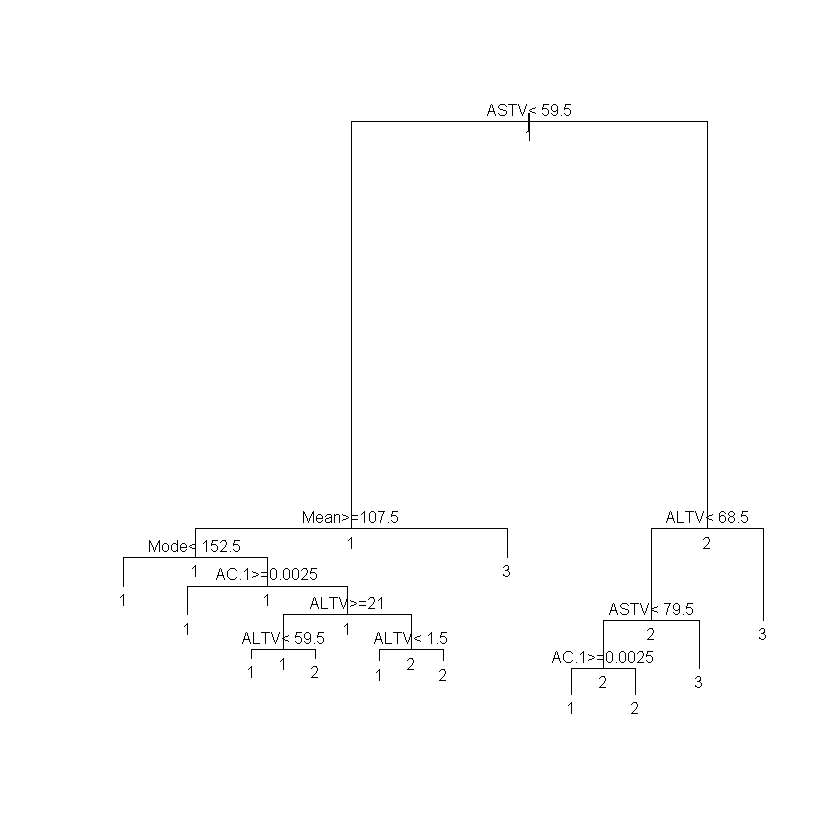

In [12]:
plot(CTG_DT_fit1$finalModel)
text(CTG_DT_fit1$finalModel, all=TRUE, cex=.8)

Random Forest 

1488 samples
  21 predictor
   3 classes: '1', '2', '3' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 1339, 1340, 1339, 1340, 1339, 1339, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   1    0.8923234  0.6942200
   3    0.9373505  0.8341871
   5    0.9436685  0.8512596
   7    0.9443414  0.8534772
   9    0.9455477  0.8569599
  11    0.9455495  0.8576967

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 11.

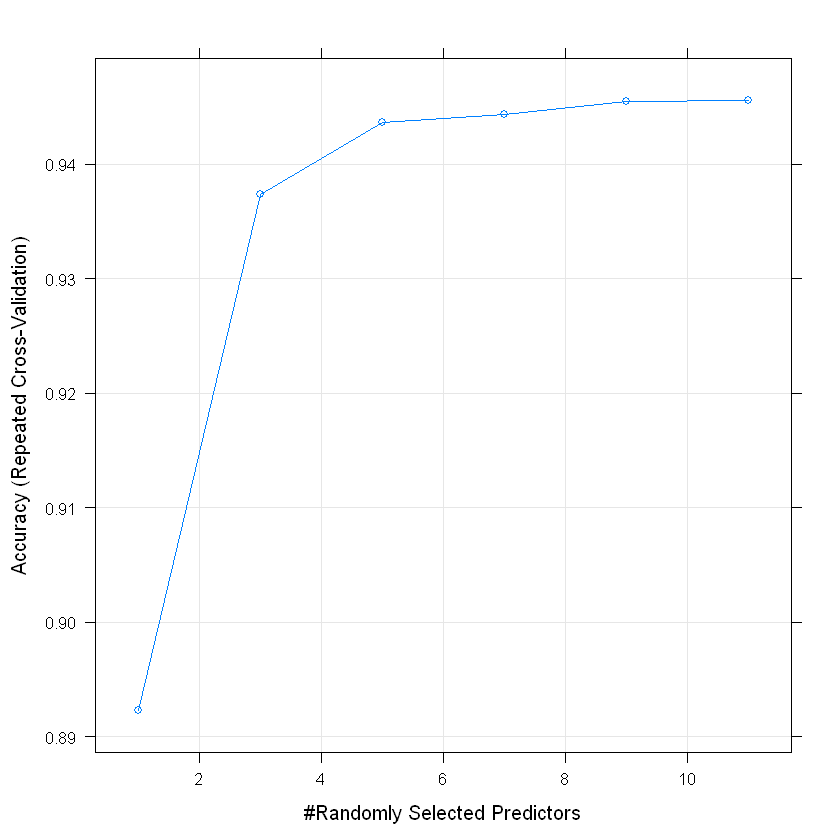

In [18]:
#Model 3 - Random Forest

RF_grid <- expand.grid(mtry = c(1,3,5,7,9,11)) # default value is 5 I change by both increasing and decreasing
RF_control <- trainControl(method = "repeatedcv", number = n_folds, repeats = n_repeats) 
CTG_RF_fit <- train(NSP~., data=train_CTG, method ="rf",tuneGrid = RF_grid, trControl=RF_control)
CTG_RF_fit
plot(CTG_RF_fit)
CTG_RF_fit$finalModel

In [20]:
#Model 4 - Stochastic Gradient Boosting

# interaction.depth default is 1 tried 2,3 and 5, n.trees default is 100 I change by both increasing and decreasing, 
# shrinkage default is 0.1 I change by both increasing and decreasing
SGB_grid <- expand.grid(interaction.depth=c(1,2,3,5), n.trees = c(100,200,50),shrinkage=c(0.05,0.1,0.2),n.minobsinnode =10)
SGB_control <- trainControl(method = "repeatedcv", number = n_folds, repeats = n_repeats) 
CTG_SGB_fit <- train(NSP~., data=train_CTG, method ="gbm",tuneGrid = SGB_grid, trControl=SGB_control)

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1805
     2        0.9943             nan     0.0500    0.1463
     3        0.9084             nan     0.0500    0.1255
     4        0.8339             nan     0.0500    0.1061
     5        0.7703             nan     0.0500    0.0904
     6        0.7168             nan     0.0500    0.0767
     7        0.6718             nan     0.0500    0.0664
     8        0.6296             nan     0.0500    0.0590
     9        0.5933             nan     0.0500    0.0511
    10        0.5610             nan     0.0500    0.0451
    20        0.3802             nan     0.0500    0.0136
    40        0.2606             nan     0.0500    0.0043
    60        0.2126             nan     0.0500    0.0007
    80        0.1864             nan     0.0500    0.0005
   100        0.1656             nan     0.0500    0.0003
   120        0.1533             nan     0.0500    0.0000
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1940
     2        0.9872             nan     0.0500    0.1577
     3        0.8932             nan     0.0500    0.1328
     4        0.8137             nan     0.0500    0.1120
     5        0.7443             nan     0.0500    0.0972
     6        0.6854             nan     0.0500    0.0821
     7        0.6346             nan     0.0500    0.0713
     8        0.5904             nan     0.0500    0.0610
     9        0.5521             nan     0.0500    0.0536
    10        0.5185             nan     0.0500    0.0498
    20        0.3168             nan     0.0500    0.0157
    40        0.1913             nan     0.0500    0.0018
    60        0.1512             nan     0.0500    0.0002
    80        0.1294             nan     0.0500   -0.0001
   100        0.1131             nan     0.0500   -0.0011
   120        0.1023             nan     0.0500   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1995
     2        0.9815             nan     0.0500    0.1671
     3        0.8834             nan     0.0500    0.1373
     4        0.8009             nan     0.0500    0.1138
     5        0.7304             nan     0.0500    0.0978
     6        0.6703             nan     0.0500    0.0859
     7        0.6185             nan     0.0500    0.0744
     8        0.5710             nan     0.0500    0.0678
     9        0.5294             nan     0.0500    0.0579
    10        0.4929             nan     0.0500    0.0496
    20        0.2843             nan     0.0500    0.0172
    40        0.1601             nan     0.0500    0.0007
    60        0.1210             nan     0.0500    0.0015
    80        0.1001             nan     0.0500   -0.0003
   100        0.0858             nan     0.0500   -0.0003
   120        0.0745             nan     0.0500   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2105
     2        0.9757             nan     0.0500    0.1728
     3        0.8734             nan     0.0500    0.1457
     4        0.7874             nan     0.0500    0.1217
     5        0.7135             nan     0.0500    0.1016
     6        0.6514             nan     0.0500    0.0952
     7        0.5955             nan     0.0500    0.0800
     8        0.5468             nan     0.0500    0.0703
     9        0.5041             nan     0.0500    0.0590
    10        0.4669             nan     0.0500    0.0532
    20        0.2572             nan     0.0500    0.0189
    40        0.1309             nan     0.0500    0.0019
    60        0.0901             nan     0.0500    0.0004
    80        0.0688             nan     0.0500   -0.0003
   100        0.0558             nan     0.0500   -0.0011
   120        0.0461             nan     0.0500   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3286
     2        0.9005             nan     0.1000    0.2180
     3        0.7651             nan     0.1000    0.1652
     4        0.6627             nan     0.1000    0.1202
     5        0.5842             nan     0.1000    0.0917
     6        0.5268             nan     0.1000    0.0692
     7        0.4803             nan     0.1000    0.0534
     8        0.4430             nan     0.1000    0.0453
     9        0.4101             nan     0.1000    0.0392
    10        0.3848             nan     0.1000    0.0303
    20        0.2610             nan     0.1000    0.0048
    40        0.1875             nan     0.1000    0.0015
    60        0.1567             nan     0.1000   -0.0007
    80        0.1385             nan     0.1000    0.0000
   100        0.1257             nan     0.1000   -0.0017
   120        0.1170             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3550
     2        0.8801             nan     0.1000    0.2398
     3        0.7340             nan     0.1000    0.1712
     4        0.6270             nan     0.1000    0.1274
     5        0.5452             nan     0.1000    0.0962
     6        0.4815             nan     0.1000    0.0774
     7        0.4288             nan     0.1000    0.0608
     8        0.3866             nan     0.1000    0.0520
     9        0.3501             nan     0.1000    0.0394
    10        0.3218             nan     0.1000    0.0337
    20        0.1950             nan     0.1000    0.0065
    40        0.1315             nan     0.1000    0.0001
    60        0.1027             nan     0.1000   -0.0053
    80        0.0861             nan     0.1000   -0.0015
   100        0.0741             nan     0.1000   -0.0007
   120        0.0643             nan     0.1000   -0.0032
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3700
     2        0.8717             nan     0.1000    0.2434
     3        0.7167             nan     0.1000    0.1752
     4        0.6047             nan     0.1000    0.1347
     5        0.5197             nan     0.1000    0.0977
     6        0.4534             nan     0.1000    0.0827
     7        0.3963             nan     0.1000    0.0563
     8        0.3559             nan     0.1000    0.0462
     9        0.3216             nan     0.1000    0.0470
    10        0.2901             nan     0.1000    0.0311
    20        0.1630             nan     0.1000    0.0046
    40        0.1031             nan     0.1000   -0.0026
    60        0.0781             nan     0.1000   -0.0030
    80        0.0629             nan     0.1000   -0.0012
   100        0.0496             nan     0.1000   -0.0007
   120        0.0415             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3828
     2        0.8610             nan     0.1000    0.2597
     3        0.7008             nan     0.1000    0.1907
     4        0.5829             nan     0.1000    0.1392
     5        0.4920             nan     0.1000    0.1039
     6        0.4220             nan     0.1000    0.0804
     7        0.3677             nan     0.1000    0.0594
     8        0.3243             nan     0.1000    0.0489
     9        0.2889             nan     0.1000    0.0374
    10        0.2612             nan     0.1000    0.0269
    20        0.1345             nan     0.1000   -0.0003
    40        0.0710             nan     0.1000   -0.0010
    60        0.0486             nan     0.1000   -0.0015
    80        0.0357             nan     0.1000   -0.0016
   100        0.0263             nan     0.1000   -0.0016
   120        0.0205             nan     0.1000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5487
     2        0.7330             nan     0.2000    0.2396
     3        0.5643             nan     0.2000    0.1508
     4        0.4630             nan     0.2000    0.0916
     5        0.4018             nan     0.2000    0.0600
     6        0.3579             nan     0.2000    0.0351
     7        0.3218             nan     0.2000    0.0381
     8        0.2946             nan     0.2000    0.0273
     9        0.2758             nan     0.2000    0.0159
    10        0.2600             nan     0.2000    0.0100
    20        0.1873             nan     0.2000   -0.0001
    40        0.1416             nan     0.2000   -0.0018
    60        0.1192             nan     0.2000   -0.0028
    80        0.1060             nan     0.2000   -0.0018
   100        0.0955             nan     0.2000   -0.0031
   120        0.0873             nan     0.2000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5820
     2        0.7075             nan     0.2000    0.2732
     3        0.5225             nan     0.2000    0.1511
     4        0.4112             nan     0.2000    0.1016
     5        0.3407             nan     0.2000    0.0700
     6        0.2876             nan     0.2000    0.0397
     7        0.2540             nan     0.2000    0.0327
     8        0.2273             nan     0.2000    0.0106
     9        0.2114             nan     0.2000    0.0181
    10        0.1949             nan     0.2000    0.0169
    20        0.1292             nan     0.2000   -0.0013
    40        0.0872             nan     0.2000   -0.0031
    60        0.0697             nan     0.2000   -0.0042
    80        0.0539             nan     0.2000   -0.0038
   100        0.0433             nan     0.2000   -0.0047
   120        0.0376             nan     0.2000   -0.0030
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6139
     2        0.6883             nan     0.2000    0.2607
     3        0.5024             nan     0.2000    0.1746
     4        0.3832             nan     0.2000    0.0934
     5        0.3079             nan     0.2000    0.0596
     6        0.2604             nan     0.2000    0.0588
     7        0.2202             nan     0.2000    0.0285
     8        0.1959             nan     0.2000    0.0183
     9        0.1767             nan     0.2000    0.0074
    10        0.1656             nan     0.2000   -0.0074
    20        0.1024             nan     0.2000   -0.0023
    40        0.0593             nan     0.2000   -0.0015
    60        0.0432             nan     0.2000   -0.0030
    80        0.0338             nan     0.2000   -0.0025
   100        0.0248             nan     0.2000   -0.0030
   120        0.0192             nan     0.2000   -0.0020
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6637
     2        0.6713             nan     0.2000    0.2783
     3        0.4730             nan     0.2000    0.1670
     4        0.3561             nan     0.2000    0.0994
     5        0.2842             nan     0.2000    0.0653
     6        0.2324             nan     0.2000    0.0358
     7        0.1924             nan     0.2000    0.0139
     8        0.1712             nan     0.2000    0.0093
     9        0.1541             nan     0.2000    0.0089
    10        0.1390             nan     0.2000    0.0029
    20        0.0746             nan     0.2000   -0.0065
    40        0.0393             nan     0.2000   -0.0043
    60        0.0228             nan     0.2000   -0.0032
    80        0.0151             nan     0.2000   -0.0013
   100        0.0113             nan     0.2000   -0.0023
   120        0.0079             nan     0.2000   -0.0020
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1817
     2        0.9941             nan     0.0500    0.1506
     3        0.9071             nan     0.0500    0.1268
     4        0.8340             nan     0.0500    0.1066
     5        0.7688             nan     0.0500    0.0912
     6        0.7141             nan     0.0500    0.0782
     7        0.6667             nan     0.0500    0.0677
     8        0.6251             nan     0.0500    0.0586
     9        0.5882             nan     0.0500    0.0507
    10        0.5559             nan     0.0500    0.0445
    20        0.3743             nan     0.0500    0.0133
    40        0.2563             nan     0.0500    0.0066
    60        0.2110             nan     0.0500    0.0020
    80        0.1851             nan     0.0500    0.0009
   100        0.1664             nan     0.0500    0.0020
   120        0.1509             nan     0.0500   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1957
     2        0.9857             nan     0.0500    0.1610
     3        0.8931             nan     0.0500    0.1347
     4        0.8143             nan     0.0500    0.1126
     5        0.7443             nan     0.0500    0.0956
     6        0.6852             nan     0.0500    0.0826
     7        0.6345             nan     0.0500    0.0733
     8        0.5892             nan     0.0500    0.0641
     9        0.5495             nan     0.0500    0.0562
    10        0.5148             nan     0.0500    0.0487
    20        0.3118             nan     0.0500    0.0154
    40        0.1891             nan     0.0500    0.0023
    60        0.1493             nan     0.0500    0.0001
    80        0.1251             nan     0.0500   -0.0010
   100        0.1091             nan     0.0500   -0.0003
   120        0.0988             nan     0.0500    0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2021
     2        0.9806             nan     0.0500    0.1619
     3        0.8852             nan     0.0500    0.1385
     4        0.8023             nan     0.0500    0.1180
     5        0.7310             nan     0.0500    0.1041
     6        0.6684             nan     0.0500    0.0879
     7        0.6151             nan     0.0500    0.0769
     8        0.5677             nan     0.0500    0.0671
     9        0.5269             nan     0.0500    0.0584
    10        0.4897             nan     0.0500    0.0519
    20        0.2790             nan     0.0500    0.0167
    40        0.1550             nan     0.0500    0.0006
    60        0.1183             nan     0.0500    0.0004
    80        0.0983             nan     0.0500   -0.0007
   100        0.0845             nan     0.0500   -0.0012
   120        0.0738             nan     0.0500   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2126
     2        0.9768             nan     0.0500    0.1692
     3        0.8754             nan     0.0500    0.1466
     4        0.7898             nan     0.0500    0.1231
     5        0.7157             nan     0.0500    0.1052
     6        0.6514             nan     0.0500    0.0906
     7        0.5966             nan     0.0500    0.0804
     8        0.5480             nan     0.0500    0.0674
     9        0.5061             nan     0.0500    0.0593
    10        0.4674             nan     0.0500    0.0507
    20        0.2534             nan     0.0500    0.0169
    40        0.1263             nan     0.0500    0.0014
    60        0.0907             nan     0.0500   -0.0008
    80        0.0719             nan     0.0500   -0.0008
   100        0.0588             nan     0.0500   -0.0015
   120        0.0490             nan     0.0500   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3357
     2        0.8987             nan     0.1000    0.2235
     3        0.7527             nan     0.1000    0.1583
     4        0.6564             nan     0.1000    0.1129
     5        0.5833             nan     0.1000    0.0946
     6        0.5220             nan     0.1000    0.0709
     7        0.4757             nan     0.1000    0.0592
     8        0.4366             nan     0.1000    0.0450
     9        0.4067             nan     0.1000    0.0289
    10        0.3845             nan     0.1000    0.0300
    20        0.2570             nan     0.1000    0.0067
    40        0.1836             nan     0.1000    0.0042
    60        0.1534             nan     0.1000    0.0001
    80        0.1359             nan     0.1000   -0.0029
   100        0.1239             nan     0.1000   -0.0018
   120        0.1156             nan     0.1000   -0.0023
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3551
     2        0.8822             nan     0.1000    0.2423
     3        0.7295             nan     0.1000    0.1757
     4        0.6215             nan     0.1000    0.1285
     5        0.5366             nan     0.1000    0.0955
     6        0.4743             nan     0.1000    0.0780
     7        0.4225             nan     0.1000    0.0647
     8        0.3783             nan     0.1000    0.0457
     9        0.3454             nan     0.1000    0.0428
    10        0.3163             nan     0.1000    0.0309
    20        0.1883             nan     0.1000    0.0039
    40        0.1276             nan     0.1000   -0.0019
    60        0.1024             nan     0.1000   -0.0011
    80        0.0862             nan     0.1000   -0.0037
   100        0.0750             nan     0.1000   -0.0007
   120        0.0660             nan     0.1000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3697
     2        0.8712             nan     0.1000    0.2477
     3        0.7166             nan     0.1000    0.1820
     4        0.6015             nan     0.1000    0.1368
     5        0.5155             nan     0.1000    0.1029
     6        0.4500             nan     0.1000    0.0791
     7        0.3972             nan     0.1000    0.0601
     8        0.3551             nan     0.1000    0.0465
     9        0.3208             nan     0.1000    0.0393
    10        0.2924             nan     0.1000    0.0351
    20        0.1594             nan     0.1000    0.0067
    40        0.0974             nan     0.1000   -0.0010
    60        0.0724             nan     0.1000   -0.0022
    80        0.0564             nan     0.1000   -0.0023
   100        0.0476             nan     0.1000   -0.0011
   120        0.0391             nan     0.1000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3800
     2        0.8651             nan     0.1000    0.2610
     3        0.7027             nan     0.1000    0.1889
     4        0.5852             nan     0.1000    0.1329
     5        0.4951             nan     0.1000    0.1022
     6        0.4273             nan     0.1000    0.0862
     7        0.3705             nan     0.1000    0.0585
     8        0.3279             nan     0.1000    0.0439
     9        0.2947             nan     0.1000    0.0441
    10        0.2633             nan     0.1000    0.0296
    20        0.1330             nan     0.1000    0.0059
    40        0.0705             nan     0.1000   -0.0039
    60        0.0497             nan     0.1000   -0.0015
    80        0.0364             nan     0.1000   -0.0026
   100        0.0275             nan     0.1000   -0.0012
   120        0.0214             nan     0.1000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5531
     2        0.7311             nan     0.2000    0.2584
     3        0.5604             nan     0.2000    0.1413
     4        0.4580             nan     0.2000    0.0752
     5        0.3975             nan     0.2000    0.0588
     6        0.3516             nan     0.2000    0.0472
     7        0.3137             nan     0.2000    0.0332
     8        0.2875             nan     0.2000    0.0206
     9        0.2674             nan     0.2000    0.0154
    10        0.2518             nan     0.2000    0.0080
    20        0.1799             nan     0.2000   -0.0053
    40        0.1322             nan     0.2000   -0.0065
    60        0.1160             nan     0.2000   -0.0035
    80        0.1041             nan     0.2000   -0.0076
   100        0.0941             nan     0.2000   -0.0040
   120        0.0878             nan     0.2000   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5805
     2        0.7017             nan     0.2000    0.2788
     3        0.5139             nan     0.2000    0.1459
     4        0.4057             nan     0.2000    0.0856
     5        0.3362             nan     0.2000    0.0476
     6        0.2891             nan     0.2000    0.0463
     7        0.2523             nan     0.2000    0.0324
     8        0.2269             nan     0.2000    0.0229
     9        0.2051             nan     0.2000    0.0103
    10        0.1912             nan     0.2000    0.0125
    20        0.1240             nan     0.2000   -0.0030
    40        0.0870             nan     0.2000   -0.0075
    60        0.0691             nan     0.2000   -0.0023
    80        0.0522             nan     0.2000   -0.0028
   100        0.0425             nan     0.2000   -0.0018
   120        0.0353             nan     0.2000   -0.0023
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6041
     2        0.6827             nan     0.2000    0.2572
     3        0.4929             nan     0.2000    0.1460
     4        0.3790             nan     0.2000    0.1020
     5        0.3033             nan     0.2000    0.0622
     6        0.2559             nan     0.2000    0.0377
     7        0.2257             nan     0.2000    0.0274
     8        0.1955             nan     0.2000    0.0032
     9        0.1792             nan     0.2000    0.0156
    10        0.1648             nan     0.2000    0.0049
    20        0.1056             nan     0.2000   -0.0006
    40        0.0620             nan     0.2000   -0.0039
    60        0.0434             nan     0.2000   -0.0025
    80        0.0316             nan     0.2000   -0.0006
   100        0.0237             nan     0.2000   -0.0012
   120        0.0189             nan     0.2000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6061
     2        0.6719             nan     0.2000    0.2883
     3        0.4641             nan     0.2000    0.1599
     4        0.3469             nan     0.2000    0.0942
     5        0.2743             nan     0.2000    0.0468
     6        0.2257             nan     0.2000    0.0292
     7        0.1938             nan     0.2000    0.0190
     8        0.1691             nan     0.2000    0.0166
     9        0.1476             nan     0.2000    0.0043
    10        0.1361             nan     0.2000    0.0027
    20        0.0763             nan     0.2000   -0.0050
    40        0.0401             nan     0.2000   -0.0043
    60        0.0252             nan     0.2000   -0.0041
    80        0.0161             nan     0.2000   -0.0004
   100        0.0119             nan     0.2000   -0.0010
   120        0.0093             nan     0.2000   -0.0018
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1814
     2        0.9943             nan     0.0500    0.1461
     3        0.9077             nan     0.0500    0.1257
     4        0.8324             nan     0.0500    0.1080
     5        0.7694             nan     0.0500    0.0905
     6        0.7136             nan     0.0500    0.0784
     7        0.6656             nan     0.0500    0.0676
     8        0.6253             nan     0.0500    0.0591
     9        0.5890             nan     0.0500    0.0527
    10        0.5567             nan     0.0500    0.0457
    20        0.3756             nan     0.0500    0.0164
    40        0.2557             nan     0.0500    0.0044
    60        0.2108             nan     0.0500    0.0015
    80        0.1838             nan     0.0500    0.0015
   100        0.1664             nan     0.0500    0.0001
   120        0.1536             nan     0.0500   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1943
     2        0.9853             nan     0.0500    0.1604
     3        0.8910             nan     0.0500    0.1334
     4        0.8123             nan     0.0500    0.1131
     5        0.7435             nan     0.0500    0.0966
     6        0.6843             nan     0.0500    0.0844
     7        0.6319             nan     0.0500    0.0714
     8        0.5877             nan     0.0500    0.0620
     9        0.5486             nan     0.0500    0.0575
    10        0.5137             nan     0.0500    0.0479
    20        0.3129             nan     0.0500    0.0177
    40        0.1886             nan     0.0500    0.0036
    60        0.1523             nan     0.0500    0.0004
    80        0.1282             nan     0.0500   -0.0009
   100        0.1126             nan     0.0500    0.0000
   120        0.1011             nan     0.0500    0.0000
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2004
     2        0.9807             nan     0.0500    0.1617
     3        0.8837             nan     0.0500    0.1389
     4        0.8009             nan     0.0500    0.1185
     5        0.7296             nan     0.0500    0.0969
     6        0.6685             nan     0.0500    0.0866
     7        0.6152             nan     0.0500    0.0749
     8        0.5685             nan     0.0500    0.0653
     9        0.5271             nan     0.0500    0.0584
    10        0.4909             nan     0.0500    0.0510
    20        0.2842             nan     0.0500    0.0185
    40        0.1594             nan     0.0500   -0.0004
    60        0.1210             nan     0.0500   -0.0000
    80        0.0999             nan     0.0500   -0.0004
   100        0.0855             nan     0.0500   -0.0002
   120        0.0753             nan     0.0500   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2044
     2        0.9782             nan     0.0500    0.1752
     3        0.8755             nan     0.0500    0.1393
     4        0.7919             nan     0.0500    0.1222
     5        0.7177             nan     0.0500    0.1046
     6        0.6531             nan     0.0500    0.0936
     7        0.5974             nan     0.0500    0.0814
     8        0.5485             nan     0.0500    0.0662
     9        0.5062             nan     0.0500    0.0592
    10        0.4676             nan     0.0500    0.0514
    20        0.2515             nan     0.0500    0.0147
    40        0.1318             nan     0.0500    0.0024
    60        0.0923             nan     0.0500   -0.0008
    80        0.0727             nan     0.0500   -0.0012
   100        0.0589             nan     0.0500   -0.0009
   120        0.0490             nan     0.0500   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3314
     2        0.8949             nan     0.1000    0.2243
     3        0.7558             nan     0.1000    0.1643
     4        0.6553             nan     0.1000    0.1236
     5        0.5799             nan     0.1000    0.0913
     6        0.5207             nan     0.1000    0.0725
     7        0.4731             nan     0.1000    0.0517
     8        0.4362             nan     0.1000    0.0430
     9        0.4055             nan     0.1000    0.0382
    10        0.3802             nan     0.1000    0.0287
    20        0.2567             nan     0.1000    0.0063
    40        0.1855             nan     0.1000    0.0020
    60        0.1550             nan     0.1000   -0.0001
    80        0.1375             nan     0.1000   -0.0035
   100        0.1242             nan     0.1000   -0.0018
   120        0.1140             nan     0.1000   -0.0026
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3590
     2        0.8826             nan     0.1000    0.2449
     3        0.7316             nan     0.1000    0.1751
     4        0.6205             nan     0.1000    0.1323
     5        0.5389             nan     0.1000    0.0974
     6        0.4790             nan     0.1000    0.0809
     7        0.4246             nan     0.1000    0.0639
     8        0.3832             nan     0.1000    0.0483
     9        0.3497             nan     0.1000    0.0455
    10        0.3192             nan     0.1000    0.0286
    20        0.1910             nan     0.1000    0.0072
    40        0.1285             nan     0.1000   -0.0009
    60        0.1014             nan     0.1000   -0.0013
    80        0.0855             nan     0.1000   -0.0010
   100        0.0724             nan     0.1000   -0.0015
   120        0.0634             nan     0.1000   -0.0021
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3692
     2        0.8699             nan     0.1000    0.2516
     3        0.7148             nan     0.1000    0.1797
     4        0.6000             nan     0.1000    0.1316
     5        0.5153             nan     0.1000    0.1005
     6        0.4484             nan     0.1000    0.0807
     7        0.3949             nan     0.1000    0.0700
     8        0.3490             nan     0.1000    0.0534
     9        0.3136             nan     0.1000    0.0359
    10        0.2857             nan     0.1000    0.0329
    20        0.1640             nan     0.1000    0.0046
    40        0.1014             nan     0.1000   -0.0048
    60        0.0787             nan     0.1000   -0.0032
    80        0.0610             nan     0.1000   -0.0013
   100        0.0504             nan     0.1000   -0.0010
   120        0.0426             nan     0.1000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3777
     2        0.8623             nan     0.1000    0.2478
     3        0.7055             nan     0.1000    0.1855
     4        0.5871             nan     0.1000    0.1398
     5        0.4980             nan     0.1000    0.1070
     6        0.4287             nan     0.1000    0.0835
     7        0.3726             nan     0.1000    0.0692
     8        0.3269             nan     0.1000    0.0489
     9        0.2905             nan     0.1000    0.0379
    10        0.2623             nan     0.1000    0.0295
    20        0.1332             nan     0.1000    0.0042
    40        0.0721             nan     0.1000   -0.0011
    60        0.0489             nan     0.1000   -0.0011
    80        0.0360             nan     0.1000   -0.0023
   100        0.0278             nan     0.1000   -0.0011
   120        0.0224             nan     0.1000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5579
     2        0.7339             nan     0.2000    0.2567
     3        0.5575             nan     0.2000    0.1421
     4        0.4550             nan     0.2000    0.0918
     5        0.3895             nan     0.2000    0.0581
     6        0.3454             nan     0.2000    0.0349
     7        0.3178             nan     0.2000    0.0234
     8        0.2969             nan     0.2000    0.0200
     9        0.2816             nan     0.2000    0.0273
    10        0.2603             nan     0.2000    0.0109
    20        0.1814             nan     0.2000    0.0054
    40        0.1364             nan     0.2000   -0.0045
    60        0.1139             nan     0.2000   -0.0003
    80        0.1003             nan     0.2000   -0.0001
   100        0.0894             nan     0.2000   -0.0027
   120        0.0817             nan     0.2000   -0.0027
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6031
     2        0.7054             nan     0.2000    0.2810
     3        0.5136             nan     0.2000    0.1606
     4        0.4054             nan     0.2000    0.0930
     5        0.3346             nan     0.2000    0.0534
     6        0.2907             nan     0.2000    0.0480
     7        0.2506             nan     0.2000    0.0298
     8        0.2258             nan     0.2000    0.0151
     9        0.2072             nan     0.2000    0.0109
    10        0.1924             nan     0.2000    0.0137
    20        0.1311             nan     0.2000   -0.0019
    40        0.0855             nan     0.2000   -0.0032
    60        0.0663             nan     0.2000   -0.0035
    80        0.0534             nan     0.2000   -0.0011
   100        0.0446             nan     0.2000   -0.0003
   120        0.0372             nan     0.2000   -0.0021
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6245
     2        0.6887             nan     0.2000    0.2769
     3        0.4896             nan     0.2000    0.1551
     4        0.3790             nan     0.2000    0.1041
     5        0.3041             nan     0.2000    0.0636
     6        0.2583             nan     0.2000    0.0235
     7        0.2289             nan     0.2000    0.0211
     8        0.1959             nan     0.2000   -0.0130
     9        0.1778             nan     0.2000    0.0102
    10        0.1658             nan     0.2000    0.0077
    20        0.1039             nan     0.2000   -0.0009
    40        0.0658             nan     0.2000   -0.0052
    60        0.0451             nan     0.2000   -0.0032
    80        0.0346             nan     0.2000   -0.0012
   100        0.0280             nan     0.2000   -0.0037
   120        0.0235             nan     0.2000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6287
     2        0.6696             nan     0.2000    0.2939
     3        0.4664             nan     0.2000    0.1666
     4        0.3463             nan     0.2000    0.0969
     5        0.2741             nan     0.2000    0.0671
     6        0.2242             nan     0.2000    0.0216
     7        0.1948             nan     0.2000    0.0255
     8        0.1699             nan     0.2000    0.0085
     9        0.1530             nan     0.2000    0.0046
    10        0.1403             nan     0.2000    0.0003
    20        0.0796             nan     0.2000   -0.0020
    40        0.0401             nan     0.2000   -0.0046
    60        0.0268             nan     0.2000   -0.0064
    80        0.0197             nan     0.2000   -0.0035
   100        0.0140             nan     0.2000   -0.0038
   120        0.0110             nan     0.2000   -0.0027
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1783
     2        0.9944             nan     0.0500    0.1491
     3        0.9083             nan     0.0500    0.1230
     4        0.8363             nan     0.0500    0.1063
     5        0.7745             nan     0.0500    0.0910
     6        0.7207             nan     0.0500    0.0778
     7        0.6732             nan     0.0500    0.0652
     8        0.6327             nan     0.0500    0.0579
     9        0.5964             nan     0.0500    0.0494
    10        0.5647             nan     0.0500    0.0455
    20        0.3832             nan     0.0500    0.0161
    40        0.2663             nan     0.0500    0.0063
    60        0.2185             nan     0.0500    0.0037
    80        0.1878             nan     0.0500    0.0000
   100        0.1702             nan     0.0500   -0.0004
   120        0.1566             nan     0.0500    0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1919
     2        0.9845             nan     0.0500    0.1576
     3        0.8917             nan     0.0500    0.1305
     4        0.8125             nan     0.0500    0.1117
     5        0.7453             nan     0.0500    0.0947
     6        0.6868             nan     0.0500    0.0829
     7        0.6367             nan     0.0500    0.0719
     8        0.5936             nan     0.0500    0.0629
     9        0.5548             nan     0.0500    0.0537
    10        0.5204             nan     0.0500    0.0482
    20        0.3191             nan     0.0500    0.0160
    40        0.1933             nan     0.0500    0.0024
    60        0.1521             nan     0.0500   -0.0003
    80        0.1287             nan     0.0500   -0.0008
   100        0.1136             nan     0.0500    0.0002
   120        0.1025             nan     0.0500   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1976
     2        0.9812             nan     0.0500    0.1635
     3        0.8849             nan     0.0500    0.1394
     4        0.8031             nan     0.0500    0.1175
     5        0.7336             nan     0.0500    0.0999
     6        0.6738             nan     0.0500    0.0857
     7        0.6204             nan     0.0500    0.0759
     8        0.5736             nan     0.0500    0.0665
     9        0.5314             nan     0.0500    0.0584
    10        0.4956             nan     0.0500    0.0513
    20        0.2889             nan     0.0500    0.0235
    40        0.1599             nan     0.0500    0.0005
    60        0.1225             nan     0.0500   -0.0004
    80        0.1006             nan     0.0500   -0.0014
   100        0.0848             nan     0.0500   -0.0002
   120        0.0738             nan     0.0500   -0.0000
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2033
     2        0.9776             nan     0.0500    0.1710
     3        0.8773             nan     0.0500    0.1436
     4        0.7913             nan     0.0500    0.1211
     5        0.7184             nan     0.0500    0.1030
     6        0.6560             nan     0.0500    0.0916
     7        0.6005             nan     0.0500    0.0785
     8        0.5511             nan     0.0500    0.0673
     9        0.5095             nan     0.0500    0.0568
    10        0.4729             nan     0.0500    0.0535
    20        0.2575             nan     0.0500    0.0151
    40        0.1308             nan     0.0500    0.0041
    60        0.0899             nan     0.0500   -0.0013
    80        0.0702             nan     0.0500   -0.0000
   100        0.0575             nan     0.0500   -0.0008
   120        0.0491             nan     0.0500    0.0000
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3266
     2        0.8966             nan     0.1000    0.2209
     3        0.7600             nan     0.1000    0.1607
     4        0.6601             nan     0.1000    0.1197
     5        0.5849             nan     0.1000    0.0890
     6        0.5254             nan     0.1000    0.0683
     7        0.4800             nan     0.1000    0.0563
     8        0.4422             nan     0.1000    0.0445
     9        0.4132             nan     0.1000    0.0371
    10        0.3848             nan     0.1000    0.0335
    20        0.2647             nan     0.1000    0.0052
    40        0.1911             nan     0.1000    0.0001
    60        0.1588             nan     0.1000   -0.0027
    80        0.1413             nan     0.1000   -0.0017
   100        0.1276             nan     0.1000   -0.0022
   120        0.1180             nan     0.1000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3586
     2        0.8860             nan     0.1000    0.2411
     3        0.7357             nan     0.1000    0.1715
     4        0.6293             nan     0.1000    0.1292
     5        0.5457             nan     0.1000    0.0974
     6        0.4814             nan     0.1000    0.0756
     7        0.4302             nan     0.1000    0.0621
     8        0.3897             nan     0.1000    0.0455
     9        0.3548             nan     0.1000    0.0373
    10        0.3282             nan     0.1000    0.0371
    20        0.1931             nan     0.1000    0.0026
    40        0.1312             nan     0.1000   -0.0013
    60        0.1023             nan     0.1000   -0.0012
    80        0.0841             nan     0.1000   -0.0013
   100        0.0719             nan     0.1000   -0.0010
   120        0.0634             nan     0.1000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3683
     2        0.8728             nan     0.1000    0.2455
     3        0.7179             nan     0.1000    0.1766
     4        0.6050             nan     0.1000    0.1353
     5        0.5175             nan     0.1000    0.1017
     6        0.4522             nan     0.1000    0.0768
     7        0.3998             nan     0.1000    0.0641
     8        0.3578             nan     0.1000    0.0564
     9        0.3205             nan     0.1000    0.0355
    10        0.2933             nan     0.1000    0.0288
    20        0.1586             nan     0.1000    0.0064
    40        0.0971             nan     0.1000   -0.0031
    60        0.0755             nan     0.1000   -0.0017
    80        0.0600             nan     0.1000   -0.0013
   100        0.0484             nan     0.1000   -0.0019
   120        0.0407             nan     0.1000   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3756
     2        0.8663             nan     0.1000    0.2575
     3        0.7032             nan     0.1000    0.1862
     4        0.5871             nan     0.1000    0.1390
     5        0.4978             nan     0.1000    0.1059
     6        0.4283             nan     0.1000    0.0830
     7        0.3736             nan     0.1000    0.0678
     8        0.3275             nan     0.1000    0.0440
     9        0.2936             nan     0.1000    0.0426
    10        0.2639             nan     0.1000    0.0293
    20        0.1324             nan     0.1000    0.0011
    40        0.0740             nan     0.1000   -0.0021
    60        0.0511             nan     0.1000   -0.0022
    80        0.0371             nan     0.1000   -0.0008
   100        0.0281             nan     0.1000   -0.0017
   120        0.0231             nan     0.1000   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5404
     2        0.7313             nan     0.2000    0.2328
     3        0.5648             nan     0.2000    0.1435
     4        0.4648             nan     0.2000    0.0919
     5        0.4015             nan     0.2000    0.0570
     6        0.3563             nan     0.2000    0.0417
     7        0.3262             nan     0.2000    0.0262
     8        0.3063             nan     0.2000    0.0254
     9        0.2865             nan     0.2000    0.0213
    10        0.2712             nan     0.2000    0.0130
    20        0.1844             nan     0.2000    0.0048
    40        0.1366             nan     0.2000   -0.0024
    60        0.1175             nan     0.2000   -0.0045
    80        0.1053             nan     0.2000   -0.0003
   100        0.0964             nan     0.2000    0.0007
   120        0.0864             nan     0.2000   -0.0022
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5811
     2        0.7020             nan     0.2000    0.2554
     3        0.5138             nan     0.2000    0.1494
     4        0.4110             nan     0.2000    0.0802
     5        0.3430             nan     0.2000    0.0731
     6        0.2917             nan     0.2000    0.0370
     7        0.2595             nan     0.2000    0.0220
     8        0.2357             nan     0.2000    0.0244
     9        0.2174             nan     0.2000    0.0134
    10        0.1970             nan     0.2000    0.0085
    20        0.1315             nan     0.2000   -0.0026
    40        0.0884             nan     0.2000   -0.0062
    60        0.0665             nan     0.2000   -0.0022
    80        0.0543             nan     0.2000   -0.0023
   100        0.0427             nan     0.2000   -0.0027
   120        0.0360             nan     0.2000   -0.0024
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6181
     2        0.6885             nan     0.2000    0.2700
     3        0.4955             nan     0.2000    0.1583
     4        0.3818             nan     0.2000    0.1132
     5        0.3056             nan     0.2000    0.0473
     6        0.2608             nan     0.2000    0.0401
     7        0.2277             nan     0.2000    0.0328
     8        0.2004             nan     0.2000    0.0160
     9        0.1794             nan     0.2000    0.0090
    10        0.1676             nan     0.2000    0.0083
    20        0.1087             nan     0.2000   -0.0112
    40        0.0649             nan     0.2000   -0.0060
    60        0.0437             nan     0.2000   -0.0047
    80        0.0357             nan     0.2000   -0.0029
   100        0.0280             nan     0.2000   -0.0033
   120        0.0219             nan     0.2000   -0.0039
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6293
     2        0.6646             nan     0.2000    0.2786
     3        0.4696             nan     0.2000    0.1546
     4        0.3561             nan     0.2000    0.0867
     5        0.2851             nan     0.2000    0.0679
     6        0.2322             nan     0.2000    0.0324
     7        0.1998             nan     0.2000    0.0187
     8        0.1784             nan     0.2000    0.0265
     9        0.1532             nan     0.2000    0.0103
    10        0.1388             nan     0.2000   -0.0006
    20        0.0771             nan     0.2000   -0.0040
    40        0.0431             nan     0.2000   -0.0045
    60        0.0254             nan     0.2000   -0.0030
    80        0.0169             nan     0.2000   -0.0016
   100        0.0133             nan     0.2000   -0.0024
   120        0.0099             nan     0.2000   -0.0028
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1801
     2        0.9938             nan     0.0500    0.1466
     3        0.9089             nan     0.0500    0.1246
     4        0.8327             nan     0.0500    0.1056
     5        0.7694             nan     0.0500    0.0902
     6        0.7161             nan     0.0500    0.0775
     7        0.6694             nan     0.0500    0.0683
     8        0.6282             nan     0.0500    0.0578
     9        0.5911             nan     0.0500    0.0515
    10        0.5595             nan     0.0500    0.0431
    20        0.3792             nan     0.0500    0.0157
    40        0.2602             nan     0.0500    0.0038
    60        0.2120             nan     0.0500    0.0020
    80        0.1855             nan     0.0500    0.0003
   100        0.1671             nan     0.0500    0.0002
   120        0.1539             nan     0.0500    0.0001
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1927
     2        0.9864             nan     0.0500    0.1594
     3        0.8919             nan     0.0500    0.1295
     4        0.8156             nan     0.0500    0.1159
     5        0.7472             nan     0.0500    0.0989
     6        0.6886             nan     0.0500    0.0846
     7        0.6374             nan     0.0500    0.0728
     8        0.5919             nan     0.0500    0.0631
     9        0.5515             nan     0.0500    0.0550
    10        0.5161             nan     0.0500    0.0485
    20        0.3137             nan     0.0500    0.0194
    40        0.1870             nan     0.0500    0.0037
    60        0.1473             nan     0.0500    0.0007
    80        0.1242             nan     0.0500   -0.0001
   100        0.1081             nan     0.0500   -0.0017
   120        0.0975             nan     0.0500   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2011
     2        0.9805             nan     0.0500    0.1675
     3        0.8841             nan     0.0500    0.1388
     4        0.8016             nan     0.0500    0.1177
     5        0.7308             nan     0.0500    0.1029
     6        0.6690             nan     0.0500    0.0873
     7        0.6157             nan     0.0500    0.0748
     8        0.5690             nan     0.0500    0.0645
     9        0.5288             nan     0.0500    0.0598
    10        0.4916             nan     0.0500    0.0497
    20        0.2823             nan     0.0500    0.0134
    40        0.1545             nan     0.0500    0.0011
    60        0.1171             nan     0.0500   -0.0019
    80        0.0971             nan     0.0500   -0.0016
   100        0.0837             nan     0.0500   -0.0009
   120        0.0728             nan     0.0500   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2157
     2        0.9757             nan     0.0500    0.1676
     3        0.8750             nan     0.0500    0.1376
     4        0.7915             nan     0.0500    0.1205
     5        0.7189             nan     0.0500    0.1100
     6        0.6535             nan     0.0500    0.0892
     7        0.5989             nan     0.0500    0.0786
     8        0.5505             nan     0.0500    0.0694
     9        0.5077             nan     0.0500    0.0598
    10        0.4704             nan     0.0500    0.0519
    20        0.2580             nan     0.0500    0.0189
    40        0.1290             nan     0.0500    0.0013
    60        0.0910             nan     0.0500    0.0003
    80        0.0710             nan     0.0500   -0.0016
   100        0.0579             nan     0.0500   -0.0014
   120        0.0485             nan     0.0500   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3294
     2        0.8967             nan     0.1000    0.2265
     3        0.7611             nan     0.1000    0.1642
     4        0.6590             nan     0.1000    0.1204
     5        0.5836             nan     0.1000    0.0928
     6        0.5243             nan     0.1000    0.0708
     7        0.4791             nan     0.1000    0.0569
     8        0.4422             nan     0.1000    0.0444
     9        0.4117             nan     0.1000    0.0380
    10        0.3867             nan     0.1000    0.0280
    20        0.2596             nan     0.1000    0.0069
    40        0.1859             nan     0.1000    0.0018
    60        0.1536             nan     0.1000   -0.0001
    80        0.1366             nan     0.1000   -0.0024
   100        0.1252             nan     0.1000   -0.0003
   120        0.1137             nan     0.1000   -0.0024
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3592
     2        0.8842             nan     0.1000    0.2376
     3        0.7308             nan     0.1000    0.1772
     4        0.6220             nan     0.1000    0.1267
     5        0.5396             nan     0.1000    0.0983
     6        0.4770             nan     0.1000    0.0719
     7        0.4277             nan     0.1000    0.0586
     8        0.3875             nan     0.1000    0.0541
     9        0.3508             nan     0.1000    0.0410
    10        0.3223             nan     0.1000    0.0343
    20        0.1867             nan     0.1000    0.0029
    40        0.1272             nan     0.1000   -0.0017
    60        0.1004             nan     0.1000   -0.0019
    80        0.0829             nan     0.1000   -0.0008
   100        0.0734             nan     0.1000   -0.0017
   120        0.0646             nan     0.1000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3725
     2        0.8723             nan     0.1000    0.2508
     3        0.7161             nan     0.1000    0.1827
     4        0.6019             nan     0.1000    0.1361
     5        0.5167             nan     0.1000    0.0999
     6        0.4517             nan     0.1000    0.0771
     7        0.3999             nan     0.1000    0.0642
     8        0.3563             nan     0.1000    0.0545
     9        0.3195             nan     0.1000    0.0456
    10        0.2875             nan     0.1000    0.0263
    20        0.1585             nan     0.1000    0.0048
    40        0.1015             nan     0.1000   -0.0027
    60        0.0793             nan     0.1000   -0.0007
    80        0.0620             nan     0.1000   -0.0013
   100        0.0505             nan     0.1000   -0.0004
   120        0.0422             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3815
     2        0.8628             nan     0.1000    0.2641
     3        0.6998             nan     0.1000    0.1850
     4        0.5842             nan     0.1000    0.1408
     5        0.4958             nan     0.1000    0.1058
     6        0.4254             nan     0.1000    0.0816
     7        0.3700             nan     0.1000    0.0642
     8        0.3264             nan     0.1000    0.0469
     9        0.2920             nan     0.1000    0.0404
    10        0.2629             nan     0.1000    0.0342
    20        0.1266             nan     0.1000    0.0037
    40        0.0722             nan     0.1000   -0.0023
    60        0.0487             nan     0.1000   -0.0025
    80        0.0357             nan     0.1000   -0.0022
   100        0.0272             nan     0.1000   -0.0023
   120        0.0217             nan     0.1000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5383
     2        0.7337             nan     0.2000    0.2551
     3        0.5582             nan     0.2000    0.1368
     4        0.4584             nan     0.2000    0.0787
     5        0.3978             nan     0.2000    0.0464
     6        0.3542             nan     0.2000    0.0414
     7        0.3242             nan     0.2000    0.0390
     8        0.2962             nan     0.2000    0.0194
     9        0.2769             nan     0.2000    0.0172
    10        0.2618             nan     0.2000    0.0139
    20        0.1896             nan     0.2000    0.0111
    40        0.1378             nan     0.2000   -0.0061
    60        0.1164             nan     0.2000   -0.0005
    80        0.0992             nan     0.2000   -0.0018
   100        0.0901             nan     0.2000   -0.0030
   120        0.0832             nan     0.2000   -0.0045
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5787
     2        0.6979             nan     0.2000    0.2754
     3        0.5188             nan     0.2000    0.1559
     4        0.4102             nan     0.2000    0.0858
     5        0.3370             nan     0.2000    0.0575
     6        0.2891             nan     0.2000    0.0366
     7        0.2566             nan     0.2000    0.0367
     8        0.2304             nan     0.2000    0.0247
     9        0.2110             nan     0.2000    0.0115
    10        0.1967             nan     0.2000    0.0139
    20        0.1277             nan     0.2000   -0.0093
    40        0.0838             nan     0.2000   -0.0061
    60        0.0632             nan     0.2000   -0.0044
    80        0.0515             nan     0.2000   -0.0032
   100        0.0418             nan     0.2000   -0.0019
   120        0.0348             nan     0.2000   -0.0042
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6181
     2        0.6896             nan     0.2000    0.2806
     3        0.4953             nan     0.2000    0.1449
     4        0.3842             nan     0.2000    0.1034
     5        0.3105             nan     0.2000    0.0801
     6        0.2500             nan     0.2000    0.0377
     7        0.2184             nan     0.2000    0.0254
     8        0.1934             nan     0.2000    0.0135
     9        0.1769             nan     0.2000    0.0051
    10        0.1614             nan     0.2000   -0.0081
    20        0.0934             nan     0.2000   -0.0161
    40        0.0609             nan     0.2000   -0.0096
    60        0.0433             nan     0.2000   -0.0037
    80        0.0325             nan     0.2000   -0.0010
   100        0.0248             nan     0.2000   -0.0025
   120        0.0192             nan     0.2000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6332
     2        0.6723             nan     0.2000    0.2988
     3        0.4689             nan     0.2000    0.1582
     4        0.3548             nan     0.2000    0.0990
     5        0.2793             nan     0.2000    0.0595
     6        0.2325             nan     0.2000    0.0248
     7        0.2024             nan     0.2000    0.0282
     8        0.1732             nan     0.2000    0.0049
     9        0.1575             nan     0.2000    0.0075
    10        0.1421             nan     0.2000    0.0078
    20        0.0774             nan     0.2000   -0.0020
    40        0.0383             nan     0.2000   -0.0011
    60        0.0226             nan     0.2000   -0.0015
    80        0.0157             nan     0.2000   -0.0022
   100        0.0114             nan     0.2000   -0.0011
   120        0.0088             nan     0.2000   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1798
     2        0.9937             nan     0.0500    0.1471
     3        0.9067             nan     0.0500    0.1253
     4        0.8335             nan     0.0500    0.1063
     5        0.7715             nan     0.0500    0.0908
     6        0.7179             nan     0.0500    0.0784
     7        0.6714             nan     0.0500    0.0658
     8        0.6304             nan     0.0500    0.0566
     9        0.5949             nan     0.0500    0.0523
    10        0.5637             nan     0.0500    0.0450
    20        0.3818             nan     0.0500    0.0167
    40        0.2636             nan     0.0500    0.0060
    60        0.2153             nan     0.0500    0.0025
    80        0.1880             nan     0.0500    0.0025
   100        0.1696             nan     0.0500   -0.0002
   120        0.1582             nan     0.0500   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1927
     2        0.9863             nan     0.0500    0.1586
     3        0.8907             nan     0.0500    0.1311
     4        0.8116             nan     0.0500    0.1113
     5        0.7452             nan     0.0500    0.0950
     6        0.6867             nan     0.0500    0.0811
     7        0.6367             nan     0.0500    0.0717
     8        0.5912             nan     0.0500    0.0620
     9        0.5523             nan     0.0500    0.0536
    10        0.5175             nan     0.0500    0.0479
    20        0.3165             nan     0.0500    0.0149
    40        0.1920             nan     0.0500    0.0026
    60        0.1524             nan     0.0500    0.0005
    80        0.1315             nan     0.0500    0.0006
   100        0.1159             nan     0.0500   -0.0006
   120        0.1045             nan     0.0500   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1958
     2        0.9832             nan     0.0500    0.1638
     3        0.8883             nan     0.0500    0.1344
     4        0.8058             nan     0.0500    0.1181
     5        0.7344             nan     0.0500    0.1009
     6        0.6729             nan     0.0500    0.0865
     7        0.6199             nan     0.0500    0.0761
     8        0.5730             nan     0.0500    0.0684
     9        0.5312             nan     0.0500    0.0575
    10        0.4956             nan     0.0500    0.0494
    20        0.2859             nan     0.0500    0.0113
    40        0.1624             nan     0.0500    0.0017
    60        0.1249             nan     0.0500    0.0006
    80        0.1041             nan     0.0500   -0.0004
   100        0.0900             nan     0.0500   -0.0015
   120        0.0797             nan     0.0500   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2117
     2        0.9759             nan     0.0500    0.1728
     3        0.8764             nan     0.0500    0.1444
     4        0.7917             nan     0.0500    0.1108
     5        0.7213             nan     0.0500    0.1042
     6        0.6583             nan     0.0500    0.0940
     7        0.6014             nan     0.0500    0.0771
     8        0.5535             nan     0.0500    0.0686
     9        0.5106             nan     0.0500    0.0580
    10        0.4737             nan     0.0500    0.0506
    20        0.2614             nan     0.0500    0.0154
    40        0.1346             nan     0.0500   -0.0004
    60        0.0955             nan     0.0500   -0.0003
    80        0.0751             nan     0.0500   -0.0008
   100        0.0618             nan     0.0500   -0.0002
   120        0.0521             nan     0.0500   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3266
     2        0.8936             nan     0.1000    0.2170
     3        0.7581             nan     0.1000    0.1585
     4        0.6560             nan     0.1000    0.1185
     5        0.5805             nan     0.1000    0.0905
     6        0.5249             nan     0.1000    0.0677
     7        0.4782             nan     0.1000    0.0535
     8        0.4423             nan     0.1000    0.0449
     9        0.4129             nan     0.1000    0.0386
    10        0.3868             nan     0.1000    0.0323
    20        0.2597             nan     0.1000    0.0049
    40        0.1872             nan     0.1000   -0.0005
    60        0.1588             nan     0.1000   -0.0014
    80        0.1400             nan     0.1000    0.0001
   100        0.1253             nan     0.1000   -0.0021
   120        0.1184             nan     0.1000   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3519
     2        0.8837             nan     0.1000    0.2434
     3        0.7372             nan     0.1000    0.1780
     4        0.6278             nan     0.1000    0.1283
     5        0.5439             nan     0.1000    0.0962
     6        0.4801             nan     0.1000    0.0746
     7        0.4284             nan     0.1000    0.0635
     8        0.3866             nan     0.1000    0.0448
     9        0.3544             nan     0.1000    0.0365
    10        0.3274             nan     0.1000    0.0277
    20        0.1967             nan     0.1000    0.0031
    40        0.1344             nan     0.1000   -0.0003
    60        0.1074             nan     0.1000   -0.0007
    80        0.0900             nan     0.1000   -0.0025
   100        0.0780             nan     0.1000   -0.0007
   120        0.0686             nan     0.1000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3720
     2        0.8729             nan     0.1000    0.2505
     3        0.7182             nan     0.1000    0.1794
     4        0.6041             nan     0.1000    0.1344
     5        0.5185             nan     0.1000    0.1082
     6        0.4499             nan     0.1000    0.0779
     7        0.3984             nan     0.1000    0.0590
     8        0.3582             nan     0.1000    0.0429
     9        0.3268             nan     0.1000    0.0397
    10        0.2991             nan     0.1000    0.0268
    20        0.1634             nan     0.1000    0.0063
    40        0.1021             nan     0.1000   -0.0017
    60        0.0775             nan     0.1000   -0.0011
    80        0.0629             nan     0.1000   -0.0013
   100        0.0521             nan     0.1000   -0.0034
   120        0.0448             nan     0.1000   -0.0018
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3866
     2        0.8666             nan     0.1000    0.2477
     3        0.7086             nan     0.1000    0.1921
     4        0.5877             nan     0.1000    0.1394
     5        0.4984             nan     0.1000    0.1049
     6        0.4294             nan     0.1000    0.0859
     7        0.3739             nan     0.1000    0.0640
     8        0.3301             nan     0.1000    0.0504
     9        0.2961             nan     0.1000    0.0452
    10        0.2662             nan     0.1000    0.0301
    20        0.1359             nan     0.1000    0.0023
    40        0.0760             nan     0.1000   -0.0011
    60        0.0537             nan     0.1000   -0.0012
    80        0.0392             nan     0.1000   -0.0016
   100        0.0290             nan     0.1000   -0.0010
   120        0.0237             nan     0.1000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5416
     2        0.7292             nan     0.2000    0.2462
     3        0.5555             nan     0.2000    0.1416
     4        0.4615             nan     0.2000    0.0886
     5        0.4002             nan     0.2000    0.0599
     6        0.3565             nan     0.2000    0.0376
     7        0.3242             nan     0.2000    0.0293
     8        0.2988             nan     0.2000    0.0152
     9        0.2824             nan     0.2000    0.0072
    10        0.2728             nan     0.2000    0.0199
    20        0.1904             nan     0.2000   -0.0012
    40        0.1407             nan     0.2000   -0.0040
    60        0.1209             nan     0.2000   -0.0083
    80        0.1084             nan     0.2000   -0.0039
   100        0.0992             nan     0.2000   -0.0047
   120        0.0890             nan     0.2000   -0.0051
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5617
     2        0.7075             nan     0.2000    0.2670
     3        0.5206             nan     0.2000    0.1500
     4        0.4147             nan     0.2000    0.1057
     5        0.3405             nan     0.2000    0.0657
     6        0.2890             nan     0.2000    0.0323
     7        0.2595             nan     0.2000    0.0270
     8        0.2327             nan     0.2000    0.0175
     9        0.2144             nan     0.2000    0.0070
    10        0.2009             nan     0.2000    0.0034
    20        0.1325             nan     0.2000   -0.0101
    40        0.0870             nan     0.2000   -0.0053
    60        0.0669             nan     0.2000   -0.0074
    80        0.0528             nan     0.2000   -0.0017
   100        0.0431             nan     0.2000   -0.0011
   120        0.0358             nan     0.2000   -0.0032
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6158
     2        0.6915             nan     0.2000    0.2930
     3        0.4930             nan     0.2000    0.1634
     4        0.3779             nan     0.2000    0.0861
     5        0.3111             nan     0.2000    0.0635
     6        0.2640             nan     0.2000    0.0439
     7        0.2291             nan     0.2000    0.0334
     8        0.2004             nan     0.2000    0.0105
     9        0.1840             nan     0.2000    0.0101
    10        0.1710             nan     0.2000    0.0072
    20        0.1085             nan     0.2000   -0.0030
    40        0.0663             nan     0.2000   -0.0087
    60        0.0451             nan     0.2000   -0.0091
    80        0.0351             nan     0.2000   -0.0022
   100        0.0264             nan     0.2000   -0.0041
   120        0.0214             nan     0.2000   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5957
     2        0.6763             nan     0.2000    0.2960
     3        0.4742             nan     0.2000    0.1622
     4        0.3576             nan     0.2000    0.0985
     5        0.2846             nan     0.2000    0.0429
     6        0.2399             nan     0.2000    0.0489
     7        0.1996             nan     0.2000    0.0211
     8        0.1732             nan     0.2000    0.0182
     9        0.1542             nan     0.2000   -0.0009
    10        0.1415             nan     0.2000    0.0005
    20        0.0841             nan     0.2000   -0.0036
    40        0.0444             nan     0.2000   -0.0018
    60        0.0279             nan     0.2000   -0.0028
    80        0.0190             nan     0.2000   -0.0037
   100        0.0144             nan     0.2000   -0.0019
   120        0.0105             nan     0.2000   -0.0024
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1800
     2        0.9942             nan     0.0500    0.1489
     3        0.9060             nan     0.0500    0.1236
     4        0.8327             nan     0.0500    0.1039
     5        0.7737             nan     0.0500    0.0911
     6        0.7191             nan     0.0500    0.0773
     7        0.6722             nan     0.0500    0.0678
     8        0.6316             nan     0.0500    0.0600
     9        0.5949             nan     0.0500    0.0514
    10        0.5639             nan     0.0500    0.0418
    20        0.3833             nan     0.0500    0.0160
    40        0.2653             nan     0.0500    0.0034
    60        0.2177             nan     0.0500    0.0011
    80        0.1892             nan     0.0500    0.0012
   100        0.1691             nan     0.0500   -0.0007
   120        0.1564             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1942
     2        0.9855             nan     0.0500    0.1572
     3        0.8935             nan     0.0500    0.1357
     4        0.8140             nan     0.0500    0.1130
     5        0.7462             nan     0.0500    0.0967
     6        0.6859             nan     0.0500    0.0833
     7        0.6341             nan     0.0500    0.0732
     8        0.5894             nan     0.0500    0.0632
     9        0.5504             nan     0.0500    0.0563
    10        0.5160             nan     0.0500    0.0492
    20        0.3158             nan     0.0500    0.0160
    40        0.1902             nan     0.0500    0.0016
    60        0.1506             nan     0.0500   -0.0009
    80        0.1288             nan     0.0500   -0.0012
   100        0.1143             nan     0.0500    0.0000
   120        0.1021             nan     0.0500   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2016
     2        0.9802             nan     0.0500    0.1630
     3        0.8835             nan     0.0500    0.1377
     4        0.8024             nan     0.0500    0.1172
     5        0.7303             nan     0.0500    0.1011
     6        0.6694             nan     0.0500    0.0858
     7        0.6164             nan     0.0500    0.0755
     8        0.5701             nan     0.0500    0.0640
     9        0.5294             nan     0.0500    0.0600
    10        0.4913             nan     0.0500    0.0494
    20        0.2845             nan     0.0500    0.0160
    40        0.1613             nan     0.0500   -0.0005
    60        0.1229             nan     0.0500   -0.0000
    80        0.1028             nan     0.0500   -0.0013
   100        0.0882             nan     0.0500   -0.0004
   120        0.0775             nan     0.0500   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2108
     2        0.9765             nan     0.0500    0.1706
     3        0.8758             nan     0.0500    0.1407
     4        0.7908             nan     0.0500    0.1226
     5        0.7167             nan     0.0500    0.1044
     6        0.6537             nan     0.0500    0.0925
     7        0.5980             nan     0.0500    0.0797
     8        0.5491             nan     0.0500    0.0659
     9        0.5075             nan     0.0500    0.0582
    10        0.4709             nan     0.0500    0.0505
    20        0.2600             nan     0.0500    0.0161
    40        0.1321             nan     0.0500    0.0012
    60        0.0935             nan     0.0500   -0.0002
    80        0.0727             nan     0.0500   -0.0009
   100        0.0605             nan     0.0500   -0.0004
   120        0.0497             nan     0.0500   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3312
     2        0.8971             nan     0.1000    0.2192
     3        0.7594             nan     0.1000    0.1609
     4        0.6579             nan     0.1000    0.1188
     5        0.5808             nan     0.1000    0.0892
     6        0.5227             nan     0.1000    0.0681
     7        0.4776             nan     0.1000    0.0551
     8        0.4421             nan     0.1000    0.0377
     9        0.4118             nan     0.1000    0.0370
    10        0.3850             nan     0.1000    0.0327
    20        0.2614             nan     0.1000    0.0043
    40        0.1897             nan     0.1000   -0.0020
    60        0.1562             nan     0.1000   -0.0004
    80        0.1387             nan     0.1000   -0.0007
   100        0.1275             nan     0.1000   -0.0012
   120        0.1164             nan     0.1000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3536
     2        0.8801             nan     0.1000    0.2396
     3        0.7323             nan     0.1000    0.1742
     4        0.6225             nan     0.1000    0.1299
     5        0.5399             nan     0.1000    0.0967
     6        0.4787             nan     0.1000    0.0784
     7        0.4268             nan     0.1000    0.0618
     8        0.3863             nan     0.1000    0.0488
     9        0.3501             nan     0.1000    0.0381
    10        0.3216             nan     0.1000    0.0354
    20        0.1954             nan     0.1000    0.0098
    40        0.1321             nan     0.1000   -0.0009
    60        0.1026             nan     0.1000    0.0001
    80        0.0860             nan     0.1000   -0.0015
   100        0.0747             nan     0.1000   -0.0016
   120        0.0673             nan     0.1000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3715
     2        0.8757             nan     0.1000    0.2541
     3        0.7200             nan     0.1000    0.1829
     4        0.6042             nan     0.1000    0.1348
     5        0.5174             nan     0.1000    0.1019
     6        0.4481             nan     0.1000    0.0790
     7        0.3937             nan     0.1000    0.0601
     8        0.3512             nan     0.1000    0.0486
     9        0.3167             nan     0.1000    0.0309
    10        0.2912             nan     0.1000    0.0320
    20        0.1611             nan     0.1000    0.0063
    40        0.0998             nan     0.1000   -0.0007
    60        0.0780             nan     0.1000   -0.0013
    80        0.0609             nan     0.1000   -0.0024
   100        0.0502             nan     0.1000   -0.0011
   120        0.0424             nan     0.1000   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3781
     2        0.8656             nan     0.1000    0.2589
     3        0.7027             nan     0.1000    0.1780
     4        0.5863             nan     0.1000    0.1407
     5        0.4975             nan     0.1000    0.1066
     6        0.4297             nan     0.1000    0.0818
     7        0.3770             nan     0.1000    0.0687
     8        0.3325             nan     0.1000    0.0535
     9        0.2963             nan     0.1000    0.0397
    10        0.2669             nan     0.1000    0.0270
    20        0.1347             nan     0.1000    0.0012
    40        0.0740             nan     0.1000   -0.0025
    60        0.0505             nan     0.1000   -0.0031
    80        0.0370             nan     0.1000   -0.0012
   100        0.0275             nan     0.1000   -0.0012
   120        0.0211             nan     0.1000   -0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5416
     2        0.7356             nan     0.2000    0.2591
     3        0.5626             nan     0.2000    0.1342
     4        0.4577             nan     0.2000    0.0846
     5        0.3987             nan     0.2000    0.0556
     6        0.3569             nan     0.2000    0.0405
     7        0.3250             nan     0.2000    0.0249
     8        0.3012             nan     0.2000    0.0254
     9        0.2805             nan     0.2000    0.0217
    10        0.2638             nan     0.2000    0.0058
    20        0.1915             nan     0.2000   -0.0111
    40        0.1406             nan     0.2000   -0.0012
    60        0.1199             nan     0.2000   -0.0013
    80        0.1063             nan     0.2000   -0.0053
   100        0.0968             nan     0.2000   -0.0008
   120        0.0893             nan     0.2000   -0.0030
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5617
     2        0.7037             nan     0.2000    0.2794
     3        0.5145             nan     0.2000    0.1473
     4        0.4080             nan     0.2000    0.0826
     5        0.3400             nan     0.2000    0.0718
     6        0.2874             nan     0.2000    0.0209
     7        0.2573             nan     0.2000    0.0323
     8        0.2299             nan     0.2000    0.0190
     9        0.2122             nan     0.2000    0.0141
    10        0.1971             nan     0.2000    0.0202
    20        0.1289             nan     0.2000   -0.0025
    40        0.0907             nan     0.2000   -0.0069
    60        0.0703             nan     0.2000   -0.0043
    80        0.0555             nan     0.2000   -0.0038
   100        0.0467             nan     0.2000   -0.0020
   120        0.0393             nan     0.2000   -0.0032
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5987
     2        0.6887             nan     0.2000    0.2767
     3        0.4953             nan     0.2000    0.1565
     4        0.3821             nan     0.2000    0.1009
     5        0.3082             nan     0.2000    0.0711
     6        0.2541             nan     0.2000    0.0295
     7        0.2232             nan     0.2000    0.0183
     8        0.2005             nan     0.2000    0.0220
     9        0.1789             nan     0.2000    0.0100
    10        0.1630             nan     0.2000    0.0014
    20        0.1062             nan     0.2000   -0.0020
    40        0.0650             nan     0.2000   -0.0032
    60        0.0465             nan     0.2000   -0.0040
    80        0.0336             nan     0.2000   -0.0023
   100        0.0263             nan     0.2000   -0.0018
   120        0.0198             nan     0.2000   -0.0022
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6153
     2        0.6754             nan     0.2000    0.2753
     3        0.4713             nan     0.2000    0.1562
     4        0.3565             nan     0.2000    0.1043
     5        0.2823             nan     0.2000    0.0599
     6        0.2312             nan     0.2000    0.0326
     7        0.2011             nan     0.2000    0.0259
     8        0.1735             nan     0.2000    0.0089
     9        0.1570             nan     0.2000   -0.0011
    10        0.1460             nan     0.2000   -0.0098
    20        0.0814             nan     0.2000   -0.0032
    40        0.0396             nan     0.2000   -0.0030
    60        0.0227             nan     0.2000   -0.0016
    80        0.0149             nan     0.2000   -0.0021
   100        0.0102             nan     0.2000   -0.0015
   120        0.0076             nan     0.2000   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1806
     2        0.9930             nan     0.0500    0.1499
     3        0.9058             nan     0.0500    0.1246
     4        0.8319             nan     0.0500    0.1083
     5        0.7690             nan     0.0500    0.0915
     6        0.7145             nan     0.0500    0.0789
     7        0.6674             nan     0.0500    0.0651
     8        0.6280             nan     0.0500    0.0588
     9        0.5924             nan     0.0500    0.0521
    10        0.5597             nan     0.0500    0.0460
    20        0.3781             nan     0.0500    0.0157
    40        0.2593             nan     0.0500    0.0065
    60        0.2136             nan     0.0500    0.0009
    80        0.1863             nan     0.0500    0.0005
   100        0.1683             nan     0.0500   -0.0002
   120        0.1541             nan     0.0500   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1950
     2        0.9859             nan     0.0500    0.1613
     3        0.8910             nan     0.0500    0.1353
     4        0.8111             nan     0.0500    0.1143
     5        0.7433             nan     0.0500    0.0969
     6        0.6848             nan     0.0500    0.0829
     7        0.6346             nan     0.0500    0.0743
     8        0.5891             nan     0.0500    0.0642
     9        0.5501             nan     0.0500    0.0530
    10        0.5167             nan     0.0500    0.0449
    20        0.3165             nan     0.0500    0.0184
    40        0.1895             nan     0.0500    0.0020
    60        0.1492             nan     0.0500    0.0001
    80        0.1268             nan     0.0500   -0.0000
   100        0.1105             nan     0.0500   -0.0007
   120        0.0993             nan     0.0500   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2002
     2        0.9834             nan     0.0500    0.1656
     3        0.8838             nan     0.0500    0.1371
     4        0.8006             nan     0.0500    0.1179
     5        0.7303             nan     0.0500    0.1013
     6        0.6695             nan     0.0500    0.0874
     7        0.6167             nan     0.0500    0.0730
     8        0.5709             nan     0.0500    0.0669
     9        0.5298             nan     0.0500    0.0558
    10        0.4951             nan     0.0500    0.0468
    20        0.2883             nan     0.0500    0.0176
    40        0.1577             nan     0.0500    0.0013
    60        0.1199             nan     0.0500   -0.0008
    80        0.0985             nan     0.0500    0.0000
   100        0.0852             nan     0.0500   -0.0012
   120        0.0753             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2059
     2        0.9771             nan     0.0500    0.1723
     3        0.8766             nan     0.0500    0.1448
     4        0.7919             nan     0.0500    0.1213
     5        0.7171             nan     0.0500    0.1059
     6        0.6536             nan     0.0500    0.0933
     7        0.5973             nan     0.0500    0.0755
     8        0.5493             nan     0.0500    0.0674
     9        0.5070             nan     0.0500    0.0600
    10        0.4685             nan     0.0500    0.0499
    20        0.2577             nan     0.0500    0.0141
    40        0.1298             nan     0.0500    0.0015
    60        0.0918             nan     0.0500    0.0001
    80        0.0715             nan     0.0500   -0.0013
   100        0.0583             nan     0.0500   -0.0005
   120        0.0489             nan     0.0500   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3342
     2        0.8918             nan     0.1000    0.2231
     3        0.7536             nan     0.1000    0.1609
     4        0.6538             nan     0.1000    0.1186
     5        0.5767             nan     0.1000    0.0863
     6        0.5185             nan     0.1000    0.0685
     7        0.4724             nan     0.1000    0.0556
     8        0.4343             nan     0.1000    0.0383
     9        0.4060             nan     0.1000    0.0366
    10        0.3818             nan     0.1000    0.0297
    20        0.2589             nan     0.1000    0.0048
    40        0.1865             nan     0.1000    0.0044
    60        0.1583             nan     0.1000    0.0009
    80        0.1396             nan     0.1000   -0.0002
   100        0.1275             nan     0.1000   -0.0013
   120        0.1186             nan     0.1000   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3606
     2        0.8820             nan     0.1000    0.2408
     3        0.7306             nan     0.1000    0.1652
     4        0.6262             nan     0.1000    0.1339
     5        0.5402             nan     0.1000    0.0950
     6        0.4776             nan     0.1000    0.0753
     7        0.4269             nan     0.1000    0.0654
     8        0.3839             nan     0.1000    0.0494
     9        0.3494             nan     0.1000    0.0328
    10        0.3226             nan     0.1000    0.0361
    20        0.1942             nan     0.1000    0.0077
    40        0.1259             nan     0.1000   -0.0021
    60        0.0981             nan     0.1000   -0.0023
    80        0.0841             nan     0.1000   -0.0012
   100        0.0729             nan     0.1000   -0.0007
   120        0.0654             nan     0.1000   -0.0021
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3694
     2        0.8712             nan     0.1000    0.2458
     3        0.7186             nan     0.1000    0.1752
     4        0.6069             nan     0.1000    0.1375
     5        0.5189             nan     0.1000    0.1066
     6        0.4506             nan     0.1000    0.0813
     7        0.3975             nan     0.1000    0.0618
     8        0.3564             nan     0.1000    0.0518
     9        0.3216             nan     0.1000    0.0389
    10        0.2939             nan     0.1000    0.0370
    20        0.1621             nan     0.1000    0.0039
    40        0.1022             nan     0.1000   -0.0007
    60        0.0781             nan     0.1000   -0.0010
    80        0.0633             nan     0.1000   -0.0007
   100        0.0505             nan     0.1000   -0.0013
   120        0.0427             nan     0.1000   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3721
     2        0.8717             nan     0.1000    0.2681
     3        0.7057             nan     0.1000    0.1845
     4        0.5884             nan     0.1000    0.1336
     5        0.5012             nan     0.1000    0.1003
     6        0.4329             nan     0.1000    0.0771
     7        0.3811             nan     0.1000    0.0647
     8        0.3366             nan     0.1000    0.0496
     9        0.3008             nan     0.1000    0.0455
    10        0.2714             nan     0.1000    0.0310
    20        0.1360             nan     0.1000    0.0046
    40        0.0769             nan     0.1000   -0.0021
    60        0.0497             nan     0.1000   -0.0005
    80        0.0367             nan     0.1000   -0.0016
   100        0.0288             nan     0.1000   -0.0021
   120        0.0221             nan     0.1000   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5473
     2        0.7292             nan     0.2000    0.2503
     3        0.5578             nan     0.2000    0.1355
     4        0.4599             nan     0.2000    0.0759
     5        0.3992             nan     0.2000    0.0544
     6        0.3573             nan     0.2000    0.0420
     7        0.3258             nan     0.2000    0.0257
     8        0.3023             nan     0.2000    0.0313
     9        0.2830             nan     0.2000    0.0237
    10        0.2656             nan     0.2000    0.0150
    20        0.1817             nan     0.2000    0.0001
    40        0.1346             nan     0.2000   -0.0026
    60        0.1144             nan     0.2000   -0.0057
    80        0.1031             nan     0.2000   -0.0039
   100        0.0913             nan     0.2000   -0.0051
   120        0.0864             nan     0.2000   -0.0041
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6006
     2        0.7089             nan     0.2000    0.2811
     3        0.5174             nan     0.2000    0.1435
     4        0.4095             nan     0.2000    0.0954
     5        0.3380             nan     0.2000    0.0724
     6        0.2877             nan     0.2000    0.0440
     7        0.2479             nan     0.2000    0.0282
     8        0.2249             nan     0.2000    0.0132
     9        0.2088             nan     0.2000    0.0115
    10        0.1931             nan     0.2000    0.0033
    20        0.1323             nan     0.2000   -0.0030
    40        0.0883             nan     0.2000   -0.0008
    60        0.0664             nan     0.2000   -0.0044
    80        0.0506             nan     0.2000   -0.0083
   100        0.0414             nan     0.2000   -0.0029
   120        0.0345             nan     0.2000   -0.0039
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6175
     2        0.6871             nan     0.2000    0.2650
     3        0.4967             nan     0.2000    0.1568
     4        0.3841             nan     0.2000    0.0896
     5        0.3119             nan     0.2000    0.0552
     6        0.2650             nan     0.2000    0.0514
     7        0.2271             nan     0.2000    0.0209
     8        0.2043             nan     0.2000    0.0099
     9        0.1857             nan     0.2000    0.0040
    10        0.1723             nan     0.2000   -0.0079
    20        0.1037             nan     0.2000   -0.0015
    40        0.0665             nan     0.2000   -0.0022
    60        0.0464             nan     0.2000   -0.0057
    80        0.0335             nan     0.2000   -0.0016
   100        0.0268             nan     0.2000   -0.0009
   120        0.0192             nan     0.2000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6237
     2        0.6750             nan     0.2000    0.2954
     3        0.4726             nan     0.2000    0.1508
     4        0.3621             nan     0.2000    0.1041
     5        0.2839             nan     0.2000    0.0626
     6        0.2351             nan     0.2000    0.0457
     7        0.1925             nan     0.2000    0.0288
     8        0.1674             nan     0.2000    0.0133
     9        0.1496             nan     0.2000    0.0055
    10        0.1376             nan     0.2000    0.0037
    20        0.0804             nan     0.2000   -0.0045
    40        0.0402             nan     0.2000   -0.0026
    60        0.0243             nan     0.2000   -0.0036
    80        0.0160             nan     0.2000   -0.0036
   100        0.0110             nan     0.2000   -0.0023
   120        0.0085             nan     0.2000   -0.0029
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1783
     2        0.9956             nan     0.0500    0.1514
     3        0.9082             nan     0.0500    0.1253
     4        0.8324             nan     0.0500    0.1084
     5        0.7697             nan     0.0500    0.0923
     6        0.7152             nan     0.0500    0.0762
     7        0.6681             nan     0.0500    0.0682
     8        0.6269             nan     0.0500    0.0601
     9        0.5909             nan     0.0500    0.0524
    10        0.5574             nan     0.0500    0.0450
    20        0.3731             nan     0.0500    0.0136
    40        0.2509             nan     0.0500    0.0028
    60        0.2036             nan     0.0500    0.0002
    80        0.1782             nan     0.0500    0.0000
   100        0.1609             nan     0.0500    0.0018
   120        0.1485             nan     0.0500   -0.0001
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1944
     2        0.9857             nan     0.0500    0.1606
     3        0.8907             nan     0.0500    0.1335
     4        0.8113             nan     0.0500    0.1131
     5        0.7442             nan     0.0500    0.0962
     6        0.6838             nan     0.0500    0.0810
     7        0.6348             nan     0.0500    0.0741
     8        0.5891             nan     0.0500    0.0604
     9        0.5495             nan     0.0500    0.0563
    10        0.5145             nan     0.0500    0.0495
    20        0.3082             nan     0.0500    0.0195
    40        0.1828             nan     0.0500    0.0018
    60        0.1422             nan     0.0500    0.0008
    80        0.1191             nan     0.0500   -0.0001
   100        0.1045             nan     0.0500   -0.0009
   120        0.0934             nan     0.0500   -0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1997
     2        0.9804             nan     0.0500    0.1672
     3        0.8809             nan     0.0500    0.1373
     4        0.7973             nan     0.0500    0.1197
     5        0.7250             nan     0.0500    0.1002
     6        0.6640             nan     0.0500    0.0874
     7        0.6116             nan     0.0500    0.0742
     8        0.5649             nan     0.0500    0.0643
     9        0.5242             nan     0.0500    0.0572
    10        0.4878             nan     0.0500    0.0509
    20        0.2783             nan     0.0500    0.0169
    40        0.1555             nan     0.0500    0.0014
    60        0.1144             nan     0.0500    0.0002
    80        0.0935             nan     0.0500    0.0000
   100        0.0783             nan     0.0500   -0.0002
   120        0.0671             nan     0.0500   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2042
     2        0.9762             nan     0.0500    0.1666
     3        0.8773             nan     0.0500    0.1460
     4        0.7897             nan     0.0500    0.1269
     5        0.7122             nan     0.0500    0.1061
     6        0.6486             nan     0.0500    0.0938
     7        0.5925             nan     0.0500    0.0791
     8        0.5439             nan     0.0500    0.0691
     9        0.5002             nan     0.0500    0.0619
    10        0.4619             nan     0.0500    0.0513
    20        0.2479             nan     0.0500    0.0142
    40        0.1248             nan     0.0500    0.0006
    60        0.0853             nan     0.0500   -0.0000
    80        0.0646             nan     0.0500   -0.0000
   100        0.0506             nan     0.0500   -0.0011
   120        0.0419             nan     0.0500   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3355
     2        0.9014             nan     0.1000    0.2308
     3        0.7596             nan     0.1000    0.1649
     4        0.6576             nan     0.1000    0.1164
     5        0.5840             nan     0.1000    0.0900
     6        0.5258             nan     0.1000    0.0693
     7        0.4778             nan     0.1000    0.0597
     8        0.4380             nan     0.1000    0.0425
     9        0.4073             nan     0.1000    0.0417
    10        0.3802             nan     0.1000    0.0331
    20        0.2515             nan     0.1000    0.0074
    40        0.1776             nan     0.1000    0.0020
    60        0.1462             nan     0.1000   -0.0002
    80        0.1310             nan     0.1000   -0.0011
   100        0.1198             nan     0.1000   -0.0010
   120        0.1075             nan     0.1000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3525
     2        0.8820             nan     0.1000    0.2401
     3        0.7331             nan     0.1000    0.1725
     4        0.6231             nan     0.1000    0.1258
     5        0.5404             nan     0.1000    0.0990
     6        0.4748             nan     0.1000    0.0726
     7        0.4238             nan     0.1000    0.0640
     8        0.3807             nan     0.1000    0.0510
     9        0.3461             nan     0.1000    0.0364
    10        0.3187             nan     0.1000    0.0361
    20        0.1847             nan     0.1000    0.0062
    40        0.1183             nan     0.1000   -0.0009
    60        0.0943             nan     0.1000    0.0007
    80        0.0759             nan     0.1000   -0.0042
   100        0.0641             nan     0.1000   -0.0027
   120        0.0562             nan     0.1000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3593
     2        0.8759             nan     0.1000    0.2502
     3        0.7216             nan     0.1000    0.1737
     4        0.6055             nan     0.1000    0.1284
     5        0.5156             nan     0.1000    0.1013
     6        0.4475             nan     0.1000    0.0867
     7        0.3928             nan     0.1000    0.0643
     8        0.3471             nan     0.1000    0.0459
     9        0.3140             nan     0.1000    0.0413
    10        0.2852             nan     0.1000    0.0314
    20        0.1594             nan     0.1000    0.0001
    40        0.0979             nan     0.1000    0.0012
    60        0.0731             nan     0.1000   -0.0015
    80        0.0569             nan     0.1000   -0.0002
   100        0.0453             nan     0.1000   -0.0020
   120        0.0374             nan     0.1000   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3863
     2        0.8633             nan     0.1000    0.2628
     3        0.6996             nan     0.1000    0.1848
     4        0.5801             nan     0.1000    0.1301
     5        0.4931             nan     0.1000    0.1024
     6        0.4248             nan     0.1000    0.0877
     7        0.3671             nan     0.1000    0.0647
     8        0.3239             nan     0.1000    0.0518
     9        0.2880             nan     0.1000    0.0377
    10        0.2596             nan     0.1000    0.0331
    20        0.1264             nan     0.1000    0.0033
    40        0.0671             nan     0.1000    0.0002
    60        0.0443             nan     0.1000   -0.0016
    80        0.0310             nan     0.1000   -0.0005
   100        0.0229             nan     0.1000   -0.0014
   120        0.0180             nan     0.1000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5462
     2        0.7282             nan     0.2000    0.2516
     3        0.5577             nan     0.2000    0.1348
     4        0.4532             nan     0.2000    0.0891
     5        0.3926             nan     0.2000    0.0544
     6        0.3479             nan     0.2000    0.0364
     7        0.3210             nan     0.2000    0.0347
     8        0.2918             nan     0.2000    0.0282
     9        0.2675             nan     0.2000    0.0151
    10        0.2534             nan     0.2000    0.0134
    20        0.1781             nan     0.2000    0.0009
    40        0.1317             nan     0.2000   -0.0049
    60        0.1104             nan     0.2000   -0.0051
    80        0.0998             nan     0.2000   -0.0013
   100        0.0912             nan     0.2000   -0.0020
   120        0.0804             nan     0.2000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5663
     2        0.6977             nan     0.2000    0.2615
     3        0.5168             nan     0.2000    0.1612
     4        0.4026             nan     0.2000    0.0971
     5        0.3319             nan     0.2000    0.0620
     6        0.2844             nan     0.2000    0.0247
     7        0.2544             nan     0.2000    0.0358
     8        0.2247             nan     0.2000    0.0215
     9        0.2049             nan     0.2000    0.0202
    10        0.1868             nan     0.2000   -0.0078
    20        0.1277             nan     0.2000    0.0013
    40        0.0763             nan     0.2000   -0.0004
    60        0.0579             nan     0.2000    0.0003
    80        0.0443             nan     0.2000   -0.0023
   100        0.0355             nan     0.2000   -0.0017
   120        0.0277             nan     0.2000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5846
     2        0.6969             nan     0.2000    0.2882
     3        0.4932             nan     0.2000    0.1481
     4        0.3809             nan     0.2000    0.1119
     5        0.3046             nan     0.2000    0.0600
     6        0.2543             nan     0.2000    0.0615
     7        0.2098             nan     0.2000    0.0245
     8        0.1844             nan     0.2000    0.0199
     9        0.1663             nan     0.2000   -0.0020
    10        0.1542             nan     0.2000   -0.0130
    20        0.0957             nan     0.2000   -0.0047
    40        0.0552             nan     0.2000   -0.0044
    60        0.0363             nan     0.2000   -0.0029
    80        0.0263             nan     0.2000   -0.0011
   100        0.0207             nan     0.2000   -0.0016
   120        0.0156             nan     0.2000   -0.0018
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6397
     2        0.6721             nan     0.2000    0.2985
     3        0.4665             nan     0.2000    0.1688
     4        0.3422             nan     0.2000    0.0904
     5        0.2722             nan     0.2000    0.0599
     6        0.2258             nan     0.2000    0.0240
     7        0.1991             nan     0.2000    0.0261
     8        0.1729             nan     0.2000    0.0181
     9        0.1514             nan     0.2000    0.0070
    10        0.1363             nan     0.2000    0.0021
    20        0.0705             nan     0.2000   -0.0063
    40        0.0334             nan     0.2000   -0.0010
    60        0.0195             nan     0.2000   -0.0020
    80        0.0126             nan     0.2000   -0.0027
   100        0.0095             nan     0.2000   -0.0034
   120        0.0075             nan     0.2000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1799
     2        0.9948             nan     0.0500    0.1476
     3        0.9074             nan     0.0500    0.1237
     4        0.8325             nan     0.0500    0.1023
     5        0.7697             nan     0.0500    0.0890
     6        0.7174             nan     0.0500    0.0782
     7        0.6703             nan     0.0500    0.0666
     8        0.6297             nan     0.0500    0.0579
     9        0.5942             nan     0.0500    0.0504
    10        0.5634             nan     0.0500    0.0415
    20        0.3822             nan     0.0500    0.0129
    40        0.2677             nan     0.0500    0.0049
    60        0.2184             nan     0.0500    0.0020
    80        0.1919             nan     0.0500    0.0007
   100        0.1720             nan     0.0500   -0.0004
   120        0.1597             nan     0.0500    0.0000
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1912
     2        0.9863             nan     0.0500    0.1565
     3        0.8943             nan     0.0500    0.1340
     4        0.8137             nan     0.0500    0.1127
     5        0.7448             nan     0.0500    0.0954
     6        0.6869             nan     0.0500    0.0830
     7        0.6352             nan     0.0500    0.0718
     8        0.5909             nan     0.0500    0.0609
     9        0.5525             nan     0.0500    0.0564
    10        0.5183             nan     0.0500    0.0464
    20        0.3188             nan     0.0500    0.0199
    40        0.1928             nan     0.0500    0.0019
    60        0.1553             nan     0.0500    0.0002
    80        0.1335             nan     0.0500   -0.0006
   100        0.1189             nan     0.0500   -0.0004
   120        0.1069             nan     0.0500   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1999
     2        0.9830             nan     0.0500    0.1628
     3        0.8857             nan     0.0500    0.1362
     4        0.8018             nan     0.0500    0.1173
     5        0.7318             nan     0.0500    0.0983
     6        0.6726             nan     0.0500    0.0869
     7        0.6179             nan     0.0500    0.0762
     8        0.5707             nan     0.0500    0.0625
     9        0.5312             nan     0.0500    0.0578
    10        0.4952             nan     0.0500    0.0514
    20        0.2888             nan     0.0500    0.0139
    40        0.1646             nan     0.0500    0.0017
    60        0.1260             nan     0.0500    0.0002
    80        0.1044             nan     0.0500   -0.0015
   100        0.0909             nan     0.0500   -0.0005
   120        0.0790             nan     0.0500   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2053
     2        0.9777             nan     0.0500    0.1738
     3        0.8758             nan     0.0500    0.1435
     4        0.7909             nan     0.0500    0.1218
     5        0.7180             nan     0.0500    0.1021
     6        0.6562             nan     0.0500    0.0916
     7        0.6013             nan     0.0500    0.0797
     8        0.5521             nan     0.0500    0.0693
     9        0.5095             nan     0.0500    0.0613
    10        0.4710             nan     0.0500    0.0530
    20        0.2584             nan     0.0500    0.0156
    40        0.1365             nan     0.0500    0.0010
    60        0.0959             nan     0.0500   -0.0009
    80        0.0755             nan     0.0500   -0.0009
   100        0.0616             nan     0.0500   -0.0012
   120        0.0517             nan     0.0500   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3290
     2        0.9003             nan     0.1000    0.2241
     3        0.7635             nan     0.1000    0.1601
     4        0.6650             nan     0.1000    0.1229
     5        0.5899             nan     0.1000    0.0882
     6        0.5299             nan     0.1000    0.0671
     7        0.4844             nan     0.1000    0.0574
     8        0.4464             nan     0.1000    0.0441
     9        0.4173             nan     0.1000    0.0360
    10        0.3913             nan     0.1000    0.0317
    20        0.2640             nan     0.1000    0.0073
    40        0.1951             nan     0.1000    0.0009
    60        0.1640             nan     0.1000   -0.0012
    80        0.1485             nan     0.1000    0.0015
   100        0.1333             nan     0.1000   -0.0039
   120        0.1230             nan     0.1000   -0.0041
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3446
     2        0.8822             nan     0.1000    0.2353
     3        0.7323             nan     0.1000    0.1724
     4        0.6255             nan     0.1000    0.1248
     5        0.5449             nan     0.1000    0.0974
     6        0.4810             nan     0.1000    0.0813
     7        0.4304             nan     0.1000    0.0580
     8        0.3896             nan     0.1000    0.0457
     9        0.3567             nan     0.1000    0.0425
    10        0.3278             nan     0.1000    0.0321
    20        0.1952             nan     0.1000    0.0064
    40        0.1340             nan     0.1000    0.0012
    60        0.1084             nan     0.1000   -0.0026
    80        0.0921             nan     0.1000   -0.0015
   100        0.0801             nan     0.1000   -0.0022
   120        0.0708             nan     0.1000   -0.0018
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3685
     2        0.8734             nan     0.1000    0.2465
     3        0.7190             nan     0.1000    0.1785
     4        0.6045             nan     0.1000    0.1281
     5        0.5192             nan     0.1000    0.1055
     6        0.4520             nan     0.1000    0.0779
     7        0.3990             nan     0.1000    0.0683
     8        0.3534             nan     0.1000    0.0430
     9        0.3210             nan     0.1000    0.0427
    10        0.2913             nan     0.1000    0.0304
    20        0.1659             nan     0.1000    0.0043
    40        0.1067             nan     0.1000   -0.0015
    60        0.0814             nan     0.1000   -0.0018
    80        0.0677             nan     0.1000   -0.0015
   100        0.0559             nan     0.1000   -0.0001
   120        0.0476             nan     0.1000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3767
     2        0.8679             nan     0.1000    0.2609
     3        0.7061             nan     0.1000    0.1864
     4        0.5864             nan     0.1000    0.1357
     5        0.4976             nan     0.1000    0.1019
     6        0.4285             nan     0.1000    0.0828
     7        0.3736             nan     0.1000    0.0642
     8        0.3313             nan     0.1000    0.0494
     9        0.2955             nan     0.1000    0.0395
    10        0.2680             nan     0.1000    0.0366
    20        0.1381             nan     0.1000    0.0050
    40        0.0746             nan     0.1000   -0.0018
    60        0.0522             nan     0.1000   -0.0011
    80        0.0389             nan     0.1000   -0.0011
   100        0.0290             nan     0.1000   -0.0012
   120        0.0229             nan     0.1000   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5438
     2        0.7334             nan     0.2000    0.2498
     3        0.5679             nan     0.2000    0.1383
     4        0.4661             nan     0.2000    0.0857
     5        0.4049             nan     0.2000    0.0443
     6        0.3633             nan     0.2000    0.0457
     7        0.3309             nan     0.2000    0.0362
     8        0.2977             nan     0.2000    0.0227
     9        0.2789             nan     0.2000    0.0200
    10        0.2599             nan     0.2000    0.0069
    20        0.1915             nan     0.2000   -0.0015
    40        0.1400             nan     0.2000   -0.0027
    60        0.1195             nan     0.2000   -0.0056
    80        0.1084             nan     0.2000   -0.0037
   100        0.1001             nan     0.2000   -0.0019
   120        0.0911             nan     0.2000   -0.0034
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5680
     2        0.7096             nan     0.2000    0.2649
     3        0.5232             nan     0.2000    0.1566
     4        0.4153             nan     0.2000    0.1039
     5        0.3444             nan     0.2000    0.0680
     6        0.2909             nan     0.2000    0.0332
     7        0.2586             nan     0.2000    0.0209
     8        0.2364             nan     0.2000    0.0195
     9        0.2179             nan     0.2000    0.0113
    10        0.1999             nan     0.2000    0.0048
    20        0.1355             nan     0.2000    0.0006
    40        0.0934             nan     0.2000   -0.0013
    60        0.0706             nan     0.2000   -0.0019
    80        0.0544             nan     0.2000   -0.0046
   100        0.0439             nan     0.2000   -0.0064
   120        0.0364             nan     0.2000   -0.0027
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6104
     2        0.6881             nan     0.2000    0.2572
     3        0.5022             nan     0.2000    0.1538
     4        0.3905             nan     0.2000    0.1052
     5        0.3156             nan     0.2000    0.0650
     6        0.2613             nan     0.2000    0.0482
     7        0.2220             nan     0.2000    0.0171
     8        0.1993             nan     0.2000    0.0096
     9        0.1771             nan     0.2000    0.0106
    10        0.1644             nan     0.2000   -0.0031
    20        0.1096             nan     0.2000   -0.0095
    40        0.0682             nan     0.2000   -0.0005
    60        0.0447             nan     0.2000   -0.0015
    80        0.0339             nan     0.2000   -0.0040
   100        0.0251             nan     0.2000   -0.0037
   120        0.0211             nan     0.2000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6214
     2        0.6699             nan     0.2000    0.2723
     3        0.4740             nan     0.2000    0.1696
     4        0.3558             nan     0.2000    0.0953
     5        0.2800             nan     0.2000    0.0467
     6        0.2337             nan     0.2000    0.0342
     7        0.2010             nan     0.2000    0.0224
     8        0.1779             nan     0.2000    0.0145
     9        0.1581             nan     0.2000    0.0143
    10        0.1397             nan     0.2000   -0.0034
    20        0.0783             nan     0.2000   -0.0025
    40        0.0386             nan     0.2000   -0.0039
    60        0.0245             nan     0.2000   -0.0033
    80        0.0164             nan     0.2000   -0.0020
   100        0.0121             nan     0.2000   -0.0020
   120        0.0085             nan     0.2000   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1765
     2        0.9976             nan     0.0500    0.1494
     3        0.9086             nan     0.0500    0.1245
     4        0.8350             nan     0.0500    0.1056
     5        0.7726             nan     0.0500    0.0886
     6        0.7192             nan     0.0500    0.0772
     7        0.6726             nan     0.0500    0.0672
     8        0.6314             nan     0.0500    0.0569
     9        0.5952             nan     0.0500    0.0490
    10        0.5635             nan     0.0500    0.0405
    20        0.3817             nan     0.0500    0.0129
    40        0.2643             nan     0.0500    0.0045
    60        0.2155             nan     0.0500    0.0024
    80        0.1886             nan     0.0500   -0.0004
   100        0.1716             nan     0.0500   -0.0014
   120        0.1576             nan     0.0500   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1898
     2        0.9855             nan     0.0500    0.1580
     3        0.8931             nan     0.0500    0.1337
     4        0.8162             nan     0.0500    0.1130
     5        0.7485             nan     0.0500    0.0946
     6        0.6924             nan     0.0500    0.0863
     7        0.6414             nan     0.0500    0.0724
     8        0.5968             nan     0.0500    0.0634
     9        0.5573             nan     0.0500    0.0555
    10        0.5227             nan     0.0500    0.0478
    20        0.3210             nan     0.0500    0.0182
    40        0.1940             nan     0.0500    0.0031
    60        0.1515             nan     0.0500    0.0002
    80        0.1302             nan     0.0500    0.0002
   100        0.1141             nan     0.0500   -0.0004
   120        0.1031             nan     0.0500   -0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1973
     2        0.9803             nan     0.0500    0.1617
     3        0.8857             nan     0.0500    0.1344
     4        0.8035             nan     0.0500    0.1148
     5        0.7347             nan     0.0500    0.0994
     6        0.6732             nan     0.0500    0.0846
     7        0.6205             nan     0.0500    0.0737
     8        0.5751             nan     0.0500    0.0683
     9        0.5334             nan     0.0500    0.0586
    10        0.4968             nan     0.0500    0.0503
    20        0.2889             nan     0.0500    0.0169
    40        0.1610             nan     0.0500    0.0027
    60        0.1238             nan     0.0500   -0.0007
    80        0.1018             nan     0.0500   -0.0006
   100        0.0888             nan     0.0500   -0.0015
   120        0.0782             nan     0.0500   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2094
     2        0.9761             nan     0.0500    0.1683
     3        0.8747             nan     0.0500    0.1412
     4        0.7902             nan     0.0500    0.1229
     5        0.7166             nan     0.0500    0.1059
     6        0.6540             nan     0.0500    0.0897
     7        0.5983             nan     0.0500    0.0792
     8        0.5501             nan     0.0500    0.0662
     9        0.5087             nan     0.0500    0.0601
    10        0.4703             nan     0.0500    0.0530
    20        0.2572             nan     0.0500    0.0165
    40        0.1375             nan     0.0500    0.0015
    60        0.0961             nan     0.0500   -0.0003
    80        0.0741             nan     0.0500   -0.0009
   100        0.0595             nan     0.0500   -0.0022
   120        0.0504             nan     0.0500   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3285
     2        0.8975             nan     0.1000    0.2210
     3        0.7596             nan     0.1000    0.1624
     4        0.6604             nan     0.1000    0.1191
     5        0.5862             nan     0.1000    0.0866
     6        0.5289             nan     0.1000    0.0710
     7        0.4835             nan     0.1000    0.0564
     8        0.4462             nan     0.1000    0.0435
     9        0.4160             nan     0.1000    0.0405
    10        0.3909             nan     0.1000    0.0307
    20        0.2617             nan     0.1000    0.0064
    40        0.1887             nan     0.1000    0.0040
    60        0.1591             nan     0.1000    0.0001
    80        0.1428             nan     0.1000   -0.0015
   100        0.1288             nan     0.1000    0.0004
   120        0.1187             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3562
     2        0.8869             nan     0.1000    0.2438
     3        0.7370             nan     0.1000    0.1736
     4        0.6304             nan     0.1000    0.1269
     5        0.5479             nan     0.1000    0.1010
     6        0.4827             nan     0.1000    0.0829
     7        0.4286             nan     0.1000    0.0607
     8        0.3866             nan     0.1000    0.0450
     9        0.3535             nan     0.1000    0.0412
    10        0.3253             nan     0.1000    0.0326
    20        0.1961             nan     0.1000    0.0035
    40        0.1304             nan     0.1000   -0.0015
    60        0.1040             nan     0.1000   -0.0042
    80        0.0887             nan     0.1000   -0.0009
   100        0.0764             nan     0.1000   -0.0018
   120        0.0678             nan     0.1000   -0.0026
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3543
     2        0.8795             nan     0.1000    0.2451
     3        0.7278             nan     0.1000    0.1841
     4        0.6128             nan     0.1000    0.1365
     5        0.5242             nan     0.1000    0.1036
     6        0.4594             nan     0.1000    0.0771
     7        0.4062             nan     0.1000    0.0582
     8        0.3656             nan     0.1000    0.0513
     9        0.3286             nan     0.1000    0.0349
    10        0.3005             nan     0.1000    0.0304
    20        0.1659             nan     0.1000    0.0049
    40        0.1047             nan     0.1000   -0.0006
    60        0.0792             nan     0.1000   -0.0013
    80        0.0619             nan     0.1000   -0.0019
   100        0.0526             nan     0.1000   -0.0021
   120        0.0439             nan     0.1000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3797
     2        0.8665             nan     0.1000    0.2622
     3        0.7076             nan     0.1000    0.1889
     4        0.5895             nan     0.1000    0.1372
     5        0.4992             nan     0.1000    0.1027
     6        0.4309             nan     0.1000    0.0867
     7        0.3743             nan     0.1000    0.0635
     8        0.3312             nan     0.1000    0.0526
     9        0.2940             nan     0.1000    0.0444
    10        0.2628             nan     0.1000    0.0295
    20        0.1387             nan     0.1000    0.0031
    40        0.0773             nan     0.1000    0.0001
    60        0.0523             nan     0.1000   -0.0010
    80        0.0358             nan     0.1000   -0.0014
   100        0.0276             nan     0.1000   -0.0019
   120        0.0215             nan     0.1000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5504
     2        0.7404             nan     0.2000    0.2553
     3        0.5670             nan     0.2000    0.1400
     4        0.4673             nan     0.2000    0.0884
     5        0.4041             nan     0.2000    0.0614
     6        0.3585             nan     0.2000    0.0260
     7        0.3223             nan     0.2000    0.0316
     8        0.2958             nan     0.2000    0.0127
     9        0.2772             nan     0.2000    0.0207
    10        0.2623             nan     0.2000    0.0066
    20        0.1886             nan     0.2000    0.0019
    40        0.1403             nan     0.2000   -0.0036
    60        0.1203             nan     0.2000   -0.0032
    80        0.1070             nan     0.2000   -0.0016
   100        0.0998             nan     0.2000   -0.0062
   120        0.0911             nan     0.2000   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5778
     2        0.7077             nan     0.2000    0.2725
     3        0.5233             nan     0.2000    0.1514
     4        0.4170             nan     0.2000    0.0955
     5        0.3460             nan     0.2000    0.0590
     6        0.2982             nan     0.2000    0.0572
     7        0.2578             nan     0.2000    0.0199
     8        0.2362             nan     0.2000    0.0261
     9        0.2137             nan     0.2000    0.0109
    10        0.2009             nan     0.2000    0.0111
    20        0.1378             nan     0.2000    0.0004
    40        0.0910             nan     0.2000   -0.0076
    60        0.0699             nan     0.2000   -0.0026
    80        0.0569             nan     0.2000   -0.0041
   100        0.0461             nan     0.2000   -0.0038
   120        0.0394             nan     0.2000   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5930
     2        0.7000             nan     0.2000    0.2690
     3        0.5052             nan     0.2000    0.1648
     4        0.3886             nan     0.2000    0.1130
     5        0.3092             nan     0.2000    0.0506
     6        0.2629             nan     0.2000    0.0449
     7        0.2260             nan     0.2000    0.0315
     8        0.1970             nan     0.2000    0.0169
     9        0.1782             nan     0.2000    0.0066
    10        0.1656             nan     0.2000    0.0064
    20        0.1065             nan     0.2000   -0.0053
    40        0.0628             nan     0.2000   -0.0039
    60        0.0443             nan     0.2000    0.0002
    80        0.0322             nan     0.2000   -0.0023
   100        0.0235             nan     0.2000   -0.0023
   120        0.0195             nan     0.2000   -0.0020
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6171
     2        0.6812             nan     0.2000    0.3072
     3        0.4735             nan     0.2000    0.1650
     4        0.3543             nan     0.2000    0.0953
     5        0.2816             nan     0.2000    0.0576
     6        0.2347             nan     0.2000    0.0313
     7        0.2022             nan     0.2000    0.0230
     8        0.1776             nan     0.2000    0.0198
     9        0.1566             nan     0.2000    0.0086
    10        0.1415             nan     0.2000   -0.0060
    20        0.0750             nan     0.2000   -0.0019
    40        0.0387             nan     0.2000   -0.0027
    60        0.0232             nan     0.2000   -0.0017
    80        0.0149             nan     0.2000   -0.0042
   100        0.0106             nan     0.2000   -0.0006
   120        0.0077             nan     0.2000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1793
     2        0.9907             nan     0.0500    0.1470
     3        0.9046             nan     0.0500    0.1259
     4        0.8308             nan     0.0500    0.1042
     5        0.7681             nan     0.0500    0.0887
     6        0.7160             nan     0.0500    0.0776
     7        0.6692             nan     0.0500    0.0674
     8        0.6276             nan     0.0500    0.0577
     9        0.5907             nan     0.0500    0.0487
    10        0.5595             nan     0.0500    0.0437
    20        0.3785             nan     0.0500    0.0135
    40        0.2592             nan     0.0500    0.0037
    60        0.2128             nan     0.0500    0.0027
    80        0.1860             nan     0.0500   -0.0006
   100        0.1680             nan     0.0500    0.0000
   120        0.1553             nan     0.0500    0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1945
     2        0.9861             nan     0.0500    0.1601
     3        0.8918             nan     0.0500    0.1337
     4        0.8113             nan     0.0500    0.1133
     5        0.7429             nan     0.0500    0.0965
     6        0.6843             nan     0.0500    0.0835
     7        0.6319             nan     0.0500    0.0689
     8        0.5886             nan     0.0500    0.0575
     9        0.5514             nan     0.0500    0.0553
    10        0.5173             nan     0.0500    0.0497
    20        0.3146             nan     0.0500    0.0156
    40        0.1874             nan     0.0500    0.0017
    60        0.1504             nan     0.0500    0.0004
    80        0.1276             nan     0.0500   -0.0011
   100        0.1121             nan     0.0500   -0.0010
   120        0.1022             nan     0.0500    0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1970
     2        0.9801             nan     0.0500    0.1654
     3        0.8833             nan     0.0500    0.1385
     4        0.8013             nan     0.0500    0.1180
     5        0.7311             nan     0.0500    0.0997
     6        0.6688             nan     0.0500    0.0874
     7        0.6165             nan     0.0500    0.0744
     8        0.5707             nan     0.0500    0.0670
     9        0.5298             nan     0.0500    0.0566
    10        0.4947             nan     0.0500    0.0533
    20        0.2814             nan     0.0500    0.0168
    40        0.1593             nan     0.0500    0.0031
    60        0.1207             nan     0.0500   -0.0001
    80        0.0996             nan     0.0500   -0.0003
   100        0.0846             nan     0.0500   -0.0008
   120        0.0740             nan     0.0500   -0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2067
     2        0.9769             nan     0.0500    0.1681
     3        0.8767             nan     0.0500    0.1463
     4        0.7896             nan     0.0500    0.1221
     5        0.7157             nan     0.0500    0.1019
     6        0.6518             nan     0.0500    0.0922
     7        0.5961             nan     0.0500    0.0779
     8        0.5479             nan     0.0500    0.0690
     9        0.5051             nan     0.0500    0.0625
    10        0.4659             nan     0.0500    0.0524
    20        0.2522             nan     0.0500    0.0151
    40        0.1301             nan     0.0500    0.0017
    60        0.0920             nan     0.0500   -0.0008
    80        0.0718             nan     0.0500   -0.0013
   100        0.0588             nan     0.0500   -0.0010
   120        0.0498             nan     0.0500   -0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3274
     2        0.8952             nan     0.1000    0.2264
     3        0.7576             nan     0.1000    0.1624
     4        0.6607             nan     0.1000    0.1222
     5        0.5844             nan     0.1000    0.0910
     6        0.5282             nan     0.1000    0.0739
     7        0.4822             nan     0.1000    0.0549
     8        0.4432             nan     0.1000    0.0447
     9        0.4139             nan     0.1000    0.0361
    10        0.3867             nan     0.1000    0.0297
    20        0.2633             nan     0.1000    0.0144
    40        0.1850             nan     0.1000    0.0019
    60        0.1530             nan     0.1000   -0.0002
    80        0.1369             nan     0.1000   -0.0004
   100        0.1258             nan     0.1000   -0.0000
   120        0.1156             nan     0.1000   -0.0018
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3509
     2        0.8841             nan     0.1000    0.2433
     3        0.7344             nan     0.1000    0.1790
     4        0.6242             nan     0.1000    0.1262
     5        0.5411             nan     0.1000    0.0985
     6        0.4781             nan     0.1000    0.0800
     7        0.4273             nan     0.1000    0.0579
     8        0.3856             nan     0.1000    0.0478
     9        0.3524             nan     0.1000    0.0384
    10        0.3250             nan     0.1000    0.0316
    20        0.1958             nan     0.1000    0.0031
    40        0.1310             nan     0.1000    0.0012
    60        0.1060             nan     0.1000   -0.0010
    80        0.0880             nan     0.1000   -0.0015
   100        0.0770             nan     0.1000   -0.0014
   120        0.0653             nan     0.1000   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3694
     2        0.8741             nan     0.1000    0.2468
     3        0.7195             nan     0.1000    0.1797
     4        0.6077             nan     0.1000    0.1365
     5        0.5202             nan     0.1000    0.1010
     6        0.4548             nan     0.1000    0.0814
     7        0.4027             nan     0.1000    0.0630
     8        0.3602             nan     0.1000    0.0484
     9        0.3259             nan     0.1000    0.0377
    10        0.2943             nan     0.1000    0.0241
    20        0.1625             nan     0.1000    0.0059
    40        0.1021             nan     0.1000   -0.0001
    60        0.0797             nan     0.1000    0.0000
    80        0.0626             nan     0.1000   -0.0016
   100        0.0521             nan     0.1000   -0.0027
   120        0.0434             nan     0.1000   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3833
     2        0.8654             nan     0.1000    0.2643
     3        0.6987             nan     0.1000    0.1798
     4        0.5815             nan     0.1000    0.1395
     5        0.4906             nan     0.1000    0.1010
     6        0.4206             nan     0.1000    0.0810
     7        0.3666             nan     0.1000    0.0617
     8        0.3233             nan     0.1000    0.0476
     9        0.2887             nan     0.1000    0.0413
    10        0.2584             nan     0.1000    0.0321
    20        0.1306             nan     0.1000    0.0020
    40        0.0709             nan     0.1000   -0.0018
    60        0.0473             nan     0.1000   -0.0011
    80        0.0347             nan     0.1000   -0.0016
   100        0.0270             nan     0.1000   -0.0010
   120        0.0217             nan     0.1000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5390
     2        0.7265             nan     0.2000    0.2447
     3        0.5592             nan     0.2000    0.1366
     4        0.4567             nan     0.2000    0.0856
     5        0.3956             nan     0.2000    0.0534
     6        0.3508             nan     0.2000    0.0324
     7        0.3240             nan     0.2000    0.0303
     8        0.2990             nan     0.2000    0.0237
     9        0.2800             nan     0.2000    0.0280
    10        0.2610             nan     0.2000    0.0072
    20        0.1829             nan     0.2000   -0.0014
    40        0.1381             nan     0.2000   -0.0063
    60        0.1152             nan     0.2000   -0.0011
    80        0.0998             nan     0.2000   -0.0081
   100        0.0919             nan     0.2000   -0.0014
   120        0.0841             nan     0.2000   -0.0036
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5765
     2        0.7009             nan     0.2000    0.2718
     3        0.5118             nan     0.2000    0.1454
     4        0.4054             nan     0.2000    0.1092
     5        0.3311             nan     0.2000    0.0401
     6        0.2912             nan     0.2000    0.0396
     7        0.2583             nan     0.2000    0.0249
     8        0.2342             nan     0.2000    0.0152
     9        0.2162             nan     0.2000    0.0100
    10        0.1948             nan     0.2000    0.0015
    20        0.1333             nan     0.2000   -0.0038
    40        0.0878             nan     0.2000    0.0004
    60        0.0658             nan     0.2000   -0.0019
    80        0.0552             nan     0.2000   -0.0048
   100        0.0450             nan     0.2000   -0.0020
   120        0.0383             nan     0.2000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6060
     2        0.6936             nan     0.2000    0.2979
     3        0.4955             nan     0.2000    0.1633
     4        0.3821             nan     0.2000    0.0977
     5        0.3107             nan     0.2000    0.0712
     6        0.2600             nan     0.2000    0.0407
     7        0.2253             nan     0.2000    0.0217
     8        0.2005             nan     0.2000    0.0203
     9        0.1803             nan     0.2000    0.0092
    10        0.1623             nan     0.2000    0.0038
    20        0.1022             nan     0.2000   -0.0084
    40        0.0660             nan     0.2000   -0.0059
    60        0.0493             nan     0.2000   -0.0019
    80        0.0388             nan     0.2000   -0.0019
   100        0.0278             nan     0.2000   -0.0033
   120        0.0226             nan     0.2000   -0.0049
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6216
     2        0.6794             nan     0.2000    0.2755
     3        0.4740             nan     0.2000    0.1545
     4        0.3599             nan     0.2000    0.0948
     5        0.2878             nan     0.2000    0.0569
     6        0.2308             nan     0.2000    0.0388
     7        0.1934             nan     0.2000    0.0356
     8        0.1611             nan     0.2000    0.0007
     9        0.1482             nan     0.2000   -0.0087
    10        0.1357             nan     0.2000    0.0031
    20        0.0738             nan     0.2000   -0.0144
    40        0.0368             nan     0.2000   -0.0026
    60        0.0239             nan     0.2000   -0.0047
    80        0.0171             nan     0.2000   -0.0042
   100        0.0129             nan     0.2000   -0.0005
   120        0.0095             nan     0.2000   -0.0042
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1782
     2        0.9931             nan     0.0500    0.1483
     3        0.9058             nan     0.0500    0.1267
     4        0.8313             nan     0.0500    0.1067
     5        0.7697             nan     0.0500    0.0925
     6        0.7150             nan     0.0500    0.0798
     7        0.6675             nan     0.0500    0.0679
     8        0.6256             nan     0.0500    0.0588
     9        0.5899             nan     0.0500    0.0510
    10        0.5571             nan     0.0500    0.0438
    20        0.3744             nan     0.0500    0.0158
    40        0.2564             nan     0.0500    0.0045
    60        0.2109             nan     0.0500    0.0004
    80        0.1861             nan     0.0500    0.0003
   100        0.1672             nan     0.0500   -0.0004
   120        0.1531             nan     0.0500   -0.0000
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1918
     2        0.9888             nan     0.0500    0.1585
     3        0.8955             nan     0.0500    0.1318
     4        0.8157             nan     0.0500    0.1150
     5        0.7456             nan     0.0500    0.0976
     6        0.6856             nan     0.0500    0.0844
     7        0.6347             nan     0.0500    0.0741
     8        0.5901             nan     0.0500    0.0654
     9        0.5503             nan     0.0500    0.0533
    10        0.5153             nan     0.0500    0.0486
    20        0.3120             nan     0.0500    0.0184
    40        0.1916             nan     0.0500    0.0047
    60        0.1492             nan     0.0500    0.0008
    80        0.1268             nan     0.0500   -0.0009
   100        0.1106             nan     0.0500   -0.0003
   120        0.0996             nan     0.0500   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2010
     2        0.9817             nan     0.0500    0.1672
     3        0.8828             nan     0.0500    0.1384
     4        0.8011             nan     0.0500    0.1145
     5        0.7324             nan     0.0500    0.1017
     6        0.6708             nan     0.0500    0.0875
     7        0.6168             nan     0.0500    0.0769
     8        0.5703             nan     0.0500    0.0677
     9        0.5285             nan     0.0500    0.0586
    10        0.4922             nan     0.0500    0.0519
    20        0.2826             nan     0.0500    0.0171
    40        0.1595             nan     0.0500    0.0012
    60        0.1181             nan     0.0500    0.0000
    80        0.0988             nan     0.0500   -0.0005
   100        0.0854             nan     0.0500   -0.0003
   120        0.0747             nan     0.0500   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2086
     2        0.9775             nan     0.0500    0.1703
     3        0.8750             nan     0.0500    0.1414
     4        0.7907             nan     0.0500    0.1238
     5        0.7175             nan     0.0500    0.1056
     6        0.6536             nan     0.0500    0.0894
     7        0.5989             nan     0.0500    0.0788
     8        0.5501             nan     0.0500    0.0695
     9        0.5070             nan     0.0500    0.0609
    10        0.4689             nan     0.0500    0.0529
    20        0.2570             nan     0.0500    0.0165
    40        0.1304             nan     0.0500    0.0031
    60        0.0932             nan     0.0500   -0.0010
    80        0.0719             nan     0.0500   -0.0010
   100        0.0589             nan     0.0500   -0.0003
   120        0.0478             nan     0.0500   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3285
     2        0.8956             nan     0.1000    0.2293
     3        0.7570             nan     0.1000    0.1633
     4        0.6577             nan     0.1000    0.1192
     5        0.5834             nan     0.1000    0.0946
     6        0.5218             nan     0.1000    0.0748
     7        0.4738             nan     0.1000    0.0582
     8        0.4366             nan     0.1000    0.0405
     9        0.4065             nan     0.1000    0.0348
    10        0.3783             nan     0.1000    0.0312
    20        0.2603             nan     0.1000    0.0138
    40        0.1835             nan     0.1000    0.0000
    60        0.1568             nan     0.1000   -0.0006
    80        0.1381             nan     0.1000   -0.0020
   100        0.1270             nan     0.1000   -0.0017
   120        0.1170             nan     0.1000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3516
     2        0.8803             nan     0.1000    0.2439
     3        0.7312             nan     0.1000    0.1729
     4        0.6205             nan     0.1000    0.1305
     5        0.5356             nan     0.1000    0.1015
     6        0.4704             nan     0.1000    0.0744
     7        0.4192             nan     0.1000    0.0618
     8        0.3776             nan     0.1000    0.0432
     9        0.3474             nan     0.1000    0.0383
    10        0.3189             nan     0.1000    0.0299
    20        0.1912             nan     0.1000    0.0053
    40        0.1278             nan     0.1000   -0.0005
    60        0.1001             nan     0.1000   -0.0033
    80        0.0862             nan     0.1000   -0.0002
   100        0.0725             nan     0.1000   -0.0011
   120        0.0635             nan     0.1000   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3695
     2        0.8722             nan     0.1000    0.2455
     3        0.7170             nan     0.1000    0.1844
     4        0.6026             nan     0.1000    0.1336
     5        0.5152             nan     0.1000    0.0956
     6        0.4523             nan     0.1000    0.0827
     7        0.3990             nan     0.1000    0.0639
     8        0.3558             nan     0.1000    0.0503
     9        0.3206             nan     0.1000    0.0367
    10        0.2942             nan     0.1000    0.0382
    20        0.1614             nan     0.1000    0.0076
    40        0.1013             nan     0.1000   -0.0010
    60        0.0780             nan     0.1000   -0.0022
    80        0.0627             nan     0.1000   -0.0000
   100        0.0509             nan     0.1000   -0.0021
   120        0.0423             nan     0.1000   -0.0000
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3796
     2        0.8658             nan     0.1000    0.2510
     3        0.7047             nan     0.1000    0.1836
     4        0.5886             nan     0.1000    0.1379
     5        0.4991             nan     0.1000    0.1061
     6        0.4305             nan     0.1000    0.0810
     7        0.3761             nan     0.1000    0.0604
     8        0.3322             nan     0.1000    0.0561
     9        0.2941             nan     0.1000    0.0388
    10        0.2659             nan     0.1000    0.0270
    20        0.1374             nan     0.1000    0.0031
    40        0.0772             nan     0.1000   -0.0024
    60        0.0510             nan     0.1000   -0.0025
    80        0.0362             nan     0.1000   -0.0015
   100        0.0275             nan     0.1000   -0.0006
   120        0.0212             nan     0.1000   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5566
     2        0.7312             nan     0.2000    0.2491
     3        0.5574             nan     0.2000    0.1404
     4        0.4547             nan     0.2000    0.0827
     5        0.3934             nan     0.2000    0.0588
     6        0.3472             nan     0.2000    0.0280
     7        0.3170             nan     0.2000    0.0339
     8        0.2898             nan     0.2000    0.0109
     9        0.2740             nan     0.2000    0.0066
    10        0.2607             nan     0.2000    0.0137
    20        0.1865             nan     0.2000   -0.0018
    40        0.1387             nan     0.2000   -0.0002
    60        0.1157             nan     0.2000   -0.0038
    80        0.1000             nan     0.2000   -0.0041
   100        0.0896             nan     0.2000   -0.0016
   120        0.0830             nan     0.2000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5885
     2        0.7002             nan     0.2000    0.2658
     3        0.5142             nan     0.2000    0.1340
     4        0.4102             nan     0.2000    0.1128
     5        0.3334             nan     0.2000    0.0545
     6        0.2836             nan     0.2000    0.0429
     7        0.2523             nan     0.2000    0.0207
     8        0.2292             nan     0.2000    0.0170
     9        0.2111             nan     0.2000    0.0104
    10        0.1953             nan     0.2000    0.0059
    20        0.1247             nan     0.2000   -0.0053
    40        0.0868             nan     0.2000   -0.0132
    60        0.0661             nan     0.2000   -0.0022
    80        0.0497             nan     0.2000   -0.0053
   100        0.0414             nan     0.2000   -0.0007
   120        0.0344             nan     0.2000   -0.0027
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6046
     2        0.6893             nan     0.2000    0.2781
     3        0.4936             nan     0.2000    0.1463
     4        0.3795             nan     0.2000    0.0877
     5        0.3120             nan     0.2000    0.0606
     6        0.2654             nan     0.2000    0.0323
     7        0.2239             nan     0.2000    0.0250
     8        0.2002             nan     0.2000    0.0144
     9        0.1822             nan     0.2000    0.0127
    10        0.1659             nan     0.2000   -0.0009
    20        0.0982             nan     0.2000   -0.0078
    40        0.0642             nan     0.2000   -0.0058
    60        0.0419             nan     0.2000   -0.0047
    80        0.0296             nan     0.2000   -0.0014
   100        0.0216             nan     0.2000   -0.0024
   120        0.0171             nan     0.2000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6325
     2        0.6676             nan     0.2000    0.2766
     3        0.4739             nan     0.2000    0.1570
     4        0.3601             nan     0.2000    0.0946
     5        0.2842             nan     0.2000    0.0675
     6        0.2331             nan     0.2000    0.0189
     7        0.2013             nan     0.2000    0.0299
     8        0.1697             nan     0.2000    0.0093
     9        0.1515             nan     0.2000    0.0094
    10        0.1369             nan     0.2000   -0.0017
    20        0.0801             nan     0.2000   -0.0056
    40        0.0366             nan     0.2000   -0.0011
    60        0.0212             nan     0.2000   -0.0022
    80        0.0137             nan     0.2000   -0.0017
   100        0.0093             nan     0.2000   -0.0011
   120        0.0065             nan     0.2000   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1826
     2        0.9927             nan     0.0500    0.1487
     3        0.9045             nan     0.0500    0.1237
     4        0.8290             nan     0.0500    0.1058
     5        0.7657             nan     0.0500    0.0888
     6        0.7115             nan     0.0500    0.0780
     7        0.6650             nan     0.0500    0.0685
     8        0.6230             nan     0.0500    0.0589
     9        0.5873             nan     0.0500    0.0516
    10        0.5552             nan     0.0500    0.0441
    20        0.3737             nan     0.0500    0.0135
    40        0.2525             nan     0.0500    0.0032
    60        0.2051             nan     0.0500    0.0020
    80        0.1791             nan     0.0500    0.0004
   100        0.1638             nan     0.0500    0.0011
   120        0.1489             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1923
     2        0.9871             nan     0.0500    0.1600
     3        0.8935             nan     0.0500    0.1332
     4        0.8138             nan     0.0500    0.1138
     5        0.7441             nan     0.0500    0.0992
     6        0.6835             nan     0.0500    0.0843
     7        0.6312             nan     0.0500    0.0731
     8        0.5865             nan     0.0500    0.0614
     9        0.5474             nan     0.0500    0.0562
    10        0.5116             nan     0.0500    0.0513
    20        0.3067             nan     0.0500    0.0173
    40        0.1823             nan     0.0500    0.0004
    60        0.1424             nan     0.0500    0.0009
    80        0.1208             nan     0.0500   -0.0010
   100        0.1068             nan     0.0500   -0.0008
   120        0.0958             nan     0.0500   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2001
     2        0.9788             nan     0.0500    0.1653
     3        0.8772             nan     0.0500    0.1406
     4        0.7951             nan     0.0500    0.1172
     5        0.7241             nan     0.0500    0.1024
     6        0.6630             nan     0.0500    0.0879
     7        0.6092             nan     0.0500    0.0738
     8        0.5633             nan     0.0500    0.0650
     9        0.5230             nan     0.0500    0.0569
    10        0.4865             nan     0.0500    0.0497
    20        0.2759             nan     0.0500    0.0196
    40        0.1495             nan     0.0500   -0.0022
    60        0.1107             nan     0.0500    0.0005
    80        0.0929             nan     0.0500   -0.0005
   100        0.0793             nan     0.0500    0.0002
   120        0.0685             nan     0.0500   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2034
     2        0.9796             nan     0.0500    0.1739
     3        0.8778             nan     0.0500    0.1430
     4        0.7906             nan     0.0500    0.1242
     5        0.7149             nan     0.0500    0.1070
     6        0.6511             nan     0.0500    0.0919
     7        0.5953             nan     0.0500    0.0827
     8        0.5461             nan     0.0500    0.0673
     9        0.5038             nan     0.0500    0.0604
    10        0.4649             nan     0.0500    0.0551
    20        0.2495             nan     0.0500    0.0146
    40        0.1238             nan     0.0500    0.0018
    60        0.0852             nan     0.0500    0.0002
    80        0.0656             nan     0.0500   -0.0003
   100        0.0521             nan     0.0500   -0.0004
   120        0.0423             nan     0.0500   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3279
     2        0.8915             nan     0.1000    0.2264
     3        0.7540             nan     0.1000    0.1587
     4        0.6498             nan     0.1000    0.1187
     5        0.5746             nan     0.1000    0.0880
     6        0.5170             nan     0.1000    0.0653
     7        0.4729             nan     0.1000    0.0577
     8        0.4349             nan     0.1000    0.0484
     9        0.4036             nan     0.1000    0.0368
    10        0.3785             nan     0.1000    0.0315
    20        0.2535             nan     0.1000    0.0109
    40        0.1806             nan     0.1000    0.0026
    60        0.1510             nan     0.1000    0.0022
    80        0.1312             nan     0.1000   -0.0011
   100        0.1184             nan     0.1000   -0.0021
   120        0.1108             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3564
     2        0.8790             nan     0.1000    0.2429
     3        0.7275             nan     0.1000    0.1743
     4        0.6200             nan     0.1000    0.1265
     5        0.5407             nan     0.1000    0.1021
     6        0.4744             nan     0.1000    0.0776
     7        0.4239             nan     0.1000    0.0567
     8        0.3840             nan     0.1000    0.0530
     9        0.3480             nan     0.1000    0.0421
    10        0.3198             nan     0.1000    0.0339
    20        0.1842             nan     0.1000    0.0059
    40        0.1211             nan     0.1000   -0.0009
    60        0.0957             nan     0.1000   -0.0008
    80        0.0792             nan     0.1000   -0.0018
   100        0.0673             nan     0.1000   -0.0010
   120        0.0591             nan     0.1000   -0.0030
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3783
     2        0.8733             nan     0.1000    0.2567
     3        0.7192             nan     0.1000    0.1840
     4        0.6038             nan     0.1000    0.1360
     5        0.5154             nan     0.1000    0.1087
     6        0.4472             nan     0.1000    0.0805
     7        0.3938             nan     0.1000    0.0669
     8        0.3497             nan     0.1000    0.0505
     9        0.3141             nan     0.1000    0.0465
    10        0.2827             nan     0.1000    0.0318
    20        0.1505             nan     0.1000    0.0015
    40        0.0914             nan     0.1000   -0.0018
    60        0.0707             nan     0.1000   -0.0020
    80        0.0563             nan     0.1000   -0.0026
   100        0.0455             nan     0.1000   -0.0007
   120        0.0370             nan     0.1000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3864
     2        0.8626             nan     0.1000    0.2542
     3        0.7043             nan     0.1000    0.1902
     4        0.5855             nan     0.1000    0.1394
     5        0.4938             nan     0.1000    0.1069
     6        0.4213             nan     0.1000    0.0809
     7        0.3659             nan     0.1000    0.0619
     8        0.3242             nan     0.1000    0.0479
     9        0.2880             nan     0.1000    0.0369
    10        0.2602             nan     0.1000    0.0381
    20        0.1252             nan     0.1000    0.0023
    40        0.0666             nan     0.1000   -0.0015
    60        0.0447             nan     0.1000   -0.0003
    80        0.0333             nan     0.1000   -0.0008
   100        0.0255             nan     0.1000   -0.0015
   120        0.0202             nan     0.1000   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5485
     2        0.7276             nan     0.2000    0.2535
     3        0.5570             nan     0.2000    0.1488
     4        0.4567             nan     0.2000    0.0798
     5        0.3922             nan     0.2000    0.0603
     6        0.3473             nan     0.2000    0.0385
     7        0.3177             nan     0.2000    0.0311
     8        0.2894             nan     0.2000    0.0247
     9        0.2692             nan     0.2000    0.0105
    10        0.2591             nan     0.2000    0.0251
    20        0.1801             nan     0.2000   -0.0007
    40        0.1321             nan     0.2000   -0.0008
    60        0.1090             nan     0.2000   -0.0037
    80        0.0961             nan     0.2000   -0.0085
   100        0.0872             nan     0.2000   -0.0074
   120        0.0799             nan     0.2000   -0.0038
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5936
     2        0.7002             nan     0.2000    0.2628
     3        0.5073             nan     0.2000    0.1546
     4        0.4008             nan     0.2000    0.1017
     5        0.3304             nan     0.2000    0.0647
     6        0.2800             nan     0.2000    0.0305
     7        0.2504             nan     0.2000    0.0201
     8        0.2236             nan     0.2000    0.0209
     9        0.2030             nan     0.2000    0.0057
    10        0.1880             nan     0.2000    0.0074
    20        0.1235             nan     0.2000   -0.0071
    40        0.0832             nan     0.2000   -0.0010
    60        0.0636             nan     0.2000   -0.0039
    80        0.0490             nan     0.2000   -0.0038
   100        0.0401             nan     0.2000   -0.0005
   120        0.0323             nan     0.2000   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6033
     2        0.6940             nan     0.2000    0.2988
     3        0.4950             nan     0.2000    0.1505
     4        0.3836             nan     0.2000    0.0927
     5        0.3077             nan     0.2000    0.0694
     6        0.2541             nan     0.2000    0.0443
     7        0.2189             nan     0.2000    0.0197
     8        0.1953             nan     0.2000    0.0225
     9        0.1757             nan     0.2000    0.0170
    10        0.1567             nan     0.2000    0.0041
    20        0.0910             nan     0.2000   -0.0068
    40        0.0530             nan     0.2000   -0.0025
    60        0.0365             nan     0.2000   -0.0016
    80        0.0283             nan     0.2000   -0.0038
   100        0.0208             nan     0.2000   -0.0016
   120        0.0165             nan     0.2000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6367
     2        0.6734             nan     0.2000    0.3030
     3        0.4652             nan     0.2000    0.1579
     4        0.3509             nan     0.2000    0.1004
     5        0.2726             nan     0.2000    0.0564
     6        0.2216             nan     0.2000    0.0267
     7        0.1900             nan     0.2000    0.0222
     8        0.1665             nan     0.2000    0.0127
     9        0.1485             nan     0.2000    0.0065
    10        0.1346             nan     0.2000    0.0013
    20        0.0694             nan     0.2000   -0.0033
    40        0.0344             nan     0.2000   -0.0028
    60        0.0198             nan     0.2000   -0.0034
    80        0.0123             nan     0.2000   -0.0015
   100        0.0093             nan     0.2000   -0.0123
   120        0.0063             nan     0.2000   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1805
     2        0.9947             nan     0.0500    0.1487
     3        0.9063             nan     0.0500    0.1250
     4        0.8306             nan     0.0500    0.1069
     5        0.7687             nan     0.0500    0.0906
     6        0.7150             nan     0.0500    0.0780
     7        0.6674             nan     0.0500    0.0664
     8        0.6259             nan     0.0500    0.0580
     9        0.5904             nan     0.0500    0.0508
    10        0.5596             nan     0.0500    0.0435
    20        0.3795             nan     0.0500    0.0162
    40        0.2593             nan     0.0500    0.0030
    60        0.2111             nan     0.0500    0.0012
    80        0.1836             nan     0.0500    0.0002
   100        0.1652             nan     0.0500    0.0002
   120        0.1523             nan     0.0500   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1923
     2        0.9856             nan     0.0500    0.1577
     3        0.8937             nan     0.0500    0.1347
     4        0.8126             nan     0.0500    0.1125
     5        0.7441             nan     0.0500    0.0958
     6        0.6857             nan     0.0500    0.0829
     7        0.6346             nan     0.0500    0.0734
     8        0.5903             nan     0.0500    0.0619
     9        0.5514             nan     0.0500    0.0553
    10        0.5168             nan     0.0500    0.0474
    20        0.3171             nan     0.0500    0.0159
    40        0.1900             nan     0.0500    0.0008
    60        0.1478             nan     0.0500   -0.0004
    80        0.1261             nan     0.0500   -0.0002
   100        0.1087             nan     0.0500    0.0009
   120        0.0965             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2021
     2        0.9818             nan     0.0500    0.1647
     3        0.8856             nan     0.0500    0.1391
     4        0.8025             nan     0.0500    0.1183
     5        0.7301             nan     0.0500    0.1006
     6        0.6682             nan     0.0500    0.0839
     7        0.6154             nan     0.0500    0.0727
     8        0.5696             nan     0.0500    0.0663
     9        0.5288             nan     0.0500    0.0589
    10        0.4929             nan     0.0500    0.0510
    20        0.2817             nan     0.0500    0.0148
    40        0.1568             nan     0.0500    0.0013
    60        0.1179             nan     0.0500    0.0007
    80        0.0958             nan     0.0500   -0.0002
   100        0.0829             nan     0.0500   -0.0005
   120        0.0719             nan     0.0500   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2044
     2        0.9782             nan     0.0500    0.1690
     3        0.8785             nan     0.0500    0.1485
     4        0.7913             nan     0.0500    0.1214
     5        0.7166             nan     0.0500    0.1065
     6        0.6524             nan     0.0500    0.0873
     7        0.5979             nan     0.0500    0.0788
     8        0.5489             nan     0.0500    0.0651
     9        0.5078             nan     0.0500    0.0608
    10        0.4703             nan     0.0500    0.0522
    20        0.2549             nan     0.0500    0.0183
    40        0.1270             nan     0.0500    0.0014
    60        0.0880             nan     0.0500    0.0003
    80        0.0675             nan     0.0500   -0.0006
   100        0.0551             nan     0.0500   -0.0011
   120        0.0459             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3295
     2        0.8969             nan     0.1000    0.2209
     3        0.7598             nan     0.1000    0.1659
     4        0.6580             nan     0.1000    0.1170
     5        0.5799             nan     0.1000    0.0895
     6        0.5220             nan     0.1000    0.0700
     7        0.4762             nan     0.1000    0.0522
     8        0.4403             nan     0.1000    0.0471
     9        0.4090             nan     0.1000    0.0294
    10        0.3860             nan     0.1000    0.0316
    20        0.2590             nan     0.1000    0.0121
    40        0.1830             nan     0.1000    0.0009
    60        0.1507             nan     0.1000   -0.0014
    80        0.1348             nan     0.1000   -0.0017
   100        0.1208             nan     0.1000   -0.0020
   120        0.1123             nan     0.1000    0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3541
     2        0.8841             nan     0.1000    0.2394
     3        0.7379             nan     0.1000    0.1773
     4        0.6285             nan     0.1000    0.1305
     5        0.5431             nan     0.1000    0.1026
     6        0.4777             nan     0.1000    0.0714
     7        0.4281             nan     0.1000    0.0598
     8        0.3871             nan     0.1000    0.0574
     9        0.3518             nan     0.1000    0.0389
    10        0.3242             nan     0.1000    0.0373
    20        0.1910             nan     0.1000   -0.0010
    40        0.1254             nan     0.1000   -0.0019
    60        0.0956             nan     0.1000   -0.0014
    80        0.0811             nan     0.1000   -0.0017
   100        0.0678             nan     0.1000    0.0000
   120        0.0586             nan     0.1000   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3636
     2        0.8768             nan     0.1000    0.2487
     3        0.7222             nan     0.1000    0.1825
     4        0.6077             nan     0.1000    0.1358
     5        0.5192             nan     0.1000    0.0959
     6        0.4518             nan     0.1000    0.0752
     7        0.4000             nan     0.1000    0.0658
     8        0.3551             nan     0.1000    0.0461
     9        0.3209             nan     0.1000    0.0370
    10        0.2922             nan     0.1000    0.0320
    20        0.1594             nan     0.1000    0.0030
    40        0.1008             nan     0.1000   -0.0001
    60        0.0738             nan     0.1000   -0.0012
    80        0.0587             nan     0.1000   -0.0013
   100        0.0475             nan     0.1000   -0.0005
   120        0.0397             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3855
     2        0.8640             nan     0.1000    0.2478
     3        0.7066             nan     0.1000    0.1835
     4        0.5886             nan     0.1000    0.1390
     5        0.4981             nan     0.1000    0.1005
     6        0.4306             nan     0.1000    0.0820
     7        0.3731             nan     0.1000    0.0627
     8        0.3290             nan     0.1000    0.0479
     9        0.2945             nan     0.1000    0.0405
    10        0.2647             nan     0.1000    0.0339
    20        0.1317             nan     0.1000    0.0044
    40        0.0692             nan     0.1000   -0.0001
    60        0.0465             nan     0.1000   -0.0024
    80        0.0341             nan     0.1000   -0.0019
   100        0.0269             nan     0.1000   -0.0010
   120        0.0215             nan     0.1000   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5394
     2        0.7300             nan     0.2000    0.2484
     3        0.5555             nan     0.2000    0.1282
     4        0.4613             nan     0.2000    0.0851
     5        0.3992             nan     0.2000    0.0630
     6        0.3550             nan     0.2000    0.0369
     7        0.3253             nan     0.2000    0.0328
     8        0.3006             nan     0.2000    0.0322
     9        0.2713             nan     0.2000    0.0192
    10        0.2552             nan     0.2000    0.0134
    20        0.1829             nan     0.2000    0.0026
    40        0.1333             nan     0.2000    0.0002
    60        0.1109             nan     0.2000   -0.0021
    80        0.1002             nan     0.2000   -0.0020
   100        0.0898             nan     0.2000   -0.0020
   120        0.0812             nan     0.2000   -0.0035
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5954
     2        0.7082             nan     0.2000    0.2772
     3        0.5205             nan     0.2000    0.1548
     4        0.4080             nan     0.2000    0.0903
     5        0.3400             nan     0.2000    0.0678
     6        0.2891             nan     0.2000    0.0367
     7        0.2574             nan     0.2000    0.0285
     8        0.2317             nan     0.2000    0.0230
     9        0.2106             nan     0.2000    0.0171
    10        0.1950             nan     0.2000    0.0090
    20        0.1284             nan     0.2000   -0.0123
    40        0.0834             nan     0.2000   -0.0057
    60        0.0651             nan     0.2000   -0.0044
    80        0.0513             nan     0.2000   -0.0037
   100        0.0438             nan     0.2000   -0.0022
   120        0.0375             nan     0.2000   -0.0030
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6078
     2        0.6915             nan     0.2000    0.2826
     3        0.4984             nan     0.2000    0.1762
     4        0.3770             nan     0.2000    0.0959
     5        0.3038             nan     0.2000    0.0581
     6        0.2575             nan     0.2000    0.0492
     7        0.2206             nan     0.2000    0.0279
     8        0.1948             nan     0.2000    0.0154
     9        0.1761             nan     0.2000    0.0016
    10        0.1612             nan     0.2000    0.0097
    20        0.0967             nan     0.2000   -0.0018
    40        0.0581             nan     0.2000   -0.0037
    60        0.0409             nan     0.2000   -0.0075
    80        0.0313             nan     0.2000   -0.0018
   100        0.0248             nan     0.2000   -0.0034
   120        0.0195             nan     0.2000   -0.0042
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6141
     2        0.6707             nan     0.2000    0.2886
     3        0.4713             nan     0.2000    0.1609
     4        0.3536             nan     0.2000    0.0872
     5        0.2838             nan     0.2000    0.0632
     6        0.2336             nan     0.2000    0.0416
     7        0.1985             nan     0.2000    0.0065
     8        0.1766             nan     0.2000    0.0041
     9        0.1546             nan     0.2000    0.0083
    10        0.1399             nan     0.2000    0.0068
    20        0.0772             nan     0.2000   -0.0081
    40        0.0372             nan     0.2000   -0.0024
    60        0.0233             nan     0.2000   -0.0034
    80        0.0155             nan     0.2000   -0.0014
   100        0.0113             nan     0.2000   -0.0026
   120        0.0087             nan     0.2000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1813
     2        0.9966             nan     0.0500    0.1487
     3        0.9097             nan     0.0500    0.1261
     4        0.8349             nan     0.0500    0.1061
     5        0.7734             nan     0.0500    0.0920
     6        0.7207             nan     0.0500    0.0761
     7        0.6740             nan     0.0500    0.0684
     8        0.6311             nan     0.0500    0.0582
     9        0.5950             nan     0.0500    0.0519
    10        0.5627             nan     0.0500    0.0452
    20        0.3787             nan     0.0500    0.0159
    40        0.2567             nan     0.0500    0.0033
    60        0.2136             nan     0.0500    0.0048
    80        0.1826             nan     0.0500    0.0007
   100        0.1663             nan     0.0500   -0.0003
   120        0.1545             nan     0.0500   -0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1947
     2        0.9863             nan     0.0500    0.1598
     3        0.8912             nan     0.0500    0.1323
     4        0.8107             nan     0.0500    0.1141
     5        0.7420             nan     0.0500    0.0979
     6        0.6846             nan     0.0500    0.0827
     7        0.6341             nan     0.0500    0.0737
     8        0.5891             nan     0.0500    0.0625
     9        0.5503             nan     0.0500    0.0554
    10        0.5155             nan     0.0500    0.0485
    20        0.3135             nan     0.0500    0.0187
    40        0.1901             nan     0.0500    0.0021
    60        0.1507             nan     0.0500   -0.0011
    80        0.1277             nan     0.0500   -0.0000
   100        0.1129             nan     0.0500   -0.0010
   120        0.0999             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1986
     2        0.9797             nan     0.0500    0.1656
     3        0.8824             nan     0.0500    0.1392
     4        0.7998             nan     0.0500    0.1188
     5        0.7297             nan     0.0500    0.1013
     6        0.6691             nan     0.0500    0.0873
     7        0.6167             nan     0.0500    0.0754
     8        0.5699             nan     0.0500    0.0643
     9        0.5294             nan     0.0500    0.0577
    10        0.4923             nan     0.0500    0.0493
    20        0.2839             nan     0.0500    0.0188
    40        0.1591             nan     0.0500    0.0014
    60        0.1215             nan     0.0500   -0.0015
    80        0.1007             nan     0.0500   -0.0010
   100        0.0857             nan     0.0500   -0.0011
   120        0.0750             nan     0.0500   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2066
     2        0.9775             nan     0.0500    0.1643
     3        0.8789             nan     0.0500    0.1459
     4        0.7922             nan     0.0500    0.1234
     5        0.7183             nan     0.0500    0.1048
     6        0.6554             nan     0.0500    0.0924
     7        0.5995             nan     0.0500    0.0790
     8        0.5508             nan     0.0500    0.0685
     9        0.5084             nan     0.0500    0.0599
    10        0.4703             nan     0.0500    0.0510
    20        0.2592             nan     0.0500    0.0164
    40        0.1332             nan     0.0500    0.0018
    60        0.0934             nan     0.0500   -0.0000
    80        0.0731             nan     0.0500   -0.0012
   100        0.0599             nan     0.0500   -0.0008
   120        0.0510             nan     0.0500   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3334
     2        0.9001             nan     0.1000    0.2223
     3        0.7538             nan     0.1000    0.1585
     4        0.6537             nan     0.1000    0.1176
     5        0.5780             nan     0.1000    0.0883
     6        0.5225             nan     0.1000    0.0712
     7        0.4767             nan     0.1000    0.0531
     8        0.4405             nan     0.1000    0.0427
     9        0.4118             nan     0.1000    0.0366
    10        0.3859             nan     0.1000    0.0320
    20        0.2583             nan     0.1000    0.0068
    40        0.1850             nan     0.1000    0.0014
    60        0.1534             nan     0.1000    0.0034
    80        0.1354             nan     0.1000   -0.0002
   100        0.1225             nan     0.1000    0.0004
   120        0.1116             nan     0.1000   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3489
     2        0.8826             nan     0.1000    0.2401
     3        0.7295             nan     0.1000    0.1703
     4        0.6219             nan     0.1000    0.1283
     5        0.5385             nan     0.1000    0.0981
     6        0.4752             nan     0.1000    0.0783
     7        0.4236             nan     0.1000    0.0579
     8        0.3841             nan     0.1000    0.0477
     9        0.3522             nan     0.1000    0.0386
    10        0.3234             nan     0.1000    0.0340
    20        0.1927             nan     0.1000    0.0073
    40        0.1293             nan     0.1000   -0.0010
    60        0.1030             nan     0.1000   -0.0012
    80        0.0867             nan     0.1000   -0.0009
   100        0.0738             nan     0.1000   -0.0013
   120        0.0656             nan     0.1000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3670
     2        0.8748             nan     0.1000    0.2516
     3        0.7216             nan     0.1000    0.1788
     4        0.6090             nan     0.1000    0.1369
     5        0.5204             nan     0.1000    0.1000
     6        0.4530             nan     0.1000    0.0797
     7        0.3988             nan     0.1000    0.0606
     8        0.3564             nan     0.1000    0.0562
     9        0.3197             nan     0.1000    0.0407
    10        0.2912             nan     0.1000    0.0281
    20        0.1589             nan     0.1000    0.0018
    40        0.1032             nan     0.1000    0.0007
    60        0.0759             nan     0.1000   -0.0007
    80        0.0620             nan     0.1000   -0.0014
   100        0.0510             nan     0.1000   -0.0010
   120        0.0423             nan     0.1000   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3770
     2        0.8655             nan     0.1000    0.2574
     3        0.7064             nan     0.1000    0.1827
     4        0.5874             nan     0.1000    0.1386
     5        0.4978             nan     0.1000    0.1095
     6        0.4271             nan     0.1000    0.0761
     7        0.3739             nan     0.1000    0.0605
     8        0.3300             nan     0.1000    0.0480
     9        0.2936             nan     0.1000    0.0425
    10        0.2642             nan     0.1000    0.0300
    20        0.1364             nan     0.1000   -0.0007
    40        0.0730             nan     0.1000   -0.0015
    60        0.0523             nan     0.1000   -0.0036
    80        0.0384             nan     0.1000   -0.0013
   100        0.0289             nan     0.1000   -0.0008
   120        0.0230             nan     0.1000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5479
     2        0.7318             nan     0.2000    0.2455
     3        0.5571             nan     0.2000    0.1394
     4        0.4600             nan     0.2000    0.0875
     5        0.3997             nan     0.2000    0.0543
     6        0.3566             nan     0.2000    0.0478
     7        0.3236             nan     0.2000    0.0268
     8        0.3015             nan     0.2000    0.0263
     9        0.2752             nan     0.2000    0.0201
    10        0.2608             nan     0.2000    0.0116
    20        0.1838             nan     0.2000   -0.0043
    40        0.1384             nan     0.2000   -0.0009
    60        0.1197             nan     0.2000   -0.0022
    80        0.1053             nan     0.2000   -0.0053
   100        0.0909             nan     0.2000   -0.0017
   120        0.0829             nan     0.2000   -0.0079
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6012
     2        0.7061             nan     0.2000    0.2552
     3        0.5225             nan     0.2000    0.1484
     4        0.4121             nan     0.2000    0.0849
     5        0.3433             nan     0.2000    0.0726
     6        0.2926             nan     0.2000    0.0399
     7        0.2598             nan     0.2000    0.0304
     8        0.2340             nan     0.2000    0.0249
     9        0.2134             nan     0.2000    0.0189
    10        0.1978             nan     0.2000    0.0166
    20        0.1354             nan     0.2000   -0.0108
    40        0.0912             nan     0.2000   -0.0010
    60        0.0724             nan     0.2000   -0.0020
    80        0.0573             nan     0.2000   -0.0021
   100        0.0480             nan     0.2000   -0.0020
   120        0.0388             nan     0.2000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5961
     2        0.6959             nan     0.2000    0.2887
     3        0.4914             nan     0.2000    0.1542
     4        0.3810             nan     0.2000    0.0944
     5        0.3101             nan     0.2000    0.0554
     6        0.2581             nan     0.2000    0.0526
     7        0.2175             nan     0.2000    0.0237
     8        0.1933             nan     0.2000    0.0192
     9        0.1752             nan     0.2000    0.0076
    10        0.1603             nan     0.2000    0.0035
    20        0.1025             nan     0.2000   -0.0106
    40        0.0616             nan     0.2000   -0.0026
    60        0.0433             nan     0.2000   -0.0035
    80        0.0332             nan     0.2000   -0.0025
   100        0.0242             nan     0.2000   -0.0017
   120        0.0185             nan     0.2000   -0.0029
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6219
     2        0.6678             nan     0.2000    0.2771
     3        0.4721             nan     0.2000    0.1484
     4        0.3566             nan     0.2000    0.1008
     5        0.2793             nan     0.2000    0.0659
     6        0.2298             nan     0.2000    0.0357
     7        0.1968             nan     0.2000    0.0141
     8        0.1756             nan     0.2000    0.0182
     9        0.1548             nan     0.2000    0.0025
    10        0.1403             nan     0.2000   -0.0008
    20        0.0757             nan     0.2000   -0.0021
    40        0.0412             nan     0.2000   -0.0055
    60        0.0246             nan     0.2000   -0.0017
    80        0.0153             nan     0.2000   -0.0020
   100        0.0111             nan     0.2000   -0.0010
   120        0.0083             nan     0.2000   -0.0021
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1825
     2        0.9927             nan     0.0500    0.1514
     3        0.9062             nan     0.0500    0.1271
     4        0.8317             nan     0.0500    0.1070
     5        0.7668             nan     0.0500    0.0909
     6        0.7113             nan     0.0500    0.0778
     7        0.6641             nan     0.0500    0.0659
     8        0.6250             nan     0.0500    0.0589
     9        0.5890             nan     0.0500    0.0517
    10        0.5568             nan     0.0500    0.0456
    20        0.3759             nan     0.0500    0.0162
    40        0.2595             nan     0.0500    0.0029
    60        0.2108             nan     0.0500    0.0015
    80        0.1829             nan     0.0500    0.0008
   100        0.1654             nan     0.0500    0.0012
   120        0.1529             nan     0.0500   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1913
     2        0.9854             nan     0.0500    0.1606
     3        0.8926             nan     0.0500    0.1352
     4        0.8129             nan     0.0500    0.1148
     5        0.7422             nan     0.0500    0.0979
     6        0.6842             nan     0.0500    0.0846
     7        0.6323             nan     0.0500    0.0742
     8        0.5875             nan     0.0500    0.0634
     9        0.5477             nan     0.0500    0.0563
    10        0.5129             nan     0.0500    0.0485
    20        0.3117             nan     0.0500    0.0151
    40        0.1881             nan     0.0500    0.0025
    60        0.1492             nan     0.0500   -0.0002
    80        0.1285             nan     0.0500   -0.0005
   100        0.1112             nan     0.0500   -0.0006
   120        0.0991             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2014
     2        0.9837             nan     0.0500    0.1674
     3        0.8832             nan     0.0500    0.1381
     4        0.7991             nan     0.0500    0.1184
     5        0.7289             nan     0.0500    0.1027
     6        0.6679             nan     0.0500    0.0872
     7        0.6129             nan     0.0500    0.0759
     8        0.5650             nan     0.0500    0.0641
     9        0.5250             nan     0.0500    0.0571
    10        0.4890             nan     0.0500    0.0505
    20        0.2798             nan     0.0500    0.0150
    40        0.1552             nan     0.0500    0.0026
    60        0.1175             nan     0.0500    0.0001
    80        0.0959             nan     0.0500   -0.0010
   100        0.0817             nan     0.0500   -0.0010
   120        0.0727             nan     0.0500   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2096
     2        0.9768             nan     0.0500    0.1705
     3        0.8746             nan     0.0500    0.1469
     4        0.7877             nan     0.0500    0.1243
     5        0.7142             nan     0.0500    0.1045
     6        0.6516             nan     0.0500    0.0931
     7        0.5953             nan     0.0500    0.0779
     8        0.5468             nan     0.0500    0.0713
     9        0.5034             nan     0.0500    0.0610
    10        0.4656             nan     0.0500    0.0557
    20        0.2516             nan     0.0500    0.0163
    40        0.1305             nan     0.0500    0.0014
    60        0.0918             nan     0.0500   -0.0020
    80        0.0700             nan     0.0500   -0.0010
   100        0.0573             nan     0.0500   -0.0009
   120        0.0480             nan     0.0500   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3351
     2        0.8954             nan     0.1000    0.2264
     3        0.7562             nan     0.1000    0.1638
     4        0.6519             nan     0.1000    0.1193
     5        0.5765             nan     0.1000    0.0886
     6        0.5174             nan     0.1000    0.0721
     7        0.4705             nan     0.1000    0.0530
     8        0.4346             nan     0.1000    0.0390
     9        0.4056             nan     0.1000    0.0325
    10        0.3804             nan     0.1000    0.0337
    20        0.2583             nan     0.1000    0.0049
    40        0.1851             nan     0.1000    0.0042
    60        0.1557             nan     0.1000   -0.0009
    80        0.1352             nan     0.1000    0.0003
   100        0.1227             nan     0.1000   -0.0023
   120        0.1141             nan     0.1000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3586
     2        0.8804             nan     0.1000    0.2433
     3        0.7301             nan     0.1000    0.1754
     4        0.6185             nan     0.1000    0.1295
     5        0.5357             nan     0.1000    0.0935
     6        0.4724             nan     0.1000    0.0770
     7        0.4211             nan     0.1000    0.0597
     8        0.3798             nan     0.1000    0.0482
     9        0.3467             nan     0.1000    0.0357
    10        0.3210             nan     0.1000    0.0367
    20        0.1891             nan     0.1000    0.0055
    40        0.1249             nan     0.1000   -0.0023
    60        0.1006             nan     0.1000   -0.0024
    80        0.0866             nan     0.1000   -0.0019
   100        0.0744             nan     0.1000   -0.0005
   120        0.0644             nan     0.1000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3653
     2        0.8715             nan     0.1000    0.2471
     3        0.7148             nan     0.1000    0.1799
     4        0.5986             nan     0.1000    0.1359
     5        0.5130             nan     0.1000    0.0967
     6        0.4470             nan     0.1000    0.0777
     7        0.3937             nan     0.1000    0.0606
     8        0.3522             nan     0.1000    0.0449
     9        0.3187             nan     0.1000    0.0382
    10        0.2897             nan     0.1000    0.0303
    20        0.1576             nan     0.1000    0.0066
    40        0.0996             nan     0.1000   -0.0036
    60        0.0752             nan     0.1000   -0.0004
    80        0.0604             nan     0.1000   -0.0021
   100        0.0500             nan     0.1000   -0.0014
   120        0.0410             nan     0.1000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3891
     2        0.8643             nan     0.1000    0.2660
     3        0.7026             nan     0.1000    0.1881
     4        0.5827             nan     0.1000    0.1451
     5        0.4913             nan     0.1000    0.1001
     6        0.4236             nan     0.1000    0.0815
     7        0.3685             nan     0.1000    0.0594
     8        0.3260             nan     0.1000    0.0451
     9        0.2928             nan     0.1000    0.0442
    10        0.2611             nan     0.1000    0.0298
    20        0.1328             nan     0.1000    0.0034
    40        0.0714             nan     0.1000   -0.0029
    60        0.0476             nan     0.1000   -0.0014
    80        0.0355             nan     0.1000   -0.0017
   100        0.0280             nan     0.1000   -0.0011
   120        0.0223             nan     0.1000   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5506
     2        0.7256             nan     0.2000    0.2533
     3        0.5554             nan     0.2000    0.1326
     4        0.4576             nan     0.2000    0.0831
     5        0.3949             nan     0.2000    0.0675
     6        0.3449             nan     0.2000    0.0347
     7        0.3161             nan     0.2000    0.0265
     8        0.2930             nan     0.2000    0.0234
     9        0.2755             nan     0.2000    0.0154
    10        0.2598             nan     0.2000    0.0169
    20        0.1819             nan     0.2000   -0.0096
    40        0.1364             nan     0.2000   -0.0053
    60        0.1133             nan     0.2000   -0.0014
    80        0.1005             nan     0.2000   -0.0069
   100        0.0901             nan     0.2000   -0.0057
   120        0.0831             nan     0.2000   -0.0029
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5798
     2        0.7010             nan     0.2000    0.2701
     3        0.5113             nan     0.2000    0.1524
     4        0.4033             nan     0.2000    0.0896
     5        0.3348             nan     0.2000    0.0674
     6        0.2821             nan     0.2000    0.0413
     7        0.2515             nan     0.2000    0.0225
     8        0.2279             nan     0.2000    0.0123
     9        0.2102             nan     0.2000    0.0147
    10        0.1948             nan     0.2000    0.0074
    20        0.1253             nan     0.2000   -0.0072
    40        0.0845             nan     0.2000   -0.0042
    60        0.0663             nan     0.2000   -0.0027
    80        0.0533             nan     0.2000   -0.0015
   100        0.0443             nan     0.2000   -0.0022
   120        0.0371             nan     0.2000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6222
     2        0.6812             nan     0.2000    0.2852
     3        0.4910             nan     0.2000    0.1594
     4        0.3762             nan     0.2000    0.0955
     5        0.3042             nan     0.2000    0.0617
     6        0.2564             nan     0.2000    0.0385
     7        0.2193             nan     0.2000    0.0255
     8        0.1940             nan     0.2000    0.0130
     9        0.1764             nan     0.2000    0.0068
    10        0.1626             nan     0.2000    0.0055
    20        0.1026             nan     0.2000   -0.0032
    40        0.0621             nan     0.2000   -0.0043
    60        0.0424             nan     0.2000   -0.0009
    80        0.0318             nan     0.2000   -0.0021
   100        0.0249             nan     0.2000   -0.0043
   120        0.0207             nan     0.2000   -0.0034
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6321
     2        0.6718             nan     0.2000    0.3055
     3        0.4672             nan     0.2000    0.1642
     4        0.3502             nan     0.2000    0.0917
     5        0.2763             nan     0.2000    0.0613
     6        0.2279             nan     0.2000    0.0313
     7        0.1976             nan     0.2000    0.0154
     8        0.1713             nan     0.2000    0.0152
     9        0.1500             nan     0.2000    0.0026
    10        0.1392             nan     0.2000    0.0061
    20        0.0745             nan     0.2000   -0.0039
    40        0.0384             nan     0.2000   -0.0036
    60        0.0228             nan     0.2000   -0.0034
    80        0.0158             nan     0.2000   -0.0021
   100        0.0122             nan     0.2000   -0.0018
   120        0.0092             nan     0.2000   -0.0041
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1808
     2        0.9941             nan     0.0500    0.1502
     3        0.9094             nan     0.0500    0.1266
     4        0.8346             nan     0.0500    0.1067
     5        0.7715             nan     0.0500    0.0915
     6        0.7173             nan     0.0500    0.0782
     7        0.6680             nan     0.0500    0.0671
     8        0.6267             nan     0.0500    0.0581
     9        0.5900             nan     0.0500    0.0507
    10        0.5576             nan     0.0500    0.0430
    20        0.3788             nan     0.0500    0.0149
    40        0.2579             nan     0.0500    0.0024
    60        0.2123             nan     0.0500    0.0016
    80        0.1836             nan     0.0500    0.0006
   100        0.1660             nan     0.0500   -0.0004
   120        0.1530             nan     0.0500    0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1962
     2        0.9862             nan     0.0500    0.1612
     3        0.8917             nan     0.0500    0.1344
     4        0.8110             nan     0.0500    0.1139
     5        0.7432             nan     0.0500    0.0972
     6        0.6837             nan     0.0500    0.0812
     7        0.6341             nan     0.0500    0.0728
     8        0.5903             nan     0.0500    0.0643
     9        0.5514             nan     0.0500    0.0547
    10        0.5165             nan     0.0500    0.0479
    20        0.3153             nan     0.0500    0.0136
    40        0.1886             nan     0.0500    0.0030
    60        0.1437             nan     0.0500   -0.0001
    80        0.1221             nan     0.0500   -0.0000
   100        0.1088             nan     0.0500   -0.0001
   120        0.0974             nan     0.0500   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2035
     2        0.9814             nan     0.0500    0.1658
     3        0.8839             nan     0.0500    0.1361
     4        0.8023             nan     0.0500    0.1189
     5        0.7322             nan     0.0500    0.1028
     6        0.6698             nan     0.0500    0.0874
     7        0.6155             nan     0.0500    0.0717
     8        0.5682             nan     0.0500    0.0657
     9        0.5281             nan     0.0500    0.0591
    10        0.4920             nan     0.0500    0.0493
    20        0.2831             nan     0.0500    0.0177
    40        0.1556             nan     0.0500    0.0036
    60        0.1189             nan     0.0500    0.0003
    80        0.0986             nan     0.0500   -0.0009
   100        0.0849             nan     0.0500   -0.0002
   120        0.0745             nan     0.0500   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2090
     2        0.9765             nan     0.0500    0.1762
     3        0.8740             nan     0.0500    0.1396
     4        0.7881             nan     0.0500    0.1172
     5        0.7158             nan     0.0500    0.1077
     6        0.6504             nan     0.0500    0.0878
     7        0.5960             nan     0.0500    0.0802
     8        0.5469             nan     0.0500    0.0672
     9        0.5045             nan     0.0500    0.0586
    10        0.4673             nan     0.0500    0.0530
    20        0.2494             nan     0.0500    0.0143
    40        0.1263             nan     0.0500    0.0018
    60        0.0895             nan     0.0500   -0.0005
    80        0.0705             nan     0.0500   -0.0005
   100        0.0585             nan     0.0500   -0.0009
   120        0.0497             nan     0.0500   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3325
     2        0.8940             nan     0.1000    0.2190
     3        0.7549             nan     0.1000    0.1595
     4        0.6540             nan     0.1000    0.1181
     5        0.5770             nan     0.1000    0.0918
     6        0.5208             nan     0.1000    0.0657
     7        0.4747             nan     0.1000    0.0576
     8        0.4378             nan     0.1000    0.0441
     9        0.4083             nan     0.1000    0.0356
    10        0.3823             nan     0.1000    0.0243
    20        0.2592             nan     0.1000    0.0059
    40        0.1830             nan     0.1000   -0.0012
    60        0.1510             nan     0.1000   -0.0004
    80        0.1356             nan     0.1000   -0.0015
   100        0.1239             nan     0.1000   -0.0025
   120        0.1146             nan     0.1000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3553
     2        0.8816             nan     0.1000    0.2411
     3        0.7314             nan     0.1000    0.1743
     4        0.6192             nan     0.1000    0.1260
     5        0.5395             nan     0.1000    0.0993
     6        0.4760             nan     0.1000    0.0810
     7        0.4256             nan     0.1000    0.0598
     8        0.3850             nan     0.1000    0.0484
     9        0.3516             nan     0.1000    0.0452
    10        0.3216             nan     0.1000    0.0325
    20        0.1881             nan     0.1000    0.0028
    40        0.1260             nan     0.1000   -0.0005
    60        0.1021             nan     0.1000   -0.0024
    80        0.0857             nan     0.1000   -0.0027
   100        0.0753             nan     0.1000   -0.0001
   120        0.0665             nan     0.1000   -0.0020
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3705
     2        0.8715             nan     0.1000    0.2489
     3        0.7196             nan     0.1000    0.1809
     4        0.6085             nan     0.1000    0.1394
     5        0.5208             nan     0.1000    0.1046
     6        0.4531             nan     0.1000    0.0806
     7        0.3991             nan     0.1000    0.0671
     8        0.3541             nan     0.1000    0.0500
     9        0.3197             nan     0.1000    0.0418
    10        0.2909             nan     0.1000    0.0341
    20        0.1592             nan     0.1000    0.0045
    40        0.0985             nan     0.1000   -0.0052
    60        0.0778             nan     0.1000   -0.0022
    80        0.0612             nan     0.1000   -0.0019
   100        0.0509             nan     0.1000   -0.0011
   120        0.0424             nan     0.1000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3881
     2        0.8603             nan     0.1000    0.2661
     3        0.6967             nan     0.1000    0.1879
     4        0.5805             nan     0.1000    0.1405
     5        0.4916             nan     0.1000    0.1101
     6        0.4208             nan     0.1000    0.0791
     7        0.3647             nan     0.1000    0.0639
     8        0.3202             nan     0.1000    0.0488
     9        0.2850             nan     0.1000    0.0404
    10        0.2552             nan     0.1000    0.0298
    20        0.1294             nan     0.1000    0.0013
    40        0.0697             nan     0.1000   -0.0027
    60        0.0488             nan     0.1000   -0.0004
    80        0.0351             nan     0.1000   -0.0006
   100        0.0266             nan     0.1000   -0.0019
   120        0.0210             nan     0.1000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5515
     2        0.7300             nan     0.2000    0.2572
     3        0.5635             nan     0.2000    0.1344
     4        0.4657             nan     0.2000    0.0973
     5        0.3976             nan     0.2000    0.0605
     6        0.3541             nan     0.2000    0.0449
     7        0.3181             nan     0.2000    0.0334
     8        0.2906             nan     0.2000    0.0241
     9        0.2716             nan     0.2000    0.0096
    10        0.2598             nan     0.2000    0.0102
    20        0.1866             nan     0.2000    0.0009
    40        0.1376             nan     0.2000    0.0021
    60        0.1181             nan     0.2000   -0.0078
    80        0.1070             nan     0.2000   -0.0043
   100        0.1005             nan     0.2000   -0.0032
   120        0.0909             nan     0.2000   -0.0060
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5739
     2        0.7014             nan     0.2000    0.2750
     3        0.5136             nan     0.2000    0.1564
     4        0.4023             nan     0.2000    0.1011
     5        0.3318             nan     0.2000    0.0466
     6        0.2882             nan     0.2000    0.0420
     7        0.2560             nan     0.2000    0.0346
     8        0.2289             nan     0.2000    0.0148
     9        0.2110             nan     0.2000    0.0044
    10        0.1985             nan     0.2000    0.0131
    20        0.1273             nan     0.2000   -0.0047
    40        0.0874             nan     0.2000   -0.0052
    60        0.0662             nan     0.2000   -0.0043
    80        0.0524             nan     0.2000   -0.0017
   100        0.0422             nan     0.2000   -0.0019
   120        0.0354             nan     0.2000   -0.0031
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6014
     2        0.6901             nan     0.2000    0.2874
     3        0.4986             nan     0.2000    0.1548
     4        0.3854             nan     0.2000    0.1047
     5        0.3130             nan     0.2000    0.0731
     6        0.2615             nan     0.2000    0.0509
     7        0.2240             nan     0.2000    0.0238
     8        0.2000             nan     0.2000    0.0187
     9        0.1782             nan     0.2000    0.0007
    10        0.1677             nan     0.2000   -0.0017
    20        0.0990             nan     0.2000   -0.0065
    40        0.0622             nan     0.2000   -0.0005
    60        0.0431             nan     0.2000   -0.0023
    80        0.0308             nan     0.2000   -0.0008
   100        0.0242             nan     0.2000   -0.0026
   120        0.0195             nan     0.2000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5984
     2        0.6840             nan     0.2000    0.3119
     3        0.4706             nan     0.2000    0.1564
     4        0.3564             nan     0.2000    0.1065
     5        0.2813             nan     0.2000    0.0600
     6        0.2308             nan     0.2000    0.0481
     7        0.1925             nan     0.2000    0.0286
     8        0.1667             nan     0.2000   -0.0007
     9        0.1512             nan     0.2000    0.0005
    10        0.1409             nan     0.2000   -0.0027
    20        0.0832             nan     0.2000   -0.0061
    40        0.0397             nan     0.2000   -0.0038
    60        0.0238             nan     0.2000   -0.0031
    80        0.0159             nan     0.2000   -0.0007
   100        0.0122             nan     0.2000   -0.0027
   120        0.0099             nan     0.2000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1809
     2        0.9971             nan     0.0500    0.1469
     3        0.9078             nan     0.0500    0.1248
     4        0.8337             nan     0.0500    0.1064
     5        0.7698             nan     0.0500    0.0907
     6        0.7161             nan     0.0500    0.0790
     7        0.6693             nan     0.0500    0.0662
     8        0.6283             nan     0.0500    0.0591
     9        0.5931             nan     0.0500    0.0518
    10        0.5607             nan     0.0500    0.0448
    20        0.3795             nan     0.0500    0.0156
    40        0.2627             nan     0.0500    0.0029
    60        0.2168             nan     0.0500   -0.0014
    80        0.1914             nan     0.0500    0.0011
   100        0.1727             nan     0.0500    0.0003
   120        0.1593             nan     0.0500   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1926
     2        0.9867             nan     0.0500    0.1593
     3        0.8931             nan     0.0500    0.1326
     4        0.8127             nan     0.0500    0.1145
     5        0.7450             nan     0.0500    0.0991
     6        0.6868             nan     0.0500    0.0828
     7        0.6363             nan     0.0500    0.0727
     8        0.5924             nan     0.0500    0.0644
     9        0.5533             nan     0.0500    0.0556
    10        0.5184             nan     0.0500    0.0510
    20        0.3170             nan     0.0500    0.0188
    40        0.1918             nan     0.0500    0.0031
    60        0.1529             nan     0.0500    0.0003
    80        0.1295             nan     0.0500   -0.0002
   100        0.1150             nan     0.0500   -0.0015
   120        0.1037             nan     0.0500   -0.0001
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2045
     2        0.9797             nan     0.0500    0.1658
     3        0.8805             nan     0.0500    0.1390
     4        0.7977             nan     0.0500    0.1165
     5        0.7283             nan     0.0500    0.1012
     6        0.6673             nan     0.0500    0.0877
     7        0.6126             nan     0.0500    0.0759
     8        0.5656             nan     0.0500    0.0672
     9        0.5241             nan     0.0500    0.0575
    10        0.4877             nan     0.0500    0.0512
    20        0.2805             nan     0.0500    0.0174
    40        0.1618             nan     0.0500    0.0020
    60        0.1242             nan     0.0500    0.0001
    80        0.1024             nan     0.0500   -0.0010
   100        0.0886             nan     0.0500   -0.0010
   120        0.0790             nan     0.0500   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2039
     2        0.9764             nan     0.0500    0.1730
     3        0.8726             nan     0.0500    0.1411
     4        0.7875             nan     0.0500    0.1225
     5        0.7135             nan     0.0500    0.1045
     6        0.6512             nan     0.0500    0.0912
     7        0.5956             nan     0.0500    0.0778
     8        0.5472             nan     0.0500    0.0678
     9        0.5066             nan     0.0500    0.0619
    10        0.4683             nan     0.0500    0.0502
    20        0.2576             nan     0.0500    0.0157
    40        0.1322             nan     0.0500   -0.0010
    60        0.0946             nan     0.0500    0.0005
    80        0.0737             nan     0.0500   -0.0013
   100        0.0605             nan     0.0500   -0.0014
   120        0.0509             nan     0.0500   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3338
     2        0.8981             nan     0.1000    0.2241
     3        0.7553             nan     0.1000    0.1626
     4        0.6552             nan     0.1000    0.1178
     5        0.5765             nan     0.1000    0.0844
     6        0.5194             nan     0.1000    0.0661
     7        0.4744             nan     0.1000    0.0528
     8        0.4388             nan     0.1000    0.0401
     9        0.4087             nan     0.1000    0.0371
    10        0.3825             nan     0.1000    0.0315
    20        0.2609             nan     0.1000    0.0067
    40        0.1882             nan     0.1000   -0.0015
    60        0.1564             nan     0.1000    0.0003
    80        0.1392             nan     0.1000   -0.0019
   100        0.1276             nan     0.1000   -0.0011
   120        0.1196             nan     0.1000   -0.0026
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3581
     2        0.8844             nan     0.1000    0.2389
     3        0.7336             nan     0.1000    0.1744
     4        0.6246             nan     0.1000    0.1219
     5        0.5445             nan     0.1000    0.0998
     6        0.4812             nan     0.1000    0.0770
     7        0.4310             nan     0.1000    0.0596
     8        0.3901             nan     0.1000    0.0438
     9        0.3576             nan     0.1000    0.0383
    10        0.3296             nan     0.1000    0.0286
    20        0.1992             nan     0.1000    0.0037
    40        0.1334             nan     0.1000    0.0016
    60        0.1045             nan     0.1000   -0.0027
    80        0.0867             nan     0.1000   -0.0019
   100        0.0761             nan     0.1000   -0.0016
   120        0.0673             nan     0.1000   -0.0026
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3733
     2        0.8733             nan     0.1000    0.2546
     3        0.7173             nan     0.1000    0.1827
     4        0.6027             nan     0.1000    0.1339
     5        0.5181             nan     0.1000    0.1061
     6        0.4521             nan     0.1000    0.0782
     7        0.3989             nan     0.1000    0.0595
     8        0.3565             nan     0.1000    0.0509
     9        0.3216             nan     0.1000    0.0426
    10        0.2911             nan     0.1000    0.0345
    20        0.1615             nan     0.1000    0.0042
    40        0.1008             nan     0.1000   -0.0023
    60        0.0770             nan     0.1000   -0.0014
    80        0.0626             nan     0.1000   -0.0035
   100        0.0521             nan     0.1000   -0.0024
   120        0.0447             nan     0.1000   -0.0023
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3828
     2        0.8679             nan     0.1000    0.2596
     3        0.7046             nan     0.1000    0.1932
     4        0.5851             nan     0.1000    0.1440
     5        0.4934             nan     0.1000    0.1060
     6        0.4248             nan     0.1000    0.0818
     7        0.3706             nan     0.1000    0.0627
     8        0.3273             nan     0.1000    0.0477
     9        0.2928             nan     0.1000    0.0375
    10        0.2645             nan     0.1000    0.0332
    20        0.1340             nan     0.1000   -0.0009
    40        0.0759             nan     0.1000   -0.0050
    60        0.0547             nan     0.1000   -0.0005
    80        0.0401             nan     0.1000   -0.0016
   100        0.0308             nan     0.1000   -0.0012
   120        0.0254             nan     0.1000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5526
     2        0.7353             nan     0.2000    0.2533
     3        0.5627             nan     0.2000    0.1363
     4        0.4667             nan     0.2000    0.0934
     5        0.3985             nan     0.2000    0.0645
     6        0.3531             nan     0.2000    0.0296
     7        0.3227             nan     0.2000    0.0360
     8        0.2986             nan     0.2000    0.0222
     9        0.2752             nan     0.2000    0.0134
    10        0.2586             nan     0.2000    0.0085
    20        0.1905             nan     0.2000    0.0060
    40        0.1434             nan     0.2000   -0.0015
    60        0.1209             nan     0.2000   -0.0057
    80        0.1065             nan     0.2000   -0.0051
   100        0.0975             nan     0.2000   -0.0010
   120        0.0894             nan     0.2000   -0.0030
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5711
     2        0.7108             nan     0.2000    0.2693
     3        0.5108             nan     0.2000    0.1359
     4        0.4058             nan     0.2000    0.0804
     5        0.3395             nan     0.2000    0.0726
     6        0.2852             nan     0.2000    0.0415
     7        0.2533             nan     0.2000    0.0308
     8        0.2294             nan     0.2000    0.0177
     9        0.2138             nan     0.2000    0.0098
    10        0.2001             nan     0.2000    0.0153
    20        0.1350             nan     0.2000   -0.0053
    40        0.0895             nan     0.2000   -0.0049
    60        0.0706             nan     0.2000   -0.0053
    80        0.0566             nan     0.2000   -0.0021
   100        0.0488             nan     0.2000   -0.0022
   120        0.0407             nan     0.2000   -0.0033
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6079
     2        0.6814             nan     0.2000    0.2674
     3        0.4867             nan     0.2000    0.1429
     4        0.3812             nan     0.2000    0.0973
     5        0.3096             nan     0.2000    0.0642
     6        0.2575             nan     0.2000    0.0251
     7        0.2235             nan     0.2000    0.0208
     8        0.1986             nan     0.2000    0.0122
     9        0.1827             nan     0.2000    0.0055
    10        0.1689             nan     0.2000    0.0081
    20        0.1111             nan     0.2000   -0.0008
    40        0.0713             nan     0.2000   -0.0053
    60        0.0496             nan     0.2000   -0.0050
    80        0.0360             nan     0.2000   -0.0036
   100        0.0289             nan     0.2000   -0.0017
   120        0.0239             nan     0.2000   -0.0037
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6252
     2        0.6750             nan     0.2000    0.2860
     3        0.4768             nan     0.2000    0.1629
     4        0.3618             nan     0.2000    0.0817
     5        0.2810             nan     0.2000    0.0551
     6        0.2362             nan     0.2000    0.0365
     7        0.2006             nan     0.2000    0.0230
     8        0.1769             nan     0.2000    0.0072
     9        0.1589             nan     0.2000    0.0118
    10        0.1423             nan     0.2000    0.0015
    20        0.0794             nan     0.2000   -0.0046
    40        0.0391             nan     0.2000   -0.0067
    60        0.0238             nan     0.2000   -0.0036
    80        0.0167             nan     0.2000   -0.0028
   100        0.0121             nan     0.2000   -0.0014
   120        0.0097             nan     0.2000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1788
     2        0.9949             nan     0.0500    0.1466
     3        0.9063             nan     0.0500    0.1211
     4        0.8351             nan     0.0500    0.1034
     5        0.7730             nan     0.0500    0.0871
     6        0.7201             nan     0.0500    0.0751
     7        0.6744             nan     0.0500    0.0665
     8        0.6356             nan     0.0500    0.0578
     9        0.6001             nan     0.0500    0.0501
    10        0.5680             nan     0.0500    0.0445
    20        0.3894             nan     0.0500    0.0159
    40        0.2716             nan     0.0500    0.0036
    60        0.2235             nan     0.0500    0.0014
    80        0.1949             nan     0.0500    0.0001
   100        0.1781             nan     0.0500    0.0011
   120        0.1644             nan     0.0500   -0.0001
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1902
     2        0.9888             nan     0.0500    0.1595
     3        0.8957             nan     0.0500    0.1323
     4        0.8167             nan     0.0500    0.1005
     5        0.7524             nan     0.0500    0.0974
     6        0.6941             nan     0.0500    0.0816
     7        0.6430             nan     0.0500    0.0710
     8        0.5982             nan     0.0500    0.0643
     9        0.5581             nan     0.0500    0.0535
    10        0.5252             nan     0.0500    0.0483
    20        0.3240             nan     0.0500    0.0185
    40        0.1974             nan     0.0500    0.0009
    60        0.1573             nan     0.0500    0.0004
    80        0.1325             nan     0.0500   -0.0006
   100        0.1172             nan     0.0500   -0.0006
   120        0.1047             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1996
     2        0.9821             nan     0.0500    0.1614
     3        0.8860             nan     0.0500    0.1364
     4        0.8052             nan     0.0500    0.1164
     5        0.7357             nan     0.0500    0.0967
     6        0.6757             nan     0.0500    0.0828
     7        0.6223             nan     0.0500    0.0748
     8        0.5757             nan     0.0500    0.0644
     9        0.5347             nan     0.0500    0.0565
    10        0.4989             nan     0.0500    0.0527
    20        0.2910             nan     0.0500    0.0182
    40        0.1643             nan     0.0500    0.0027
    60        0.1258             nan     0.0500    0.0007
    80        0.1054             nan     0.0500   -0.0011
   100        0.0892             nan     0.0500   -0.0007
   120        0.0778             nan     0.0500   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1982
     2        0.9802             nan     0.0500    0.1715
     3        0.8765             nan     0.0500    0.1458
     4        0.7908             nan     0.0500    0.1198
     5        0.7181             nan     0.0500    0.1027
     6        0.6556             nan     0.0500    0.0906
     7        0.6005             nan     0.0500    0.0773
     8        0.5532             nan     0.0500    0.0685
     9        0.5114             nan     0.0500    0.0580
    10        0.4750             nan     0.0500    0.0533
    20        0.2625             nan     0.0500    0.0164
    40        0.1362             nan     0.0500    0.0022
    60        0.0971             nan     0.0500   -0.0009
    80        0.0753             nan     0.0500   -0.0001
   100        0.0613             nan     0.0500   -0.0015
   120        0.0518             nan     0.0500   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3286
     2        0.9030             nan     0.1000    0.2230
     3        0.7646             nan     0.1000    0.1624
     4        0.6658             nan     0.1000    0.1163
     5        0.5912             nan     0.1000    0.0915
     6        0.5324             nan     0.1000    0.0651
     7        0.4875             nan     0.1000    0.0572
     8        0.4493             nan     0.1000    0.0441
     9        0.4189             nan     0.1000    0.0362
    10        0.3931             nan     0.1000    0.0266
    20        0.2722             nan     0.1000    0.0073
    40        0.1960             nan     0.1000    0.0016
    60        0.1651             nan     0.1000    0.0015
    80        0.1439             nan     0.1000   -0.0027
   100        0.1315             nan     0.1000   -0.0012
   120        0.1227             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3551
     2        0.8870             nan     0.1000    0.2361
     3        0.7380             nan     0.1000    0.1677
     4        0.6309             nan     0.1000    0.1299
     5        0.5496             nan     0.1000    0.0954
     6        0.4846             nan     0.1000    0.0790
     7        0.4341             nan     0.1000    0.0616
     8        0.3939             nan     0.1000    0.0461
     9        0.3611             nan     0.1000    0.0400
    10        0.3321             nan     0.1000    0.0383
    20        0.2033             nan     0.1000    0.0038
    40        0.1353             nan     0.1000   -0.0013
    60        0.1071             nan     0.1000   -0.0017
    80        0.0889             nan     0.1000   -0.0002
   100        0.0772             nan     0.1000   -0.0019
   120        0.0675             nan     0.1000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3622
     2        0.8774             nan     0.1000    0.2463
     3        0.7278             nan     0.1000    0.1788
     4        0.6129             nan     0.1000    0.1346
     5        0.5269             nan     0.1000    0.1000
     6        0.4623             nan     0.1000    0.0769
     7        0.4092             nan     0.1000    0.0565
     8        0.3676             nan     0.1000    0.0546
     9        0.3309             nan     0.1000    0.0354
    10        0.3044             nan     0.1000    0.0362
    20        0.1733             nan     0.1000    0.0055
    40        0.1068             nan     0.1000    0.0004
    60        0.0807             nan     0.1000   -0.0014
    80        0.0659             nan     0.1000   -0.0025
   100        0.0557             nan     0.1000   -0.0019
   120        0.0478             nan     0.1000   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3879
     2        0.8647             nan     0.1000    0.2487
     3        0.7073             nan     0.1000    0.1821
     4        0.5913             nan     0.1000    0.1353
     5        0.5017             nan     0.1000    0.1045
     6        0.4323             nan     0.1000    0.0776
     7        0.3799             nan     0.1000    0.0579
     8        0.3387             nan     0.1000    0.0501
     9        0.3037             nan     0.1000    0.0462
    10        0.2711             nan     0.1000    0.0260
    20        0.1395             nan     0.1000    0.0049
    40        0.0743             nan     0.1000   -0.0015
    60        0.0522             nan     0.1000   -0.0026
    80        0.0394             nan     0.1000   -0.0024
   100        0.0302             nan     0.1000   -0.0016
   120        0.0238             nan     0.1000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5370
     2        0.7342             nan     0.2000    0.2384
     3        0.5710             nan     0.2000    0.1510
     4        0.4720             nan     0.2000    0.0899
     5        0.4085             nan     0.2000    0.0594
     6        0.3656             nan     0.2000    0.0420
     7        0.3287             nan     0.2000    0.0308
     8        0.3033             nan     0.2000    0.0219
     9        0.2849             nan     0.2000    0.0036
    10        0.2714             nan     0.2000    0.0096
    20        0.1924             nan     0.2000   -0.0032
    40        0.1501             nan     0.2000   -0.0004
    60        0.1236             nan     0.2000   -0.0052
    80        0.1098             nan     0.2000   -0.0050
   100        0.1016             nan     0.2000   -0.0032
   120        0.0936             nan     0.2000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5636
     2        0.7046             nan     0.2000    0.2597
     3        0.5232             nan     0.2000    0.1558
     4        0.4161             nan     0.2000    0.0916
     5        0.3470             nan     0.2000    0.0559
     6        0.3021             nan     0.2000    0.0406
     7        0.2622             nan     0.2000    0.0310
     8        0.2388             nan     0.2000    0.0144
     9        0.2212             nan     0.2000    0.0080
    10        0.2087             nan     0.2000    0.0102
    20        0.1366             nan     0.2000   -0.0038
    40        0.0963             nan     0.2000   -0.0043
    60        0.0760             nan     0.2000   -0.0029
    80        0.0596             nan     0.2000   -0.0023
   100        0.0493             nan     0.2000   -0.0010
   120        0.0416             nan     0.2000   -0.0047
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5964
     2        0.6905             nan     0.2000    0.2682
     3        0.5021             nan     0.2000    0.1541
     4        0.3911             nan     0.2000    0.0894
     5        0.3202             nan     0.2000    0.0692
     6        0.2694             nan     0.2000    0.0494
     7        0.2333             nan     0.2000    0.0277
     8        0.2048             nan     0.2000    0.0202
     9        0.1859             nan     0.2000   -0.0030
    10        0.1748             nan     0.2000   -0.0029
    20        0.1116             nan     0.2000   -0.0064
    40        0.0624             nan     0.2000   -0.0049
    60        0.0440             nan     0.2000   -0.0033
    80        0.0316             nan     0.2000   -0.0038
   100        0.0254             nan     0.2000   -0.0015
   120        0.0209             nan     0.2000   -0.0021
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6142
     2        0.6808             nan     0.2000    0.2876
     3        0.4843             nan     0.2000    0.1605
     4        0.3687             nan     0.2000    0.0966
     5        0.2941             nan     0.2000    0.0824
     6        0.2307             nan     0.2000    0.0425
     7        0.1977             nan     0.2000    0.0294
     8        0.1713             nan     0.2000    0.0099
     9        0.1553             nan     0.2000    0.0064
    10        0.1408             nan     0.2000    0.0062
    20        0.0770             nan     0.2000   -0.0084
    40        0.0391             nan     0.2000   -0.0043
    60        0.0258             nan     0.2000   -0.0028
    80        0.0187             nan     0.2000   -0.0052
   100        0.0126             nan     0.2000   -0.0021
   120        0.0102             nan     0.2000   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1813
     2        0.9902             nan     0.0500    0.1493
     3        0.9004             nan     0.0500    0.1262
     4        0.8268             nan     0.0500    0.1056
     5        0.7641             nan     0.0500    0.0907
     6        0.7108             nan     0.0500    0.0788
     7        0.6639             nan     0.0500    0.0677
     8        0.6242             nan     0.0500    0.0581
     9        0.5890             nan     0.0500    0.0504
    10        0.5580             nan     0.0500    0.0464
    20        0.3729             nan     0.0500    0.0143
    40        0.2550             nan     0.0500    0.0064
    60        0.2053             nan     0.0500    0.0009
    80        0.1798             nan     0.0500    0.0004
   100        0.1623             nan     0.0500    0.0007
   120        0.1499             nan     0.0500   -0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1955
     2        0.9865             nan     0.0500    0.1623
     3        0.8920             nan     0.0500    0.1290
     4        0.8152             nan     0.0500    0.1167
     5        0.7452             nan     0.0500    0.0979
     6        0.6862             nan     0.0500    0.0825
     7        0.6336             nan     0.0500    0.0721
     8        0.5883             nan     0.0500    0.0662
     9        0.5486             nan     0.0500    0.0562
    10        0.5142             nan     0.0500    0.0491
    20        0.3109             nan     0.0500    0.0190
    40        0.1863             nan     0.0500    0.0030
    60        0.1470             nan     0.0500    0.0009
    80        0.1226             nan     0.0500   -0.0014
   100        0.1088             nan     0.0500   -0.0013
   120        0.0956             nan     0.0500   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2039
     2        0.9788             nan     0.0500    0.1656
     3        0.8815             nan     0.0500    0.1377
     4        0.7988             nan     0.0500    0.1171
     5        0.7288             nan     0.0500    0.1009
     6        0.6665             nan     0.0500    0.0877
     7        0.6131             nan     0.0500    0.0720
     8        0.5682             nan     0.0500    0.0675
     9        0.5257             nan     0.0500    0.0575
    10        0.4895             nan     0.0500    0.0519
    20        0.2785             nan     0.0500    0.0208
    40        0.1538             nan     0.0500    0.0008
    60        0.1168             nan     0.0500    0.0001
    80        0.0960             nan     0.0500    0.0002
   100        0.0819             nan     0.0500   -0.0011
   120        0.0725             nan     0.0500   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2068
     2        0.9759             nan     0.0500    0.1692
     3        0.8752             nan     0.0500    0.1470
     4        0.7876             nan     0.0500    0.1275
     5        0.7116             nan     0.0500    0.1022
     6        0.6492             nan     0.0500    0.0906
     7        0.5933             nan     0.0500    0.0730
     8        0.5465             nan     0.0500    0.0719
     9        0.5017             nan     0.0500    0.0567
    10        0.4651             nan     0.0500    0.0526
    20        0.2507             nan     0.0500    0.0150
    40        0.1245             nan     0.0500    0.0004
    60        0.0874             nan     0.0500   -0.0002
    80        0.0676             nan     0.0500   -0.0002
   100        0.0549             nan     0.0500   -0.0002
   120        0.0450             nan     0.0500   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3320
     2        0.8972             nan     0.1000    0.2294
     3        0.7574             nan     0.1000    0.1647
     4        0.6566             nan     0.1000    0.1186
     5        0.5802             nan     0.1000    0.0890
     6        0.5214             nan     0.1000    0.0665
     7        0.4749             nan     0.1000    0.0561
     8        0.4371             nan     0.1000    0.0452
     9        0.4065             nan     0.1000    0.0368
    10        0.3815             nan     0.1000    0.0305
    20        0.2559             nan     0.1000    0.0081
    40        0.1821             nan     0.1000    0.0009
    60        0.1508             nan     0.1000   -0.0004
    80        0.1321             nan     0.1000   -0.0018
   100        0.1205             nan     0.1000   -0.0015
   120        0.1128             nan     0.1000   -0.0034
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3587
     2        0.8867             nan     0.1000    0.2481
     3        0.7301             nan     0.1000    0.1728
     4        0.6164             nan     0.1000    0.1291
     5        0.5356             nan     0.1000    0.0942
     6        0.4728             nan     0.1000    0.0773
     7        0.4226             nan     0.1000    0.0543
     8        0.3812             nan     0.1000    0.0435
     9        0.3488             nan     0.1000    0.0341
    10        0.3222             nan     0.1000    0.0352
    20        0.1884             nan     0.1000    0.0106
    40        0.1262             nan     0.1000    0.0015
    60        0.0985             nan     0.1000   -0.0010
    80        0.0816             nan     0.1000   -0.0030
   100        0.0691             nan     0.1000   -0.0001
   120        0.0609             nan     0.1000   -0.0023
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3696
     2        0.8745             nan     0.1000    0.2513
     3        0.7127             nan     0.1000    0.1842
     4        0.5946             nan     0.1000    0.1298
     5        0.5088             nan     0.1000    0.1016
     6        0.4419             nan     0.1000    0.0767
     7        0.3889             nan     0.1000    0.0634
     8        0.3459             nan     0.1000    0.0488
     9        0.3123             nan     0.1000    0.0413
    10        0.2833             nan     0.1000    0.0326
    20        0.1572             nan     0.1000    0.0030
    40        0.0953             nan     0.1000   -0.0015
    60        0.0728             nan     0.1000   -0.0013
    80        0.0570             nan     0.1000   -0.0017
   100        0.0469             nan     0.1000   -0.0022
   120        0.0387             nan     0.1000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3829
     2        0.8669             nan     0.1000    0.2696
     3        0.7025             nan     0.1000    0.1852
     4        0.5837             nan     0.1000    0.1388
     5        0.4939             nan     0.1000    0.1094
     6        0.4231             nan     0.1000    0.0800
     7        0.3697             nan     0.1000    0.0595
     8        0.3261             nan     0.1000    0.0526
     9        0.2896             nan     0.1000    0.0374
    10        0.2614             nan     0.1000    0.0271
    20        0.1349             nan     0.1000    0.0069
    40        0.0688             nan     0.1000   -0.0035
    60        0.0458             nan     0.1000   -0.0031
    80        0.0326             nan     0.1000   -0.0014
   100        0.0242             nan     0.1000   -0.0006
   120        0.0188             nan     0.1000   -0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5636
     2        0.7336             nan     0.2000    0.2552
     3        0.5560             nan     0.2000    0.1290
     4        0.4588             nan     0.2000    0.0948
     5        0.3888             nan     0.2000    0.0630
     6        0.3451             nan     0.2000    0.0283
     7        0.3197             nan     0.2000    0.0332
     8        0.2932             nan     0.2000    0.0238
     9        0.2724             nan     0.2000    0.0210
    10        0.2546             nan     0.2000    0.0073
    20        0.1800             nan     0.2000    0.0010
    40        0.1349             nan     0.2000    0.0006
    60        0.1106             nan     0.2000   -0.0010
    80        0.1005             nan     0.2000   -0.0052
   100        0.0914             nan     0.2000   -0.0010
   120        0.0840             nan     0.2000   -0.0024
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5667
     2        0.6964             nan     0.2000    0.2726
     3        0.5126             nan     0.2000    0.1442
     4        0.4040             nan     0.2000    0.0956
     5        0.3335             nan     0.2000    0.0544
     6        0.2854             nan     0.2000    0.0422
     7        0.2526             nan     0.2000    0.0334
     8        0.2247             nan     0.2000    0.0215
     9        0.2019             nan     0.2000    0.0159
    10        0.1875             nan     0.2000    0.0061
    20        0.1238             nan     0.2000   -0.0026
    40        0.0845             nan     0.2000   -0.0005
    60        0.0630             nan     0.2000   -0.0025
    80        0.0493             nan     0.2000   -0.0024
   100        0.0389             nan     0.2000   -0.0019
   120        0.0312             nan     0.2000   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6118
     2        0.6868             nan     0.2000    0.2658
     3        0.4956             nan     0.2000    0.1421
     4        0.3803             nan     0.2000    0.1066
     5        0.3051             nan     0.2000    0.0748
     6        0.2503             nan     0.2000    0.0295
     7        0.2197             nan     0.2000    0.0293
     8        0.1906             nan     0.2000    0.0065
     9        0.1761             nan     0.2000    0.0089
    10        0.1638             nan     0.2000    0.0108
    20        0.0967             nan     0.2000   -0.0021
    40        0.0535             nan     0.2000   -0.0046
    60        0.0372             nan     0.2000   -0.0017
    80        0.0264             nan     0.2000   -0.0017
   100        0.0208             nan     0.2000   -0.0015
   120        0.0156             nan     0.2000   -0.0020
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6154
     2        0.6781             nan     0.2000    0.2895
     3        0.4784             nan     0.2000    0.1649
     4        0.3584             nan     0.2000    0.1085
     5        0.2803             nan     0.2000    0.0697
     6        0.2263             nan     0.2000    0.0179
     7        0.1944             nan     0.2000    0.0322
     8        0.1614             nan     0.2000    0.0173
     9        0.1434             nan     0.2000    0.0098
    10        0.1304             nan     0.2000    0.0024
    20        0.0718             nan     0.2000   -0.0063
    40        0.0397             nan     0.2000   -0.0055
    60        0.0229             nan     0.2000   -0.0036
    80        0.0121             nan     0.2000   -0.0005
   100        0.0079             nan     0.2000   -0.0002
   120        0.0054             nan     0.2000   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1818
     2        0.9953             nan     0.0500    0.1507
     3        0.9066             nan     0.0500    0.1258
     4        0.8320             nan     0.0500    0.1049
     5        0.7685             nan     0.0500    0.0920
     6        0.7132             nan     0.0500    0.0772
     7        0.6671             nan     0.0500    0.0681
     8        0.6247             nan     0.0500    0.0582
     9        0.5896             nan     0.0500    0.0526
    10        0.5570             nan     0.0500    0.0449
    20        0.3757             nan     0.0500    0.0159
    40        0.2564             nan     0.0500    0.0035
    60        0.2090             nan     0.0500    0.0002
    80        0.1818             nan     0.0500    0.0005
   100        0.1629             nan     0.0500    0.0003
   120        0.1512             nan     0.0500    0.0001
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1932
     2        0.9836             nan     0.0500    0.1597
     3        0.8909             nan     0.0500    0.1350
     4        0.8105             nan     0.0500    0.1135
     5        0.7414             nan     0.0500    0.0981
     6        0.6826             nan     0.0500    0.0832
     7        0.6328             nan     0.0500    0.0714
     8        0.5872             nan     0.0500    0.0610
     9        0.5492             nan     0.0500    0.0569
    10        0.5144             nan     0.0500    0.0490
    20        0.3121             nan     0.0500    0.0185
    40        0.1873             nan     0.0500    0.0050
    60        0.1486             nan     0.0500   -0.0001
    80        0.1271             nan     0.0500    0.0008
   100        0.1124             nan     0.0500   -0.0008
   120        0.1017             nan     0.0500   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2010
     2        0.9788             nan     0.0500    0.1624
     3        0.8827             nan     0.0500    0.1384
     4        0.7993             nan     0.0500    0.1151
     5        0.7296             nan     0.0500    0.1016
     6        0.6685             nan     0.0500    0.0871
     7        0.6146             nan     0.0500    0.0771
     8        0.5684             nan     0.0500    0.0649
     9        0.5262             nan     0.0500    0.0537
    10        0.4908             nan     0.0500    0.0492
    20        0.2814             nan     0.0500    0.0149
    40        0.1578             nan     0.0500    0.0044
    60        0.1184             nan     0.0500    0.0004
    80        0.0974             nan     0.0500   -0.0017
   100        0.0845             nan     0.0500   -0.0006
   120        0.0749             nan     0.0500   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2119
     2        0.9762             nan     0.0500    0.1694
     3        0.8762             nan     0.0500    0.1425
     4        0.7908             nan     0.0500    0.1232
     5        0.7165             nan     0.0500    0.1042
     6        0.6522             nan     0.0500    0.0910
     7        0.5976             nan     0.0500    0.0796
     8        0.5488             nan     0.0500    0.0698
     9        0.5059             nan     0.0500    0.0594
    10        0.4682             nan     0.0500    0.0507
    20        0.2554             nan     0.0500    0.0144
    40        0.1307             nan     0.0500    0.0008
    60        0.0944             nan     0.0500   -0.0019
    80        0.0734             nan     0.0500   -0.0013
   100        0.0599             nan     0.0500   -0.0011
   120        0.0503             nan     0.0500   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3338
     2        0.8987             nan     0.1000    0.2257
     3        0.7570             nan     0.1000    0.1679
     4        0.6553             nan     0.1000    0.1195
     5        0.5793             nan     0.1000    0.0886
     6        0.5185             nan     0.1000    0.0616
     7        0.4725             nan     0.1000    0.0538
     8        0.4363             nan     0.1000    0.0481
     9        0.4057             nan     0.1000    0.0374
    10        0.3807             nan     0.1000    0.0272
    20        0.2529             nan     0.1000    0.0056
    40        0.1797             nan     0.1000    0.0004
    60        0.1517             nan     0.1000   -0.0012
    80        0.1353             nan     0.1000   -0.0004
   100        0.1230             nan     0.1000   -0.0010
   120        0.1133             nan     0.1000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3569
     2        0.8803             nan     0.1000    0.2430
     3        0.7294             nan     0.1000    0.1712
     4        0.6212             nan     0.1000    0.1303
     5        0.5386             nan     0.1000    0.0970
     6        0.4757             nan     0.1000    0.0817
     7        0.4246             nan     0.1000    0.0544
     8        0.3860             nan     0.1000    0.0545
     9        0.3508             nan     0.1000    0.0395
    10        0.3232             nan     0.1000    0.0275
    20        0.1936             nan     0.1000    0.0033
    40        0.1283             nan     0.1000   -0.0012
    60        0.1041             nan     0.1000   -0.0036
    80        0.0865             nan     0.1000   -0.0007
   100        0.0742             nan     0.1000   -0.0007
   120        0.0662             nan     0.1000   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3599
     2        0.8747             nan     0.1000    0.2494
     3        0.7199             nan     0.1000    0.1822
     4        0.6064             nan     0.1000    0.1376
     5        0.5178             nan     0.1000    0.1016
     6        0.4505             nan     0.1000    0.0750
     7        0.3982             nan     0.1000    0.0653
     8        0.3561             nan     0.1000    0.0473
     9        0.3223             nan     0.1000    0.0426
    10        0.2919             nan     0.1000    0.0287
    20        0.1599             nan     0.1000    0.0034
    40        0.1048             nan     0.1000   -0.0024
    60        0.0818             nan     0.1000   -0.0012
    80        0.0640             nan     0.1000   -0.0019
   100        0.0538             nan     0.1000   -0.0007
   120        0.0454             nan     0.1000   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3888
     2        0.8604             nan     0.1000    0.2596
     3        0.6978             nan     0.1000    0.1835
     4        0.5830             nan     0.1000    0.1365
     5        0.4961             nan     0.1000    0.1081
     6        0.4261             nan     0.1000    0.0825
     7        0.3715             nan     0.1000    0.0664
     8        0.3273             nan     0.1000    0.0521
     9        0.2907             nan     0.1000    0.0400
    10        0.2620             nan     0.1000    0.0331
    20        0.1317             nan     0.1000    0.0034
    40        0.0739             nan     0.1000   -0.0009
    60        0.0500             nan     0.1000   -0.0043
    80        0.0382             nan     0.1000   -0.0011
   100        0.0283             nan     0.1000   -0.0014
   120        0.0229             nan     0.1000   -0.0021
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5523
     2        0.7289             nan     0.2000    0.2505
     3        0.5560             nan     0.2000    0.1407
     4        0.4580             nan     0.2000    0.0910
     5        0.3932             nan     0.2000    0.0505
     6        0.3495             nan     0.2000    0.0395
     7        0.3182             nan     0.2000    0.0341
     8        0.2918             nan     0.2000    0.0169
     9        0.2762             nan     0.2000    0.0298
    10        0.2558             nan     0.2000    0.0099
    20        0.1803             nan     0.2000   -0.0000
    40        0.1342             nan     0.2000   -0.0035
    60        0.1148             nan     0.2000   -0.0014
    80        0.0987             nan     0.2000   -0.0030
   100        0.0909             nan     0.2000   -0.0040
   120        0.0824             nan     0.2000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6099
     2        0.7080             nan     0.2000    0.2831
     3        0.5192             nan     0.2000    0.1611
     4        0.4066             nan     0.2000    0.0964
     5        0.3364             nan     0.2000    0.0682
     6        0.2865             nan     0.2000    0.0480
     7        0.2510             nan     0.2000    0.0214
     8        0.2288             nan     0.2000    0.0221
     9        0.2099             nan     0.2000    0.0119
    10        0.1934             nan     0.2000    0.0110
    20        0.1327             nan     0.2000    0.0034
    40        0.0855             nan     0.2000   -0.0008
    60        0.0648             nan     0.2000   -0.0022
    80        0.0509             nan     0.2000   -0.0036
   100        0.0421             nan     0.2000   -0.0024
   120        0.0357             nan     0.2000   -0.0024
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6052
     2        0.6814             nan     0.2000    0.2672
     3        0.4889             nan     0.2000    0.1542
     4        0.3768             nan     0.2000    0.0836
     5        0.3057             nan     0.2000    0.0828
     6        0.2476             nan     0.2000    0.0450
     7        0.2093             nan     0.2000    0.0232
     8        0.1856             nan     0.2000    0.0067
     9        0.1728             nan     0.2000    0.0078
    10        0.1592             nan     0.2000    0.0058
    20        0.1007             nan     0.2000   -0.0026
    40        0.0650             nan     0.2000   -0.0064
    60        0.0464             nan     0.2000   -0.0044
    80        0.0340             nan     0.2000   -0.0024
   100        0.0263             nan     0.2000   -0.0022
   120        0.0223             nan     0.2000   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6202
     2        0.6725             nan     0.2000    0.3042
     3        0.4714             nan     0.2000    0.1535
     4        0.3541             nan     0.2000    0.0887
     5        0.2847             nan     0.2000    0.0505
     6        0.2346             nan     0.2000    0.0340
     7        0.2024             nan     0.2000    0.0223
     8        0.1764             nan     0.2000    0.0149
     9        0.1559             nan     0.2000    0.0085
    10        0.1372             nan     0.2000    0.0070
    20        0.0763             nan     0.2000   -0.0014
    40        0.0352             nan     0.2000   -0.0055
    60        0.0234             nan     0.2000   -0.0041
    80        0.0167             nan     0.2000   -0.0034
   100        0.0133             nan     0.2000   -0.0027
   120        0.0104             nan     0.2000   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1804
     2        0.9930             nan     0.0500    0.1512
     3        0.9058             nan     0.0500    0.1274
     4        0.8319             nan     0.0500    0.1081
     5        0.7674             nan     0.0500    0.0932
     6        0.7135             nan     0.0500    0.0790
     7        0.6678             nan     0.0500    0.0694
     8        0.6266             nan     0.0500    0.0591
     9        0.5904             nan     0.0500    0.0520
    10        0.5582             nan     0.0500    0.0468
    20        0.3736             nan     0.0500    0.0164
    40        0.2556             nan     0.0500    0.0050
    60        0.2096             nan     0.0500    0.0012
    80        0.1813             nan     0.0500   -0.0002
   100        0.1625             nan     0.0500    0.0012
   120        0.1496             nan     0.0500   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1952
     2        0.9836             nan     0.0500    0.1614
     3        0.8901             nan     0.0500    0.1363
     4        0.8098             nan     0.0500    0.1147
     5        0.7421             nan     0.0500    0.0996
     6        0.6821             nan     0.0500    0.0847
     7        0.6304             nan     0.0500    0.0734
     8        0.5835             nan     0.0500    0.0632
     9        0.5445             nan     0.0500    0.0544
    10        0.5105             nan     0.0500    0.0498
    20        0.3087             nan     0.0500    0.0177
    40        0.1820             nan     0.0500    0.0031
    60        0.1418             nan     0.0500    0.0017
    80        0.1209             nan     0.0500    0.0007
   100        0.1052             nan     0.0500   -0.0008
   120        0.0951             nan     0.0500   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2013
     2        0.9824             nan     0.0500    0.1722
     3        0.8845             nan     0.0500    0.1421
     4        0.8015             nan     0.0500    0.1212
     5        0.7296             nan     0.0500    0.1031
     6        0.6664             nan     0.0500    0.0880
     7        0.6125             nan     0.0500    0.0770
     8        0.5653             nan     0.0500    0.0665
     9        0.5251             nan     0.0500    0.0555
    10        0.4900             nan     0.0500    0.0522
    20        0.2761             nan     0.0500    0.0177
    40        0.1502             nan     0.0500    0.0005
    60        0.1119             nan     0.0500    0.0003
    80        0.0920             nan     0.0500    0.0008
   100        0.0772             nan     0.0500   -0.0013
   120        0.0683             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2123
     2        0.9755             nan     0.0500    0.1728
     3        0.8741             nan     0.0500    0.1466
     4        0.7884             nan     0.0500    0.1264
     5        0.7137             nan     0.0500    0.1043
     6        0.6502             nan     0.0500    0.0900
     7        0.5949             nan     0.0500    0.0761
     8        0.5481             nan     0.0500    0.0692
     9        0.5047             nan     0.0500    0.0629
    10        0.4655             nan     0.0500    0.0552
    20        0.2490             nan     0.0500    0.0167
    40        0.1234             nan     0.0500    0.0019
    60        0.0836             nan     0.0500   -0.0006
    80        0.0660             nan     0.0500   -0.0013
   100        0.0533             nan     0.0500   -0.0009
   120        0.0438             nan     0.0500   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3353
     2        0.8954             nan     0.1000    0.2277
     3        0.7561             nan     0.1000    0.1639
     4        0.6529             nan     0.1000    0.1215
     5        0.5769             nan     0.1000    0.0908
     6        0.5166             nan     0.1000    0.0710
     7        0.4704             nan     0.1000    0.0566
     8        0.4341             nan     0.1000    0.0404
     9        0.4043             nan     0.1000    0.0347
    10        0.3794             nan     0.1000    0.0244
    20        0.2529             nan     0.1000    0.0066
    40        0.1801             nan     0.1000    0.0059
    60        0.1487             nan     0.1000    0.0005
    80        0.1300             nan     0.1000   -0.0008
   100        0.1189             nan     0.1000   -0.0006
   120        0.1086             nan     0.1000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3638
     2        0.8820             nan     0.1000    0.2452
     3        0.7287             nan     0.1000    0.1751
     4        0.6215             nan     0.1000    0.1295
     5        0.5403             nan     0.1000    0.1037
     6        0.4715             nan     0.1000    0.0779
     7        0.4197             nan     0.1000    0.0634
     8        0.3769             nan     0.1000    0.0480
     9        0.3436             nan     0.1000    0.0361
    10        0.3166             nan     0.1000    0.0375
    20        0.1850             nan     0.1000    0.0091
    40        0.1198             nan     0.1000    0.0021
    60        0.0927             nan     0.1000   -0.0001
    80        0.0765             nan     0.1000   -0.0007
   100        0.0644             nan     0.1000   -0.0012
   120        0.0556             nan     0.1000   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3748
     2        0.8722             nan     0.1000    0.2593
     3        0.7149             nan     0.1000    0.1855
     4        0.5981             nan     0.1000    0.1323
     5        0.5099             nan     0.1000    0.1023
     6        0.4438             nan     0.1000    0.0841
     7        0.3881             nan     0.1000    0.0671
     8        0.3450             nan     0.1000    0.0500
     9        0.3111             nan     0.1000    0.0366
    10        0.2836             nan     0.1000    0.0353
    20        0.1494             nan     0.1000    0.0044
    40        0.0918             nan     0.1000   -0.0013
    60        0.0681             nan     0.1000   -0.0022
    80        0.0542             nan     0.1000   -0.0011
   100        0.0442             nan     0.1000   -0.0014
   120        0.0378             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3943
     2        0.8611             nan     0.1000    0.2537
     3        0.7008             nan     0.1000    0.1860
     4        0.5809             nan     0.1000    0.1383
     5        0.4900             nan     0.1000    0.1057
     6        0.4232             nan     0.1000    0.0805
     7        0.3683             nan     0.1000    0.0603
     8        0.3223             nan     0.1000    0.0487
     9        0.2879             nan     0.1000    0.0421
    10        0.2589             nan     0.1000    0.0320
    20        0.1289             nan     0.1000    0.0023
    40        0.0672             nan     0.1000   -0.0014
    60        0.0452             nan     0.1000   -0.0000
    80        0.0333             nan     0.1000   -0.0017
   100        0.0256             nan     0.1000   -0.0008
   120        0.0202             nan     0.1000   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5384
     2        0.7203             nan     0.2000    0.2458
     3        0.5566             nan     0.2000    0.1556
     4        0.4560             nan     0.2000    0.0841
     5        0.3908             nan     0.2000    0.0542
     6        0.3467             nan     0.2000    0.0422
     7        0.3149             nan     0.2000    0.0325
     8        0.2915             nan     0.2000    0.0273
     9        0.2699             nan     0.2000    0.0169
    10        0.2547             nan     0.2000    0.0107
    20        0.1784             nan     0.2000    0.0020
    40        0.1311             nan     0.2000   -0.0019
    60        0.1076             nan     0.2000   -0.0064
    80        0.0935             nan     0.2000   -0.0032
   100        0.0860             nan     0.2000   -0.0030
   120        0.0768             nan     0.2000   -0.0036
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6010
     2        0.7072             nan     0.2000    0.2791
     3        0.5115             nan     0.2000    0.1575
     4        0.4022             nan     0.2000    0.0940
     5        0.3292             nan     0.2000    0.0593
     6        0.2831             nan     0.2000    0.0493
     7        0.2453             nan     0.2000    0.0377
     8        0.2176             nan     0.2000    0.0188
     9        0.1998             nan     0.2000    0.0089
    10        0.1838             nan     0.2000    0.0091
    20        0.1216             nan     0.2000   -0.0092
    40        0.0834             nan     0.2000   -0.0031
    60        0.0613             nan     0.2000   -0.0048
    80        0.0461             nan     0.2000   -0.0012
   100        0.0366             nan     0.2000   -0.0029
   120        0.0306             nan     0.2000   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6085
     2        0.6860             nan     0.2000    0.2743
     3        0.4837             nan     0.2000    0.1511
     4        0.3704             nan     0.2000    0.0910
     5        0.3003             nan     0.2000    0.0607
     6        0.2525             nan     0.2000    0.0583
     7        0.2091             nan     0.2000    0.0322
     8        0.1813             nan     0.2000    0.0067
     9        0.1645             nan     0.2000   -0.0008
    10        0.1553             nan     0.2000   -0.0002
    20        0.0905             nan     0.2000   -0.0032
    40        0.0560             nan     0.2000   -0.0021
    60        0.0402             nan     0.2000   -0.0020
    80        0.0291             nan     0.2000   -0.0026
   100        0.0221             nan     0.2000   -0.0044
   120        0.0177             nan     0.2000   -0.0022
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6219
     2        0.6753             nan     0.2000    0.2924
     3        0.4688             nan     0.2000    0.1722
     4        0.3441             nan     0.2000    0.0957
     5        0.2714             nan     0.2000    0.0700
     6        0.2200             nan     0.2000    0.0377
     7        0.1829             nan     0.2000    0.0229
     8        0.1602             nan     0.2000    0.0123
     9        0.1432             nan     0.2000   -0.0013
    10        0.1333             nan     0.2000   -0.0007
    20        0.0726             nan     0.2000   -0.0044
    40        0.0356             nan     0.2000   -0.0026
    60        0.0209             nan     0.2000   -0.0056
    80        0.0145             nan     0.2000   -0.0021
   100        0.0111             nan     0.2000   -0.0010
   120        0.0086             nan     0.2000   -0.0020
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1787
     2        0.9929             nan     0.0500    0.1481
     3        0.9056             nan     0.0500    0.1235
     4        0.8347             nan     0.0500    0.1053
     5        0.7704             nan     0.0500    0.0899
     6        0.7168             nan     0.0500    0.0749
     7        0.6719             nan     0.0500    0.0671
     8        0.6295             nan     0.0500    0.0584
     9        0.5943             nan     0.0500    0.0502
    10        0.5628             nan     0.0500    0.0446
    20        0.3830             nan     0.0500    0.0156
    40        0.2648             nan     0.0500    0.0052
    60        0.2165             nan     0.0500    0.0020
    80        0.1888             nan     0.0500    0.0012
   100        0.1706             nan     0.0500    0.0013
   120        0.1574             nan     0.0500    0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1922
     2        0.9856             nan     0.0500    0.1575
     3        0.8906             nan     0.0500    0.1314
     4        0.8100             nan     0.0500    0.1101
     5        0.7435             nan     0.0500    0.0960
     6        0.6836             nan     0.0500    0.0834
     7        0.6326             nan     0.0500    0.0705
     8        0.5890             nan     0.0500    0.0604
     9        0.5519             nan     0.0500    0.0537
    10        0.5169             nan     0.0500    0.0479
    20        0.3190             nan     0.0500    0.0178
    40        0.1941             nan     0.0500    0.0026
    60        0.1528             nan     0.0500   -0.0008
    80        0.1315             nan     0.0500   -0.0003
   100        0.1146             nan     0.0500   -0.0008
   120        0.1033             nan     0.0500   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1969
     2        0.9819             nan     0.0500    0.1654
     3        0.8835             nan     0.0500    0.1381
     4        0.8015             nan     0.0500    0.1166
     5        0.7298             nan     0.0500    0.0994
     6        0.6681             nan     0.0500    0.0833
     7        0.6159             nan     0.0500    0.0731
     8        0.5704             nan     0.0500    0.0655
     9        0.5292             nan     0.0500    0.0539
    10        0.4946             nan     0.0500    0.0482
    20        0.2902             nan     0.0500    0.0170
    40        0.1631             nan     0.0500    0.0012
    60        0.1220             nan     0.0500    0.0000
    80        0.1000             nan     0.0500   -0.0019
   100        0.0859             nan     0.0500   -0.0001
   120        0.0750             nan     0.0500   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2083
     2        0.9771             nan     0.0500    0.1710
     3        0.8754             nan     0.0500    0.1405
     4        0.7912             nan     0.0500    0.1207
     5        0.7191             nan     0.0500    0.1023
     6        0.6563             nan     0.0500    0.0907
     7        0.6012             nan     0.0500    0.0808
     8        0.5518             nan     0.0500    0.0691
     9        0.5094             nan     0.0500    0.0645
    10        0.4698             nan     0.0500    0.0532
    20        0.2554             nan     0.0500    0.0135
    40        0.1323             nan     0.0500    0.0013
    60        0.0922             nan     0.0500   -0.0002
    80        0.0707             nan     0.0500   -0.0007
   100        0.0573             nan     0.0500   -0.0008
   120        0.0479             nan     0.0500   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3342
     2        0.9003             nan     0.1000    0.2242
     3        0.7589             nan     0.1000    0.1601
     4        0.6592             nan     0.1000    0.1213
     5        0.5847             nan     0.1000    0.0874
     6        0.5263             nan     0.1000    0.0684
     7        0.4801             nan     0.1000    0.0547
     8        0.4432             nan     0.1000    0.0420
     9        0.4112             nan     0.1000    0.0382
    10        0.3845             nan     0.1000    0.0281
    20        0.2656             nan     0.1000    0.0084
    40        0.1894             nan     0.1000   -0.0009
    60        0.1583             nan     0.1000   -0.0003
    80        0.1407             nan     0.1000   -0.0015
   100        0.1291             nan     0.1000   -0.0015
   120        0.1199             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3562
     2        0.8844             nan     0.1000    0.2357
     3        0.7372             nan     0.1000    0.1739
     4        0.6302             nan     0.1000    0.1293
     5        0.5471             nan     0.1000    0.0966
     6        0.4829             nan     0.1000    0.0787
     7        0.4305             nan     0.1000    0.0627
     8        0.3904             nan     0.1000    0.0405
     9        0.3589             nan     0.1000    0.0397
    10        0.3299             nan     0.1000    0.0361
    20        0.1956             nan     0.1000    0.0067
    40        0.1301             nan     0.1000   -0.0014
    60        0.1059             nan     0.1000   -0.0011
    80        0.0880             nan     0.1000   -0.0015
   100        0.0754             nan     0.1000   -0.0023
   120        0.0650             nan     0.1000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3672
     2        0.8751             nan     0.1000    0.2524
     3        0.7217             nan     0.1000    0.1767
     4        0.6094             nan     0.1000    0.1392
     5        0.5213             nan     0.1000    0.1057
     6        0.4537             nan     0.1000    0.0796
     7        0.4019             nan     0.1000    0.0559
     8        0.3617             nan     0.1000    0.0493
     9        0.3277             nan     0.1000    0.0395
    10        0.2976             nan     0.1000    0.0401
    20        0.1642             nan     0.1000    0.0046
    40        0.1046             nan     0.1000   -0.0025
    60        0.0781             nan     0.1000   -0.0025
    80        0.0617             nan     0.1000   -0.0015
   100        0.0500             nan     0.1000   -0.0011
   120        0.0410             nan     0.1000   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3660
     2        0.8692             nan     0.1000    0.2624
     3        0.7055             nan     0.1000    0.1861
     4        0.5877             nan     0.1000    0.1356
     5        0.4970             nan     0.1000    0.1071
     6        0.4268             nan     0.1000    0.0780
     7        0.3749             nan     0.1000    0.0660
     8        0.3308             nan     0.1000    0.0525
     9        0.2947             nan     0.1000    0.0375
    10        0.2668             nan     0.1000    0.0249
    20        0.1362             nan     0.1000    0.0030
    40        0.0723             nan     0.1000   -0.0015
    60        0.0499             nan     0.1000   -0.0004
    80        0.0359             nan     0.1000   -0.0019
   100        0.0271             nan     0.1000   -0.0012
   120        0.0210             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5421
     2        0.7322             nan     0.2000    0.2447
     3        0.5637             nan     0.2000    0.1439
     4        0.4663             nan     0.2000    0.0801
     5        0.4046             nan     0.2000    0.0673
     6        0.3597             nan     0.2000    0.0468
     7        0.3256             nan     0.2000    0.0260
     8        0.3036             nan     0.2000    0.0261
     9        0.2839             nan     0.2000    0.0139
    10        0.2708             nan     0.2000    0.0162
    20        0.1903             nan     0.2000   -0.0004
    40        0.1411             nan     0.2000   -0.0025
    60        0.1206             nan     0.2000   -0.0026
    80        0.1072             nan     0.2000   -0.0033
   100        0.0958             nan     0.2000   -0.0025
   120        0.0876             nan     0.2000   -0.0041
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5773
     2        0.7120             nan     0.2000    0.2776
     3        0.5241             nan     0.2000    0.1412
     4        0.4115             nan     0.2000    0.0771
     5        0.3453             nan     0.2000    0.0784
     6        0.2926             nan     0.2000    0.0461
     7        0.2583             nan     0.2000    0.0197
     8        0.2355             nan     0.2000    0.0164
     9        0.2189             nan     0.2000    0.0110
    10        0.2040             nan     0.2000    0.0058
    20        0.1377             nan     0.2000   -0.0057
    40        0.0886             nan     0.2000   -0.0089
    60        0.0667             nan     0.2000   -0.0032
    80        0.0505             nan     0.2000   -0.0037
   100        0.0420             nan     0.2000   -0.0040
   120        0.0352             nan     0.2000   -0.0023
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5993
     2        0.6902             nan     0.2000    0.2875
     3        0.4933             nan     0.2000    0.1447
     4        0.3850             nan     0.2000    0.0960
     5        0.3148             nan     0.2000    0.0770
     6        0.2576             nan     0.2000    0.0427
     7        0.2239             nan     0.2000    0.0213
     8        0.2009             nan     0.2000    0.0198
     9        0.1811             nan     0.2000    0.0059
    10        0.1665             nan     0.2000    0.0022
    20        0.1093             nan     0.2000   -0.0019
    40        0.0670             nan     0.2000   -0.0012
    60        0.0450             nan     0.2000   -0.0051
    80        0.0328             nan     0.2000   -0.0034
   100        0.0233             nan     0.2000   -0.0010
   120        0.0188             nan     0.2000   -0.0027
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6055
     2        0.6826             nan     0.2000    0.2800
     3        0.4826             nan     0.2000    0.1709
     4        0.3607             nan     0.2000    0.0917
     5        0.2884             nan     0.2000    0.0470
     6        0.2415             nan     0.2000    0.0373
     7        0.2044             nan     0.2000    0.0177
     8        0.1754             nan     0.2000    0.0193
     9        0.1553             nan     0.2000    0.0049
    10        0.1404             nan     0.2000    0.0004
    20        0.0774             nan     0.2000   -0.0079
    40        0.0371             nan     0.2000   -0.0039
    60        0.0222             nan     0.2000   -0.0018
    80        0.0144             nan     0.2000   -0.0012
   100        0.0104             nan     0.2000   -0.0006
   120        0.0069             nan     0.2000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1810
     2        0.9927             nan     0.0500    0.1475
     3        0.9068             nan     0.0500    0.1256
     4        0.8332             nan     0.0500    0.1074
     5        0.7703             nan     0.0500    0.0909
     6        0.7157             nan     0.0500    0.0785
     7        0.6684             nan     0.0500    0.0680
     8        0.6267             nan     0.0500    0.0572
     9        0.5901             nan     0.0500    0.0509
    10        0.5578             nan     0.0500    0.0443
    20        0.3773             nan     0.0500    0.0151
    40        0.2580             nan     0.0500    0.0039
    60        0.2129             nan     0.0500    0.0016
    80        0.1850             nan     0.0500    0.0002
   100        0.1683             nan     0.0500    0.0003
   120        0.1555             nan     0.0500   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1941
     2        0.9861             nan     0.0500    0.1596
     3        0.8934             nan     0.0500    0.1304
     4        0.8145             nan     0.0500    0.1130
     5        0.7452             nan     0.0500    0.0980
     6        0.6850             nan     0.0500    0.0801
     7        0.6358             nan     0.0500    0.0744
     8        0.5904             nan     0.0500    0.0633
     9        0.5511             nan     0.0500    0.0559
    10        0.5165             nan     0.0500    0.0496
    20        0.3136             nan     0.0500    0.0164
    40        0.1910             nan     0.0500    0.0019
    60        0.1506             nan     0.0500    0.0007
    80        0.1268             nan     0.0500   -0.0009
   100        0.1094             nan     0.0500   -0.0001
   120        0.0991             nan     0.0500   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1927
     2        0.9834             nan     0.0500    0.1671
     3        0.8849             nan     0.0500    0.1423
     4        0.8014             nan     0.0500    0.1162
     5        0.7307             nan     0.0500    0.0996
     6        0.6704             nan     0.0500    0.0871
     7        0.6178             nan     0.0500    0.0764
     8        0.5703             nan     0.0500    0.0651
     9        0.5294             nan     0.0500    0.0585
    10        0.4931             nan     0.0500    0.0500
    20        0.2834             nan     0.0500    0.0132
    40        0.1603             nan     0.0500    0.0029
    60        0.1211             nan     0.0500   -0.0007
    80        0.0997             nan     0.0500   -0.0004
   100        0.0843             nan     0.0500   -0.0006
   120        0.0739             nan     0.0500   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2108
     2        0.9760             nan     0.0500    0.1693
     3        0.8752             nan     0.0500    0.1466
     4        0.7886             nan     0.0500    0.1226
     5        0.7140             nan     0.0500    0.1060
     6        0.6501             nan     0.0500    0.0912
     7        0.5949             nan     0.0500    0.0775
     8        0.5465             nan     0.0500    0.0690
     9        0.5043             nan     0.0500    0.0594
    10        0.4663             nan     0.0500    0.0497
    20        0.2554             nan     0.0500    0.0157
    40        0.1294             nan     0.0500    0.0009
    60        0.0913             nan     0.0500   -0.0010
    80        0.0704             nan     0.0500   -0.0005
   100        0.0582             nan     0.0500   -0.0004
   120        0.0484             nan     0.0500   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3320
     2        0.8940             nan     0.1000    0.2211
     3        0.7589             nan     0.1000    0.1626
     4        0.6554             nan     0.1000    0.1191
     5        0.5804             nan     0.1000    0.0879
     6        0.5208             nan     0.1000    0.0696
     7        0.4757             nan     0.1000    0.0532
     8        0.4389             nan     0.1000    0.0464
     9        0.4095             nan     0.1000    0.0364
    10        0.3829             nan     0.1000    0.0314
    20        0.2579             nan     0.1000    0.0046
    40        0.1817             nan     0.1000    0.0003
    60        0.1533             nan     0.1000   -0.0009
    80        0.1348             nan     0.1000   -0.0011
   100        0.1237             nan     0.1000    0.0007
   120        0.1143             nan     0.1000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3598
     2        0.8853             nan     0.1000    0.2421
     3        0.7350             nan     0.1000    0.1764
     4        0.6241             nan     0.1000    0.1287
     5        0.5408             nan     0.1000    0.0997
     6        0.4771             nan     0.1000    0.0742
     7        0.4257             nan     0.1000    0.0597
     8        0.3854             nan     0.1000    0.0508
     9        0.3513             nan     0.1000    0.0479
    10        0.3206             nan     0.1000    0.0306
    20        0.1913             nan     0.1000    0.0065
    40        0.1248             nan     0.1000   -0.0009
    60        0.0977             nan     0.1000   -0.0013
    80        0.0842             nan     0.1000   -0.0009
   100        0.0741             nan     0.1000   -0.0014
   120        0.0656             nan     0.1000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3566
     2        0.8799             nan     0.1000    0.2585
     3        0.7233             nan     0.1000    0.1840
     4        0.6098             nan     0.1000    0.1388
     5        0.5218             nan     0.1000    0.1025
     6        0.4529             nan     0.1000    0.0785
     7        0.3997             nan     0.1000    0.0594
     8        0.3584             nan     0.1000    0.0510
     9        0.3240             nan     0.1000    0.0398
    10        0.2954             nan     0.1000    0.0292
    20        0.1628             nan     0.1000    0.0061
    40        0.1003             nan     0.1000    0.0004
    60        0.0762             nan     0.1000   -0.0018
    80        0.0590             nan     0.1000   -0.0002
   100        0.0478             nan     0.1000   -0.0009
   120        0.0390             nan     0.1000   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3855
     2        0.8637             nan     0.1000    0.2609
     3        0.7008             nan     0.1000    0.1833
     4        0.5838             nan     0.1000    0.1355
     5        0.4947             nan     0.1000    0.1099
     6        0.4232             nan     0.1000    0.0865
     7        0.3673             nan     0.1000    0.0641
     8        0.3246             nan     0.1000    0.0477
     9        0.2895             nan     0.1000    0.0404
    10        0.2601             nan     0.1000    0.0311
    20        0.1343             nan     0.1000    0.0013
    40        0.0727             nan     0.1000   -0.0018
    60        0.0488             nan     0.1000   -0.0013
    80        0.0352             nan     0.1000   -0.0013
   100        0.0277             nan     0.1000   -0.0017
   120        0.0223             nan     0.1000   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5500
     2        0.7346             nan     0.2000    0.2591
     3        0.5640             nan     0.2000    0.1517
     4        0.4609             nan     0.2000    0.0782
     5        0.3976             nan     0.2000    0.0652
     6        0.3508             nan     0.2000    0.0356
     7        0.3214             nan     0.2000    0.0331
     8        0.2961             nan     0.2000    0.0119
     9        0.2797             nan     0.2000    0.0173
    10        0.2624             nan     0.2000    0.0248
    20        0.1892             nan     0.2000    0.0023
    40        0.1401             nan     0.2000   -0.0079
    60        0.1191             nan     0.2000   -0.0012
    80        0.1057             nan     0.2000   -0.0044
   100        0.0950             nan     0.2000   -0.0016
   120        0.0891             nan     0.2000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5802
     2        0.7100             nan     0.2000    0.2661
     3        0.5180             nan     0.2000    0.1575
     4        0.4098             nan     0.2000    0.0967
     5        0.3374             nan     0.2000    0.0519
     6        0.2915             nan     0.2000    0.0349
     7        0.2577             nan     0.2000    0.0274
     8        0.2329             nan     0.2000    0.0140
     9        0.2162             nan     0.2000    0.0146
    10        0.2018             nan     0.2000    0.0152
    20        0.1303             nan     0.2000   -0.0021
    40        0.0847             nan     0.2000   -0.0049
    60        0.0659             nan     0.2000   -0.0047
    80        0.0543             nan     0.2000   -0.0031
   100        0.0453             nan     0.2000   -0.0021
   120        0.0364             nan     0.2000   -0.0037
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5979
     2        0.6954             nan     0.2000    0.2811
     3        0.5029             nan     0.2000    0.1633
     4        0.3886             nan     0.2000    0.1045
     5        0.3143             nan     0.2000    0.0536
     6        0.2691             nan     0.2000    0.0362
     7        0.2342             nan     0.2000    0.0269
     8        0.2088             nan     0.2000    0.0249
     9        0.1871             nan     0.2000    0.0136
    10        0.1709             nan     0.2000    0.0100
    20        0.1104             nan     0.2000   -0.0100
    40        0.0631             nan     0.2000   -0.0010
    60        0.0457             nan     0.2000   -0.0027
    80        0.0357             nan     0.2000   -0.0030
   100        0.0274             nan     0.2000   -0.0023
   120        0.0220             nan     0.2000    0.0000
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6278
     2        0.6814             nan     0.2000    0.3161
     3        0.4692             nan     0.2000    0.1525
     4        0.3535             nan     0.2000    0.1069
     5        0.2749             nan     0.2000    0.0610
     6        0.2249             nan     0.2000    0.0303
     7        0.1904             nan     0.2000    0.0319
     8        0.1652             nan     0.2000    0.0156
     9        0.1469             nan     0.2000    0.0108
    10        0.1317             nan     0.2000    0.0046
    20        0.0729             nan     0.2000   -0.0034
    40        0.0404             nan     0.2000   -0.0092
    60        0.0237             nan     0.2000   -0.0032
    80        0.0154             nan     0.2000   -0.0031
   100        0.0109             nan     0.2000   -0.0006
   120        0.0083             nan     0.2000   -0.0018
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1771
     2        0.9964             nan     0.0500    0.1501
     3        0.9079             nan     0.0500    0.1248
     4        0.8367             nan     0.0500    0.1063
     5        0.7738             nan     0.0500    0.0908
     6        0.7192             nan     0.0500    0.0770
     7        0.6728             nan     0.0500    0.0664
     8        0.6312             nan     0.0500    0.0594
     9        0.5950             nan     0.0500    0.0515
    10        0.5624             nan     0.0500    0.0460
    20        0.3800             nan     0.0500    0.0168
    40        0.2601             nan     0.0500    0.0031
    60        0.2147             nan     0.0500    0.0002
    80        0.1886             nan     0.0500   -0.0002
   100        0.1704             nan     0.0500   -0.0007
   120        0.1579             nan     0.0500    0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1921
     2        0.9857             nan     0.0500    0.1567
     3        0.8946             nan     0.0500    0.1324
     4        0.8169             nan     0.0500    0.1148
     5        0.7489             nan     0.0500    0.0992
     6        0.6899             nan     0.0500    0.0844
     7        0.6378             nan     0.0500    0.0724
     8        0.5929             nan     0.0500    0.0652
     9        0.5533             nan     0.0500    0.0543
    10        0.5201             nan     0.0500    0.0497
    20        0.3183             nan     0.0500    0.0167
    40        0.1901             nan     0.0500    0.0023
    60        0.1506             nan     0.0500    0.0003
    80        0.1297             nan     0.0500    0.0007
   100        0.1140             nan     0.0500   -0.0011
   120        0.1025             nan     0.0500   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2005
     2        0.9817             nan     0.0500    0.1617
     3        0.8842             nan     0.0500    0.1389
     4        0.7992             nan     0.0500    0.1189
     5        0.7291             nan     0.0500    0.1007
     6        0.6678             nan     0.0500    0.0860
     7        0.6159             nan     0.0500    0.0753
     8        0.5688             nan     0.0500    0.0646
     9        0.5278             nan     0.0500    0.0564
    10        0.4919             nan     0.0500    0.0480
    20        0.2832             nan     0.0500    0.0165
    40        0.1610             nan     0.0500    0.0030
    60        0.1228             nan     0.0500    0.0000
    80        0.1013             nan     0.0500   -0.0004
   100        0.0873             nan     0.0500   -0.0005
   120        0.0773             nan     0.0500   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2060
     2        0.9772             nan     0.0500    0.1726
     3        0.8744             nan     0.0500    0.1460
     4        0.7853             nan     0.0500    0.1175
     5        0.7139             nan     0.0500    0.1042
     6        0.6504             nan     0.0500    0.0916
     7        0.5951             nan     0.0500    0.0776
     8        0.5468             nan     0.0500    0.0669
     9        0.5047             nan     0.0500    0.0599
    10        0.4670             nan     0.0500    0.0511
    20        0.2529             nan     0.0500    0.0147
    40        0.1346             nan     0.0500    0.0011
    60        0.0931             nan     0.0500   -0.0009
    80        0.0711             nan     0.0500   -0.0008
   100        0.0578             nan     0.0500   -0.0012
   120        0.0489             nan     0.0500   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3315
     2        0.8981             nan     0.1000    0.2251
     3        0.7583             nan     0.1000    0.1572
     4        0.6561             nan     0.1000    0.1140
     5        0.5799             nan     0.1000    0.0896
     6        0.5201             nan     0.1000    0.0718
     7        0.4738             nan     0.1000    0.0561
     8        0.4372             nan     0.1000    0.0456
     9        0.4074             nan     0.1000    0.0298
    10        0.3842             nan     0.1000    0.0301
    20        0.2638             nan     0.1000    0.0078
    40        0.1869             nan     0.1000    0.0005
    60        0.1572             nan     0.1000   -0.0017
    80        0.1411             nan     0.1000   -0.0025
   100        0.1290             nan     0.1000   -0.0006
   120        0.1197             nan     0.1000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3568
     2        0.8861             nan     0.1000    0.2410
     3        0.7391             nan     0.1000    0.1750
     4        0.6280             nan     0.1000    0.1211
     5        0.5463             nan     0.1000    0.1037
     6        0.4798             nan     0.1000    0.0684
     7        0.4304             nan     0.1000    0.0662
     8        0.3877             nan     0.1000    0.0481
     9        0.3534             nan     0.1000    0.0402
    10        0.3251             nan     0.1000    0.0346
    20        0.1974             nan     0.1000    0.0064
    40        0.1319             nan     0.1000    0.0008
    60        0.1029             nan     0.1000   -0.0018
    80        0.0876             nan     0.1000   -0.0023
   100        0.0759             nan     0.1000   -0.0004
   120        0.0662             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3705
     2        0.8762             nan     0.1000    0.2466
     3        0.7197             nan     0.1000    0.1757
     4        0.6092             nan     0.1000    0.1349
     5        0.5215             nan     0.1000    0.1055
     6        0.4542             nan     0.1000    0.0742
     7        0.4027             nan     0.1000    0.0676
     8        0.3582             nan     0.1000    0.0508
     9        0.3228             nan     0.1000    0.0375
    10        0.2944             nan     0.1000    0.0350
    20        0.1620             nan     0.1000    0.0033
    40        0.1036             nan     0.1000   -0.0006
    60        0.0766             nan     0.1000   -0.0009
    80        0.0622             nan     0.1000   -0.0017
   100        0.0527             nan     0.1000   -0.0030
   120        0.0448             nan     0.1000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3924
     2        0.8641             nan     0.1000    0.2608
     3        0.7028             nan     0.1000    0.1896
     4        0.5830             nan     0.1000    0.1384
     5        0.4944             nan     0.1000    0.1061
     6        0.4254             nan     0.1000    0.0823
     7        0.3707             nan     0.1000    0.0632
     8        0.3273             nan     0.1000    0.0491
     9        0.2917             nan     0.1000    0.0410
    10        0.2629             nan     0.1000    0.0275
    20        0.1356             nan     0.1000    0.0007
    40        0.0750             nan     0.1000   -0.0020
    60        0.0514             nan     0.1000   -0.0029
    80        0.0387             nan     0.1000   -0.0022
   100        0.0298             nan     0.1000   -0.0011
   120        0.0242             nan     0.1000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5329
     2        0.7341             nan     0.2000    0.2484
     3        0.5616             nan     0.2000    0.1452
     4        0.4613             nan     0.2000    0.0846
     5        0.4002             nan     0.2000    0.0601
     6        0.3582             nan     0.2000    0.0237
     7        0.3350             nan     0.2000    0.0363
     8        0.3094             nan     0.2000    0.0424
     9        0.2789             nan     0.2000    0.0126
    10        0.2633             nan     0.2000    0.0110
    20        0.1847             nan     0.2000    0.0012
    40        0.1406             nan     0.2000   -0.0051
    60        0.1182             nan     0.2000   -0.0040
    80        0.1039             nan     0.2000   -0.0039
   100        0.0933             nan     0.2000   -0.0027
   120        0.0860             nan     0.2000   -0.0020
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5647
     2        0.7009             nan     0.2000    0.2741
     3        0.5168             nan     0.2000    0.1575
     4        0.4081             nan     0.2000    0.0833
     5        0.3437             nan     0.2000    0.0594
     6        0.2969             nan     0.2000    0.0467
     7        0.2605             nan     0.2000    0.0338
     8        0.2290             nan     0.2000    0.0131
     9        0.2120             nan     0.2000    0.0158
    10        0.1972             nan     0.2000    0.0062
    20        0.1295             nan     0.2000   -0.0043
    40        0.0898             nan     0.2000   -0.0040
    60        0.0724             nan     0.2000   -0.0039
    80        0.0566             nan     0.2000   -0.0050
   100        0.0472             nan     0.2000   -0.0021
   120        0.0406             nan     0.2000   -0.0018
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6151
     2        0.6954             nan     0.2000    0.2853
     3        0.4961             nan     0.2000    0.1530
     4        0.3854             nan     0.2000    0.0938
     5        0.3147             nan     0.2000    0.0783
     6        0.2579             nan     0.2000    0.0412
     7        0.2216             nan     0.2000    0.0135
     8        0.2022             nan     0.2000    0.0236
     9        0.1808             nan     0.2000    0.0050
    10        0.1689             nan     0.2000    0.0091
    20        0.1127             nan     0.2000   -0.0057
    40        0.0659             nan     0.2000   -0.0028
    60        0.0447             nan     0.2000   -0.0009
    80        0.0345             nan     0.2000   -0.0015
   100        0.0269             nan     0.2000   -0.0013
   120        0.0220             nan     0.2000   -0.0028
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6214
     2        0.6720             nan     0.2000    0.2872
     3        0.4771             nan     0.2000    0.1645
     4        0.3597             nan     0.2000    0.0879
     5        0.2888             nan     0.2000    0.0667
     6        0.2373             nan     0.2000    0.0367
     7        0.2046             nan     0.2000    0.0210
     8        0.1808             nan     0.2000    0.0215
     9        0.1583             nan     0.2000    0.0061
    10        0.1437             nan     0.2000   -0.0015
    20        0.0850             nan     0.2000   -0.0015
    40        0.0400             nan     0.2000   -0.0053
    60        0.0231             nan     0.2000   -0.0046
    80        0.0163             nan     0.2000   -0.0040
   100        0.0120             nan     0.2000   -0.0019
   120        0.0093             nan     0.2000   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1769
     2        0.9934             nan     0.0500    0.1488
     3        0.9073             nan     0.0500    0.1239
     4        0.8338             nan     0.0500    0.1043
     5        0.7725             nan     0.0500    0.0909
     6        0.7193             nan     0.0500    0.0762
     7        0.6717             nan     0.0500    0.0666
     8        0.6312             nan     0.0500    0.0587
     9        0.5961             nan     0.0500    0.0499
    10        0.5657             nan     0.0500    0.0443
    20        0.3822             nan     0.0500    0.0135
    40        0.2628             nan     0.0500    0.0045
    60        0.2154             nan     0.0500    0.0009
    80        0.1885             nan     0.0500    0.0008
   100        0.1692             nan     0.0500    0.0008
   120        0.1559             nan     0.0500    0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1921
     2        0.9864             nan     0.0500    0.1560
     3        0.8939             nan     0.0500    0.1271
     4        0.8173             nan     0.0500    0.1121
     5        0.7508             nan     0.0500    0.0999
     6        0.6910             nan     0.0500    0.0841
     7        0.6408             nan     0.0500    0.0711
     8        0.5957             nan     0.0500    0.0629
     9        0.5570             nan     0.0500    0.0556
    10        0.5217             nan     0.0500    0.0489
    20        0.3189             nan     0.0500    0.0161
    40        0.1928             nan     0.0500    0.0034
    60        0.1537             nan     0.0500    0.0011
    80        0.1316             nan     0.0500    0.0005
   100        0.1152             nan     0.0500   -0.0003
   120        0.1052             nan     0.0500   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1977
     2        0.9842             nan     0.0500    0.1609
     3        0.8871             nan     0.0500    0.1353
     4        0.8055             nan     0.0500    0.1159
     5        0.7336             nan     0.0500    0.0997
     6        0.6723             nan     0.0500    0.0857
     7        0.6185             nan     0.0500    0.0749
     8        0.5734             nan     0.0500    0.0652
     9        0.5331             nan     0.0500    0.0580
    10        0.4960             nan     0.0500    0.0494
    20        0.2879             nan     0.0500    0.0180
    40        0.1622             nan     0.0500    0.0010
    60        0.1239             nan     0.0500    0.0002
    80        0.1039             nan     0.0500   -0.0002
   100        0.0888             nan     0.0500   -0.0005
   120        0.0779             nan     0.0500   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2089
     2        0.9759             nan     0.0500    0.1724
     3        0.8748             nan     0.0500    0.1432
     4        0.7890             nan     0.0500    0.1171
     5        0.7158             nan     0.0500    0.1038
     6        0.6524             nan     0.0500    0.0920
     7        0.5972             nan     0.0500    0.0794
     8        0.5483             nan     0.0500    0.0705
     9        0.5059             nan     0.0500    0.0578
    10        0.4684             nan     0.0500    0.0508
    20        0.2589             nan     0.0500    0.0191
    40        0.1354             nan     0.0500    0.0025
    60        0.0946             nan     0.0500   -0.0003
    80        0.0736             nan     0.0500   -0.0012
   100        0.0608             nan     0.0500   -0.0006
   120        0.0506             nan     0.0500   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3297
     2        0.9026             nan     0.1000    0.2287
     3        0.7626             nan     0.1000    0.1621
     4        0.6614             nan     0.1000    0.1183
     5        0.5849             nan     0.1000    0.0875
     6        0.5266             nan     0.1000    0.0690
     7        0.4809             nan     0.1000    0.0553
     8        0.4433             nan     0.1000    0.0460
     9        0.4124             nan     0.1000    0.0299
    10        0.3879             nan     0.1000    0.0296
    20        0.2634             nan     0.1000    0.0056
    40        0.1878             nan     0.1000    0.0013
    60        0.1555             nan     0.1000   -0.0019
    80        0.1367             nan     0.1000   -0.0000
   100        0.1244             nan     0.1000   -0.0011
   120        0.1146             nan     0.1000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3446
     2        0.8870             nan     0.1000    0.2404
     3        0.7393             nan     0.1000    0.1737
     4        0.6304             nan     0.1000    0.1303
     5        0.5487             nan     0.1000    0.0980
     6        0.4854             nan     0.1000    0.0682
     7        0.4361             nan     0.1000    0.0680
     8        0.3934             nan     0.1000    0.0553
     9        0.3569             nan     0.1000    0.0361
    10        0.3307             nan     0.1000    0.0318
    20        0.1947             nan     0.1000    0.0052
    40        0.1298             nan     0.1000   -0.0004
    60        0.1007             nan     0.1000   -0.0015
    80        0.0853             nan     0.1000   -0.0006
   100        0.0746             nan     0.1000   -0.0012
   120        0.0657             nan     0.1000   -0.0022
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3599
     2        0.8780             nan     0.1000    0.2495
     3        0.7222             nan     0.1000    0.1815
     4        0.6104             nan     0.1000    0.1336
     5        0.5241             nan     0.1000    0.1058
     6        0.4559             nan     0.1000    0.0834
     7        0.4011             nan     0.1000    0.0565
     8        0.3600             nan     0.1000    0.0518
     9        0.3256             nan     0.1000    0.0388
    10        0.2988             nan     0.1000    0.0382
    20        0.1663             nan     0.1000    0.0027
    40        0.1028             nan     0.1000    0.0010
    60        0.0755             nan     0.1000   -0.0004
    80        0.0589             nan     0.1000   -0.0003
   100        0.0490             nan     0.1000   -0.0009
   120        0.0415             nan     0.1000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3861
     2        0.8633             nan     0.1000    0.2577
     3        0.7025             nan     0.1000    0.1919
     4        0.5816             nan     0.1000    0.1339
     5        0.4939             nan     0.1000    0.1074
     6        0.4237             nan     0.1000    0.0804
     7        0.3705             nan     0.1000    0.0630
     8        0.3278             nan     0.1000    0.0470
     9        0.2931             nan     0.1000    0.0366
    10        0.2659             nan     0.1000    0.0315
    20        0.1399             nan     0.1000    0.0041
    40        0.0748             nan     0.1000   -0.0020
    60        0.0513             nan     0.1000   -0.0028
    80        0.0373             nan     0.1000   -0.0011
   100        0.0287             nan     0.1000   -0.0016
   120        0.0238             nan     0.1000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5475
     2        0.7367             nan     0.2000    0.2563
     3        0.5717             nan     0.2000    0.1415
     4        0.4693             nan     0.2000    0.0734
     5        0.4096             nan     0.2000    0.0523
     6        0.3678             nan     0.2000    0.0284
     7        0.3372             nan     0.2000    0.0319
     8        0.3101             nan     0.2000    0.0232
     9        0.2863             nan     0.2000    0.0190
    10        0.2719             nan     0.2000    0.0110
    20        0.1906             nan     0.2000    0.0063
    40        0.1376             nan     0.2000   -0.0000
    60        0.1170             nan     0.2000   -0.0055
    80        0.1056             nan     0.2000   -0.0010
   100        0.0967             nan     0.2000   -0.0041
   120        0.0869             nan     0.2000   -0.0020
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5904
     2        0.7093             nan     0.2000    0.2716
     3        0.5234             nan     0.2000    0.1564
     4        0.4140             nan     0.2000    0.0992
     5        0.3393             nan     0.2000    0.0656
     6        0.2914             nan     0.2000    0.0461
     7        0.2582             nan     0.2000    0.0247
     8        0.2338             nan     0.2000    0.0091
     9        0.2152             nan     0.2000    0.0163
    10        0.1984             nan     0.2000    0.0049
    20        0.1307             nan     0.2000    0.0039
    40        0.0830             nan     0.2000   -0.0065
    60        0.0620             nan     0.2000   -0.0046
    80        0.0500             nan     0.2000   -0.0074
   100        0.0412             nan     0.2000   -0.0018
   120        0.0342             nan     0.2000   -0.0041
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5883
     2        0.6945             nan     0.2000    0.2857
     3        0.4976             nan     0.2000    0.1487
     4        0.3858             nan     0.2000    0.0968
     5        0.3123             nan     0.2000    0.0701
     6        0.2606             nan     0.2000    0.0346
     7        0.2275             nan     0.2000    0.0137
     8        0.2051             nan     0.2000    0.0153
     9        0.1870             nan     0.2000    0.0139
    10        0.1696             nan     0.2000    0.0097
    20        0.1076             nan     0.2000    0.0004
    40        0.0657             nan     0.2000   -0.0044
    60        0.0449             nan     0.2000   -0.0025
    80        0.0339             nan     0.2000   -0.0016
   100        0.0284             nan     0.2000   -0.0022
   120        0.0226             nan     0.2000   -0.0031
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6239
     2        0.6778             nan     0.2000    0.2798
     3        0.4755             nan     0.2000    0.1825
     4        0.3536             nan     0.2000    0.1007
     5        0.2797             nan     0.2000    0.0638
     6        0.2282             nan     0.2000    0.0380
     7        0.1929             nan     0.2000    0.0179
     8        0.1723             nan     0.2000    0.0106
     9        0.1524             nan     0.2000   -0.0052
    10        0.1375             nan     0.2000    0.0001
    20        0.0741             nan     0.2000   -0.0060
    40        0.0374             nan     0.2000   -0.0034
    60        0.0238             nan     0.2000   -0.0041
    80        0.0174             nan     0.2000   -0.0008
   100        0.0122             nan     0.2000   -0.0009
   120        0.0096             nan     0.2000   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1780
     2        0.9960             nan     0.0500    0.1509
     3        0.9067             nan     0.0500    0.1257
     4        0.8319             nan     0.0500    0.1060
     5        0.7678             nan     0.0500    0.0902
     6        0.7132             nan     0.0500    0.0774
     7        0.6663             nan     0.0500    0.0655
     8        0.6248             nan     0.0500    0.0585
     9        0.5877             nan     0.0500    0.0507
    10        0.5563             nan     0.0500    0.0427
    20        0.3764             nan     0.0500    0.0158
    40        0.2623             nan     0.0500    0.0023
    60        0.2131             nan     0.0500    0.0023
    80        0.1858             nan     0.0500    0.0000
   100        0.1680             nan     0.0500   -0.0002
   120        0.1555             nan     0.0500    0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1928
     2        0.9835             nan     0.0500    0.1589
     3        0.8894             nan     0.0500    0.1337
     4        0.8090             nan     0.0500    0.1106
     5        0.7416             nan     0.0500    0.0968
     6        0.6827             nan     0.0500    0.0831
     7        0.6328             nan     0.0500    0.0716
     8        0.5888             nan     0.0500    0.0613
     9        0.5504             nan     0.0500    0.0542
    10        0.5168             nan     0.0500    0.0498
    20        0.3117             nan     0.0500    0.0169
    40        0.1889             nan     0.0500    0.0035
    60        0.1483             nan     0.0500   -0.0000
    80        0.1265             nan     0.0500   -0.0002
   100        0.1126             nan     0.0500   -0.0010
   120        0.0999             nan     0.0500    0.0001
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1963
     2        0.9819             nan     0.0500    0.1670
     3        0.8825             nan     0.0500    0.1368
     4        0.8000             nan     0.0500    0.1179
     5        0.7294             nan     0.0500    0.1018
     6        0.6684             nan     0.0500    0.0867
     7        0.6151             nan     0.0500    0.0730
     8        0.5698             nan     0.0500    0.0659
     9        0.5287             nan     0.0500    0.0596
    10        0.4911             nan     0.0500    0.0513
    20        0.2817             nan     0.0500    0.0160
    40        0.1584             nan     0.0500    0.0022
    60        0.1202             nan     0.0500   -0.0021
    80        0.0983             nan     0.0500   -0.0005
   100        0.0833             nan     0.0500   -0.0010
   120        0.0732             nan     0.0500   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2034
     2        0.9796             nan     0.0500    0.1744
     3        0.8764             nan     0.0500    0.1438
     4        0.7908             nan     0.0500    0.1215
     5        0.7174             nan     0.0500    0.1024
     6        0.6542             nan     0.0500    0.0913
     7        0.5979             nan     0.0500    0.0772
     8        0.5498             nan     0.0500    0.0709
     9        0.5064             nan     0.0500    0.0608
    10        0.4685             nan     0.0500    0.0518
    20        0.2558             nan     0.0500    0.0150
    40        0.1324             nan     0.0500    0.0015
    60        0.0919             nan     0.0500   -0.0005
    80        0.0713             nan     0.0500   -0.0010
   100        0.0580             nan     0.0500   -0.0010
   120        0.0478             nan     0.0500   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3310
     2        0.8950             nan     0.1000    0.2262
     3        0.7616             nan     0.1000    0.1636
     4        0.6573             nan     0.1000    0.1126
     5        0.5804             nan     0.1000    0.0895
     6        0.5215             nan     0.1000    0.0740
     7        0.4749             nan     0.1000    0.0546
     8        0.4390             nan     0.1000    0.0448
     9        0.4067             nan     0.1000    0.0361
    10        0.3817             nan     0.1000    0.0330
    20        0.2583             nan     0.1000    0.0079
    40        0.1853             nan     0.1000    0.0010
    60        0.1544             nan     0.1000   -0.0003
    80        0.1344             nan     0.1000   -0.0013
   100        0.1244             nan     0.1000   -0.0006
   120        0.1166             nan     0.1000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3556
     2        0.8806             nan     0.1000    0.2366
     3        0.7342             nan     0.1000    0.1744
     4        0.6231             nan     0.1000    0.1246
     5        0.5440             nan     0.1000    0.0967
     6        0.4782             nan     0.1000    0.0824
     7        0.4263             nan     0.1000    0.0595
     8        0.3843             nan     0.1000    0.0518
     9        0.3500             nan     0.1000    0.0448
    10        0.3213             nan     0.1000    0.0295
    20        0.1945             nan     0.1000    0.0094
    40        0.1294             nan     0.1000   -0.0006
    60        0.1041             nan     0.1000   -0.0018
    80        0.0891             nan     0.1000   -0.0027
   100        0.0759             nan     0.1000   -0.0011
   120        0.0668             nan     0.1000   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3708
     2        0.8737             nan     0.1000    0.2512
     3        0.7195             nan     0.1000    0.1767
     4        0.6035             nan     0.1000    0.1268
     5        0.5189             nan     0.1000    0.0995
     6        0.4511             nan     0.1000    0.0824
     7        0.3974             nan     0.1000    0.0653
     8        0.3554             nan     0.1000    0.0483
     9        0.3201             nan     0.1000    0.0419
    10        0.2901             nan     0.1000    0.0308
    20        0.1662             nan     0.1000    0.0064
    40        0.1036             nan     0.1000    0.0003
    60        0.0789             nan     0.1000   -0.0012
    80        0.0639             nan     0.1000   -0.0009
   100        0.0527             nan     0.1000    0.0000
   120        0.0441             nan     0.1000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3798
     2        0.8654             nan     0.1000    0.2645
     3        0.7006             nan     0.1000    0.1800
     4        0.5838             nan     0.1000    0.1298
     5        0.4957             nan     0.1000    0.1125
     6        0.4252             nan     0.1000    0.0819
     7        0.3702             nan     0.1000    0.0632
     8        0.3269             nan     0.1000    0.0495
     9        0.2914             nan     0.1000    0.0389
    10        0.2628             nan     0.1000    0.0294
    20        0.1360             nan     0.1000    0.0009
    40        0.0736             nan     0.1000   -0.0015
    60        0.0495             nan     0.1000   -0.0020
    80        0.0362             nan     0.1000   -0.0023
   100        0.0272             nan     0.1000   -0.0014
   120        0.0213             nan     0.1000   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5443
     2        0.7299             nan     0.2000    0.2589
     3        0.5619             nan     0.2000    0.1243
     4        0.4630             nan     0.2000    0.0912
     5        0.3930             nan     0.2000    0.0554
     6        0.3489             nan     0.2000    0.0331
     7        0.3196             nan     0.2000    0.0153
     8        0.2993             nan     0.2000    0.0355
     9        0.2744             nan     0.2000    0.0148
    10        0.2604             nan     0.2000    0.0195
    20        0.1883             nan     0.2000    0.0035
    40        0.1378             nan     0.2000   -0.0071
    60        0.1159             nan     0.2000   -0.0079
    80        0.1051             nan     0.2000   -0.0069
   100        0.0941             nan     0.2000   -0.0029
   120        0.0836             nan     0.2000   -0.0058
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5783
     2        0.7093             nan     0.2000    0.2559
     3        0.5311             nan     0.2000    0.1650
     4        0.4147             nan     0.2000    0.1011
     5        0.3447             nan     0.2000    0.0675
     6        0.2909             nan     0.2000    0.0404
     7        0.2569             nan     0.2000    0.0190
     8        0.2369             nan     0.2000    0.0163
     9        0.2154             nan     0.2000    0.0168
    10        0.1975             nan     0.2000    0.0047
    20        0.1408             nan     0.2000   -0.0013
    40        0.0893             nan     0.2000   -0.0091
    60        0.0666             nan     0.2000   -0.0025
    80        0.0537             nan     0.2000   -0.0036
   100        0.0430             nan     0.2000   -0.0009
   120        0.0370             nan     0.2000   -0.0029
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6147
     2        0.6880             nan     0.2000    0.2848
     3        0.4941             nan     0.2000    0.1580
     4        0.3802             nan     0.2000    0.0931
     5        0.3111             nan     0.2000    0.0721
     6        0.2566             nan     0.2000    0.0388
     7        0.2216             nan     0.2000    0.0308
     8        0.1950             nan     0.2000    0.0095
     9        0.1803             nan     0.2000    0.0048
    10        0.1665             nan     0.2000    0.0030
    20        0.1058             nan     0.2000   -0.0066
    40        0.0640             nan     0.2000   -0.0064
    60        0.0448             nan     0.2000   -0.0034
    80        0.0315             nan     0.2000   -0.0020
   100        0.0249             nan     0.2000   -0.0025
   120        0.0208             nan     0.2000   -0.0023
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6356
     2        0.6674             nan     0.2000    0.2890
     3        0.4693             nan     0.2000    0.1653
     4        0.3542             nan     0.2000    0.1025
     5        0.2791             nan     0.2000    0.0566
     6        0.2309             nan     0.2000    0.0314
     7        0.1991             nan     0.2000    0.0200
     8        0.1722             nan     0.2000    0.0119
     9        0.1534             nan     0.2000   -0.0016
    10        0.1399             nan     0.2000    0.0107
    20        0.0764             nan     0.2000   -0.0059
    40        0.0372             nan     0.2000   -0.0027
    60        0.0216             nan     0.2000   -0.0026
    80        0.0142             nan     0.2000   -0.0009
   100        0.0104             nan     0.2000   -0.0007
   120        0.0083             nan     0.2000   -0.0020
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1784
     2        0.9916             nan     0.0500    0.1493
     3        0.9072             nan     0.0500    0.1243
     4        0.8336             nan     0.0500    0.1056
     5        0.7723             nan     0.0500    0.0883
     6        0.7187             nan     0.0500    0.0783
     7        0.6719             nan     0.0500    0.0678
     8        0.6317             nan     0.0500    0.0587
     9        0.5965             nan     0.0500    0.0486
    10        0.5656             nan     0.0500    0.0461
    20        0.3821             nan     0.0500    0.0149
    40        0.2617             nan     0.0500    0.0052
    60        0.2117             nan     0.0500    0.0019
    80        0.1825             nan     0.0500   -0.0014
   100        0.1660             nan     0.0500    0.0003
   120        0.1536             nan     0.0500   -0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1881
     2        0.9844             nan     0.0500    0.1576
     3        0.8926             nan     0.0500    0.1345
     4        0.8126             nan     0.0500    0.1109
     5        0.7436             nan     0.0500    0.0956
     6        0.6861             nan     0.0500    0.0811
     7        0.6364             nan     0.0500    0.0723
     8        0.5917             nan     0.0500    0.0596
     9        0.5532             nan     0.0500    0.0552
    10        0.5191             nan     0.0500    0.0490
    20        0.3172             nan     0.0500    0.0204
    40        0.1892             nan     0.0500    0.0039
    60        0.1496             nan     0.0500    0.0010
    80        0.1266             nan     0.0500   -0.0031
   100        0.1112             nan     0.0500   -0.0001
   120        0.0993             nan     0.0500   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2010
     2        0.9806             nan     0.0500    0.1667
     3        0.8851             nan     0.0500    0.1411
     4        0.8030             nan     0.0500    0.1173
     5        0.7320             nan     0.0500    0.1003
     6        0.6711             nan     0.0500    0.0881
     7        0.6164             nan     0.0500    0.0766
     8        0.5696             nan     0.0500    0.0641
     9        0.5293             nan     0.0500    0.0577
    10        0.4917             nan     0.0500    0.0485
    20        0.2825             nan     0.0500    0.0133
    40        0.1564             nan     0.0500    0.0012
    60        0.1154             nan     0.0500    0.0011
    80        0.0958             nan     0.0500   -0.0018
   100        0.0824             nan     0.0500    0.0000
   120        0.0713             nan     0.0500   -0.0001
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2088
     2        0.9750             nan     0.0500    0.1661
     3        0.8747             nan     0.0500    0.1461
     4        0.7889             nan     0.0500    0.1280
     5        0.7132             nan     0.0500    0.1072
     6        0.6488             nan     0.0500    0.0889
     7        0.5947             nan     0.0500    0.0811
     8        0.5458             nan     0.0500    0.0683
     9        0.5015             nan     0.0500    0.0576
    10        0.4648             nan     0.0500    0.0524
    20        0.2521             nan     0.0500    0.0150
    40        0.1314             nan     0.0500    0.0021
    60        0.0896             nan     0.0500   -0.0000
    80        0.0688             nan     0.0500   -0.0008
   100        0.0563             nan     0.0500   -0.0001
   120        0.0476             nan     0.0500   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3301
     2        0.8981             nan     0.1000    0.2261
     3        0.7615             nan     0.1000    0.1630
     4        0.6639             nan     0.1000    0.1203
     5        0.5869             nan     0.1000    0.0872
     6        0.5273             nan     0.1000    0.0732
     7        0.4810             nan     0.1000    0.0518
     8        0.4436             nan     0.1000    0.0444
     9        0.4118             nan     0.1000    0.0357
    10        0.3872             nan     0.1000    0.0278
    20        0.2608             nan     0.1000    0.0091
    40        0.1841             nan     0.1000    0.0022
    60        0.1540             nan     0.1000   -0.0019
    80        0.1359             nan     0.1000   -0.0014
   100        0.1244             nan     0.1000   -0.0025
   120        0.1158             nan     0.1000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3551
     2        0.8814             nan     0.1000    0.2364
     3        0.7305             nan     0.1000    0.1753
     4        0.6237             nan     0.1000    0.1282
     5        0.5417             nan     0.1000    0.0925
     6        0.4784             nan     0.1000    0.0754
     7        0.4263             nan     0.1000    0.0569
     8        0.3871             nan     0.1000    0.0461
     9        0.3536             nan     0.1000    0.0424
    10        0.3251             nan     0.1000    0.0281
    20        0.1899             nan     0.1000    0.0011
    40        0.1251             nan     0.1000    0.0002
    60        0.0993             nan     0.1000   -0.0028
    80        0.0829             nan     0.1000   -0.0009
   100        0.0708             nan     0.1000   -0.0013
   120        0.0612             nan     0.1000   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3682
     2        0.8751             nan     0.1000    0.2387
     3        0.7204             nan     0.1000    0.1869
     4        0.6051             nan     0.1000    0.1357
     5        0.5186             nan     0.1000    0.1003
     6        0.4501             nan     0.1000    0.0797
     7        0.3989             nan     0.1000    0.0584
     8        0.3568             nan     0.1000    0.0488
     9        0.3214             nan     0.1000    0.0400
    10        0.2937             nan     0.1000    0.0378
    20        0.1602             nan     0.1000    0.0039
    40        0.1005             nan     0.1000   -0.0028
    60        0.0726             nan     0.1000   -0.0023
    80        0.0580             nan     0.1000   -0.0021
   100        0.0481             nan     0.1000   -0.0007
   120        0.0404             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3942
     2        0.8622             nan     0.1000    0.2582
     3        0.7011             nan     0.1000    0.1835
     4        0.5839             nan     0.1000    0.1412
     5        0.4926             nan     0.1000    0.1084
     6        0.4218             nan     0.1000    0.0728
     7        0.3691             nan     0.1000    0.0573
     8        0.3276             nan     0.1000    0.0515
     9        0.2897             nan     0.1000    0.0362
    10        0.2618             nan     0.1000    0.0279
    20        0.1289             nan     0.1000    0.0020
    40        0.0683             nan     0.1000   -0.0009
    60        0.0463             nan     0.1000   -0.0022
    80        0.0346             nan     0.1000   -0.0013
   100        0.0265             nan     0.1000   -0.0014
   120        0.0210             nan     0.1000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5385
     2        0.7311             nan     0.2000    0.2468
     3        0.5627             nan     0.2000    0.1426
     4        0.4662             nan     0.2000    0.0827
     5        0.4041             nan     0.2000    0.0634
     6        0.3551             nan     0.2000    0.0396
     7        0.3268             nan     0.2000    0.0422
     8        0.2970             nan     0.2000    0.0141
     9        0.2805             nan     0.2000    0.0117
    10        0.2662             nan     0.2000    0.0134
    20        0.1844             nan     0.2000    0.0003
    40        0.1373             nan     0.2000   -0.0071
    60        0.1126             nan     0.2000   -0.0022
    80        0.0994             nan     0.2000   -0.0035
   100        0.0887             nan     0.2000   -0.0074
   120        0.0802             nan     0.2000   -0.0044
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5847
     2        0.7015             nan     0.2000    0.2593
     3        0.5153             nan     0.2000    0.1501
     4        0.4110             nan     0.2000    0.0900
     5        0.3393             nan     0.2000    0.0660
     6        0.2901             nan     0.2000    0.0361
     7        0.2573             nan     0.2000    0.0212
     8        0.2336             nan     0.2000    0.0218
     9        0.2144             nan     0.2000    0.0184
    10        0.1986             nan     0.2000    0.0123
    20        0.1267             nan     0.2000   -0.0033
    40        0.0859             nan     0.2000   -0.0034
    60        0.0647             nan     0.2000   -0.0006
    80        0.0500             nan     0.2000   -0.0024
   100        0.0413             nan     0.2000   -0.0033
   120        0.0353             nan     0.2000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6046
     2        0.6904             nan     0.2000    0.2807
     3        0.4959             nan     0.2000    0.1685
     4        0.3785             nan     0.2000    0.1090
     5        0.3027             nan     0.2000    0.0557
     6        0.2577             nan     0.2000    0.0335
     7        0.2250             nan     0.2000    0.0280
     8        0.2001             nan     0.2000    0.0069
     9        0.1827             nan     0.2000    0.0015
    10        0.1697             nan     0.2000    0.0117
    20        0.0991             nan     0.2000   -0.0018
    40        0.0597             nan     0.2000   -0.0003
    60        0.0406             nan     0.2000   -0.0023
    80        0.0317             nan     0.2000   -0.0009
   100        0.0252             nan     0.2000   -0.0009
   120        0.0202             nan     0.2000   -0.0024
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6289
     2        0.6713             nan     0.2000    0.2998
     3        0.4686             nan     0.2000    0.1480
     4        0.3578             nan     0.2000    0.1023
     5        0.2788             nan     0.2000    0.0541
     6        0.2348             nan     0.2000    0.0397
     7        0.1974             nan     0.2000    0.0179
     8        0.1735             nan     0.2000    0.0111
     9        0.1566             nan     0.2000    0.0059
    10        0.1436             nan     0.2000   -0.0046
    20        0.0734             nan     0.2000   -0.0045
    40        0.0399             nan     0.2000   -0.0040
    60        0.0215             nan     0.2000   -0.0038
    80        0.0152             nan     0.2000   -0.0028
   100        0.0112             nan     0.2000   -0.0026
   120        0.0094             nan     0.2000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1779
     2        0.9961             nan     0.0500    0.1488
     3        0.9091             nan     0.0500    0.1232
     4        0.8352             nan     0.0500    0.1040
     5        0.7727             nan     0.0500    0.0908
     6        0.7198             nan     0.0500    0.0775
     7        0.6729             nan     0.0500    0.0657
     8        0.6314             nan     0.0500    0.0570
     9        0.5967             nan     0.0500    0.0511
    10        0.5659             nan     0.0500    0.0434
    20        0.3858             nan     0.0500    0.0119
    40        0.2685             nan     0.0500    0.0039
    60        0.2192             nan     0.0500    0.0034
    80        0.1916             nan     0.0500    0.0012
   100        0.1751             nan     0.0500    0.0002
   120        0.1628             nan     0.0500   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1903
     2        0.9871             nan     0.0500    0.1585
     3        0.8941             nan     0.0500    0.1320
     4        0.8134             nan     0.0500    0.1102
     5        0.7447             nan     0.0500    0.0932
     6        0.6890             nan     0.0500    0.0809
     7        0.6386             nan     0.0500    0.0689
     8        0.5954             nan     0.0500    0.0588
     9        0.5578             nan     0.0500    0.0552
    10        0.5237             nan     0.0500    0.0493
    20        0.3228             nan     0.0500    0.0154
    40        0.1982             nan     0.0500    0.0014
    60        0.1575             nan     0.0500   -0.0002
    80        0.1336             nan     0.0500   -0.0003
   100        0.1172             nan     0.0500   -0.0006
   120        0.1064             nan     0.0500   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1955
     2        0.9846             nan     0.0500    0.1646
     3        0.8875             nan     0.0500    0.1394
     4        0.8036             nan     0.0500    0.1150
     5        0.7336             nan     0.0500    0.1020
     6        0.6729             nan     0.0500    0.0831
     7        0.6216             nan     0.0500    0.0752
     8        0.5751             nan     0.0500    0.0669
     9        0.5339             nan     0.0500    0.0535
    10        0.4989             nan     0.0500    0.0517
    20        0.2885             nan     0.0500    0.0187
    40        0.1643             nan     0.0500    0.0018
    60        0.1289             nan     0.0500   -0.0003
    80        0.1055             nan     0.0500   -0.0002
   100        0.0903             nan     0.0500   -0.0002
   120        0.0794             nan     0.0500   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2070
     2        0.9782             nan     0.0500    0.1659
     3        0.8790             nan     0.0500    0.1402
     4        0.7944             nan     0.0500    0.1210
     5        0.7203             nan     0.0500    0.1033
     6        0.6555             nan     0.0500    0.0872
     7        0.6014             nan     0.0500    0.0763
     8        0.5533             nan     0.0500    0.0684
     9        0.5104             nan     0.0500    0.0613
    10        0.4724             nan     0.0500    0.0463
    20        0.2612             nan     0.0500    0.0172
    40        0.1356             nan     0.0500   -0.0004
    60        0.0984             nan     0.0500    0.0007
    80        0.0752             nan     0.0500   -0.0010
   100        0.0620             nan     0.0500   -0.0021
   120        0.0515             nan     0.0500   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3174
     2        0.8995             nan     0.1000    0.2214
     3        0.7587             nan     0.1000    0.1604
     4        0.6601             nan     0.1000    0.1127
     5        0.5852             nan     0.1000    0.0873
     6        0.5304             nan     0.1000    0.0723
     7        0.4845             nan     0.1000    0.0569
     8        0.4475             nan     0.1000    0.0392
     9        0.4198             nan     0.1000    0.0377
    10        0.3944             nan     0.1000    0.0353
    20        0.2693             nan     0.1000    0.0079
    40        0.1929             nan     0.1000    0.0046
    60        0.1632             nan     0.1000    0.0001
    80        0.1442             nan     0.1000   -0.0013
   100        0.1320             nan     0.1000   -0.0020
   120        0.1241             nan     0.1000   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3515
     2        0.8843             nan     0.1000    0.2350
     3        0.7314             nan     0.1000    0.1722
     4        0.6255             nan     0.1000    0.1232
     5        0.5426             nan     0.1000    0.0902
     6        0.4812             nan     0.1000    0.0737
     7        0.4305             nan     0.1000    0.0594
     8        0.3899             nan     0.1000    0.0457
     9        0.3580             nan     0.1000    0.0352
    10        0.3316             nan     0.1000    0.0370
    20        0.1995             nan     0.1000   -0.0007
    40        0.1326             nan     0.1000    0.0015
    60        0.1057             nan     0.1000   -0.0011
    80        0.0874             nan     0.1000   -0.0007
   100        0.0756             nan     0.1000   -0.0008
   120        0.0663             nan     0.1000   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3632
     2        0.8765             nan     0.1000    0.2455
     3        0.7253             nan     0.1000    0.1785
     4        0.6097             nan     0.1000    0.1330
     5        0.5245             nan     0.1000    0.1021
     6        0.4570             nan     0.1000    0.0750
     7        0.4043             nan     0.1000    0.0681
     8        0.3593             nan     0.1000    0.0477
     9        0.3261             nan     0.1000    0.0413
    10        0.2970             nan     0.1000    0.0337
    20        0.1670             nan     0.1000    0.0003
    40        0.1049             nan     0.1000   -0.0008
    60        0.0791             nan     0.1000   -0.0024
    80        0.0640             nan     0.1000   -0.0018
   100        0.0523             nan     0.1000   -0.0005
   120        0.0445             nan     0.1000   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3674
     2        0.8705             nan     0.1000    0.2583
     3        0.7096             nan     0.1000    0.1880
     4        0.5912             nan     0.1000    0.1426
     5        0.5025             nan     0.1000    0.1063
     6        0.4319             nan     0.1000    0.0893
     7        0.3738             nan     0.1000    0.0616
     8        0.3320             nan     0.1000    0.0504
     9        0.2962             nan     0.1000    0.0381
    10        0.2668             nan     0.1000    0.0326
    20        0.1386             nan     0.1000    0.0025
    40        0.0756             nan     0.1000   -0.0005
    60        0.0530             nan     0.1000   -0.0008
    80        0.0392             nan     0.1000   -0.0029
   100        0.0294             nan     0.1000   -0.0007
   120        0.0237             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5543
     2        0.7426             nan     0.2000    0.2614
     3        0.5710             nan     0.2000    0.1433
     4        0.4702             nan     0.2000    0.0667
     5        0.4113             nan     0.2000    0.0666
     6        0.3646             nan     0.2000    0.0453
     7        0.3333             nan     0.2000    0.0223
     8        0.3086             nan     0.2000    0.0120
     9        0.2904             nan     0.2000    0.0236
    10        0.2642             nan     0.2000    0.0192
    20        0.1948             nan     0.2000   -0.0058
    40        0.1462             nan     0.2000    0.0005
    60        0.1225             nan     0.2000   -0.0009
    80        0.1103             nan     0.2000   -0.0076
   100        0.1010             nan     0.2000   -0.0044
   120        0.0933             nan     0.2000   -0.0026
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5701
     2        0.7107             nan     0.2000    0.2775
     3        0.5239             nan     0.2000    0.1504
     4        0.4164             nan     0.2000    0.0940
     5        0.3448             nan     0.2000    0.0620
     6        0.2985             nan     0.2000    0.0395
     7        0.2663             nan     0.2000    0.0346
     8        0.2391             nan     0.2000    0.0220
     9        0.2195             nan     0.2000   -0.0106
    10        0.2079             nan     0.2000    0.0084
    20        0.1386             nan     0.2000   -0.0017
    40        0.0946             nan     0.2000   -0.0045
    60        0.0699             nan     0.2000   -0.0019
    80        0.0586             nan     0.2000   -0.0022
   100        0.0465             nan     0.2000   -0.0039
   120        0.0394             nan     0.2000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5798
     2        0.6840             nan     0.2000    0.2777
     3        0.4954             nan     0.2000    0.1576
     4        0.3843             nan     0.2000    0.0912
     5        0.3139             nan     0.2000    0.0654
     6        0.2646             nan     0.2000    0.0386
     7        0.2284             nan     0.2000    0.0167
     8        0.2052             nan     0.2000    0.0135
     9        0.1880             nan     0.2000    0.0027
    10        0.1753             nan     0.2000    0.0024
    20        0.1066             nan     0.2000   -0.0063
    40        0.0657             nan     0.2000   -0.0061
    60        0.0444             nan     0.2000   -0.0032
    80        0.0336             nan     0.2000   -0.0031
   100        0.0252             nan     0.2000   -0.0020
   120        0.0212             nan     0.2000   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6467
     2        0.6737             nan     0.2000    0.2778
     3        0.4739             nan     0.2000    0.1583
     4        0.3606             nan     0.2000    0.0777
     5        0.2898             nan     0.2000    0.0532
     6        0.2397             nan     0.2000    0.0354
     7        0.2063             nan     0.2000    0.0213
     8        0.1835             nan     0.2000    0.0144
     9        0.1617             nan     0.2000   -0.0010
    10        0.1501             nan     0.2000    0.0009
    20        0.0781             nan     0.2000   -0.0062
    40        0.0383             nan     0.2000   -0.0082
    60        0.0250             nan     0.2000   -0.0018
    80        0.0176             nan     0.2000   -0.0024
   100        0.0126             nan     0.2000   -0.0008
   120        0.0097             nan     0.2000   -0.0021
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1821
     2        0.9935             nan     0.0500    0.1514
     3        0.9081             nan     0.0500    0.1266
     4        0.8331             nan     0.0500    0.1073
     5        0.7707             nan     0.0500    0.0913
     6        0.7165             nan     0.0500    0.0793
     7        0.6690             nan     0.0500    0.0679
     8        0.6277             nan     0.0500    0.0591
     9        0.5896             nan     0.0500    0.0513
    10        0.5570             nan     0.0500    0.0452
    20        0.3755             nan     0.0500    0.0162
    40        0.2592             nan     0.0500    0.0050
    60        0.2132             nan     0.0500    0.0019
    80        0.1851             nan     0.0500    0.0001
   100        0.1670             nan     0.0500    0.0013
   120        0.1536             nan     0.0500    0.0001
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1928
     2        0.9859             nan     0.0500    0.1592
     3        0.8911             nan     0.0500    0.1359
     4        0.8129             nan     0.0500    0.1137
     5        0.7464             nan     0.0500    0.0983
     6        0.6880             nan     0.0500    0.0864
     7        0.6355             nan     0.0500    0.0747
     8        0.5898             nan     0.0500    0.0648
     9        0.5497             nan     0.0500    0.0571
    10        0.5148             nan     0.0500    0.0500
    20        0.3114             nan     0.0500    0.0173
    40        0.1900             nan     0.0500    0.0023
    60        0.1502             nan     0.0500   -0.0004
    80        0.1261             nan     0.0500    0.0000
   100        0.1104             nan     0.0500    0.0001
   120        0.0998             nan     0.0500   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2045
     2        0.9793             nan     0.0500    0.1656
     3        0.8804             nan     0.0500    0.1379
     4        0.7949             nan     0.0500    0.1178
     5        0.7245             nan     0.0500    0.1015
     6        0.6645             nan     0.0500    0.0887
     7        0.6107             nan     0.0500    0.0750
     8        0.5639             nan     0.0500    0.0664
     9        0.5212             nan     0.0500    0.0579
    10        0.4854             nan     0.0500    0.0501
    20        0.2742             nan     0.0500    0.0175
    40        0.1548             nan     0.0500    0.0015
    60        0.1144             nan     0.0500   -0.0011
    80        0.0942             nan     0.0500   -0.0012
   100        0.0800             nan     0.0500   -0.0013
   120        0.0696             nan     0.0500   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2095
     2        0.9752             nan     0.0500    0.1683
     3        0.8741             nan     0.0500    0.1442
     4        0.7874             nan     0.0500    0.1257
     5        0.7124             nan     0.0500    0.1079
     6        0.6476             nan     0.0500    0.0908
     7        0.5918             nan     0.0500    0.0780
     8        0.5437             nan     0.0500    0.0670
     9        0.5018             nan     0.0500    0.0590
    10        0.4655             nan     0.0500    0.0529
    20        0.2525             nan     0.0500    0.0152
    40        0.1281             nan     0.0500    0.0020
    60        0.0880             nan     0.0500    0.0002
    80        0.0677             nan     0.0500   -0.0011
   100        0.0542             nan     0.0500   -0.0006
   120        0.0444             nan     0.0500   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3359
     2        0.8999             nan     0.1000    0.2289
     3        0.7608             nan     0.1000    0.1670
     4        0.6590             nan     0.1000    0.1219
     5        0.5824             nan     0.1000    0.0929
     6        0.5236             nan     0.1000    0.0722
     7        0.4752             nan     0.1000    0.0531
     8        0.4399             nan     0.1000    0.0454
     9        0.4083             nan     0.1000    0.0362
    10        0.3829             nan     0.1000    0.0257
    20        0.2612             nan     0.1000    0.0060
    40        0.1885             nan     0.1000    0.0006
    60        0.1551             nan     0.1000   -0.0010
    80        0.1358             nan     0.1000   -0.0007
   100        0.1239             nan     0.1000   -0.0009
   120        0.1142             nan     0.1000   -0.0026
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3478
     2        0.8781             nan     0.1000    0.2387
     3        0.7305             nan     0.1000    0.1777
     4        0.6202             nan     0.1000    0.1294
     5        0.5369             nan     0.1000    0.0990
     6        0.4727             nan     0.1000    0.0688
     7        0.4243             nan     0.1000    0.0637
     8        0.3833             nan     0.1000    0.0497
     9        0.3491             nan     0.1000    0.0347
    10        0.3225             nan     0.1000    0.0416
    20        0.1877             nan     0.1000    0.0053
    40        0.1273             nan     0.1000   -0.0025
    60        0.1020             nan     0.1000   -0.0036
    80        0.0855             nan     0.1000   -0.0037
   100        0.0729             nan     0.1000   -0.0010
   120        0.0627             nan     0.1000   -0.0021
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3750
     2        0.8725             nan     0.1000    0.2576
     3        0.7177             nan     0.1000    0.1792
     4        0.6046             nan     0.1000    0.1390
     5        0.5164             nan     0.1000    0.1028
     6        0.4490             nan     0.1000    0.0794
     7        0.3961             nan     0.1000    0.0670
     8        0.3521             nan     0.1000    0.0512
     9        0.3176             nan     0.1000    0.0355
    10        0.2892             nan     0.1000    0.0332
    20        0.1591             nan     0.1000    0.0039
    40        0.0971             nan     0.1000   -0.0017
    60        0.0728             nan     0.1000   -0.0045
    80        0.0586             nan     0.1000   -0.0010
   100        0.0471             nan     0.1000   -0.0023
   120        0.0379             nan     0.1000   -0.0024
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3748
     2        0.8687             nan     0.1000    0.2557
     3        0.7061             nan     0.1000    0.1893
     4        0.5896             nan     0.1000    0.1430
     5        0.4978             nan     0.1000    0.1040
     6        0.4269             nan     0.1000    0.0844
     7        0.3716             nan     0.1000    0.0537
     8        0.3298             nan     0.1000    0.0500
     9        0.2946             nan     0.1000    0.0432
    10        0.2647             nan     0.1000    0.0307
    20        0.1354             nan     0.1000    0.0076
    40        0.0696             nan     0.1000   -0.0006
    60        0.0465             nan     0.1000   -0.0025
    80        0.0343             nan     0.1000   -0.0005
   100        0.0259             nan     0.1000   -0.0012
   120        0.0201             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5481
     2        0.7295             nan     0.2000    0.2506
     3        0.5540             nan     0.2000    0.1421
     4        0.4560             nan     0.2000    0.0839
     5        0.3946             nan     0.2000    0.0349
     6        0.3577             nan     0.2000    0.0401
     7        0.3153             nan     0.2000    0.0253
     8        0.2916             nan     0.2000    0.0254
     9        0.2696             nan     0.2000    0.0194
    10        0.2540             nan     0.2000    0.0187
    20        0.1788             nan     0.2000   -0.0017
    40        0.1375             nan     0.2000   -0.0046
    60        0.1208             nan     0.2000    0.0005
    80        0.1082             nan     0.2000   -0.0030
   100        0.0956             nan     0.2000   -0.0064
   120        0.0877             nan     0.2000   -0.0024
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5850
     2        0.6958             nan     0.2000    0.2756
     3        0.5095             nan     0.2000    0.1421
     4        0.4029             nan     0.2000    0.0947
     5        0.3316             nan     0.2000    0.0727
     6        0.2794             nan     0.2000    0.0356
     7        0.2494             nan     0.2000    0.0141
     8        0.2278             nan     0.2000    0.0281
     9        0.2065             nan     0.2000    0.0107
    10        0.1936             nan     0.2000    0.0061
    20        0.1248             nan     0.2000   -0.0023
    40        0.0853             nan     0.2000   -0.0026
    60        0.0661             nan     0.2000   -0.0007
    80        0.0511             nan     0.2000   -0.0039
   100        0.0415             nan     0.2000   -0.0010
   120        0.0348             nan     0.2000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6245
     2        0.6887             nan     0.2000    0.2920
     3        0.4934             nan     0.2000    0.1549
     4        0.3787             nan     0.2000    0.0916
     5        0.3082             nan     0.2000    0.0543
     6        0.2574             nan     0.2000    0.0529
     7        0.2181             nan     0.2000    0.0226
     8        0.1953             nan     0.2000   -0.0002
     9        0.1789             nan     0.2000    0.0082
    10        0.1646             nan     0.2000    0.0070
    20        0.0977             nan     0.2000   -0.0050
    40        0.0593             nan     0.2000   -0.0059
    60        0.0402             nan     0.2000   -0.0028
    80        0.0286             nan     0.2000   -0.0020
   100        0.0209             nan     0.2000   -0.0026
   120        0.0160             nan     0.2000   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6448
     2        0.6695             nan     0.2000    0.2770
     3        0.4676             nan     0.2000    0.1701
     4        0.3546             nan     0.2000    0.0980
     5        0.2806             nan     0.2000    0.0614
     6        0.2243             nan     0.2000    0.0331
     7        0.1921             nan     0.2000    0.0169
     8        0.1710             nan     0.2000    0.0175
     9        0.1506             nan     0.2000    0.0046
    10        0.1377             nan     0.2000   -0.0022
    20        0.0746             nan     0.2000   -0.0056
    40        0.0350             nan     0.2000   -0.0028
    60        0.0205             nan     0.2000   -0.0029
    80        0.0136             nan     0.2000   -0.0006
   100        0.0098             nan     0.2000   -0.0006
   120        0.0070             nan     0.2000   -0.0023
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1842
     2        0.9941             nan     0.0500    0.1519
     3        0.9068             nan     0.0500    0.1265
     4        0.8316             nan     0.0500    0.1078
     5        0.7697             nan     0.0500    0.0925
     6        0.7163             nan     0.0500    0.0779
     7        0.6677             nan     0.0500    0.0687
     8        0.6270             nan     0.0500    0.0589
     9        0.5910             nan     0.0500    0.0516
    10        0.5600             nan     0.0500    0.0455
    20        0.3734             nan     0.0500    0.0148
    40        0.2511             nan     0.0500    0.0031
    60        0.2044             nan     0.0500    0.0015
    80        0.1778             nan     0.0500    0.0002
   100        0.1610             nan     0.0500    0.0001
   120        0.1496             nan     0.0500    0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1852
     2        0.9870             nan     0.0500    0.1624
     3        0.8906             nan     0.0500    0.1351
     4        0.8101             nan     0.0500    0.1139
     5        0.7431             nan     0.0500    0.0969
     6        0.6840             nan     0.0500    0.0845
     7        0.6320             nan     0.0500    0.0732
     8        0.5863             nan     0.0500    0.0608
     9        0.5489             nan     0.0500    0.0543
    10        0.5144             nan     0.0500    0.0471
    20        0.3089             nan     0.0500    0.0148
    40        0.1851             nan     0.0500    0.0043
    60        0.1439             nan     0.0500    0.0001
    80        0.1230             nan     0.0500    0.0001
   100        0.1085             nan     0.0500   -0.0008
   120        0.0991             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2008
     2        0.9791             nan     0.0500    0.1661
     3        0.8805             nan     0.0500    0.1378
     4        0.7988             nan     0.0500    0.1153
     5        0.7282             nan     0.0500    0.0998
     6        0.6670             nan     0.0500    0.0884
     7        0.6133             nan     0.0500    0.0753
     8        0.5679             nan     0.0500    0.0681
     9        0.5268             nan     0.0500    0.0549
    10        0.4912             nan     0.0500    0.0512
    20        0.2802             nan     0.0500    0.0143
    40        0.1550             nan     0.0500    0.0018
    60        0.1181             nan     0.0500    0.0004
    80        0.0959             nan     0.0500   -0.0002
   100        0.0813             nan     0.0500   -0.0012
   120        0.0710             nan     0.0500   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2082
     2        0.9757             nan     0.0500    0.1703
     3        0.8729             nan     0.0500    0.1414
     4        0.7881             nan     0.0500    0.1213
     5        0.7150             nan     0.0500    0.1028
     6        0.6511             nan     0.0500    0.0881
     7        0.5960             nan     0.0500    0.0772
     8        0.5483             nan     0.0500    0.0716
     9        0.5040             nan     0.0500    0.0596
    10        0.4654             nan     0.0500    0.0542
    20        0.2495             nan     0.0500    0.0127
    40        0.1269             nan     0.0500    0.0012
    60        0.0894             nan     0.0500    0.0001
    80        0.0679             nan     0.0500   -0.0007
   100        0.0555             nan     0.0500   -0.0011
   120        0.0463             nan     0.0500   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3337
     2        0.8970             nan     0.1000    0.2277
     3        0.7568             nan     0.1000    0.1640
     4        0.6548             nan     0.1000    0.1188
     5        0.5766             nan     0.1000    0.0874
     6        0.5191             nan     0.1000    0.0664
     7        0.4722             nan     0.1000    0.0507
     8        0.4353             nan     0.1000    0.0460
     9        0.4049             nan     0.1000    0.0371
    10        0.3799             nan     0.1000    0.0277
    20        0.2546             nan     0.1000    0.0075
    40        0.1790             nan     0.1000   -0.0015
    60        0.1523             nan     0.1000    0.0009
    80        0.1370             nan     0.1000    0.0025
   100        0.1216             nan     0.1000   -0.0017
   120        0.1131             nan     0.1000   -0.0021
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3593
     2        0.8828             nan     0.1000    0.2430
     3        0.7329             nan     0.1000    0.1739
     4        0.6249             nan     0.1000    0.1281
     5        0.5424             nan     0.1000    0.0972
     6        0.4773             nan     0.1000    0.0847
     7        0.4234             nan     0.1000    0.0588
     8        0.3823             nan     0.1000    0.0448
     9        0.3485             nan     0.1000    0.0400
    10        0.3196             nan     0.1000    0.0359
    20        0.1872             nan     0.1000    0.0089
    40        0.1253             nan     0.1000   -0.0016
    60        0.0993             nan     0.1000   -0.0006
    80        0.0848             nan     0.1000   -0.0006
   100        0.0734             nan     0.1000   -0.0002
   120        0.0646             nan     0.1000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3731
     2        0.8752             nan     0.1000    0.2500
     3        0.7186             nan     0.1000    0.1800
     4        0.6029             nan     0.1000    0.1360
     5        0.5146             nan     0.1000    0.1068
     6        0.4457             nan     0.1000    0.0816
     7        0.3912             nan     0.1000    0.0624
     8        0.3486             nan     0.1000    0.0488
     9        0.3138             nan     0.1000    0.0416
    10        0.2860             nan     0.1000    0.0334
    20        0.1573             nan     0.1000    0.0077
    40        0.0982             nan     0.1000   -0.0011
    60        0.0727             nan     0.1000   -0.0021
    80        0.0571             nan     0.1000   -0.0023
   100        0.0468             nan     0.1000   -0.0005
   120        0.0387             nan     0.1000   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3861
     2        0.8636             nan     0.1000    0.2667
     3        0.7019             nan     0.1000    0.1866
     4        0.5844             nan     0.1000    0.1406
     5        0.4926             nan     0.1000    0.1070
     6        0.4225             nan     0.1000    0.0815
     7        0.3658             nan     0.1000    0.0628
     8        0.3217             nan     0.1000    0.0442
     9        0.2881             nan     0.1000    0.0394
    10        0.2598             nan     0.1000    0.0316
    20        0.1332             nan     0.1000    0.0044
    40        0.0717             nan     0.1000   -0.0016
    60        0.0486             nan     0.1000   -0.0015
    80        0.0343             nan     0.1000   -0.0014
   100        0.0268             nan     0.1000   -0.0010
   120        0.0216             nan     0.1000   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5550
     2        0.7279             nan     0.2000    0.2485
     3        0.5524             nan     0.2000    0.1467
     4        0.4556             nan     0.2000    0.0882
     5        0.3946             nan     0.2000    0.0534
     6        0.3466             nan     0.2000    0.0492
     7        0.3098             nan     0.2000    0.0351
     8        0.2837             nan     0.2000    0.0259
     9        0.2637             nan     0.2000    0.0066
    10        0.2554             nan     0.2000    0.0163
    20        0.1789             nan     0.2000   -0.0029
    40        0.1339             nan     0.2000   -0.0005
    60        0.1130             nan     0.2000   -0.0015
    80        0.0998             nan     0.2000   -0.0032
   100        0.0912             nan     0.2000   -0.0035
   120        0.0828             nan     0.2000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5897
     2        0.7058             nan     0.2000    0.2780
     3        0.5175             nan     0.2000    0.1436
     4        0.4089             nan     0.2000    0.0869
     5        0.3374             nan     0.2000    0.0443
     6        0.2940             nan     0.2000    0.0515
     7        0.2563             nan     0.2000    0.0342
     8        0.2298             nan     0.2000    0.0208
     9        0.2094             nan     0.2000    0.0158
    10        0.1931             nan     0.2000    0.0073
    20        0.1276             nan     0.2000   -0.0021
    40        0.0856             nan     0.2000   -0.0055
    60        0.0676             nan     0.2000   -0.0036
    80        0.0520             nan     0.2000   -0.0024
   100        0.0433             nan     0.2000   -0.0014
   120        0.0351             nan     0.2000    0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5997
     2        0.6963             nan     0.2000    0.2818
     3        0.4941             nan     0.2000    0.1574
     4        0.3808             nan     0.2000    0.0996
     5        0.3059             nan     0.2000    0.0610
     6        0.2562             nan     0.2000    0.0512
     7        0.2200             nan     0.2000    0.0294
     8        0.1937             nan     0.2000    0.0199
     9        0.1716             nan     0.2000    0.0135
    10        0.1559             nan     0.2000    0.0059
    20        0.0988             nan     0.2000   -0.0048
    40        0.0628             nan     0.2000   -0.0051
    60        0.0437             nan     0.2000   -0.0042
    80        0.0321             nan     0.2000   -0.0060
   100        0.0257             nan     0.2000   -0.0006
   120        0.0206             nan     0.2000   -0.0022
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6136
     2        0.6760             nan     0.2000    0.3008
     3        0.4661             nan     0.2000    0.1606
     4        0.3500             nan     0.2000    0.0941
     5        0.2754             nan     0.2000    0.0539
     6        0.2262             nan     0.2000    0.0385
     7        0.1852             nan     0.2000    0.0191
     8        0.1641             nan     0.2000    0.0048
     9        0.1494             nan     0.2000    0.0095
    10        0.1338             nan     0.2000    0.0060
    20        0.0709             nan     0.2000   -0.0093
    40        0.0384             nan     0.2000   -0.0021
    60        0.0224             nan     0.2000   -0.0033
    80        0.0165             nan     0.2000   -0.0011
   100        0.0121             nan     0.2000   -0.0011
   120        0.0090             nan     0.2000   -0.0020
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1784
     2        0.9935             nan     0.0500    0.1491
     3        0.9091             nan     0.0500    0.1258
     4        0.8356             nan     0.0500    0.1062
     5        0.7733             nan     0.0500    0.0912
     6        0.7183             nan     0.0500    0.0775
     7        0.6715             nan     0.0500    0.0664
     8        0.6310             nan     0.0500    0.0587
     9        0.5951             nan     0.0500    0.0510
    10        0.5638             nan     0.0500    0.0458
    20        0.3830             nan     0.0500    0.0167
    40        0.2577             nan     0.0500    0.0035
    60        0.2137             nan     0.0500    0.0034
    80        0.1853             nan     0.0500   -0.0003
   100        0.1682             nan     0.0500   -0.0002
   120        0.1561             nan     0.0500   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1903
     2        0.9848             nan     0.0500    0.1580
     3        0.8911             nan     0.0500    0.1340
     4        0.8110             nan     0.0500    0.1130
     5        0.7436             nan     0.0500    0.0924
     6        0.6870             nan     0.0500    0.0832
     7        0.6370             nan     0.0500    0.0720
     8        0.5927             nan     0.0500    0.0628
     9        0.5530             nan     0.0500    0.0566
    10        0.5178             nan     0.0500    0.0476
    20        0.3165             nan     0.0500    0.0174
    40        0.1865             nan     0.0500    0.0020
    60        0.1480             nan     0.0500    0.0019
    80        0.1247             nan     0.0500   -0.0004
   100        0.1101             nan     0.0500   -0.0002
   120        0.0979             nan     0.0500   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2006
     2        0.9806             nan     0.0500    0.1613
     3        0.8851             nan     0.0500    0.1378
     4        0.8014             nan     0.0500    0.1159
     5        0.7312             nan     0.0500    0.1016
     6        0.6688             nan     0.0500    0.0881
     7        0.6156             nan     0.0500    0.0757
     8        0.5686             nan     0.0500    0.0637
     9        0.5289             nan     0.0500    0.0590
    10        0.4926             nan     0.0500    0.0541
    20        0.2842             nan     0.0500    0.0182
    40        0.1559             nan     0.0500    0.0022
    60        0.1190             nan     0.0500   -0.0003
    80        0.0953             nan     0.0500   -0.0003
   100        0.0824             nan     0.0500   -0.0001
   120        0.0716             nan     0.0500   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2082
     2        0.9770             nan     0.0500    0.1679
     3        0.8750             nan     0.0500    0.1454
     4        0.7892             nan     0.0500    0.1234
     5        0.7143             nan     0.0500    0.1019
     6        0.6527             nan     0.0500    0.0924
     7        0.5963             nan     0.0500    0.0786
     8        0.5485             nan     0.0500    0.0646
     9        0.5068             nan     0.0500    0.0598
    10        0.4697             nan     0.0500    0.0525
    20        0.2511             nan     0.0500    0.0163
    40        0.1257             nan     0.0500    0.0015
    60        0.0881             nan     0.0500    0.0000
    80        0.0672             nan     0.0500   -0.0010
   100        0.0543             nan     0.0500   -0.0010
   120        0.0453             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3334
     2        0.9002             nan     0.1000    0.2251
     3        0.7616             nan     0.1000    0.1623
     4        0.6611             nan     0.1000    0.1217
     5        0.5841             nan     0.1000    0.0899
     6        0.5272             nan     0.1000    0.0633
     7        0.4808             nan     0.1000    0.0538
     8        0.4440             nan     0.1000    0.0485
     9        0.4120             nan     0.1000    0.0398
    10        0.3845             nan     0.1000    0.0320
    20        0.2602             nan     0.1000    0.0096
    40        0.1833             nan     0.1000   -0.0001
    60        0.1530             nan     0.1000   -0.0005
    80        0.1357             nan     0.1000   -0.0019
   100        0.1260             nan     0.1000   -0.0005
   120        0.1157             nan     0.1000   -0.0018
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3558
     2        0.8815             nan     0.1000    0.2389
     3        0.7345             nan     0.1000    0.1752
     4        0.6230             nan     0.1000    0.1284
     5        0.5387             nan     0.1000    0.0962
     6        0.4764             nan     0.1000    0.0764
     7        0.4266             nan     0.1000    0.0621
     8        0.3846             nan     0.1000    0.0493
     9        0.3492             nan     0.1000    0.0465
    10        0.3179             nan     0.1000    0.0322
    20        0.1880             nan     0.1000    0.0039
    40        0.1243             nan     0.1000    0.0003
    60        0.0990             nan     0.1000   -0.0005
    80        0.0812             nan     0.1000   -0.0015
   100        0.0685             nan     0.1000   -0.0022
   120        0.0590             nan     0.1000   -0.0026
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3605
     2        0.8767             nan     0.1000    0.2515
     3        0.7160             nan     0.1000    0.1749
     4        0.6053             nan     0.1000    0.1371
     5        0.5174             nan     0.1000    0.1034
     6        0.4512             nan     0.1000    0.0804
     7        0.3972             nan     0.1000    0.0624
     8        0.3533             nan     0.1000    0.0518
     9        0.3177             nan     0.1000    0.0319
    10        0.2916             nan     0.1000    0.0242
    20        0.1602             nan     0.1000    0.0061
    40        0.0978             nan     0.1000   -0.0016
    60        0.0732             nan     0.1000   -0.0032
    80        0.0590             nan     0.1000   -0.0004
   100        0.0465             nan     0.1000   -0.0007
   120        0.0390             nan     0.1000   -0.0024
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3806
     2        0.8618             nan     0.1000    0.2567
     3        0.7027             nan     0.1000    0.1891
     4        0.5839             nan     0.1000    0.1343
     5        0.4936             nan     0.1000    0.1014
     6        0.4280             nan     0.1000    0.0802
     7        0.3734             nan     0.1000    0.0651
     8        0.3290             nan     0.1000    0.0474
     9        0.2942             nan     0.1000    0.0372
    10        0.2659             nan     0.1000    0.0360
    20        0.1358             nan     0.1000    0.0033
    40        0.0705             nan     0.1000   -0.0007
    60        0.0477             nan     0.1000   -0.0012
    80        0.0355             nan     0.1000   -0.0011
   100        0.0272             nan     0.1000   -0.0016
   120        0.0213             nan     0.1000   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5431
     2        0.7312             nan     0.2000    0.2424
     3        0.5639             nan     0.2000    0.1383
     4        0.4604             nan     0.2000    0.0655
     5        0.4009             nan     0.2000    0.0667
     6        0.3540             nan     0.2000    0.0267
     7        0.3176             nan     0.2000    0.0289
     8        0.2911             nan     0.2000    0.0202
     9        0.2740             nan     0.2000    0.0249
    10        0.2571             nan     0.2000    0.0167
    20        0.1838             nan     0.2000    0.0004
    40        0.1350             nan     0.2000   -0.0009
    60        0.1166             nan     0.2000   -0.0028
    80        0.1008             nan     0.2000   -0.0015
   100        0.0915             nan     0.2000   -0.0028
   120        0.0852             nan     0.2000   -0.0051
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5661
     2        0.7067             nan     0.2000    0.2694
     3        0.5169             nan     0.2000    0.1360
     4        0.4131             nan     0.2000    0.0874
     5        0.3404             nan     0.2000    0.0590
     6        0.2922             nan     0.2000    0.0441
     7        0.2560             nan     0.2000    0.0257
     8        0.2305             nan     0.2000    0.0089
     9        0.2131             nan     0.2000    0.0116
    10        0.1986             nan     0.2000    0.0108
    20        0.1290             nan     0.2000   -0.0029
    40        0.0848             nan     0.2000   -0.0075
    60        0.0595             nan     0.2000   -0.0089
    80        0.0486             nan     0.2000   -0.0041
   100        0.0388             nan     0.2000   -0.0026
   120        0.0318             nan     0.2000   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5893
     2        0.6866             nan     0.2000    0.2763
     3        0.4929             nan     0.2000    0.1567
     4        0.3807             nan     0.2000    0.0899
     5        0.3120             nan     0.2000    0.0487
     6        0.2651             nan     0.2000    0.0517
     7        0.2259             nan     0.2000    0.0125
     8        0.2053             nan     0.2000    0.0224
     9        0.1828             nan     0.2000    0.0082
    10        0.1678             nan     0.2000    0.0092
    20        0.1034             nan     0.2000    0.0001
    40        0.0595             nan     0.2000   -0.0026
    60        0.0420             nan     0.2000   -0.0038
    80        0.0319             nan     0.2000   -0.0012
   100        0.0257             nan     0.2000   -0.0054
   120        0.0201             nan     0.2000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6228
     2        0.6756             nan     0.2000    0.3071
     3        0.4699             nan     0.2000    0.1570
     4        0.3542             nan     0.2000    0.1067
     5        0.2791             nan     0.2000    0.0586
     6        0.2316             nan     0.2000    0.0405
     7        0.1979             nan     0.2000    0.0239
     8        0.1702             nan     0.2000    0.0047
     9        0.1520             nan     0.2000    0.0063
    10        0.1378             nan     0.2000   -0.0035
    20        0.0723             nan     0.2000   -0.0038
    40        0.0354             nan     0.2000   -0.0030
    60        0.0228             nan     0.2000   -0.0031
    80        0.0154             nan     0.2000   -0.0058
   100        0.0117             nan     0.2000   -0.0037
   120        0.0096             nan     0.2000   -0.0036
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1767
     2        0.9938             nan     0.0500    0.1497
     3        0.9070             nan     0.0500    0.1246
     4        0.8325             nan     0.0500    0.1050
     5        0.7699             nan     0.0500    0.0848
     6        0.7181             nan     0.0500    0.0789
     7        0.6711             nan     0.0500    0.0674
     8        0.6300             nan     0.0500    0.0578
     9        0.5945             nan     0.0500    0.0504
    10        0.5634             nan     0.0500    0.0434
    20        0.3837             nan     0.0500    0.0159
    40        0.2670             nan     0.0500    0.0031
    60        0.2211             nan     0.0500    0.0011
    80        0.1939             nan     0.0500    0.0002
   100        0.1758             nan     0.0500    0.0001
   120        0.1617             nan     0.0500   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1925
     2        0.9864             nan     0.0500    0.1588
     3        0.8928             nan     0.0500    0.1335
     4        0.8161             nan     0.0500    0.1133
     5        0.7492             nan     0.0500    0.0944
     6        0.6919             nan     0.0500    0.0846
     7        0.6402             nan     0.0500    0.0709
     8        0.5970             nan     0.0500    0.0642
     9        0.5568             nan     0.0500    0.0551
    10        0.5228             nan     0.0500    0.0485
    20        0.3226             nan     0.0500    0.0137
    40        0.1961             nan     0.0500    0.0047
    60        0.1564             nan     0.0500   -0.0004
    80        0.1346             nan     0.0500   -0.0003
   100        0.1188             nan     0.0500   -0.0001
   120        0.1064             nan     0.0500   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1978
     2        0.9821             nan     0.0500    0.1615
     3        0.8854             nan     0.0500    0.1372
     4        0.8030             nan     0.0500    0.1151
     5        0.7332             nan     0.0500    0.0998
     6        0.6722             nan     0.0500    0.0862
     7        0.6199             nan     0.0500    0.0759
     8        0.5738             nan     0.0500    0.0674
     9        0.5322             nan     0.0500    0.0553
    10        0.4966             nan     0.0500    0.0498
    20        0.2864             nan     0.0500    0.0142
    40        0.1658             nan     0.0500    0.0011
    60        0.1272             nan     0.0500   -0.0004
    80        0.1072             nan     0.0500   -0.0006
   100        0.0924             nan     0.0500   -0.0001
   120        0.0822             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2132
     2        0.9781             nan     0.0500    0.1735
     3        0.8752             nan     0.0500    0.1441
     4        0.7893             nan     0.0500    0.1187
     5        0.7171             nan     0.0500    0.1072
     6        0.6523             nan     0.0500    0.0902
     7        0.5980             nan     0.0500    0.0774
     8        0.5494             nan     0.0500    0.0681
     9        0.5070             nan     0.0500    0.0602
    10        0.4705             nan     0.0500    0.0521
    20        0.2607             nan     0.0500    0.0153
    40        0.1372             nan     0.0500    0.0011
    60        0.0999             nan     0.0500   -0.0011
    80        0.0774             nan     0.0500   -0.0013
   100        0.0634             nan     0.0500   -0.0011
   120        0.0536             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3300
     2        0.8947             nan     0.1000    0.2237
     3        0.7580             nan     0.1000    0.1586
     4        0.6573             nan     0.1000    0.1174
     5        0.5829             nan     0.1000    0.0861
     6        0.5269             nan     0.1000    0.0698
     7        0.4798             nan     0.1000    0.0577
     8        0.4436             nan     0.1000    0.0412
     9        0.4138             nan     0.1000    0.0378
    10        0.3891             nan     0.1000    0.0208
    20        0.2666             nan     0.1000    0.0042
    40        0.1957             nan     0.1000   -0.0002
    60        0.1644             nan     0.1000   -0.0006
    80        0.1444             nan     0.1000   -0.0017
   100        0.1307             nan     0.1000   -0.0009
   120        0.1208             nan     0.1000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3585
     2        0.8850             nan     0.1000    0.2398
     3        0.7370             nan     0.1000    0.1699
     4        0.6256             nan     0.1000    0.1275
     5        0.5443             nan     0.1000    0.0993
     6        0.4807             nan     0.1000    0.0798
     7        0.4292             nan     0.1000    0.0596
     8        0.3883             nan     0.1000    0.0490
     9        0.3562             nan     0.1000    0.0384
    10        0.3296             nan     0.1000    0.0327
    20        0.1998             nan     0.1000    0.0076
    40        0.1349             nan     0.1000    0.0004
    60        0.1063             nan     0.1000   -0.0009
    80        0.0880             nan     0.1000    0.0009
   100        0.0758             nan     0.1000   -0.0001
   120        0.0662             nan     0.1000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3620
     2        0.8749             nan     0.1000    0.2459
     3        0.7194             nan     0.1000    0.1799
     4        0.6054             nan     0.1000    0.1334
     5        0.5201             nan     0.1000    0.0998
     6        0.4557             nan     0.1000    0.0827
     7        0.4026             nan     0.1000    0.0638
     8        0.3604             nan     0.1000    0.0445
     9        0.3266             nan     0.1000    0.0366
    10        0.2987             nan     0.1000    0.0407
    20        0.1650             nan     0.1000    0.0008
    40        0.1065             nan     0.1000   -0.0007
    60        0.0826             nan     0.1000   -0.0025
    80        0.0660             nan     0.1000   -0.0017
   100        0.0553             nan     0.1000   -0.0017
   120        0.0467             nan     0.1000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3596
     2        0.8723             nan     0.1000    0.2549
     3        0.7153             nan     0.1000    0.1879
     4        0.5939             nan     0.1000    0.1433
     5        0.5011             nan     0.1000    0.1082
     6        0.4300             nan     0.1000    0.0794
     7        0.3757             nan     0.1000    0.0580
     8        0.3333             nan     0.1000    0.0521
     9        0.2974             nan     0.1000    0.0355
    10        0.2695             nan     0.1000    0.0332
    20        0.1407             nan     0.1000    0.0039
    40        0.0768             nan     0.1000   -0.0029
    60        0.0521             nan     0.1000   -0.0020
    80        0.0387             nan     0.1000   -0.0016
   100        0.0309             nan     0.1000   -0.0015
   120        0.0243             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5473
     2        0.7347             nan     0.2000    0.2371
     3        0.5589             nan     0.2000    0.1182
     4        0.4669             nan     0.2000    0.0944
     5        0.4007             nan     0.2000    0.0573
     6        0.3571             nan     0.2000    0.0370
     7        0.3216             nan     0.2000    0.0328
     8        0.2962             nan     0.2000    0.0085
     9        0.2808             nan     0.2000    0.0162
    10        0.2655             nan     0.2000    0.0194
    20        0.1899             nan     0.2000   -0.0024
    40        0.1468             nan     0.2000   -0.0043
    60        0.1244             nan     0.2000   -0.0004
    80        0.1071             nan     0.2000   -0.0051
   100        0.0976             nan     0.2000   -0.0026
   120        0.0893             nan     0.2000   -0.0034
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5867
     2        0.7104             nan     0.2000    0.2581
     3        0.5269             nan     0.2000    0.1550
     4        0.4184             nan     0.2000    0.0983
     5        0.3416             nan     0.2000    0.0583
     6        0.2965             nan     0.2000    0.0450
     7        0.2621             nan     0.2000    0.0366
     8        0.2336             nan     0.2000    0.0157
     9        0.2165             nan     0.2000    0.0075
    10        0.2017             nan     0.2000    0.0075
    20        0.1382             nan     0.2000    0.0004
    40        0.0906             nan     0.2000   -0.0052
    60        0.0718             nan     0.2000   -0.0056
    80        0.0590             nan     0.2000   -0.0025
   100        0.0478             nan     0.2000   -0.0055
   120        0.0406             nan     0.2000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6034
     2        0.6902             nan     0.2000    0.2835
     3        0.4993             nan     0.2000    0.1617
     4        0.3847             nan     0.2000    0.1021
     5        0.3128             nan     0.2000    0.0561
     6        0.2623             nan     0.2000    0.0402
     7        0.2264             nan     0.2000    0.0215
     8        0.2031             nan     0.2000    0.0107
     9        0.1844             nan     0.2000    0.0073
    10        0.1719             nan     0.2000    0.0027
    20        0.1126             nan     0.2000   -0.0164
    40        0.0683             nan     0.2000   -0.0043
    60        0.0488             nan     0.2000   -0.0023
    80        0.0361             nan     0.2000   -0.0016
   100        0.0278             nan     0.2000   -0.0002
   120        0.0231             nan     0.2000   -0.0023
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6244
     2        0.6759             nan     0.2000    0.2715
     3        0.4713             nan     0.2000    0.1711
     4        0.3514             nan     0.2000    0.0890
     5        0.2837             nan     0.2000    0.0525
     6        0.2371             nan     0.2000    0.0331
     7        0.1984             nan     0.2000    0.0209
     8        0.1759             nan     0.2000    0.0114
     9        0.1596             nan     0.2000    0.0063
    10        0.1466             nan     0.2000   -0.0025
    20        0.0820             nan     0.2000    0.0018
    40        0.0426             nan     0.2000   -0.0074
    60        0.0267             nan     0.2000   -0.0029
    80        0.0181             nan     0.2000   -0.0024
   100        0.0140             nan     0.2000   -0.0017
   120        0.0111             nan     0.2000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1780
     2        0.9934             nan     0.0500    0.1484
     3        0.9063             nan     0.0500    0.1233
     4        0.8329             nan     0.0500    0.1053
     5        0.7705             nan     0.0500    0.0902
     6        0.7151             nan     0.0500    0.0755
     7        0.6675             nan     0.0500    0.0659
     8        0.6263             nan     0.0500    0.0573
     9        0.5915             nan     0.0500    0.0500
    10        0.5611             nan     0.0500    0.0454
    20        0.3779             nan     0.0500    0.0148
    40        0.2573             nan     0.0500    0.0042
    60        0.2105             nan     0.0500    0.0024
    80        0.1829             nan     0.0500    0.0003
   100        0.1652             nan     0.0500    0.0004
   120        0.1516             nan     0.0500   -0.0000
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1887
     2        0.9883             nan     0.0500    0.1590
     3        0.8954             nan     0.0500    0.1351
     4        0.8164             nan     0.0500    0.1144
     5        0.7472             nan     0.0500    0.0956
     6        0.6887             nan     0.0500    0.0853
     7        0.6380             nan     0.0500    0.0730
     8        0.5929             nan     0.0500    0.0649
     9        0.5544             nan     0.0500    0.0560
    10        0.5201             nan     0.0500    0.0491
    20        0.3151             nan     0.0500    0.0184
    40        0.1864             nan     0.0500    0.0028
    60        0.1452             nan     0.0500    0.0008
    80        0.1243             nan     0.0500   -0.0002
   100        0.1098             nan     0.0500   -0.0005
   120        0.0995             nan     0.0500    0.0001
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2033
     2        0.9803             nan     0.0500    0.1568
     3        0.8848             nan     0.0500    0.1392
     4        0.8017             nan     0.0500    0.1183
     5        0.7299             nan     0.0500    0.0973
     6        0.6692             nan     0.0500    0.0865
     7        0.6153             nan     0.0500    0.0757
     8        0.5674             nan     0.0500    0.0675
     9        0.5264             nan     0.0500    0.0573
    10        0.4894             nan     0.0500    0.0489
    20        0.2779             nan     0.0500    0.0170
    40        0.1529             nan     0.0500    0.0010
    60        0.1158             nan     0.0500   -0.0003
    80        0.0966             nan     0.0500   -0.0005
   100        0.0831             nan     0.0500   -0.0008
   120        0.0743             nan     0.0500   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2094
     2        0.9776             nan     0.0500    0.1759
     3        0.8743             nan     0.0500    0.1406
     4        0.7893             nan     0.0500    0.1253
     5        0.7139             nan     0.0500    0.1043
     6        0.6499             nan     0.0500    0.0938
     7        0.5938             nan     0.0500    0.0791
     8        0.5450             nan     0.0500    0.0681
     9        0.5025             nan     0.0500    0.0622
    10        0.4633             nan     0.0500    0.0540
    20        0.2489             nan     0.0500    0.0150
    40        0.1258             nan     0.0500    0.0000
    60        0.0917             nan     0.0500   -0.0002
    80        0.0702             nan     0.0500   -0.0018
   100        0.0593             nan     0.0500   -0.0007
   120        0.0496             nan     0.0500   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3271
     2        0.8980             nan     0.1000    0.2269
     3        0.7626             nan     0.1000    0.1565
     4        0.6623             nan     0.1000    0.1210
     5        0.5859             nan     0.1000    0.0904
     6        0.5268             nan     0.1000    0.0716
     7        0.4822             nan     0.1000    0.0496
     8        0.4466             nan     0.1000    0.0435
     9        0.4141             nan     0.1000    0.0400
    10        0.3874             nan     0.1000    0.0306
    20        0.2641             nan     0.1000    0.0120
    40        0.1845             nan     0.1000   -0.0002
    60        0.1555             nan     0.1000   -0.0002
    80        0.1382             nan     0.1000   -0.0026
   100        0.1251             nan     0.1000    0.0005
   120        0.1135             nan     0.1000   -0.0028
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3524
     2        0.8826             nan     0.1000    0.2401
     3        0.7333             nan     0.1000    0.1755
     4        0.6258             nan     0.1000    0.1308
     5        0.5416             nan     0.1000    0.1007
     6        0.4752             nan     0.1000    0.0801
     7        0.4227             nan     0.1000    0.0628
     8        0.3804             nan     0.1000    0.0419
     9        0.3477             nan     0.1000    0.0354
    10        0.3206             nan     0.1000    0.0284
    20        0.1873             nan     0.1000    0.0070
    40        0.1242             nan     0.1000   -0.0000
    60        0.0991             nan     0.1000   -0.0012
    80        0.0812             nan     0.1000   -0.0011
   100        0.0714             nan     0.1000   -0.0008
   120        0.0626             nan     0.1000   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3718
     2        0.8753             nan     0.1000    0.2531
     3        0.7181             nan     0.1000    0.1833
     4        0.6036             nan     0.1000    0.1327
     5        0.5169             nan     0.1000    0.0971
     6        0.4507             nan     0.1000    0.0881
     7        0.3919             nan     0.1000    0.0604
     8        0.3488             nan     0.1000    0.0467
     9        0.3152             nan     0.1000    0.0419
    10        0.2849             nan     0.1000    0.0327
    20        0.1562             nan     0.1000    0.0016
    40        0.0985             nan     0.1000   -0.0026
    60        0.0739             nan     0.1000   -0.0033
    80        0.0606             nan     0.1000   -0.0008
   100        0.0487             nan     0.1000   -0.0013
   120        0.0415             nan     0.1000   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3793
     2        0.8642             nan     0.1000    0.2536
     3        0.7016             nan     0.1000    0.1933
     4        0.5815             nan     0.1000    0.1471
     5        0.4892             nan     0.1000    0.1101
     6        0.4194             nan     0.1000    0.0806
     7        0.3645             nan     0.1000    0.0639
     8        0.3203             nan     0.1000    0.0546
     9        0.2833             nan     0.1000    0.0406
    10        0.2535             nan     0.1000    0.0317
    20        0.1279             nan     0.1000    0.0036
    40        0.0715             nan     0.1000   -0.0025
    60        0.0489             nan     0.1000   -0.0028
    80        0.0361             nan     0.1000   -0.0022
   100        0.0285             nan     0.1000   -0.0021
   120        0.0230             nan     0.1000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5352
     2        0.7395             nan     0.2000    0.2627
     3        0.5617             nan     0.2000    0.1387
     4        0.4620             nan     0.2000    0.0873
     5        0.4017             nan     0.2000    0.0597
     6        0.3557             nan     0.2000    0.0391
     7        0.3181             nan     0.2000    0.0288
     8        0.2939             nan     0.2000    0.0296
     9        0.2705             nan     0.2000    0.0105
    10        0.2572             nan     0.2000    0.0194
    20        0.1780             nan     0.2000    0.0000
    40        0.1332             nan     0.2000   -0.0070
    60        0.1099             nan     0.2000   -0.0016
    80        0.0999             nan     0.2000   -0.0085
   100        0.0905             nan     0.2000   -0.0019
   120        0.0836             nan     0.2000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5746
     2        0.7088             nan     0.2000    0.2754
     3        0.5218             nan     0.2000    0.1595
     4        0.4103             nan     0.2000    0.1032
     5        0.3378             nan     0.2000    0.0604
     6        0.2886             nan     0.2000    0.0512
     7        0.2504             nan     0.2000    0.0174
     8        0.2270             nan     0.2000    0.0242
     9        0.2069             nan     0.2000    0.0122
    10        0.1933             nan     0.2000    0.0069
    20        0.1244             nan     0.2000    0.0003
    40        0.0879             nan     0.2000   -0.0048
    60        0.0668             nan     0.2000   -0.0018
    80        0.0555             nan     0.2000   -0.0030
   100        0.0443             nan     0.2000   -0.0041
   120        0.0383             nan     0.2000   -0.0045
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6074
     2        0.6845             nan     0.2000    0.2813
     3        0.4898             nan     0.2000    0.1648
     4        0.3792             nan     0.2000    0.0993
     5        0.3072             nan     0.2000    0.0802
     6        0.2519             nan     0.2000    0.0429
     7        0.2135             nan     0.2000    0.0097
     8        0.1947             nan     0.2000    0.0173
     9        0.1761             nan     0.2000   -0.0166
    10        0.1699             nan     0.2000    0.0149
    20        0.1074             nan     0.2000   -0.0114
    40        0.0671             nan     0.2000   -0.0007
    60        0.0454             nan     0.2000   -0.0018
    80        0.0343             nan     0.2000   -0.0048
   100        0.0246             nan     0.2000   -0.0052
   120        0.0199             nan     0.2000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6220
     2        0.6718             nan     0.2000    0.2939
     3        0.4657             nan     0.2000    0.1710
     4        0.3464             nan     0.2000    0.1022
     5        0.2713             nan     0.2000    0.0593
     6        0.2243             nan     0.2000    0.0307
     7        0.1934             nan     0.2000    0.0275
     8        0.1677             nan     0.2000    0.0109
     9        0.1490             nan     0.2000    0.0056
    10        0.1343             nan     0.2000    0.0006
    20        0.0748             nan     0.2000   -0.0078
    40        0.0385             nan     0.2000   -0.0073
    60        0.0234             nan     0.2000   -0.0057
    80        0.0165             nan     0.2000   -0.0028
   100        0.0114             nan     0.2000   -0.0023
   120        0.0085             nan     0.2000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1814
     2        0.9938             nan     0.0500    0.1517
     3        0.9091             nan     0.0500    0.1263
     4        0.8345             nan     0.0500    0.1069
     5        0.7732             nan     0.0500    0.0926
     6        0.7191             nan     0.0500    0.0797
     7        0.6725             nan     0.0500    0.0686
     8        0.6302             nan     0.0500    0.0582
     9        0.5921             nan     0.0500    0.0490
    10        0.5615             nan     0.0500    0.0450
    20        0.3792             nan     0.0500    0.0163
    40        0.2606             nan     0.0500    0.0038
    60        0.2130             nan     0.0500    0.0012
    80        0.1851             nan     0.0500    0.0016
   100        0.1662             nan     0.0500   -0.0011
   120        0.1527             nan     0.0500    0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1904
     2        0.9858             nan     0.0500    0.1609
     3        0.8897             nan     0.0500    0.1342
     4        0.8103             nan     0.0500    0.1140
     5        0.7420             nan     0.0500    0.0954
     6        0.6833             nan     0.0500    0.0827
     7        0.6324             nan     0.0500    0.0708
     8        0.5878             nan     0.0500    0.0625
     9        0.5484             nan     0.0500    0.0506
    10        0.5151             nan     0.0500    0.0468
    20        0.3159             nan     0.0500    0.0159
    40        0.1908             nan     0.0500    0.0027
    60        0.1497             nan     0.0500    0.0007
    80        0.1262             nan     0.0500    0.0005
   100        0.1101             nan     0.0500    0.0001
   120        0.0984             nan     0.0500   -0.0001
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1996
     2        0.9825             nan     0.0500    0.1668
     3        0.8846             nan     0.0500    0.1393
     4        0.8038             nan     0.0500    0.1196
     5        0.7323             nan     0.0500    0.1006
     6        0.6696             nan     0.0500    0.0860
     7        0.6174             nan     0.0500    0.0756
     8        0.5706             nan     0.0500    0.0668
     9        0.5303             nan     0.0500    0.0568
    10        0.4952             nan     0.0500    0.0508
    20        0.2844             nan     0.0500    0.0191
    40        0.1597             nan     0.0500    0.0014
    60        0.1194             nan     0.0500    0.0004
    80        0.0970             nan     0.0500   -0.0009
   100        0.0833             nan     0.0500   -0.0004
   120        0.0731             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2027
     2        0.9784             nan     0.0500    0.1750
     3        0.8760             nan     0.0500    0.1435
     4        0.7903             nan     0.0500    0.1251
     5        0.7183             nan     0.0500    0.1101
     6        0.6535             nan     0.0500    0.0893
     7        0.5996             nan     0.0500    0.0758
     8        0.5521             nan     0.0500    0.0675
     9        0.5093             nan     0.0500    0.0599
    10        0.4707             nan     0.0500    0.0522
    20        0.2561             nan     0.0500    0.0151
    40        0.1311             nan     0.0500    0.0016
    60        0.0906             nan     0.0500   -0.0004
    80        0.0702             nan     0.0500   -0.0004
   100        0.0574             nan     0.0500   -0.0004
   120        0.0484             nan     0.0500   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3323
     2        0.8970             nan     0.1000    0.2296
     3        0.7595             nan     0.1000    0.1611
     4        0.6595             nan     0.1000    0.1209
     5        0.5849             nan     0.1000    0.0946
     6        0.5243             nan     0.1000    0.0721
     7        0.4784             nan     0.1000    0.0561
     8        0.4424             nan     0.1000    0.0434
     9        0.4122             nan     0.1000    0.0362
    10        0.3857             nan     0.1000    0.0340
    20        0.2597             nan     0.1000    0.0060
    40        0.1818             nan     0.1000   -0.0002
    60        0.1510             nan     0.1000   -0.0027
    80        0.1346             nan     0.1000   -0.0007
   100        0.1226             nan     0.1000   -0.0016
   120        0.1126             nan     0.1000    0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3568
     2        0.8847             nan     0.1000    0.2396
     3        0.7368             nan     0.1000    0.1741
     4        0.6253             nan     0.1000    0.1330
     5        0.5399             nan     0.1000    0.1000
     6        0.4764             nan     0.1000    0.0733
     7        0.4278             nan     0.1000    0.0648
     8        0.3858             nan     0.1000    0.0520
     9        0.3515             nan     0.1000    0.0421
    10        0.3243             nan     0.1000    0.0347
    20        0.1903             nan     0.1000    0.0056
    40        0.1257             nan     0.1000    0.0006
    60        0.0960             nan     0.1000   -0.0015
    80        0.0810             nan     0.1000    0.0002
   100        0.0705             nan     0.1000   -0.0005
   120        0.0605             nan     0.1000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3663
     2        0.8762             nan     0.1000    0.2478
     3        0.7218             nan     0.1000    0.1791
     4        0.6066             nan     0.1000    0.1362
     5        0.5193             nan     0.1000    0.1009
     6        0.4505             nan     0.1000    0.0808
     7        0.3983             nan     0.1000    0.0654
     8        0.3568             nan     0.1000    0.0485
     9        0.3216             nan     0.1000    0.0378
    10        0.2928             nan     0.1000    0.0366
    20        0.1612             nan     0.1000    0.0032
    40        0.1000             nan     0.1000   -0.0032
    60        0.0748             nan     0.1000   -0.0013
    80        0.0590             nan     0.1000   -0.0005
   100        0.0473             nan     0.1000   -0.0007
   120        0.0396             nan     0.1000   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3796
     2        0.8651             nan     0.1000    0.2573
     3        0.7013             nan     0.1000    0.1843
     4        0.5842             nan     0.1000    0.1440
     5        0.4958             nan     0.1000    0.1004
     6        0.4282             nan     0.1000    0.0826
     7        0.3739             nan     0.1000    0.0677
     8        0.3290             nan     0.1000    0.0500
     9        0.2933             nan     0.1000    0.0356
    10        0.2655             nan     0.1000    0.0257
    20        0.1317             nan     0.1000    0.0007
    40        0.0733             nan     0.1000   -0.0017
    60        0.0477             nan     0.1000   -0.0017
    80        0.0342             nan     0.1000   -0.0024
   100        0.0258             nan     0.1000   -0.0012
   120        0.0192             nan     0.1000   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5590
     2        0.7386             nan     0.2000    0.2576
     3        0.5625             nan     0.2000    0.1405
     4        0.4633             nan     0.2000    0.0845
     5        0.4010             nan     0.2000    0.0567
     6        0.3573             nan     0.2000    0.0321
     7        0.3300             nan     0.2000    0.0349
     8        0.3031             nan     0.2000    0.0347
     9        0.2803             nan     0.2000    0.0173
    10        0.2664             nan     0.2000    0.0182
    20        0.1838             nan     0.2000   -0.0006
    40        0.1329             nan     0.2000   -0.0059
    60        0.1124             nan     0.2000   -0.0041
    80        0.0991             nan     0.2000   -0.0019
   100        0.0910             nan     0.2000   -0.0029
   120        0.0834             nan     0.2000   -0.0075
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5582
     2        0.7034             nan     0.2000    0.2724
     3        0.5177             nan     0.2000    0.1423
     4        0.4136             nan     0.2000    0.1009
     5        0.3413             nan     0.2000    0.0520
     6        0.2980             nan     0.2000    0.0385
     7        0.2635             nan     0.2000    0.0386
     8        0.2351             nan     0.2000    0.0296
     9        0.2122             nan     0.2000    0.0134
    10        0.1967             nan     0.2000    0.0085
    20        0.1307             nan     0.2000    0.0015
    40        0.0865             nan     0.2000   -0.0071
    60        0.0636             nan     0.2000   -0.0024
    80        0.0520             nan     0.2000   -0.0013
   100        0.0407             nan     0.2000   -0.0035
   120        0.0326             nan     0.2000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6137
     2        0.6851             nan     0.2000    0.2788
     3        0.4916             nan     0.2000    0.1573
     4        0.3786             nan     0.2000    0.0855
     5        0.3100             nan     0.2000    0.0671
     6        0.2599             nan     0.2000    0.0318
     7        0.2206             nan     0.2000    0.0301
     8        0.1947             nan     0.2000    0.0089
     9        0.1762             nan     0.2000    0.0103
    10        0.1615             nan     0.2000    0.0045
    20        0.1034             nan     0.2000   -0.0041
    40        0.0579             nan     0.2000   -0.0038
    60        0.0406             nan     0.2000   -0.0024
    80        0.0289             nan     0.2000   -0.0023
   100        0.0226             nan     0.2000   -0.0001
   120        0.0169             nan     0.2000   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6327
     2        0.6699             nan     0.2000    0.2816
     3        0.4769             nan     0.2000    0.1587
     4        0.3622             nan     0.2000    0.1019
     5        0.2857             nan     0.2000    0.0705
     6        0.2348             nan     0.2000    0.0399
     7        0.1978             nan     0.2000    0.0273
     8        0.1686             nan     0.2000    0.0098
     9        0.1516             nan     0.2000    0.0050
    10        0.1380             nan     0.2000    0.0080
    20        0.0762             nan     0.2000   -0.0022
    40        0.0398             nan     0.2000   -0.0066
    60        0.0224             nan     0.2000   -0.0053
    80        0.0130             nan     0.2000   -0.0009
   100        0.0085             nan     0.2000   -0.0005
   120        0.0060             nan     0.2000   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1798
     2        0.9916             nan     0.0500    0.1499
     3        0.9028             nan     0.0500    0.1245
     4        0.8282             nan     0.0500    0.1058
     5        0.7675             nan     0.0500    0.0918
     6        0.7143             nan     0.0500    0.0776
     7        0.6674             nan     0.0500    0.0644
     8        0.6279             nan     0.0500    0.0600
     9        0.5915             nan     0.0500    0.0510
    10        0.5589             nan     0.0500    0.0474
    20        0.3749             nan     0.0500    0.0159
    40        0.2551             nan     0.0500    0.0013
    60        0.2111             nan     0.0500    0.0009
    80        0.1863             nan     0.0500    0.0007
   100        0.1692             nan     0.0500    0.0006
   120        0.1561             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1932
     2        0.9873             nan     0.0500    0.1595
     3        0.8947             nan     0.0500    0.1354
     4        0.8140             nan     0.0500    0.1122
     5        0.7469             nan     0.0500    0.0977
     6        0.6872             nan     0.0500    0.0837
     7        0.6371             nan     0.0500    0.0732
     8        0.5913             nan     0.0500    0.0644
     9        0.5520             nan     0.0500    0.0565
    10        0.5171             nan     0.0500    0.0491
    20        0.3132             nan     0.0500    0.0156
    40        0.1897             nan     0.0500    0.0043
    60        0.1483             nan     0.0500    0.0004
    80        0.1261             nan     0.0500   -0.0009
   100        0.1109             nan     0.0500   -0.0006
   120        0.0988             nan     0.0500   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2005
     2        0.9835             nan     0.0500    0.1666
     3        0.8852             nan     0.0500    0.1395
     4        0.8015             nan     0.0500    0.1199
     5        0.7304             nan     0.0500    0.1027
     6        0.6686             nan     0.0500    0.0884
     7        0.6157             nan     0.0500    0.0744
     8        0.5708             nan     0.0500    0.0630
     9        0.5312             nan     0.0500    0.0591
    10        0.4940             nan     0.0500    0.0518
    20        0.2845             nan     0.0500    0.0140
    40        0.1563             nan     0.0500    0.0020
    60        0.1181             nan     0.0500   -0.0003
    80        0.0976             nan     0.0500   -0.0012
   100        0.0836             nan     0.0500   -0.0011
   120        0.0722             nan     0.0500   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2042
     2        0.9781             nan     0.0500    0.1742
     3        0.8756             nan     0.0500    0.1458
     4        0.7898             nan     0.0500    0.1225
     5        0.7154             nan     0.0500    0.1035
     6        0.6519             nan     0.0500    0.0883
     7        0.5961             nan     0.0500    0.0746
     8        0.5482             nan     0.0500    0.0686
     9        0.5062             nan     0.0500    0.0561
    10        0.4694             nan     0.0500    0.0496
    20        0.2549             nan     0.0500    0.0168
    40        0.1289             nan     0.0500    0.0016
    60        0.0917             nan     0.0500   -0.0004
    80        0.0725             nan     0.0500   -0.0009
   100        0.0585             nan     0.0500   -0.0003
   120        0.0480             nan     0.0500   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3331
     2        0.8979             nan     0.1000    0.2281
     3        0.7581             nan     0.1000    0.1656
     4        0.6598             nan     0.1000    0.1212
     5        0.5807             nan     0.1000    0.0938
     6        0.5223             nan     0.1000    0.0735
     7        0.4762             nan     0.1000    0.0533
     8        0.4373             nan     0.1000    0.0385
     9        0.4076             nan     0.1000    0.0412
    10        0.3820             nan     0.1000    0.0268
    20        0.2626             nan     0.1000    0.0078
    40        0.1873             nan     0.1000   -0.0013
    60        0.1584             nan     0.1000    0.0003
    80        0.1402             nan     0.1000    0.0004
   100        0.1267             nan     0.1000   -0.0019
   120        0.1176             nan     0.1000   -0.0028
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3563
     2        0.8849             nan     0.1000    0.2445
     3        0.7339             nan     0.1000    0.1714
     4        0.6243             nan     0.1000    0.1291
     5        0.5405             nan     0.1000    0.0937
     6        0.4779             nan     0.1000    0.0780
     7        0.4267             nan     0.1000    0.0636
     8        0.3857             nan     0.1000    0.0557
     9        0.3501             nan     0.1000    0.0387
    10        0.3236             nan     0.1000    0.0323
    20        0.1929             nan     0.1000    0.0032
    40        0.1296             nan     0.1000   -0.0042
    60        0.1035             nan     0.1000   -0.0009
    80        0.0856             nan     0.1000   -0.0027
   100        0.0733             nan     0.1000   -0.0007
   120        0.0654             nan     0.1000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3627
     2        0.8751             nan     0.1000    0.2557
     3        0.7169             nan     0.1000    0.1858
     4        0.6035             nan     0.1000    0.1314
     5        0.5166             nan     0.1000    0.1099
     6        0.4469             nan     0.1000    0.0800
     7        0.3952             nan     0.1000    0.0559
     8        0.3550             nan     0.1000    0.0491
     9        0.3202             nan     0.1000    0.0373
    10        0.2923             nan     0.1000    0.0333
    20        0.1596             nan     0.1000    0.0048
    40        0.1002             nan     0.1000   -0.0009
    60        0.0734             nan     0.1000   -0.0015
    80        0.0584             nan     0.1000   -0.0008
   100        0.0497             nan     0.1000   -0.0013
   120        0.0428             nan     0.1000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3794
     2        0.8655             nan     0.1000    0.2494
     3        0.7087             nan     0.1000    0.1881
     4        0.5877             nan     0.1000    0.1473
     5        0.4925             nan     0.1000    0.1055
     6        0.4213             nan     0.1000    0.0775
     7        0.3683             nan     0.1000    0.0635
     8        0.3255             nan     0.1000    0.0491
     9        0.2909             nan     0.1000    0.0367
    10        0.2605             nan     0.1000    0.0297
    20        0.1301             nan     0.1000    0.0037
    40        0.0728             nan     0.1000   -0.0024
    60        0.0512             nan     0.1000   -0.0021
    80        0.0368             nan     0.1000   -0.0012
   100        0.0284             nan     0.1000   -0.0014
   120        0.0226             nan     0.1000   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5520
     2        0.7322             nan     0.2000    0.2541
     3        0.5561             nan     0.2000    0.1421
     4        0.4516             nan     0.2000    0.0795
     5        0.3924             nan     0.2000    0.0457
     6        0.3487             nan     0.2000    0.0462
     7        0.3151             nan     0.2000    0.0145
     8        0.2951             nan     0.2000    0.0238
     9        0.2755             nan     0.2000    0.0234
    10        0.2569             nan     0.2000    0.0138
    20        0.1808             nan     0.2000   -0.0004
    40        0.1324             nan     0.2000   -0.0013
    60        0.1096             nan     0.2000   -0.0025
    80        0.0975             nan     0.2000   -0.0063
   100        0.0897             nan     0.2000   -0.0004
   120        0.0842             nan     0.2000   -0.0055
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5863
     2        0.6993             nan     0.2000    0.2669
     3        0.5116             nan     0.2000    0.1592
     4        0.4015             nan     0.2000    0.0946
     5        0.3333             nan     0.2000    0.0573
     6        0.2898             nan     0.2000    0.0357
     7        0.2557             nan     0.2000    0.0364
     8        0.2263             nan     0.2000    0.0123
     9        0.2049             nan     0.2000    0.0129
    10        0.1923             nan     0.2000    0.0089
    20        0.1303             nan     0.2000   -0.0034
    40        0.0852             nan     0.2000   -0.0043
    60        0.0644             nan     0.2000   -0.0027
    80        0.0509             nan     0.2000   -0.0018
   100        0.0427             nan     0.2000   -0.0039
   120        0.0357             nan     0.2000   -0.0048
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6084
     2        0.6867             nan     0.2000    0.2836
     3        0.4907             nan     0.2000    0.1630
     4        0.3798             nan     0.2000    0.0972
     5        0.3073             nan     0.2000    0.0572
     6        0.2571             nan     0.2000    0.0333
     7        0.2224             nan     0.2000    0.0365
     8        0.1961             nan     0.2000    0.0179
     9        0.1774             nan     0.2000   -0.0055
    10        0.1656             nan     0.2000    0.0115
    20        0.1059             nan     0.2000   -0.0063
    40        0.0645             nan     0.2000   -0.0053
    60        0.0437             nan     0.2000   -0.0050
    80        0.0339             nan     0.2000   -0.0019
   100        0.0264             nan     0.2000   -0.0041
   120        0.0211             nan     0.2000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6368
     2        0.6638             nan     0.2000    0.2948
     3        0.4664             nan     0.2000    0.1563
     4        0.3486             nan     0.2000    0.0964
     5        0.2748             nan     0.2000    0.0610
     6        0.2254             nan     0.2000    0.0291
     7        0.1935             nan     0.2000    0.0158
     8        0.1723             nan     0.2000    0.0237
     9        0.1488             nan     0.2000    0.0070
    10        0.1361             nan     0.2000    0.0098
    20        0.0745             nan     0.2000   -0.0059
    40        0.0379             nan     0.2000   -0.0037
    60        0.0228             nan     0.2000   -0.0023
    80        0.0149             nan     0.2000   -0.0014
   100        0.0114             nan     0.2000   -0.0021
   120        0.0094             nan     0.2000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1783
     2        0.9938             nan     0.0500    0.1465
     3        0.9077             nan     0.0500    0.1228
     4        0.8342             nan     0.0500    0.1046
     5        0.7712             nan     0.0500    0.0875
     6        0.7154             nan     0.0500    0.0760
     7        0.6688             nan     0.0500    0.0626
     8        0.6303             nan     0.0500    0.0572
     9        0.5943             nan     0.0500    0.0501
    10        0.5634             nan     0.0500    0.0438
    20        0.3843             nan     0.0500    0.0099
    40        0.2667             nan     0.0500    0.0057
    60        0.2202             nan     0.0500    0.0016
    80        0.1918             nan     0.0500    0.0004
   100        0.1728             nan     0.0500   -0.0001
   120        0.1589             nan     0.0500   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1878
     2        0.9860             nan     0.0500    0.1593
     3        0.8911             nan     0.0500    0.1323
     4        0.8140             nan     0.0500    0.1114
     5        0.7475             nan     0.0500    0.0962
     6        0.6890             nan     0.0500    0.0821
     7        0.6400             nan     0.0500    0.0712
     8        0.5957             nan     0.0500    0.0621
     9        0.5562             nan     0.0500    0.0545
    10        0.5217             nan     0.0500    0.0477
    20        0.3217             nan     0.0500    0.0202
    40        0.1964             nan     0.0500    0.0035
    60        0.1537             nan     0.0500    0.0010
    80        0.1319             nan     0.0500   -0.0009
   100        0.1162             nan     0.0500    0.0005
   120        0.1043             nan     0.0500   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1947
     2        0.9846             nan     0.0500    0.1604
     3        0.8877             nan     0.0500    0.1398
     4        0.8042             nan     0.0500    0.1170
     5        0.7341             nan     0.0500    0.0985
     6        0.6724             nan     0.0500    0.0832
     7        0.6212             nan     0.0500    0.0735
     8        0.5758             nan     0.0500    0.0644
     9        0.5358             nan     0.0500    0.0585
    10        0.4995             nan     0.0500    0.0503
    20        0.2869             nan     0.0500    0.0138
    40        0.1623             nan     0.0500    0.0019
    60        0.1238             nan     0.0500   -0.0002
    80        0.1010             nan     0.0500    0.0000
   100        0.0847             nan     0.0500   -0.0004
   120        0.0729             nan     0.0500   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2094
     2        0.9766             nan     0.0500    0.1647
     3        0.8771             nan     0.0500    0.1452
     4        0.7911             nan     0.0500    0.1232
     5        0.7176             nan     0.0500    0.1040
     6        0.6546             nan     0.0500    0.0901
     7        0.5997             nan     0.0500    0.0740
     8        0.5519             nan     0.0500    0.0648
     9        0.5106             nan     0.0500    0.0595
    10        0.4724             nan     0.0500    0.0535
    20        0.2588             nan     0.0500    0.0156
    40        0.1333             nan     0.0500    0.0015
    60        0.0958             nan     0.0500   -0.0006
    80        0.0730             nan     0.0500   -0.0006
   100        0.0586             nan     0.0500   -0.0015
   120        0.0497             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3253
     2        0.9009             nan     0.1000    0.2253
     3        0.7655             nan     0.1000    0.1613
     4        0.6644             nan     0.1000    0.1170
     5        0.5924             nan     0.1000    0.0900
     6        0.5335             nan     0.1000    0.0702
     7        0.4879             nan     0.1000    0.0543
     8        0.4513             nan     0.1000    0.0446
     9        0.4211             nan     0.1000    0.0396
    10        0.3947             nan     0.1000    0.0277
    20        0.2675             nan     0.1000    0.0047
    40        0.1909             nan     0.1000   -0.0007
    60        0.1616             nan     0.1000    0.0012
    80        0.1440             nan     0.1000   -0.0004
   100        0.1290             nan     0.1000   -0.0013
   120        0.1210             nan     0.1000   -0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3513
     2        0.8867             nan     0.1000    0.2324
     3        0.7373             nan     0.1000    0.1704
     4        0.6286             nan     0.1000    0.1292
     5        0.5458             nan     0.1000    0.0942
     6        0.4832             nan     0.1000    0.0749
     7        0.4333             nan     0.1000    0.0643
     8        0.3902             nan     0.1000    0.0452
     9        0.3577             nan     0.1000    0.0400
    10        0.3298             nan     0.1000    0.0375
    20        0.2001             nan     0.1000    0.0057
    40        0.1299             nan     0.1000   -0.0010
    60        0.1021             nan     0.1000   -0.0028
    80        0.0856             nan     0.1000   -0.0014
   100        0.0747             nan     0.1000   -0.0013
   120        0.0667             nan     0.1000   -0.0023
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3610
     2        0.8754             nan     0.1000    0.2480
     3        0.7210             nan     0.1000    0.1761
     4        0.6073             nan     0.1000    0.1309
     5        0.5199             nan     0.1000    0.0932
     6        0.4562             nan     0.1000    0.0688
     7        0.4066             nan     0.1000    0.0575
     8        0.3664             nan     0.1000    0.0594
     9        0.3278             nan     0.1000    0.0348
    10        0.2988             nan     0.1000    0.0343
    20        0.1628             nan     0.1000    0.0039
    40        0.1010             nan     0.1000   -0.0033
    60        0.0756             nan     0.1000   -0.0006
    80        0.0625             nan     0.1000   -0.0023
   100        0.0514             nan     0.1000   -0.0029
   120        0.0438             nan     0.1000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3826
     2        0.8662             nan     0.1000    0.2508
     3        0.7060             nan     0.1000    0.1847
     4        0.5875             nan     0.1000    0.1292
     5        0.5001             nan     0.1000    0.1039
     6        0.4315             nan     0.1000    0.0775
     7        0.3773             nan     0.1000    0.0598
     8        0.3342             nan     0.1000    0.0493
     9        0.2987             nan     0.1000    0.0367
    10        0.2715             nan     0.1000    0.0336
    20        0.1345             nan     0.1000    0.0012
    40        0.0719             nan     0.1000   -0.0025
    60        0.0507             nan     0.1000   -0.0018
    80        0.0359             nan     0.1000   -0.0009
   100        0.0274             nan     0.1000   -0.0008
   120        0.0214             nan     0.1000   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5402
     2        0.7350             nan     0.2000    0.2381
     3        0.5664             nan     0.2000    0.1480
     4        0.4701             nan     0.2000    0.0844
     5        0.4096             nan     0.2000    0.0450
     6        0.3649             nan     0.2000    0.0529
     7        0.3266             nan     0.2000    0.0190
     8        0.3047             nan     0.2000    0.0172
     9        0.2851             nan     0.2000    0.0247
    10        0.2665             nan     0.2000    0.0154
    20        0.1926             nan     0.2000    0.0031
    40        0.1406             nan     0.2000   -0.0000
    60        0.1144             nan     0.2000   -0.0016
    80        0.1010             nan     0.2000   -0.0049
   100        0.0920             nan     0.2000   -0.0034
   120        0.0837             nan     0.2000   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5612
     2        0.6989             nan     0.2000    0.2521
     3        0.5158             nan     0.2000    0.1415
     4        0.4116             nan     0.2000    0.0790
     5        0.3457             nan     0.2000    0.0661
     6        0.2950             nan     0.2000    0.0402
     7        0.2607             nan     0.2000    0.0181
     8        0.2394             nan     0.2000    0.0256
     9        0.2166             nan     0.2000    0.0088
    10        0.2023             nan     0.2000   -0.0008
    20        0.1313             nan     0.2000   -0.0084
    40        0.0879             nan     0.2000   -0.0017
    60        0.0628             nan     0.2000   -0.0031
    80        0.0501             nan     0.2000   -0.0048
   100        0.0419             nan     0.2000   -0.0029
   120        0.0361             nan     0.2000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6041
     2        0.6914             nan     0.2000    0.2822
     3        0.4970             nan     0.2000    0.1545
     4        0.3845             nan     0.2000    0.1017
     5        0.3132             nan     0.2000    0.0568
     6        0.2648             nan     0.2000    0.0345
     7        0.2329             nan     0.2000    0.0194
     8        0.2102             nan     0.2000    0.0099
     9        0.1905             nan     0.2000    0.0205
    10        0.1711             nan     0.2000    0.0105
    20        0.1068             nan     0.2000   -0.0031
    40        0.0616             nan     0.2000   -0.0025
    60        0.0437             nan     0.2000   -0.0029
    80        0.0322             nan     0.2000   -0.0048
   100        0.0243             nan     0.2000   -0.0015
   120        0.0188             nan     0.2000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6223
     2        0.6693             nan     0.2000    0.2826
     3        0.4696             nan     0.2000    0.1563
     4        0.3562             nan     0.2000    0.0856
     5        0.2866             nan     0.2000    0.0533
     6        0.2376             nan     0.2000    0.0421
     7        0.2013             nan     0.2000    0.0225
     8        0.1777             nan     0.2000    0.0197
     9        0.1555             nan     0.2000    0.0037
    10        0.1439             nan     0.2000    0.0048
    20        0.0817             nan     0.2000   -0.0046
    40        0.0397             nan     0.2000   -0.0081
    60        0.0225             nan     0.2000   -0.0016
    80        0.0158             nan     0.2000   -0.0007
   100        0.0113             nan     0.2000   -0.0013
   120        0.0078             nan     0.2000   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1811
     2        0.9931             nan     0.0500    0.1505
     3        0.9064             nan     0.0500    0.1260
     4        0.8300             nan     0.0500    0.1071
     5        0.7675             nan     0.0500    0.0917
     6        0.7121             nan     0.0500    0.0794
     7        0.6643             nan     0.0500    0.0666
     8        0.6237             nan     0.0500    0.0598
     9        0.5867             nan     0.0500    0.0498
    10        0.5537             nan     0.0500    0.0458
    20        0.3726             nan     0.0500    0.0155
    40        0.2546             nan     0.0500    0.0061
    60        0.2072             nan     0.0500    0.0005
    80        0.1808             nan     0.0500    0.0003
   100        0.1622             nan     0.0500   -0.0002
   120        0.1497             nan     0.0500   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1955
     2        0.9853             nan     0.0500    0.1623
     3        0.8907             nan     0.0500    0.1332
     4        0.8107             nan     0.0500    0.1132
     5        0.7434             nan     0.0500    0.0968
     6        0.6835             nan     0.0500    0.0849
     7        0.6326             nan     0.0500    0.0760
     8        0.5867             nan     0.0500    0.0611
     9        0.5473             nan     0.0500    0.0564
    10        0.5127             nan     0.0500    0.0503
    20        0.3123             nan     0.0500    0.0153
    40        0.1873             nan     0.0500    0.0014
    60        0.1494             nan     0.0500   -0.0026
    80        0.1283             nan     0.0500    0.0002
   100        0.1122             nan     0.0500   -0.0004
   120        0.1016             nan     0.0500   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1972
     2        0.9812             nan     0.0500    0.1680
     3        0.8809             nan     0.0500    0.1412
     4        0.7979             nan     0.0500    0.1182
     5        0.7286             nan     0.0500    0.0995
     6        0.6682             nan     0.0500    0.0861
     7        0.6149             nan     0.0500    0.0749
     8        0.5685             nan     0.0500    0.0646
     9        0.5277             nan     0.0500    0.0592
    10        0.4907             nan     0.0500    0.0502
    20        0.2803             nan     0.0500    0.0145
    40        0.1578             nan     0.0500    0.0001
    60        0.1204             nan     0.0500   -0.0006
    80        0.0997             nan     0.0500   -0.0013
   100        0.0869             nan     0.0500   -0.0009
   120        0.0764             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2098
     2        0.9762             nan     0.0500    0.1712
     3        0.8745             nan     0.0500    0.1448
     4        0.7882             nan     0.0500    0.1257
     5        0.7139             nan     0.0500    0.1035
     6        0.6498             nan     0.0500    0.0895
     7        0.5944             nan     0.0500    0.0777
     8        0.5454             nan     0.0500    0.0661
     9        0.5034             nan     0.0500    0.0592
    10        0.4660             nan     0.0500    0.0520
    20        0.2524             nan     0.0500    0.0182
    40        0.1311             nan     0.0500    0.0027
    60        0.0910             nan     0.0500   -0.0012
    80        0.0710             nan     0.0500   -0.0012
   100        0.0579             nan     0.0500   -0.0011
   120        0.0486             nan     0.0500   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3316
     2        0.8909             nan     0.1000    0.2230
     3        0.7496             nan     0.1000    0.1600
     4        0.6474             nan     0.1000    0.1181
     5        0.5704             nan     0.1000    0.0910
     6        0.5123             nan     0.1000    0.0683
     7        0.4668             nan     0.1000    0.0477
     8        0.4319             nan     0.1000    0.0425
     9        0.4009             nan     0.1000    0.0283
    10        0.3773             nan     0.1000    0.0262
    20        0.2531             nan     0.1000    0.0055
    40        0.1810             nan     0.1000    0.0016
    60        0.1499             nan     0.1000   -0.0021
    80        0.1323             nan     0.1000   -0.0027
   100        0.1221             nan     0.1000   -0.0017
   120        0.1151             nan     0.1000   -0.0018
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3580
     2        0.8804             nan     0.1000    0.2465
     3        0.7308             nan     0.1000    0.1768
     4        0.6185             nan     0.1000    0.1308
     5        0.5344             nan     0.1000    0.0950
     6        0.4692             nan     0.1000    0.0715
     7        0.4202             nan     0.1000    0.0564
     8        0.3805             nan     0.1000    0.0515
     9        0.3443             nan     0.1000    0.0357
    10        0.3161             nan     0.1000    0.0354
    20        0.1878             nan     0.1000    0.0042
    40        0.1269             nan     0.1000   -0.0003
    60        0.1002             nan     0.1000   -0.0027
    80        0.0854             nan     0.1000   -0.0041
   100        0.0746             nan     0.1000   -0.0006
   120        0.0657             nan     0.1000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3720
     2        0.8726             nan     0.1000    0.2525
     3        0.7147             nan     0.1000    0.1822
     4        0.6008             nan     0.1000    0.1384
     5        0.5145             nan     0.1000    0.1060
     6        0.4458             nan     0.1000    0.0761
     7        0.3935             nan     0.1000    0.0599
     8        0.3508             nan     0.1000    0.0475
     9        0.3172             nan     0.1000    0.0467
    10        0.2858             nan     0.1000    0.0302
    20        0.1555             nan     0.1000    0.0057
    40        0.0995             nan     0.1000   -0.0017
    60        0.0770             nan     0.1000   -0.0015
    80        0.0620             nan     0.1000   -0.0021
   100        0.0516             nan     0.1000   -0.0011
   120        0.0430             nan     0.1000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3877
     2        0.8602             nan     0.1000    0.2585
     3        0.6993             nan     0.1000    0.1814
     4        0.5846             nan     0.1000    0.1323
     5        0.4986             nan     0.1000    0.1105
     6        0.4240             nan     0.1000    0.0807
     7        0.3693             nan     0.1000    0.0599
     8        0.3275             nan     0.1000    0.0492
     9        0.2905             nan     0.1000    0.0391
    10        0.2616             nan     0.1000    0.0339
    20        0.1346             nan     0.1000    0.0030
    40        0.0739             nan     0.1000   -0.0009
    60        0.0516             nan     0.1000   -0.0020
    80        0.0404             nan     0.1000   -0.0032
   100        0.0312             nan     0.1000   -0.0015
   120        0.0241             nan     0.1000   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5486
     2        0.7288             nan     0.2000    0.2515
     3        0.5536             nan     0.2000    0.1378
     4        0.4515             nan     0.2000    0.0849
     5        0.3896             nan     0.2000    0.0630
     6        0.3457             nan     0.2000    0.0424
     7        0.3152             nan     0.2000    0.0299
     8        0.2898             nan     0.2000    0.0217
     9        0.2709             nan     0.2000    0.0169
    10        0.2569             nan     0.2000    0.0067
    20        0.1826             nan     0.2000    0.0036
    40        0.1373             nan     0.2000   -0.0003
    60        0.1156             nan     0.2000    0.0014
    80        0.0993             nan     0.2000   -0.0039
   100        0.0916             nan     0.2000   -0.0032
   120        0.0842             nan     0.2000   -0.0041
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5841
     2        0.7006             nan     0.2000    0.2768
     3        0.5096             nan     0.2000    0.1460
     4        0.4048             nan     0.2000    0.0992
     5        0.3345             nan     0.2000    0.0415
     6        0.2895             nan     0.2000    0.0313
     7        0.2582             nan     0.2000    0.0349
     8        0.2298             nan     0.2000    0.0276
     9        0.2075             nan     0.2000    0.0093
    10        0.1917             nan     0.2000    0.0145
    20        0.1301             nan     0.2000   -0.0049
    40        0.0901             nan     0.2000   -0.0018
    60        0.0660             nan     0.2000   -0.0030
    80        0.0537             nan     0.2000   -0.0021
   100        0.0441             nan     0.2000   -0.0010
   120        0.0361             nan     0.2000   -0.0057
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6052
     2        0.6784             nan     0.2000    0.2744
     3        0.4895             nan     0.2000    0.1620
     4        0.3753             nan     0.2000    0.0811
     5        0.3067             nan     0.2000    0.0551
     6        0.2596             nan     0.2000    0.0420
     7        0.2242             nan     0.2000    0.0198
     8        0.2006             nan     0.2000    0.0108
     9        0.1826             nan     0.2000    0.0070
    10        0.1689             nan     0.2000    0.0095
    20        0.1031             nan     0.2000   -0.0049
    40        0.0623             nan     0.2000   -0.0036
    60        0.0426             nan     0.2000   -0.0029
    80        0.0325             nan     0.2000   -0.0037
   100        0.0261             nan     0.2000   -0.0037
   120        0.0217             nan     0.2000   -0.0024
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6531
     2        0.6692             nan     0.2000    0.2950
     3        0.4661             nan     0.2000    0.1616
     4        0.3538             nan     0.2000    0.1080
     5        0.2799             nan     0.2000    0.0458
     6        0.2358             nan     0.2000    0.0476
     7        0.1971             nan     0.2000    0.0234
     8        0.1731             nan     0.2000    0.0164
     9        0.1553             nan     0.2000    0.0098
    10        0.1396             nan     0.2000   -0.0097
    20        0.0822             nan     0.2000   -0.0105
    40        0.0410             nan     0.2000   -0.0039
    60        0.0261             nan     0.2000   -0.0018
    80        0.0179             nan     0.2000   -0.0040
   100        0.0131             nan     0.2000   -0.0050
   120        0.0100             nan     0.2000   -0.0020
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1778
     2        0.9948             nan     0.0500    0.1464
     3        0.9055             nan     0.0500    0.1231
     4        0.8344             nan     0.0500    0.1023
     5        0.7712             nan     0.0500    0.0911
     6        0.7176             nan     0.0500    0.0757
     7        0.6715             nan     0.0500    0.0664
     8        0.6299             nan     0.0500    0.0573
     9        0.5928             nan     0.0500    0.0499
    10        0.5618             nan     0.0500    0.0448
    20        0.3857             nan     0.0500    0.0166
    40        0.2677             nan     0.0500    0.0018
    60        0.2176             nan     0.0500    0.0013
    80        0.1917             nan     0.0500    0.0004
   100        0.1743             nan     0.0500    0.0000
   120        0.1617             nan     0.0500   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1900
     2        0.9863             nan     0.0500    0.1560
     3        0.8917             nan     0.0500    0.1339
     4        0.8137             nan     0.0500    0.1123
     5        0.7456             nan     0.0500    0.0963
     6        0.6867             nan     0.0500    0.0815
     7        0.6364             nan     0.0500    0.0685
     8        0.5931             nan     0.0500    0.0605
     9        0.5550             nan     0.0500    0.0553
    10        0.5204             nan     0.0500    0.0472
    20        0.3193             nan     0.0500    0.0175
    40        0.1955             nan     0.0500    0.0009
    60        0.1556             nan     0.0500    0.0017
    80        0.1332             nan     0.0500    0.0008
   100        0.1184             nan     0.0500   -0.0002
   120        0.1066             nan     0.0500   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1978
     2        0.9798             nan     0.0500    0.1644
     3        0.8822             nan     0.0500    0.1347
     4        0.8019             nan     0.0500    0.1178
     5        0.7309             nan     0.0500    0.0999
     6        0.6690             nan     0.0500    0.0875
     7        0.6164             nan     0.0500    0.0761
     8        0.5695             nan     0.0500    0.0631
     9        0.5288             nan     0.0500    0.0571
    10        0.4936             nan     0.0500    0.0520
    20        0.2834             nan     0.0500    0.0140
    40        0.1619             nan     0.0500    0.0011
    60        0.1231             nan     0.0500   -0.0005
    80        0.1036             nan     0.0500   -0.0013
   100        0.0892             nan     0.0500   -0.0014
   120        0.0784             nan     0.0500   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2117
     2        0.9756             nan     0.0500    0.1678
     3        0.8768             nan     0.0500    0.1412
     4        0.7923             nan     0.0500    0.1203
     5        0.7186             nan     0.0500    0.1016
     6        0.6555             nan     0.0500    0.0881
     7        0.6013             nan     0.0500    0.0763
     8        0.5532             nan     0.0500    0.0705
     9        0.5098             nan     0.0500    0.0593
    10        0.4715             nan     0.0500    0.0514
    20        0.2595             nan     0.0500    0.0136
    40        0.1357             nan     0.0500    0.0020
    60        0.0965             nan     0.0500   -0.0001
    80        0.0752             nan     0.0500   -0.0008
   100        0.0620             nan     0.0500   -0.0006
   120        0.0521             nan     0.0500   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3240
     2        0.9005             nan     0.1000    0.2228
     3        0.7609             nan     0.1000    0.1638
     4        0.6610             nan     0.1000    0.1155
     5        0.5863             nan     0.1000    0.0872
     6        0.5253             nan     0.1000    0.0727
     7        0.4803             nan     0.1000    0.0557
     8        0.4439             nan     0.1000    0.0385
     9        0.4153             nan     0.1000    0.0363
    10        0.3895             nan     0.1000    0.0324
    20        0.2674             nan     0.1000    0.0082
    40        0.1933             nan     0.1000    0.0014
    60        0.1627             nan     0.1000   -0.0003
    80        0.1445             nan     0.1000   -0.0015
   100        0.1330             nan     0.1000   -0.0022
   120        0.1222             nan     0.1000   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3484
     2        0.8877             nan     0.1000    0.2396
     3        0.7427             nan     0.1000    0.1787
     4        0.6311             nan     0.1000    0.1280
     5        0.5481             nan     0.1000    0.1016
     6        0.4825             nan     0.1000    0.0735
     7        0.4322             nan     0.1000    0.0606
     8        0.3918             nan     0.1000    0.0484
     9        0.3579             nan     0.1000    0.0408
    10        0.3292             nan     0.1000    0.0339
    20        0.2021             nan     0.1000    0.0093
    40        0.1388             nan     0.1000   -0.0014
    60        0.1121             nan     0.1000   -0.0006
    80        0.0937             nan     0.1000   -0.0015
   100        0.0811             nan     0.1000   -0.0011
   120        0.0715             nan     0.1000   -0.0023
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3587
     2        0.8746             nan     0.1000    0.2510
     3        0.7196             nan     0.1000    0.1785
     4        0.6056             nan     0.1000    0.1309
     5        0.5206             nan     0.1000    0.1060
     6        0.4514             nan     0.1000    0.0807
     7        0.3972             nan     0.1000    0.0622
     8        0.3558             nan     0.1000    0.0489
     9        0.3222             nan     0.1000    0.0410
    10        0.2926             nan     0.1000    0.0314
    20        0.1660             nan     0.1000    0.0052
    40        0.1021             nan     0.1000   -0.0024
    60        0.0771             nan     0.1000   -0.0003
    80        0.0627             nan     0.1000   -0.0008
   100        0.0525             nan     0.1000   -0.0007
   120        0.0440             nan     0.1000   -0.0046
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3812
     2        0.8645             nan     0.1000    0.2582
     3        0.7065             nan     0.1000    0.1797
     4        0.5903             nan     0.1000    0.1390
     5        0.5002             nan     0.1000    0.1082
     6        0.4297             nan     0.1000    0.0780
     7        0.3767             nan     0.1000    0.0623
     8        0.3335             nan     0.1000    0.0542
     9        0.2978             nan     0.1000    0.0372
    10        0.2688             nan     0.1000    0.0298
    20        0.1407             nan     0.1000    0.0069
    40        0.0773             nan     0.1000   -0.0037
    60        0.0534             nan     0.1000   -0.0019
    80        0.0396             nan     0.1000   -0.0016
   100        0.0297             nan     0.1000   -0.0009
   120        0.0240             nan     0.1000   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5191
     2        0.7334             nan     0.2000    0.2529
     3        0.5660             nan     0.2000    0.1425
     4        0.4674             nan     0.2000    0.0884
     5        0.4051             nan     0.2000    0.0549
     6        0.3641             nan     0.2000    0.0356
     7        0.3335             nan     0.2000    0.0336
     8        0.3062             nan     0.2000    0.0300
     9        0.2848             nan     0.2000    0.0066
    10        0.2705             nan     0.2000    0.0128
    20        0.1943             nan     0.2000   -0.0009
    40        0.1472             nan     0.2000   -0.0061
    60        0.1253             nan     0.2000   -0.0070
    80        0.1110             nan     0.2000   -0.0028
   100        0.0996             nan     0.2000   -0.0032
   120        0.0913             nan     0.2000   -0.0043
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5643
     2        0.7050             nan     0.2000    0.2615
     3        0.5253             nan     0.2000    0.1526
     4        0.4157             nan     0.2000    0.0783
     5        0.3506             nan     0.2000    0.0634
     6        0.3000             nan     0.2000    0.0427
     7        0.2658             nan     0.2000    0.0248
     8        0.2409             nan     0.2000    0.0216
     9        0.2236             nan     0.2000    0.0178
    10        0.2082             nan     0.2000    0.0094
    20        0.1370             nan     0.2000   -0.0035
    40        0.0961             nan     0.2000   -0.0084
    60        0.0771             nan     0.2000    0.0004
    80        0.0609             nan     0.2000   -0.0039
   100        0.0494             nan     0.2000   -0.0034
   120        0.0428             nan     0.2000   -0.0018
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5889
     2        0.6992             nan     0.2000    0.2825
     3        0.5026             nan     0.2000    0.1637
     4        0.3835             nan     0.2000    0.0936
     5        0.3089             nan     0.2000    0.0539
     6        0.2604             nan     0.2000    0.0362
     7        0.2279             nan     0.2000    0.0342
     8        0.1993             nan     0.2000    0.0110
     9        0.1837             nan     0.2000    0.0190
    10        0.1669             nan     0.2000    0.0107
    20        0.1143             nan     0.2000   -0.0048
    40        0.0697             nan     0.2000   -0.0042
    60        0.0500             nan     0.2000   -0.0034
    80        0.0383             nan     0.2000   -0.0012
   100        0.0290             nan     0.2000   -0.0030
   120        0.0236             nan     0.2000   -0.0055
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6340
     2        0.6708             nan     0.2000    0.2842
     3        0.4670             nan     0.2000    0.1659
     4        0.3530             nan     0.2000    0.0946
     5        0.2815             nan     0.2000    0.0436
     6        0.2378             nan     0.2000    0.0223
     7        0.2058             nan     0.2000    0.0108
     8        0.1817             nan     0.2000    0.0206
     9        0.1582             nan     0.2000    0.0155
    10        0.1414             nan     0.2000    0.0087
    20        0.0802             nan     0.2000   -0.0074
    40        0.0401             nan     0.2000   -0.0025
    60        0.0244             nan     0.2000   -0.0030
    80        0.0172             nan     0.2000   -0.0035
   100        0.0123             nan     0.2000   -0.0017
   120        0.0095             nan     0.2000   -0.0036
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1791
     2        0.9940             nan     0.0500    0.1451
     3        0.9048             nan     0.0500    0.1241
     4        0.8301             nan     0.0500    0.1042
     5        0.7687             nan     0.0500    0.0879
     6        0.7162             nan     0.0500    0.0762
     7        0.6706             nan     0.0500    0.0672
     8        0.6308             nan     0.0500    0.0600
     9        0.5940             nan     0.0500    0.0512
    10        0.5610             nan     0.0500    0.0451
    20        0.3803             nan     0.0500    0.0165
    40        0.2574             nan     0.0500    0.0019
    60        0.2102             nan     0.0500    0.0013
    80        0.1831             nan     0.0500   -0.0003
   100        0.1650             nan     0.0500   -0.0009
   120        0.1518             nan     0.0500   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1917
     2        0.9856             nan     0.0500    0.1585
     3        0.8912             nan     0.0500    0.1322
     4        0.8104             nan     0.0500    0.1079
     5        0.7425             nan     0.0500    0.0959
     6        0.6853             nan     0.0500    0.0835
     7        0.6348             nan     0.0500    0.0693
     8        0.5907             nan     0.0500    0.0620
     9        0.5514             nan     0.0500    0.0557
    10        0.5154             nan     0.0500    0.0490
    20        0.3132             nan     0.0500    0.0169
    40        0.1887             nan     0.0500    0.0041
    60        0.1489             nan     0.0500    0.0023
    80        0.1248             nan     0.0500   -0.0006
   100        0.1092             nan     0.0500    0.0005
   120        0.0983             nan     0.0500   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2016
     2        0.9819             nan     0.0500    0.1601
     3        0.8857             nan     0.0500    0.1381
     4        0.8025             nan     0.0500    0.1159
     5        0.7329             nan     0.0500    0.1007
     6        0.6725             nan     0.0500    0.0849
     7        0.6209             nan     0.0500    0.0776
     8        0.5735             nan     0.0500    0.0659
     9        0.5331             nan     0.0500    0.0589
    10        0.4963             nan     0.0500    0.0532
    20        0.2848             nan     0.0500    0.0161
    40        0.1567             nan     0.0500    0.0020
    60        0.1163             nan     0.0500   -0.0002
    80        0.0972             nan     0.0500   -0.0007
   100        0.0821             nan     0.0500   -0.0010
   120        0.0729             nan     0.0500   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2102
     2        0.9756             nan     0.0500    0.1707
     3        0.8748             nan     0.0500    0.1473
     4        0.7878             nan     0.0500    0.1220
     5        0.7137             nan     0.0500    0.1015
     6        0.6504             nan     0.0500    0.0898
     7        0.5970             nan     0.0500    0.0779
     8        0.5491             nan     0.0500    0.0677
     9        0.5061             nan     0.0500    0.0600
    10        0.4691             nan     0.0500    0.0556
    20        0.2545             nan     0.0500    0.0162
    40        0.1287             nan     0.0500    0.0009
    60        0.0878             nan     0.0500   -0.0000
    80        0.0668             nan     0.0500   -0.0009
   100        0.0541             nan     0.0500   -0.0002
   120        0.0439             nan     0.0500   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3296
     2        0.8970             nan     0.1000    0.2210
     3        0.7570             nan     0.1000    0.1632
     4        0.6575             nan     0.1000    0.1194
     5        0.5809             nan     0.1000    0.0865
     6        0.5222             nan     0.1000    0.0697
     7        0.4776             nan     0.1000    0.0533
     8        0.4422             nan     0.1000    0.0472
     9        0.4123             nan     0.1000    0.0365
    10        0.3865             nan     0.1000    0.0253
    20        0.2570             nan     0.1000    0.0068
    40        0.1829             nan     0.1000    0.0003
    60        0.1552             nan     0.1000   -0.0005
    80        0.1354             nan     0.1000   -0.0012
   100        0.1225             nan     0.1000    0.0001
   120        0.1130             nan     0.1000   -0.0020
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3517
     2        0.8857             nan     0.1000    0.2443
     3        0.7358             nan     0.1000    0.1715
     4        0.6239             nan     0.1000    0.1302
     5        0.5416             nan     0.1000    0.0986
     6        0.4744             nan     0.1000    0.0791
     7        0.4238             nan     0.1000    0.0575
     8        0.3834             nan     0.1000    0.0497
     9        0.3494             nan     0.1000    0.0406
    10        0.3217             nan     0.1000    0.0270
    20        0.1893             nan     0.1000    0.0043
    40        0.1272             nan     0.1000    0.0006
    60        0.0966             nan     0.1000   -0.0005
    80        0.0820             nan     0.1000   -0.0021
   100        0.0704             nan     0.1000   -0.0024
   120        0.0617             nan     0.1000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3672
     2        0.8724             nan     0.1000    0.2473
     3        0.7166             nan     0.1000    0.1813
     4        0.6018             nan     0.1000    0.1343
     5        0.5146             nan     0.1000    0.0962
     6        0.4499             nan     0.1000    0.0805
     7        0.3976             nan     0.1000    0.0685
     8        0.3529             nan     0.1000    0.0552
     9        0.3165             nan     0.1000    0.0432
    10        0.2857             nan     0.1000    0.0327
    20        0.1606             nan     0.1000    0.0092
    40        0.0981             nan     0.1000   -0.0037
    60        0.0744             nan     0.1000   -0.0016
    80        0.0592             nan     0.1000   -0.0027
   100        0.0493             nan     0.1000   -0.0005
   120        0.0423             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3781
     2        0.8615             nan     0.1000    0.2614
     3        0.7012             nan     0.1000    0.1818
     4        0.5855             nan     0.1000    0.1490
     5        0.4932             nan     0.1000    0.1085
     6        0.4224             nan     0.1000    0.0870
     7        0.3656             nan     0.1000    0.0598
     8        0.3234             nan     0.1000    0.0504
     9        0.2891             nan     0.1000    0.0369
    10        0.2578             nan     0.1000    0.0341
    20        0.1274             nan     0.1000    0.0036
    40        0.0668             nan     0.1000   -0.0004
    60        0.0442             nan     0.1000   -0.0018
    80        0.0330             nan     0.1000   -0.0014
   100        0.0247             nan     0.1000   -0.0003
   120        0.0190             nan     0.1000   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5479
     2        0.7353             nan     0.2000    0.2602
     3        0.5649             nan     0.2000    0.1464
     4        0.4613             nan     0.2000    0.0919
     5        0.4001             nan     0.2000    0.0541
     6        0.3558             nan     0.2000    0.0457
     7        0.3191             nan     0.2000    0.0250
     8        0.2984             nan     0.2000    0.0254
     9        0.2778             nan     0.2000    0.0263
    10        0.2597             nan     0.2000    0.0145
    20        0.1835             nan     0.2000    0.0033
    40        0.1391             nan     0.2000   -0.0063
    60        0.1187             nan     0.2000   -0.0062
    80        0.1067             nan     0.2000   -0.0030
   100        0.0929             nan     0.2000   -0.0000
   120        0.0846             nan     0.2000   -0.0037
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5782
     2        0.7032             nan     0.2000    0.2765
     3        0.5170             nan     0.2000    0.1549
     4        0.4059             nan     0.2000    0.0905
     5        0.3377             nan     0.2000    0.0550
     6        0.2895             nan     0.2000    0.0463
     7        0.2540             nan     0.2000    0.0308
     8        0.2268             nan     0.2000    0.0190
     9        0.2094             nan     0.2000    0.0057
    10        0.1965             nan     0.2000    0.0073
    20        0.1317             nan     0.2000   -0.0098
    40        0.0807             nan     0.2000   -0.0042
    60        0.0639             nan     0.2000   -0.0025
    80        0.0491             nan     0.2000   -0.0098
   100        0.0397             nan     0.2000   -0.0016
   120        0.0337             nan     0.2000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6033
     2        0.6874             nan     0.2000    0.2880
     3        0.4931             nan     0.2000    0.1609
     4        0.3755             nan     0.2000    0.0984
     5        0.3044             nan     0.2000    0.0667
     6        0.2546             nan     0.2000    0.0432
     7        0.2187             nan     0.2000    0.0394
     8        0.1892             nan     0.2000    0.0116
     9        0.1731             nan     0.2000    0.0059
    10        0.1543             nan     0.2000   -0.0010
    20        0.1007             nan     0.2000   -0.0071
    40        0.0607             nan     0.2000   -0.0036
    60        0.0454             nan     0.2000   -0.0027
    80        0.0328             nan     0.2000   -0.0012
   100        0.0248             nan     0.2000   -0.0015
   120        0.0190             nan     0.2000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6202
     2        0.6768             nan     0.2000    0.3088
     3        0.4634             nan     0.2000    0.1682
     4        0.3453             nan     0.2000    0.0926
     5        0.2755             nan     0.2000    0.0649
     6        0.2264             nan     0.2000    0.0421
     7        0.1877             nan     0.2000    0.0290
     8        0.1613             nan     0.2000    0.0028
     9        0.1443             nan     0.2000    0.0019
    10        0.1317             nan     0.2000   -0.0009
    20        0.0682             nan     0.2000   -0.0048
    40        0.0366             nan     0.2000   -0.0007
    60        0.0226             nan     0.2000   -0.0041
    80        0.0141             nan     0.2000   -0.0021
   100        0.0103             nan     0.2000   -0.0010
   120        0.0074             nan     0.2000   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1764
     2        0.9933             nan     0.0500    0.1468
     3        0.9061             nan     0.0500    0.1247
     4        0.8346             nan     0.0500    0.1025
     5        0.7708             nan     0.0500    0.0892
     6        0.7168             nan     0.0500    0.0756
     7        0.6706             nan     0.0500    0.0656
     8        0.6298             nan     0.0500    0.0569
     9        0.5945             nan     0.0500    0.0504
    10        0.5632             nan     0.0500    0.0437
    20        0.3825             nan     0.0500    0.0154
    40        0.2631             nan     0.0500    0.0045
    60        0.2153             nan     0.0500    0.0035
    80        0.1884             nan     0.0500    0.0003
   100        0.1708             nan     0.0500   -0.0001
   120        0.1574             nan     0.0500    0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1905
     2        0.9870             nan     0.0500    0.1578
     3        0.8912             nan     0.0500    0.1306
     4        0.8135             nan     0.0500    0.1111
     5        0.7463             nan     0.0500    0.0942
     6        0.6884             nan     0.0500    0.0829
     7        0.6382             nan     0.0500    0.0718
     8        0.5927             nan     0.0500    0.0614
     9        0.5544             nan     0.0500    0.0565
    10        0.5196             nan     0.0500    0.0483
    20        0.3199             nan     0.0500    0.0202
    40        0.1942             nan     0.0500    0.0037
    60        0.1488             nan     0.0500    0.0011
    80        0.1265             nan     0.0500   -0.0001
   100        0.1097             nan     0.0500   -0.0008
   120        0.0988             nan     0.0500   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1960
     2        0.9829             nan     0.0500    0.1611
     3        0.8889             nan     0.0500    0.1391
     4        0.8056             nan     0.0500    0.1187
     5        0.7344             nan     0.0500    0.1043
     6        0.6725             nan     0.0500    0.0865
     7        0.6183             nan     0.0500    0.0714
     8        0.5720             nan     0.0500    0.0649
     9        0.5319             nan     0.0500    0.0563
    10        0.4965             nan     0.0500    0.0487
    20        0.2897             nan     0.0500    0.0104
    40        0.1590             nan     0.0500    0.0016
    60        0.1187             nan     0.0500    0.0001
    80        0.0972             nan     0.0500   -0.0019
   100        0.0820             nan     0.0500   -0.0002
   120        0.0722             nan     0.0500    0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2071
     2        0.9772             nan     0.0500    0.1728
     3        0.8762             nan     0.0500    0.1456
     4        0.7893             nan     0.0500    0.1227
     5        0.7163             nan     0.0500    0.1043
     6        0.6533             nan     0.0500    0.0896
     7        0.5995             nan     0.0500    0.0788
     8        0.5516             nan     0.0500    0.0675
     9        0.5088             nan     0.0500    0.0581
    10        0.4733             nan     0.0500    0.0513
    20        0.2572             nan     0.0500    0.0153
    40        0.1295             nan     0.0500    0.0025
    60        0.0908             nan     0.0500    0.0001
    80        0.0703             nan     0.0500   -0.0004
   100        0.0578             nan     0.0500   -0.0018
   120        0.0479             nan     0.0500   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3250
     2        0.8999             nan     0.1000    0.2212
     3        0.7618             nan     0.1000    0.1601
     4        0.6599             nan     0.1000    0.1179
     5        0.5858             nan     0.1000    0.0885
     6        0.5267             nan     0.1000    0.0698
     7        0.4799             nan     0.1000    0.0530
     8        0.4429             nan     0.1000    0.0472
     9        0.4121             nan     0.1000    0.0284
    10        0.3906             nan     0.1000    0.0260
    20        0.2660             nan     0.1000    0.0076
    40        0.1880             nan     0.1000    0.0011
    60        0.1548             nan     0.1000   -0.0004
    80        0.1352             nan     0.1000   -0.0019
   100        0.1228             nan     0.1000   -0.0017
   120        0.1122             nan     0.1000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3459
     2        0.8829             nan     0.1000    0.2379
     3        0.7350             nan     0.1000    0.1717
     4        0.6258             nan     0.1000    0.1271
     5        0.5475             nan     0.1000    0.0925
     6        0.4827             nan     0.1000    0.0773
     7        0.4321             nan     0.1000    0.0545
     8        0.3939             nan     0.1000    0.0473
     9        0.3591             nan     0.1000    0.0447
    10        0.3289             nan     0.1000    0.0355
    20        0.1944             nan     0.1000    0.0062
    40        0.1325             nan     0.1000    0.0012
    60        0.1020             nan     0.1000   -0.0015
    80        0.0841             nan     0.1000   -0.0004
   100        0.0722             nan     0.1000   -0.0006
   120        0.0624             nan     0.1000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3662
     2        0.8737             nan     0.1000    0.2437
     3        0.7182             nan     0.1000    0.1770
     4        0.6077             nan     0.1000    0.1367
     5        0.5180             nan     0.1000    0.1015
     6        0.4506             nan     0.1000    0.0787
     7        0.3980             nan     0.1000    0.0615
     8        0.3564             nan     0.1000    0.0525
     9        0.3187             nan     0.1000    0.0408
    10        0.2902             nan     0.1000    0.0283
    20        0.1614             nan     0.1000    0.0087
    40        0.0980             nan     0.1000   -0.0005
    60        0.0719             nan     0.1000   -0.0007
    80        0.0585             nan     0.1000   -0.0015
   100        0.0466             nan     0.1000   -0.0012
   120        0.0395             nan     0.1000   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3804
     2        0.8665             nan     0.1000    0.2692
     3        0.7022             nan     0.1000    0.1800
     4        0.5844             nan     0.1000    0.1386
     5        0.4943             nan     0.1000    0.1065
     6        0.4264             nan     0.1000    0.0772
     7        0.3743             nan     0.1000    0.0630
     8        0.3298             nan     0.1000    0.0497
     9        0.2945             nan     0.1000    0.0361
    10        0.2663             nan     0.1000    0.0252
    20        0.1348             nan     0.1000    0.0028
    40        0.0726             nan     0.1000   -0.0010
    60        0.0512             nan     0.1000   -0.0017
    80        0.0367             nan     0.1000   -0.0004
   100        0.0278             nan     0.1000   -0.0020
   120        0.0223             nan     0.1000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5548
     2        0.7400             nan     0.2000    0.2515
     3        0.5669             nan     0.2000    0.1356
     4        0.4711             nan     0.2000    0.0947
     5        0.3995             nan     0.2000    0.0600
     6        0.3562             nan     0.2000    0.0333
     7        0.3268             nan     0.2000    0.0234
     8        0.3004             nan     0.2000    0.0307
     9        0.2797             nan     0.2000    0.0124
    10        0.2622             nan     0.2000    0.0159
    20        0.1934             nan     0.2000    0.0015
    40        0.1376             nan     0.2000   -0.0033
    60        0.1134             nan     0.2000   -0.0040
    80        0.1031             nan     0.2000   -0.0041
   100        0.0894             nan     0.2000   -0.0018
   120        0.0815             nan     0.2000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5741
     2        0.7099             nan     0.2000    0.2686
     3        0.5286             nan     0.2000    0.1640
     4        0.4173             nan     0.2000    0.1131
     5        0.3389             nan     0.2000    0.0603
     6        0.2934             nan     0.2000    0.0512
     7        0.2566             nan     0.2000    0.0283
     8        0.2315             nan     0.2000    0.0253
     9        0.2108             nan     0.2000    0.0081
    10        0.1986             nan     0.2000    0.0070
    20        0.1309             nan     0.2000   -0.0062
    40        0.0856             nan     0.2000   -0.0024
    60        0.0610             nan     0.2000   -0.0079
    80        0.0513             nan     0.2000   -0.0038
   100        0.0433             nan     0.2000   -0.0015
   120        0.0355             nan     0.2000   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6040
     2        0.6901             nan     0.2000    0.2763
     3        0.5005             nan     0.2000    0.1626
     4        0.3861             nan     0.2000    0.1119
     5        0.3091             nan     0.2000    0.0615
     6        0.2614             nan     0.2000    0.0474
     7        0.2202             nan     0.2000    0.0072
     8        0.2004             nan     0.2000    0.0257
     9        0.1778             nan     0.2000    0.0122
    10        0.1618             nan     0.2000    0.0019
    20        0.1008             nan     0.2000   -0.0011
    40        0.0562             nan     0.2000   -0.0056
    60        0.0396             nan     0.2000   -0.0014
    80        0.0288             nan     0.2000   -0.0012
   100        0.0237             nan     0.2000   -0.0004
   120        0.0187             nan     0.2000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6146
     2        0.6763             nan     0.2000    0.2888
     3        0.4765             nan     0.2000    0.1712
     4        0.3573             nan     0.2000    0.0930
     5        0.2853             nan     0.2000    0.0561
     6        0.2369             nan     0.2000    0.0459
     7        0.1964             nan     0.2000    0.0191
     8        0.1722             nan     0.2000    0.0086
     9        0.1555             nan     0.2000    0.0026
    10        0.1369             nan     0.2000    0.0006
    20        0.0729             nan     0.2000   -0.0046
    40        0.0373             nan     0.2000   -0.0033
    60        0.0220             nan     0.2000   -0.0008
    80        0.0148             nan     0.2000   -0.0014
   100        0.0109             nan     0.2000   -0.0009
   120        0.0087             nan     0.2000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1812
     2        0.9942             nan     0.0500    0.1491
     3        0.9066             nan     0.0500    0.1226
     4        0.8320             nan     0.0500    0.1053
     5        0.7679             nan     0.0500    0.0900
     6        0.7144             nan     0.0500    0.0785
     7        0.6673             nan     0.0500    0.0675
     8        0.6259             nan     0.0500    0.0584
     9        0.5902             nan     0.0500    0.0510
    10        0.5590             nan     0.0500    0.0460
    20        0.3788             nan     0.0500    0.0163
    40        0.2579             nan     0.0500    0.0028
    60        0.2116             nan     0.0500    0.0010
    80        0.1834             nan     0.0500   -0.0005
   100        0.1674             nan     0.0500   -0.0001
   120        0.1540             nan     0.0500   -0.0018
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1941
     2        0.9871             nan     0.0500    0.1576
     3        0.8914             nan     0.0500    0.1332
     4        0.8123             nan     0.0500    0.1143
     5        0.7455             nan     0.0500    0.0981
     6        0.6874             nan     0.0500    0.0838
     7        0.6358             nan     0.0500    0.0718
     8        0.5925             nan     0.0500    0.0626
     9        0.5521             nan     0.0500    0.0569
    10        0.5171             nan     0.0500    0.0507
    20        0.3148             nan     0.0500    0.0159
    40        0.1862             nan     0.0500    0.0030
    60        0.1466             nan     0.0500   -0.0001
    80        0.1243             nan     0.0500   -0.0008
   100        0.1114             nan     0.0500    0.0007
   120        0.1003             nan     0.0500    0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1988
     2        0.9817             nan     0.0500    0.1665
     3        0.8844             nan     0.0500    0.1352
     4        0.8018             nan     0.0500    0.1197
     5        0.7300             nan     0.0500    0.1026
     6        0.6682             nan     0.0500    0.0875
     7        0.6144             nan     0.0500    0.0761
     8        0.5680             nan     0.0500    0.0650
     9        0.5273             nan     0.0500    0.0558
    10        0.4908             nan     0.0500    0.0515
    20        0.2819             nan     0.0500    0.0129
    40        0.1559             nan     0.0500    0.0020
    60        0.1169             nan     0.0500   -0.0000
    80        0.0951             nan     0.0500   -0.0006
   100        0.0806             nan     0.0500   -0.0009
   120        0.0711             nan     0.0500   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2089
     2        0.9766             nan     0.0500    0.1737
     3        0.8743             nan     0.0500    0.1417
     4        0.7874             nan     0.0500    0.1226
     5        0.7131             nan     0.0500    0.1031
     6        0.6507             nan     0.0500    0.0923
     7        0.5950             nan     0.0500    0.0777
     8        0.5461             nan     0.0500    0.0691
     9        0.5037             nan     0.0500    0.0625
    10        0.4653             nan     0.0500    0.0529
    20        0.2512             nan     0.0500    0.0175
    40        0.1272             nan     0.0500    0.0010
    60        0.0893             nan     0.0500   -0.0006
    80        0.0683             nan     0.0500    0.0000
   100        0.0554             nan     0.0500   -0.0014
   120        0.0459             nan     0.0500   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3321
     2        0.9019             nan     0.1000    0.2315
     3        0.7662             nan     0.1000    0.1643
     4        0.6655             nan     0.1000    0.1231
     5        0.5831             nan     0.1000    0.0900
     6        0.5254             nan     0.1000    0.0669
     7        0.4792             nan     0.1000    0.0579
     8        0.4406             nan     0.1000    0.0468
     9        0.4105             nan     0.1000    0.0375
    10        0.3861             nan     0.1000    0.0310
    20        0.2575             nan     0.1000    0.0062
    40        0.1829             nan     0.1000    0.0020
    60        0.1523             nan     0.1000   -0.0009
    80        0.1362             nan     0.1000   -0.0024
   100        0.1223             nan     0.1000   -0.0010
   120        0.1128             nan     0.1000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3540
     2        0.8810             nan     0.1000    0.2426
     3        0.7310             nan     0.1000    0.1728
     4        0.6210             nan     0.1000    0.1286
     5        0.5411             nan     0.1000    0.0955
     6        0.4760             nan     0.1000    0.0738
     7        0.4257             nan     0.1000    0.0609
     8        0.3849             nan     0.1000    0.0448
     9        0.3531             nan     0.1000    0.0458
    10        0.3229             nan     0.1000    0.0359
    20        0.1907             nan     0.1000    0.0058
    40        0.1285             nan     0.1000   -0.0020
    60        0.1033             nan     0.1000   -0.0009
    80        0.0870             nan     0.1000   -0.0019
   100        0.0760             nan     0.1000   -0.0002
   120        0.0659             nan     0.1000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3619
     2        0.8759             nan     0.1000    0.2455
     3        0.7188             nan     0.1000    0.1815
     4        0.6082             nan     0.1000    0.1353
     5        0.5214             nan     0.1000    0.1033
     6        0.4531             nan     0.1000    0.0821
     7        0.3987             nan     0.1000    0.0629
     8        0.3570             nan     0.1000    0.0500
     9        0.3212             nan     0.1000    0.0347
    10        0.2934             nan     0.1000    0.0440
    20        0.1579             nan     0.1000    0.0024
    40        0.0977             nan     0.1000   -0.0004
    60        0.0724             nan     0.1000    0.0001
    80        0.0583             nan     0.1000   -0.0010
   100        0.0465             nan     0.1000   -0.0005
   120        0.0388             nan     0.1000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3739
     2        0.8666             nan     0.1000    0.2614
     3        0.7070             nan     0.1000    0.1818
     4        0.5897             nan     0.1000    0.1405
     5        0.4976             nan     0.1000    0.1018
     6        0.4294             nan     0.1000    0.0830
     7        0.3739             nan     0.1000    0.0611
     8        0.3313             nan     0.1000    0.0557
     9        0.2943             nan     0.1000    0.0382
    10        0.2665             nan     0.1000    0.0341
    20        0.1336             nan     0.1000    0.0006
    40        0.0728             nan     0.1000   -0.0008
    60        0.0477             nan     0.1000   -0.0021
    80        0.0331             nan     0.1000   -0.0017
   100        0.0255             nan     0.1000   -0.0023
   120        0.0207             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5514
     2        0.7351             nan     0.2000    0.2485
     3        0.5611             nan     0.2000    0.1274
     4        0.4611             nan     0.2000    0.0876
     5        0.3963             nan     0.2000    0.0644
     6        0.3523             nan     0.2000    0.0337
     7        0.3202             nan     0.2000    0.0170
     8        0.2957             nan     0.2000    0.0272
     9        0.2762             nan     0.2000    0.0144
    10        0.2650             nan     0.2000    0.0156
    20        0.1860             nan     0.2000    0.0027
    40        0.1353             nan     0.2000    0.0013
    60        0.1140             nan     0.2000   -0.0039
    80        0.1007             nan     0.2000   -0.0039
   100        0.0912             nan     0.2000   -0.0027
   120        0.0841             nan     0.2000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5941
     2        0.7059             nan     0.2000    0.2814
     3        0.5143             nan     0.2000    0.1433
     4        0.4103             nan     0.2000    0.0841
     5        0.3433             nan     0.2000    0.0655
     6        0.2880             nan     0.2000    0.0220
     7        0.2518             nan     0.2000    0.0213
     8        0.2235             nan     0.2000    0.0227
     9        0.2040             nan     0.2000    0.0077
    10        0.1877             nan     0.2000    0.0005
    20        0.1291             nan     0.2000   -0.0025
    40        0.0896             nan     0.2000    0.0009
    60        0.0633             nan     0.2000   -0.0065
    80        0.0478             nan     0.2000   -0.0043
   100        0.0379             nan     0.2000   -0.0023
   120        0.0316             nan     0.2000   -0.0023
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6210
     2        0.6867             nan     0.2000    0.2843
     3        0.4959             nan     0.2000    0.1546
     4        0.3822             nan     0.2000    0.1056
     5        0.3072             nan     0.2000    0.0839
     6        0.2474             nan     0.2000    0.0313
     7        0.2170             nan     0.2000    0.0260
     8        0.1931             nan     0.2000    0.0106
     9        0.1767             nan     0.2000    0.0139
    10        0.1612             nan     0.2000    0.0073
    20        0.1007             nan     0.2000   -0.0078
    40        0.0623             nan     0.2000   -0.0015
    60        0.0413             nan     0.2000   -0.0040
    80        0.0305             nan     0.2000   -0.0051
   100        0.0236             nan     0.2000   -0.0015
   120        0.0198             nan     0.2000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6103
     2        0.6712             nan     0.2000    0.2968
     3        0.4683             nan     0.2000    0.1677
     4        0.3509             nan     0.2000    0.1053
     5        0.2753             nan     0.2000    0.0576
     6        0.2250             nan     0.2000    0.0190
     7        0.1948             nan     0.2000    0.0281
     8        0.1664             nan     0.2000    0.0086
     9        0.1497             nan     0.2000   -0.0029
    10        0.1385             nan     0.2000    0.0118
    20        0.0666             nan     0.2000   -0.0058
    40        0.0364             nan     0.2000   -0.0017
    60        0.0221             nan     0.2000   -0.0034
    80        0.0147             nan     0.2000   -0.0016
   100        0.0113             nan     0.2000   -0.0021
   120        0.0097             nan     0.2000   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1747
     2        0.9933             nan     0.0500    0.1481
     3        0.9079             nan     0.0500    0.1267
     4        0.8365             nan     0.0500    0.1069
     5        0.7738             nan     0.0500    0.0914
     6        0.7201             nan     0.0500    0.0773
     7        0.6717             nan     0.0500    0.0665
     8        0.6303             nan     0.0500    0.0575
     9        0.5937             nan     0.0500    0.0509
    10        0.5628             nan     0.0500    0.0452
    20        0.3827             nan     0.0500    0.0153
    40        0.2586             nan     0.0500    0.0046
    60        0.2126             nan     0.0500    0.0021
    80        0.1848             nan     0.0500    0.0008
   100        0.1677             nan     0.0500    0.0001
   120        0.1545             nan     0.0500   -0.0000
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1883
     2        0.9844             nan     0.0500    0.1571
     3        0.8912             nan     0.0500    0.1337
     4        0.8114             nan     0.0500    0.1128
     5        0.7451             nan     0.0500    0.0970
     6        0.6882             nan     0.0500    0.0836
     7        0.6374             nan     0.0500    0.0729
     8        0.5929             nan     0.0500    0.0626
     9        0.5532             nan     0.0500    0.0542
    10        0.5188             nan     0.0500    0.0484
    20        0.3171             nan     0.0500    0.0175
    40        0.1890             nan     0.0500    0.0027
    60        0.1477             nan     0.0500    0.0009
    80        0.1256             nan     0.0500   -0.0010
   100        0.1104             nan     0.0500   -0.0003
   120        0.0987             nan     0.0500   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1940
     2        0.9824             nan     0.0500    0.1666
     3        0.8850             nan     0.0500    0.1371
     4        0.8037             nan     0.0500    0.1182
     5        0.7336             nan     0.0500    0.0979
     6        0.6733             nan     0.0500    0.0878
     7        0.6183             nan     0.0500    0.0749
     8        0.5726             nan     0.0500    0.0666
     9        0.5319             nan     0.0500    0.0563
    10        0.4964             nan     0.0500    0.0570
    20        0.2834             nan     0.0500    0.0208
    40        0.1567             nan     0.0500    0.0027
    60        0.1189             nan     0.0500    0.0001
    80        0.0986             nan     0.0500   -0.0004
   100        0.0842             nan     0.0500   -0.0012
   120        0.0746             nan     0.0500   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2061
     2        0.9768             nan     0.0500    0.1689
     3        0.8770             nan     0.0500    0.1435
     4        0.7910             nan     0.0500    0.1234
     5        0.7174             nan     0.0500    0.1070
     6        0.6527             nan     0.0500    0.0865
     7        0.5982             nan     0.0500    0.0782
     8        0.5486             nan     0.0500    0.0702
     9        0.5044             nan     0.0500    0.0590
    10        0.4658             nan     0.0500    0.0531
    20        0.2548             nan     0.0500    0.0189
    40        0.1297             nan     0.0500    0.0006
    60        0.0893             nan     0.0500    0.0005
    80        0.0682             nan     0.0500   -0.0000
   100        0.0555             nan     0.0500   -0.0006
   120        0.0462             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3300
     2        0.8994             nan     0.1000    0.2271
     3        0.7609             nan     0.1000    0.1622
     4        0.6613             nan     0.1000    0.1186
     5        0.5866             nan     0.1000    0.0902
     6        0.5270             nan     0.1000    0.0722
     7        0.4809             nan     0.1000    0.0549
     8        0.4442             nan     0.1000    0.0485
     9        0.4125             nan     0.1000    0.0378
    10        0.3868             nan     0.1000    0.0316
    20        0.2629             nan     0.1000    0.0055
    40        0.1865             nan     0.1000    0.0031
    60        0.1546             nan     0.1000   -0.0019
    80        0.1360             nan     0.1000   -0.0033
   100        0.1250             nan     0.1000   -0.0011
   120        0.1147             nan     0.1000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3529
     2        0.8840             nan     0.1000    0.2431
     3        0.7366             nan     0.1000    0.1706
     4        0.6288             nan     0.1000    0.1313
     5        0.5469             nan     0.1000    0.0983
     6        0.4844             nan     0.1000    0.0793
     7        0.4324             nan     0.1000    0.0634
     8        0.3884             nan     0.1000    0.0482
     9        0.3548             nan     0.1000    0.0413
    10        0.3267             nan     0.1000    0.0309
    20        0.1884             nan     0.1000    0.0043
    40        0.1228             nan     0.1000   -0.0002
    60        0.0984             nan     0.1000   -0.0006
    80        0.0848             nan     0.1000   -0.0004
   100        0.0736             nan     0.1000   -0.0009
   120        0.0647             nan     0.1000   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3639
     2        0.8788             nan     0.1000    0.2451
     3        0.7244             nan     0.1000    0.1804
     4        0.6113             nan     0.1000    0.1370
     5        0.5218             nan     0.1000    0.0999
     6        0.4530             nan     0.1000    0.0695
     7        0.4031             nan     0.1000    0.0649
     8        0.3605             nan     0.1000    0.0563
     9        0.3223             nan     0.1000    0.0382
    10        0.2927             nan     0.1000    0.0317
    20        0.1589             nan     0.1000    0.0076
    40        0.0962             nan     0.1000   -0.0014
    60        0.0720             nan     0.1000   -0.0008
    80        0.0574             nan     0.1000   -0.0006
   100        0.0465             nan     0.1000   -0.0022
   120        0.0390             nan     0.1000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3879
     2        0.8617             nan     0.1000    0.2647
     3        0.6996             nan     0.1000    0.1803
     4        0.5848             nan     0.1000    0.1343
     5        0.4966             nan     0.1000    0.1024
     6        0.4272             nan     0.1000    0.0749
     7        0.3746             nan     0.1000    0.0661
     8        0.3306             nan     0.1000    0.0564
     9        0.2922             nan     0.1000    0.0436
    10        0.2624             nan     0.1000    0.0307
    20        0.1340             nan     0.1000    0.0019
    40        0.0728             nan     0.1000   -0.0029
    60        0.0496             nan     0.1000   -0.0001
    80        0.0365             nan     0.1000   -0.0027
   100        0.0283             nan     0.1000   -0.0014
   120        0.0226             nan     0.1000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5377
     2        0.7271             nan     0.2000    0.2418
     3        0.5551             nan     0.2000    0.1451
     4        0.4571             nan     0.2000    0.0882
     5        0.3964             nan     0.2000    0.0645
     6        0.3539             nan     0.2000    0.0352
     7        0.3240             nan     0.2000    0.0284
     8        0.3009             nan     0.2000    0.0176
     9        0.2777             nan     0.2000    0.0246
    10        0.2598             nan     0.2000    0.0199
    20        0.1821             nan     0.2000   -0.0006
    40        0.1391             nan     0.2000   -0.0047
    60        0.1175             nan     0.2000   -0.0072
    80        0.1052             nan     0.2000   -0.0014
   100        0.0958             nan     0.2000   -0.0008
   120        0.0891             nan     0.2000   -0.0031
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5954
     2        0.7104             nan     0.2000    0.2732
     3        0.5201             nan     0.2000    0.1554
     4        0.4122             nan     0.2000    0.0942
     5        0.3404             nan     0.2000    0.0455
     6        0.2951             nan     0.2000    0.0365
     7        0.2618             nan     0.2000    0.0260
     8        0.2302             nan     0.2000    0.0253
     9        0.2096             nan     0.2000    0.0097
    10        0.1949             nan     0.2000   -0.0018
    20        0.1271             nan     0.2000    0.0001
    40        0.0843             nan     0.2000   -0.0033
    60        0.0636             nan     0.2000   -0.0045
    80        0.0520             nan     0.2000   -0.0033
   100        0.0425             nan     0.2000   -0.0032
   120        0.0353             nan     0.2000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5915
     2        0.6910             nan     0.2000    0.2852
     3        0.4883             nan     0.2000    0.1556
     4        0.3755             nan     0.2000    0.0900
     5        0.3080             nan     0.2000    0.0669
     6        0.2570             nan     0.2000    0.0390
     7        0.2259             nan     0.2000    0.0256
     8        0.2026             nan     0.2000    0.0212
     9        0.1834             nan     0.2000    0.0105
    10        0.1689             nan     0.2000    0.0160
    20        0.0985             nan     0.2000   -0.0070
    40        0.0608             nan     0.2000   -0.0055
    60        0.0408             nan     0.2000   -0.0018
    80        0.0298             nan     0.2000   -0.0016
   100        0.0235             nan     0.2000   -0.0022
   120        0.0184             nan     0.2000   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6047
     2        0.6828             nan     0.2000    0.3077
     3        0.4737             nan     0.2000    0.1726
     4        0.3517             nan     0.2000    0.0999
     5        0.2735             nan     0.2000    0.0637
     6        0.2245             nan     0.2000    0.0324
     7        0.1941             nan     0.2000    0.0321
     8        0.1686             nan     0.2000    0.0111
     9        0.1517             nan     0.2000    0.0057
    10        0.1366             nan     0.2000    0.0006
    20        0.0761             nan     0.2000   -0.0070
    40        0.0395             nan     0.2000   -0.0018
    60        0.0228             nan     0.2000   -0.0026
    80        0.0152             nan     0.2000   -0.0008
   100        0.0103             nan     0.2000   -0.0021
   120        0.0079             nan     0.2000   -0.0020
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1794
     2        0.9915             nan     0.0500    0.1484
     3        0.9037             nan     0.0500    0.1232
     4        0.8310             nan     0.0500    0.1040
     5        0.7680             nan     0.0500    0.0900
     6        0.7149             nan     0.0500    0.0775
     7        0.6673             nan     0.0500    0.0668
     8        0.6269             nan     0.0500    0.0581
     9        0.5907             nan     0.0500    0.0505
    10        0.5592             nan     0.0500    0.0437
    20        0.3804             nan     0.0500    0.0158
    40        0.2619             nan     0.0500    0.0035
    60        0.2133             nan     0.0500    0.0022
    80        0.1847             nan     0.0500    0.0004
   100        0.1661             nan     0.0500   -0.0028
   120        0.1542             nan     0.0500   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1941
     2        0.9877             nan     0.0500    0.1583
     3        0.8945             nan     0.0500    0.1329
     4        0.8150             nan     0.0500    0.1144
     5        0.7461             nan     0.0500    0.0959
     6        0.6867             nan     0.0500    0.0795
     7        0.6366             nan     0.0500    0.0715
     8        0.5907             nan     0.0500    0.0623
     9        0.5525             nan     0.0500    0.0527
    10        0.5189             nan     0.0500    0.0481
    20        0.3180             nan     0.0500    0.0157
    40        0.1893             nan     0.0500    0.0026
    60        0.1497             nan     0.0500    0.0004
    80        0.1261             nan     0.0500   -0.0010
   100        0.1126             nan     0.0500    0.0004
   120        0.1009             nan     0.0500   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1994
     2        0.9815             nan     0.0500    0.1672
     3        0.8831             nan     0.0500    0.1388
     4        0.8002             nan     0.0500    0.1164
     5        0.7288             nan     0.0500    0.0997
     6        0.6674             nan     0.0500    0.0857
     7        0.6137             nan     0.0500    0.0776
     8        0.5656             nan     0.0500    0.0652
     9        0.5248             nan     0.0500    0.0575
    10        0.4886             nan     0.0500    0.0499
    20        0.2804             nan     0.0500    0.0178
    40        0.1583             nan     0.0500    0.0027
    60        0.1195             nan     0.0500   -0.0017
    80        0.0992             nan     0.0500   -0.0005
   100        0.0852             nan     0.0500   -0.0007
   120        0.0737             nan     0.0500   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2077
     2        0.9759             nan     0.0500    0.1718
     3        0.8737             nan     0.0500    0.1383
     4        0.7891             nan     0.0500    0.1195
     5        0.7159             nan     0.0500    0.1017
     6        0.6530             nan     0.0500    0.0868
     7        0.5996             nan     0.0500    0.0799
     8        0.5501             nan     0.0500    0.0715
     9        0.5069             nan     0.0500    0.0591
    10        0.4697             nan     0.0500    0.0544
    20        0.2561             nan     0.0500    0.0162
    40        0.1315             nan     0.0500    0.0021
    60        0.0926             nan     0.0500   -0.0004
    80        0.0721             nan     0.0500   -0.0009
   100        0.0587             nan     0.0500   -0.0014
   120        0.0498             nan     0.0500   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3305
     2        0.8946             nan     0.1000    0.2215
     3        0.7525             nan     0.1000    0.1577
     4        0.6535             nan     0.1000    0.1166
     5        0.5787             nan     0.1000    0.0853
     6        0.5203             nan     0.1000    0.0650
     7        0.4752             nan     0.1000    0.0545
     8        0.4386             nan     0.1000    0.0423
     9        0.4079             nan     0.1000    0.0311
    10        0.3858             nan     0.1000    0.0228
    20        0.2609             nan     0.1000    0.0058
    40        0.1863             nan     0.1000   -0.0004
    60        0.1560             nan     0.1000   -0.0018
    80        0.1379             nan     0.1000   -0.0031
   100        0.1260             nan     0.1000   -0.0010
   120        0.1152             nan     0.1000   -0.0027
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3448
     2        0.8891             nan     0.1000    0.2458
     3        0.7384             nan     0.1000    0.1750
     4        0.6253             nan     0.1000    0.1287
     5        0.5388             nan     0.1000    0.0972
     6        0.4749             nan     0.1000    0.0765
     7        0.4227             nan     0.1000    0.0546
     8        0.3844             nan     0.1000    0.0453
     9        0.3513             nan     0.1000    0.0391
    10        0.3235             nan     0.1000    0.0329
    20        0.1915             nan     0.1000    0.0060
    40        0.1264             nan     0.1000    0.0005
    60        0.1028             nan     0.1000   -0.0018
    80        0.0841             nan     0.1000   -0.0004
   100        0.0730             nan     0.1000   -0.0015
   120        0.0645             nan     0.1000   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3612
     2        0.8777             nan     0.1000    0.2474
     3        0.7201             nan     0.1000    0.1855
     4        0.6069             nan     0.1000    0.1304
     5        0.5217             nan     0.1000    0.1039
     6        0.4533             nan     0.1000    0.0781
     7        0.4016             nan     0.1000    0.0655
     8        0.3579             nan     0.1000    0.0460
     9        0.3249             nan     0.1000    0.0357
    10        0.2962             nan     0.1000    0.0423
    20        0.1574             nan     0.1000    0.0022
    40        0.1020             nan     0.1000   -0.0007
    60        0.0789             nan     0.1000   -0.0016
    80        0.0626             nan     0.1000   -0.0022
   100        0.0540             nan     0.1000   -0.0018
   120        0.0455             nan     0.1000   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3880
     2        0.8630             nan     0.1000    0.2601
     3        0.7018             nan     0.1000    0.1868
     4        0.5838             nan     0.1000    0.1387
     5        0.4928             nan     0.1000    0.1092
     6        0.4227             nan     0.1000    0.0798
     7        0.3680             nan     0.1000    0.0617
     8        0.3256             nan     0.1000    0.0543
     9        0.2883             nan     0.1000    0.0386
    10        0.2614             nan     0.1000    0.0309
    20        0.1328             nan     0.1000    0.0023
    40        0.0749             nan     0.1000   -0.0023
    60        0.0508             nan     0.1000   -0.0026
    80        0.0391             nan     0.1000   -0.0019
   100        0.0299             nan     0.1000   -0.0010
   120        0.0231             nan     0.1000   -0.0001
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5466
     2        0.7324             nan     0.2000    0.2499
     3        0.5628             nan     0.2000    0.1439
     4        0.4643             nan     0.2000    0.0849
     5        0.3990             nan     0.2000    0.0644
     6        0.3540             nan     0.2000    0.0465
     7        0.3204             nan     0.2000    0.0309
     8        0.2956             nan     0.2000    0.0197
     9        0.2787             nan     0.2000    0.0262
    10        0.2540             nan     0.2000    0.0065
    20        0.1812             nan     0.2000    0.0039
    40        0.1352             nan     0.2000   -0.0028
    60        0.1163             nan     0.2000   -0.0018
    80        0.1013             nan     0.2000   -0.0031
   100        0.0932             nan     0.2000   -0.0030
   120        0.0854             nan     0.2000   -0.0022
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5828
     2        0.6987             nan     0.2000    0.2686
     3        0.5136             nan     0.2000    0.1363
     4        0.4064             nan     0.2000    0.0935
     5        0.3388             nan     0.2000    0.0578
     6        0.2913             nan     0.2000    0.0425
     7        0.2530             nan     0.2000    0.0354
     8        0.2255             nan     0.2000    0.0159
     9        0.2088             nan     0.2000    0.0223
    10        0.1906             nan     0.2000   -0.0010
    20        0.1278             nan     0.2000    0.0005
    40        0.0861             nan     0.2000   -0.0019
    60        0.0683             nan     0.2000   -0.0015
    80        0.0533             nan     0.2000   -0.0035
   100        0.0421             nan     0.2000   -0.0029
   120        0.0363             nan     0.2000   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5851
     2        0.6924             nan     0.2000    0.2759
     3        0.4974             nan     0.2000    0.1606
     4        0.3838             nan     0.2000    0.0988
     5        0.3134             nan     0.2000    0.0723
     6        0.2607             nan     0.2000    0.0508
     7        0.2222             nan     0.2000    0.0249
     8        0.1986             nan     0.2000    0.0150
     9        0.1792             nan     0.2000    0.0077
    10        0.1637             nan     0.2000    0.0030
    20        0.1054             nan     0.2000   -0.0053
    40        0.0671             nan     0.2000   -0.0011
    60        0.0471             nan     0.2000   -0.0025
    80        0.0367             nan     0.2000   -0.0044
   100        0.0289             nan     0.2000   -0.0034
   120        0.0244             nan     0.2000   -0.0045
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6144
     2        0.6771             nan     0.2000    0.3053
     3        0.4728             nan     0.2000    0.1645
     4        0.3562             nan     0.2000    0.0948
     5        0.2833             nan     0.2000    0.0605
     6        0.2358             nan     0.2000    0.0431
     7        0.1984             nan     0.2000    0.0283
     8        0.1713             nan     0.2000    0.0082
     9        0.1534             nan     0.2000    0.0040
    10        0.1408             nan     0.2000   -0.0081
    20        0.0762             nan     0.2000   -0.0027
    40        0.0412             nan     0.2000   -0.0049
    60        0.0249             nan     0.2000   -0.0019
    80        0.0163             nan     0.2000   -0.0021
   100        0.0124             nan     0.2000   -0.0047
   120        0.0097             nan     0.2000   -0.0020
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1814
     2        0.9913             nan     0.0500    0.1492
     3        0.9037             nan     0.0500    0.1258
     4        0.8310             nan     0.0500    0.1061
     5        0.7678             nan     0.0500    0.0917
     6        0.7138             nan     0.0500    0.0793
     7        0.6672             nan     0.0500    0.0683
     8        0.6259             nan     0.0500    0.0588
     9        0.5892             nan     0.0500    0.0523
    10        0.5584             nan     0.0500    0.0439
    20        0.3762             nan     0.0500    0.0157
    40        0.2586             nan     0.0500    0.0029
    60        0.2124             nan     0.0500    0.0006
    80        0.1873             nan     0.0500   -0.0001
   100        0.1704             nan     0.0500   -0.0010
   120        0.1570             nan     0.0500   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1935
     2        0.9822             nan     0.0500    0.1602
     3        0.8882             nan     0.0500    0.1331
     4        0.8105             nan     0.0500    0.1129
     5        0.7421             nan     0.0500    0.0972
     6        0.6852             nan     0.0500    0.0849
     7        0.6345             nan     0.0500    0.0737
     8        0.5888             nan     0.0500    0.0608
     9        0.5491             nan     0.0500    0.0545
    10        0.5143             nan     0.0500    0.0510
    20        0.3152             nan     0.0500    0.0170
    40        0.1929             nan     0.0500    0.0030
    60        0.1533             nan     0.0500   -0.0000
    80        0.1311             nan     0.0500   -0.0002
   100        0.1147             nan     0.0500   -0.0006
   120        0.1034             nan     0.0500    0.0001
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2038
     2        0.9817             nan     0.0500    0.1656
     3        0.8841             nan     0.0500    0.1361
     4        0.8021             nan     0.0500    0.1205
     5        0.7297             nan     0.0500    0.1011
     6        0.6680             nan     0.0500    0.0886
     7        0.6159             nan     0.0500    0.0733
     8        0.5693             nan     0.0500    0.0666
     9        0.5279             nan     0.0500    0.0587
    10        0.4916             nan     0.0500    0.0519
    20        0.2811             nan     0.0500    0.0156
    40        0.1592             nan     0.0500    0.0029
    60        0.1198             nan     0.0500    0.0009
    80        0.0987             nan     0.0500   -0.0009
   100        0.0845             nan     0.0500   -0.0018
   120        0.0737             nan     0.0500    0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2069
     2        0.9775             nan     0.0500    0.1705
     3        0.8759             nan     0.0500    0.1459
     4        0.7885             nan     0.0500    0.1243
     5        0.7154             nan     0.0500    0.1013
     6        0.6518             nan     0.0500    0.0907
     7        0.5965             nan     0.0500    0.0765
     8        0.5491             nan     0.0500    0.0671
     9        0.5065             nan     0.0500    0.0552
    10        0.4690             nan     0.0500    0.0511
    20        0.2560             nan     0.0500    0.0165
    40        0.1320             nan     0.0500    0.0013
    60        0.0931             nan     0.0500   -0.0006
    80        0.0712             nan     0.0500   -0.0008
   100        0.0583             nan     0.0500   -0.0014
   120        0.0491             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3332
     2        0.8986             nan     0.1000    0.2300
     3        0.7628             nan     0.1000    0.1636
     4        0.6553             nan     0.1000    0.1190
     5        0.5782             nan     0.1000    0.0894
     6        0.5198             nan     0.1000    0.0715
     7        0.4729             nan     0.1000    0.0564
     8        0.4370             nan     0.1000    0.0444
     9        0.4072             nan     0.1000    0.0351
    10        0.3825             nan     0.1000    0.0307
    20        0.2605             nan     0.1000    0.0058
    40        0.1864             nan     0.1000    0.0014
    60        0.1574             nan     0.1000   -0.0006
    80        0.1417             nan     0.1000   -0.0005
   100        0.1301             nan     0.1000   -0.0007
   120        0.1195             nan     0.1000   -0.0018
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3614
     2        0.8815             nan     0.1000    0.2435
     3        0.7312             nan     0.1000    0.1773
     4        0.6200             nan     0.1000    0.1303
     5        0.5372             nan     0.1000    0.1034
     6        0.4697             nan     0.1000    0.0800
     7        0.4193             nan     0.1000    0.0587
     8        0.3789             nan     0.1000    0.0494
     9        0.3450             nan     0.1000    0.0380
    10        0.3176             nan     0.1000    0.0308
    20        0.1930             nan     0.1000    0.0056
    40        0.1318             nan     0.1000   -0.0012
    60        0.1071             nan     0.1000   -0.0001
    80        0.0890             nan     0.1000   -0.0019
   100        0.0744             nan     0.1000   -0.0001
   120        0.0651             nan     0.1000   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3651
     2        0.8736             nan     0.1000    0.2504
     3        0.7172             nan     0.1000    0.1772
     4        0.6042             nan     0.1000    0.1370
     5        0.5152             nan     0.1000    0.1028
     6        0.4490             nan     0.1000    0.0829
     7        0.3943             nan     0.1000    0.0628
     8        0.3519             nan     0.1000    0.0466
     9        0.3171             nan     0.1000    0.0405
    10        0.2889             nan     0.1000    0.0374
    20        0.1638             nan     0.1000    0.0083
    40        0.1016             nan     0.1000   -0.0021
    60        0.0770             nan     0.1000   -0.0011
    80        0.0609             nan     0.1000   -0.0025
   100        0.0504             nan     0.1000   -0.0011
   120        0.0419             nan     0.1000   -0.0023
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3701
     2        0.8657             nan     0.1000    0.2476
     3        0.7078             nan     0.1000    0.1852
     4        0.5909             nan     0.1000    0.1312
     5        0.5044             nan     0.1000    0.0990
     6        0.4354             nan     0.1000    0.0816
     7        0.3792             nan     0.1000    0.0666
     8        0.3330             nan     0.1000    0.0518
     9        0.2988             nan     0.1000    0.0428
    10        0.2667             nan     0.1000    0.0357
    20        0.1328             nan     0.1000    0.0035
    40        0.0732             nan     0.1000   -0.0015
    60        0.0493             nan     0.1000   -0.0016
    80        0.0368             nan     0.1000   -0.0014
   100        0.0283             nan     0.1000   -0.0007
   120        0.0222             nan     0.1000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5530
     2        0.7299             nan     0.2000    0.2561
     3        0.5566             nan     0.2000    0.1472
     4        0.4561             nan     0.2000    0.0896
     5        0.3965             nan     0.2000    0.0553
     6        0.3517             nan     0.2000    0.0341
     7        0.3182             nan     0.2000    0.0375
     8        0.2921             nan     0.2000    0.0212
     9        0.2734             nan     0.2000    0.0129
    10        0.2587             nan     0.2000    0.0169
    20        0.1851             nan     0.2000    0.0015
    40        0.1392             nan     0.2000   -0.0018
    60        0.1175             nan     0.2000   -0.0028
    80        0.1048             nan     0.2000   -0.0009
   100        0.0942             nan     0.2000   -0.0005
   120        0.0839             nan     0.2000   -0.0021
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5800
     2        0.7015             nan     0.2000    0.2671
     3        0.5129             nan     0.2000    0.1561
     4        0.4005             nan     0.2000    0.0853
     5        0.3330             nan     0.2000    0.0581
     6        0.2857             nan     0.2000    0.0480
     7        0.2482             nan     0.2000    0.0230
     8        0.2233             nan     0.2000    0.0159
     9        0.2081             nan     0.2000    0.0015
    10        0.1964             nan     0.2000    0.0069
    20        0.1377             nan     0.2000   -0.0027
    40        0.0918             nan     0.2000   -0.0059
    60        0.0708             nan     0.2000   -0.0051
    80        0.0557             nan     0.2000   -0.0049
   100        0.0460             nan     0.2000   -0.0034
   120        0.0378             nan     0.2000   -0.0023
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5993
     2        0.6810             nan     0.2000    0.2750
     3        0.4859             nan     0.2000    0.1534
     4        0.3750             nan     0.2000    0.0934
     5        0.3042             nan     0.2000    0.0581
     6        0.2549             nan     0.2000    0.0356
     7        0.2229             nan     0.2000    0.0306
     8        0.1955             nan     0.2000    0.0090
     9        0.1775             nan     0.2000    0.0050
    10        0.1666             nan     0.2000    0.0013
    20        0.1108             nan     0.2000   -0.0014
    40        0.0681             nan     0.2000   -0.0033
    60        0.0480             nan     0.2000   -0.0085
    80        0.0354             nan     0.2000   -0.0032
   100        0.0262             nan     0.2000   -0.0028
   120        0.0204             nan     0.2000   -0.0021
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6156
     2        0.6813             nan     0.2000    0.3074
     3        0.4746             nan     0.2000    0.1705
     4        0.3539             nan     0.2000    0.0864
     5        0.2812             nan     0.2000    0.0504
     6        0.2349             nan     0.2000    0.0343
     7        0.2012             nan     0.2000    0.0177
     8        0.1769             nan     0.2000    0.0184
     9        0.1565             nan     0.2000    0.0021
    10        0.1416             nan     0.2000   -0.0108
    20        0.0808             nan     0.2000   -0.0014
    40        0.0400             nan     0.2000   -0.0044
    60        0.0232             nan     0.2000   -0.0028
    80        0.0153             nan     0.2000   -0.0022
   100        0.0107             nan     0.2000   -0.0011
   120        0.0078             nan     0.2000   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1782
     2        0.9965             nan     0.0500    0.1483
     3        0.9080             nan     0.0500    0.1230
     4        0.8337             nan     0.0500    0.1066
     5        0.7729             nan     0.0500    0.0910
     6        0.7189             nan     0.0500    0.0764
     7        0.6730             nan     0.0500    0.0672
     8        0.6300             nan     0.0500    0.0573
     9        0.5958             nan     0.0500    0.0515
    10        0.5643             nan     0.0500    0.0449
    20        0.3835             nan     0.0500    0.0154
    40        0.2660             nan     0.0500    0.0033
    60        0.2161             nan     0.0500    0.0014
    80        0.1897             nan     0.0500    0.0025
   100        0.1709             nan     0.0500   -0.0011
   120        0.1584             nan     0.0500   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1938
     2        0.9860             nan     0.0500    0.1582
     3        0.8927             nan     0.0500    0.1312
     4        0.8131             nan     0.0500    0.1086
     5        0.7483             nan     0.0500    0.0975
     6        0.6910             nan     0.0500    0.0828
     7        0.6415             nan     0.0500    0.0715
     8        0.5974             nan     0.0500    0.0629
     9        0.5580             nan     0.0500    0.0563
    10        0.5226             nan     0.0500    0.0485
    20        0.3206             nan     0.0500    0.0167
    40        0.1934             nan     0.0500    0.0038
    60        0.1532             nan     0.0500    0.0002
    80        0.1310             nan     0.0500   -0.0003
   100        0.1160             nan     0.0500   -0.0010
   120        0.1041             nan     0.0500   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1948
     2        0.9844             nan     0.0500    0.1656
     3        0.8859             nan     0.0500    0.1387
     4        0.8052             nan     0.0500    0.1173
     5        0.7367             nan     0.0500    0.0990
     6        0.6752             nan     0.0500    0.0880
     7        0.6215             nan     0.0500    0.0730
     8        0.5759             nan     0.0500    0.0647
     9        0.5354             nan     0.0500    0.0590
    10        0.4986             nan     0.0500    0.0487
    20        0.2883             nan     0.0500    0.0203
    40        0.1620             nan     0.0500    0.0016
    60        0.1225             nan     0.0500   -0.0003
    80        0.1024             nan     0.0500   -0.0011
   100        0.0888             nan     0.0500   -0.0002
   120        0.0774             nan     0.0500   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2065
     2        0.9765             nan     0.0500    0.1728
     3        0.8759             nan     0.0500    0.1407
     4        0.7912             nan     0.0500    0.1199
     5        0.7177             nan     0.0500    0.1043
     6        0.6543             nan     0.0500    0.0920
     7        0.5994             nan     0.0500    0.0812
     8        0.5506             nan     0.0500    0.0668
     9        0.5082             nan     0.0500    0.0584
    10        0.4720             nan     0.0500    0.0538
    20        0.2585             nan     0.0500    0.0144
    40        0.1363             nan     0.0500    0.0028
    60        0.0956             nan     0.0500   -0.0006
    80        0.0739             nan     0.0500   -0.0008
   100        0.0608             nan     0.0500   -0.0004
   120        0.0501             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3275
     2        0.8950             nan     0.1000    0.2241
     3        0.7600             nan     0.1000    0.1598
     4        0.6583             nan     0.1000    0.1121
     5        0.5865             nan     0.1000    0.0924
     6        0.5286             nan     0.1000    0.0701
     7        0.4841             nan     0.1000    0.0553
     8        0.4475             nan     0.1000    0.0463
     9        0.4166             nan     0.1000    0.0316
    10        0.3895             nan     0.1000    0.0283
    20        0.2665             nan     0.1000    0.0082
    40        0.1879             nan     0.1000    0.0019
    60        0.1574             nan     0.1000   -0.0004
    80        0.1409             nan     0.1000   -0.0007
   100        0.1296             nan     0.1000   -0.0006
   120        0.1206             nan     0.1000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3519
     2        0.8812             nan     0.1000    0.2416
     3        0.7344             nan     0.1000    0.1720
     4        0.6248             nan     0.1000    0.1247
     5        0.5422             nan     0.1000    0.0949
     6        0.4798             nan     0.1000    0.0717
     7        0.4303             nan     0.1000    0.0601
     8        0.3895             nan     0.1000    0.0452
     9        0.3583             nan     0.1000    0.0450
    10        0.3274             nan     0.1000    0.0338
    20        0.1946             nan     0.1000    0.0106
    40        0.1291             nan     0.1000   -0.0023
    60        0.1025             nan     0.1000   -0.0034
    80        0.0853             nan     0.1000   -0.0013
   100        0.0725             nan     0.1000   -0.0006
   120        0.0636             nan     0.1000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3634
     2        0.8811             nan     0.1000    0.2546
     3        0.7232             nan     0.1000    0.1834
     4        0.6077             nan     0.1000    0.1388
     5        0.5190             nan     0.1000    0.1008
     6        0.4510             nan     0.1000    0.0783
     7        0.3998             nan     0.1000    0.0608
     8        0.3576             nan     0.1000    0.0560
     9        0.3213             nan     0.1000    0.0365
    10        0.2938             nan     0.1000    0.0370
    20        0.1634             nan     0.1000    0.0017
    40        0.1051             nan     0.1000   -0.0012
    60        0.0793             nan     0.1000   -0.0014
    80        0.0638             nan     0.1000   -0.0012
   100        0.0528             nan     0.1000   -0.0001
   120        0.0445             nan     0.1000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3680
     2        0.8678             nan     0.1000    0.2582
     3        0.7068             nan     0.1000    0.1877
     4        0.5877             nan     0.1000    0.1342
     5        0.4982             nan     0.1000    0.0999
     6        0.4326             nan     0.1000    0.0783
     7        0.3798             nan     0.1000    0.0607
     8        0.3364             nan     0.1000    0.0449
     9        0.3019             nan     0.1000    0.0408
    10        0.2720             nan     0.1000    0.0350
    20        0.1406             nan     0.1000    0.0003
    40        0.0767             nan     0.1000    0.0002
    60        0.0533             nan     0.1000   -0.0021
    80        0.0373             nan     0.1000   -0.0012
   100        0.0285             nan     0.1000   -0.0019
   120        0.0232             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5609
     2        0.7462             nan     0.2000    0.2649
     3        0.5729             nan     0.2000    0.1330
     4        0.4707             nan     0.2000    0.0845
     5        0.4080             nan     0.2000    0.0645
     6        0.3621             nan     0.2000    0.0374
     7        0.3318             nan     0.2000    0.0387
     8        0.2969             nan     0.2000    0.0240
     9        0.2786             nan     0.2000    0.0195
    10        0.2636             nan     0.2000    0.0237
    20        0.1853             nan     0.2000   -0.0033
    40        0.1437             nan     0.2000   -0.0081
    60        0.1269             nan     0.2000   -0.0014
    80        0.1108             nan     0.2000   -0.0024
   100        0.0999             nan     0.2000   -0.0027
   120        0.0935             nan     0.2000   -0.0036
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5887
     2        0.7106             nan     0.2000    0.2673
     3        0.5247             nan     0.2000    0.1639
     4        0.4136             nan     0.2000    0.0868
     5        0.3445             nan     0.2000    0.0667
     6        0.2946             nan     0.2000    0.0495
     7        0.2566             nan     0.2000    0.0310
     8        0.2318             nan     0.2000    0.0080
     9        0.2167             nan     0.2000    0.0093
    10        0.2011             nan     0.2000    0.0051
    20        0.1424             nan     0.2000   -0.0047
    40        0.0957             nan     0.2000   -0.0042
    60        0.0716             nan     0.2000   -0.0013
    80        0.0580             nan     0.2000   -0.0057
   100        0.0479             nan     0.2000   -0.0053
   120        0.0394             nan     0.2000   -0.0027
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6098
     2        0.6861             nan     0.2000    0.2685
     3        0.4920             nan     0.2000    0.1338
     4        0.3805             nan     0.2000    0.0934
     5        0.3106             nan     0.2000    0.0667
     6        0.2584             nan     0.2000    0.0375
     7        0.2254             nan     0.2000    0.0227
     8        0.2011             nan     0.2000    0.0141
     9        0.1842             nan     0.2000    0.0079
    10        0.1699             nan     0.2000    0.0052
    20        0.1067             nan     0.2000   -0.0047
    40        0.0658             nan     0.2000   -0.0013
    60        0.0438             nan     0.2000   -0.0073
    80        0.0322             nan     0.2000   -0.0026
   100        0.0240             nan     0.2000   -0.0017
   120        0.0195             nan     0.2000   -0.0023
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6174
     2        0.6755             nan     0.2000    0.2735
     3        0.4815             nan     0.2000    0.1733
     4        0.3627             nan     0.2000    0.0954
     5        0.2917             nan     0.2000    0.0590
     6        0.2399             nan     0.2000    0.0214
     7        0.2109             nan     0.2000    0.0240
     8        0.1790             nan     0.2000    0.0035
     9        0.1567             nan     0.2000    0.0084
    10        0.1392             nan     0.2000    0.0087
    20        0.0761             nan     0.2000   -0.0067
    40        0.0385             nan     0.2000   -0.0050
    60        0.0241             nan     0.2000   -0.0023
    80        0.0163             nan     0.2000   -0.0023
   100        0.0119             nan     0.2000   -0.0072
   120        0.0095             nan     0.2000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1808
     2        0.9933             nan     0.0500    0.1484
     3        0.9060             nan     0.0500    0.1254
     4        0.8298             nan     0.0500    0.1061
     5        0.7657             nan     0.0500    0.0899
     6        0.7116             nan     0.0500    0.0770
     7        0.6648             nan     0.0500    0.0649
     8        0.6236             nan     0.0500    0.0588
     9        0.5870             nan     0.0500    0.0505
    10        0.5564             nan     0.0500    0.0452
    20        0.3761             nan     0.0500    0.0135
    40        0.2567             nan     0.0500    0.0061
    60        0.2112             nan     0.0500    0.0003
    80        0.1859             nan     0.0500    0.0005
   100        0.1667             nan     0.0500    0.0001
   120        0.1553             nan     0.0500   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1936
     2        0.9858             nan     0.0500    0.1574
     3        0.8929             nan     0.0500    0.1342
     4        0.8130             nan     0.0500    0.1159
     5        0.7422             nan     0.0500    0.1005
     6        0.6831             nan     0.0500    0.0830
     7        0.6308             nan     0.0500    0.0738
     8        0.5852             nan     0.0500    0.0627
     9        0.5472             nan     0.0500    0.0556
    10        0.5121             nan     0.0500    0.0481
    20        0.3115             nan     0.0500    0.0151
    40        0.1902             nan     0.0500    0.0013
    60        0.1524             nan     0.0500   -0.0006
    80        0.1295             nan     0.0500   -0.0003
   100        0.1153             nan     0.0500   -0.0005
   120        0.1034             nan     0.0500   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2023
     2        0.9812             nan     0.0500    0.1636
     3        0.8853             nan     0.0500    0.1415
     4        0.8027             nan     0.0500    0.1208
     5        0.7321             nan     0.0500    0.1015
     6        0.6709             nan     0.0500    0.0886
     7        0.6171             nan     0.0500    0.0778
     8        0.5694             nan     0.0500    0.0664
     9        0.5281             nan     0.0500    0.0570
    10        0.4924             nan     0.0500    0.0510
    20        0.2807             nan     0.0500    0.0189
    40        0.1572             nan     0.0500    0.0021
    60        0.1185             nan     0.0500   -0.0000
    80        0.0985             nan     0.0500   -0.0028
   100        0.0857             nan     0.0500   -0.0011
   120        0.0762             nan     0.0500   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2057
     2        0.9765             nan     0.0500    0.1724
     3        0.8763             nan     0.0500    0.1443
     4        0.7903             nan     0.0500    0.1228
     5        0.7173             nan     0.0500    0.1035
     6        0.6534             nan     0.0500    0.0861
     7        0.5994             nan     0.0500    0.0802
     8        0.5507             nan     0.0500    0.0691
     9        0.5079             nan     0.0500    0.0627
    10        0.4699             nan     0.0500    0.0543
    20        0.2529             nan     0.0500    0.0162
    40        0.1338             nan     0.0500    0.0011
    60        0.0938             nan     0.0500   -0.0016
    80        0.0721             nan     0.0500   -0.0013
   100        0.0592             nan     0.0500   -0.0013
   120        0.0499             nan     0.0500   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3323
     2        0.8980             nan     0.1000    0.2287
     3        0.7567             nan     0.1000    0.1624
     4        0.6553             nan     0.1000    0.1202
     5        0.5777             nan     0.1000    0.0899
     6        0.5194             nan     0.1000    0.0687
     7        0.4759             nan     0.1000    0.0568
     8        0.4396             nan     0.1000    0.0428
     9        0.4089             nan     0.1000    0.0389
    10        0.3840             nan     0.1000    0.0272
    20        0.2588             nan     0.1000    0.0097
    40        0.1861             nan     0.1000    0.0012
    60        0.1569             nan     0.1000    0.0003
    80        0.1413             nan     0.1000   -0.0001
   100        0.1281             nan     0.1000   -0.0021
   120        0.1198             nan     0.1000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3574
     2        0.8787             nan     0.1000    0.2378
     3        0.7278             nan     0.1000    0.1696
     4        0.6178             nan     0.1000    0.1271
     5        0.5348             nan     0.1000    0.0926
     6        0.4718             nan     0.1000    0.0755
     7        0.4215             nan     0.1000    0.0598
     8        0.3807             nan     0.1000    0.0505
     9        0.3470             nan     0.1000    0.0421
    10        0.3181             nan     0.1000    0.0286
    20        0.1913             nan     0.1000    0.0079
    40        0.1310             nan     0.1000    0.0000
    60        0.1036             nan     0.1000   -0.0018
    80        0.0863             nan     0.1000   -0.0015
   100        0.0740             nan     0.1000   -0.0027
   120        0.0635             nan     0.1000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3755
     2        0.8731             nan     0.1000    0.2543
     3        0.7178             nan     0.1000    0.1839
     4        0.6034             nan     0.1000    0.1356
     5        0.5182             nan     0.1000    0.1047
     6        0.4492             nan     0.1000    0.0820
     7        0.3976             nan     0.1000    0.0671
     8        0.3518             nan     0.1000    0.0473
     9        0.3181             nan     0.1000    0.0445
    10        0.2878             nan     0.1000    0.0343
    20        0.1598             nan     0.1000    0.0074
    40        0.1020             nan     0.1000   -0.0009
    60        0.0751             nan     0.1000   -0.0017
    80        0.0585             nan     0.1000   -0.0016
   100        0.0480             nan     0.1000   -0.0010
   120        0.0405             nan     0.1000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3673
     2        0.8695             nan     0.1000    0.2684
     3        0.7054             nan     0.1000    0.1921
     4        0.5861             nan     0.1000    0.1469
     5        0.4936             nan     0.1000    0.1086
     6        0.4237             nan     0.1000    0.0809
     7        0.3700             nan     0.1000    0.0594
     8        0.3263             nan     0.1000    0.0475
     9        0.2925             nan     0.1000    0.0391
    10        0.2648             nan     0.1000    0.0267
    20        0.1311             nan     0.1000    0.0034
    40        0.0750             nan     0.1000   -0.0024
    60        0.0526             nan     0.1000   -0.0039
    80        0.0400             nan     0.1000   -0.0028
   100        0.0300             nan     0.1000   -0.0024
   120        0.0239             nan     0.1000   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5515
     2        0.7345             nan     0.2000    0.2579
     3        0.5572             nan     0.2000    0.1317
     4        0.4586             nan     0.2000    0.0674
     5        0.3976             nan     0.2000    0.0659
     6        0.3536             nan     0.2000    0.0283
     7        0.3170             nan     0.2000    0.0328
     8        0.2927             nan     0.2000    0.0204
     9        0.2749             nan     0.2000    0.0110
    10        0.2594             nan     0.2000    0.0129
    20        0.1836             nan     0.2000    0.0026
    40        0.1358             nan     0.2000   -0.0032
    60        0.1167             nan     0.2000   -0.0021
    80        0.1058             nan     0.2000   -0.0048
   100        0.0963             nan     0.2000   -0.0011
   120        0.0882             nan     0.2000   -0.0041
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5878
     2        0.7010             nan     0.2000    0.2636
     3        0.5159             nan     0.2000    0.1568
     4        0.4055             nan     0.2000    0.0962
     5        0.3335             nan     0.2000    0.0551
     6        0.2897             nan     0.2000    0.0467
     7        0.2557             nan     0.2000    0.0273
     8        0.2265             nan     0.2000    0.0166
     9        0.2100             nan     0.2000    0.0073
    10        0.1963             nan     0.2000    0.0185
    20        0.1331             nan     0.2000    0.0026
    40        0.0884             nan     0.2000   -0.0047
    60        0.0674             nan     0.2000   -0.0034
    80        0.0532             nan     0.2000   -0.0048
   100        0.0445             nan     0.2000   -0.0021
   120        0.0371             nan     0.2000   -0.0027
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6007
     2        0.6933             nan     0.2000    0.2832
     3        0.5004             nan     0.2000    0.1721
     4        0.3786             nan     0.2000    0.0902
     5        0.3097             nan     0.2000    0.0676
     6        0.2589             nan     0.2000    0.0305
     7        0.2258             nan     0.2000    0.0024
     8        0.2007             nan     0.2000    0.0189
     9        0.1801             nan     0.2000    0.0063
    10        0.1661             nan     0.2000    0.0004
    20        0.1075             nan     0.2000    0.0008
    40        0.0659             nan     0.2000   -0.0072
    60        0.0461             nan     0.2000   -0.0045
    80        0.0338             nan     0.2000   -0.0033
   100        0.0274             nan     0.2000   -0.0000
   120        0.0213             nan     0.2000   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6153
     2        0.6801             nan     0.2000    0.2844
     3        0.4772             nan     0.2000    0.1554
     4        0.3614             nan     0.2000    0.0899
     5        0.2895             nan     0.2000    0.0590
     6        0.2375             nan     0.2000    0.0311
     7        0.2049             nan     0.2000    0.0180
     8        0.1681             nan     0.2000    0.0083
     9        0.1494             nan     0.2000    0.0099
    10        0.1346             nan     0.2000   -0.0038
    20        0.0760             nan     0.2000   -0.0015
    40        0.0376             nan     0.2000   -0.0057
    60        0.0242             nan     0.2000   -0.0039
    80        0.0166             nan     0.2000   -0.0036
   100        0.0134             nan     0.2000   -0.0017
   120        0.0096             nan     0.2000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1852
     2        0.9925             nan     0.0500    0.1530
     3        0.9051             nan     0.0500    0.1254
     4        0.8307             nan     0.0500    0.1086
     5        0.7660             nan     0.0500    0.0906
     6        0.7096             nan     0.0500    0.0807
     7        0.6616             nan     0.0500    0.0689
     8        0.6194             nan     0.0500    0.0607
     9        0.5833             nan     0.0500    0.0527
    10        0.5514             nan     0.0500    0.0449
    20        0.3684             nan     0.0500    0.0122
    40        0.2521             nan     0.0500    0.0035
    60        0.2061             nan     0.0500    0.0005
    80        0.1794             nan     0.0500    0.0010
   100        0.1620             nan     0.0500   -0.0006
   120        0.1486             nan     0.0500   -0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1942
     2        0.9842             nan     0.0500    0.1618
     3        0.8897             nan     0.0500    0.1339
     4        0.8099             nan     0.0500    0.1140
     5        0.7419             nan     0.0500    0.0979
     6        0.6828             nan     0.0500    0.0853
     7        0.6299             nan     0.0500    0.0734
     8        0.5850             nan     0.0500    0.0604
     9        0.5468             nan     0.0500    0.0563
    10        0.5117             nan     0.0500    0.0494
    20        0.3103             nan     0.0500    0.0182
    40        0.1853             nan     0.0500    0.0004
    60        0.1445             nan     0.0500    0.0009
    80        0.1228             nan     0.0500    0.0000
   100        0.1077             nan     0.0500    0.0003
   120        0.0963             nan     0.0500   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2048
     2        0.9796             nan     0.0500    0.1693
     3        0.8820             nan     0.0500    0.1416
     4        0.7983             nan     0.0500    0.1198
     5        0.7268             nan     0.0500    0.1028
     6        0.6649             nan     0.0500    0.0824
     7        0.6136             nan     0.0500    0.0768
     8        0.5657             nan     0.0500    0.0685
     9        0.5232             nan     0.0500    0.0575
    10        0.4880             nan     0.0500    0.0517
    20        0.2790             nan     0.0500    0.0142
    40        0.1545             nan     0.0500    0.0001
    60        0.1149             nan     0.0500   -0.0007
    80        0.0939             nan     0.0500   -0.0012
   100        0.0811             nan     0.0500   -0.0013
   120        0.0714             nan     0.0500   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2117
     2        0.9744             nan     0.0500    0.1741
     3        0.8731             nan     0.0500    0.1452
     4        0.7868             nan     0.0500    0.1230
     5        0.7118             nan     0.0500    0.1049
     6        0.6487             nan     0.0500    0.0914
     7        0.5933             nan     0.0500    0.0776
     8        0.5461             nan     0.0500    0.0660
     9        0.5037             nan     0.0500    0.0588
    10        0.4662             nan     0.0500    0.0537
    20        0.2510             nan     0.0500    0.0161
    40        0.1269             nan     0.0500    0.0010
    60        0.0874             nan     0.0500   -0.0013
    80        0.0674             nan     0.0500   -0.0011
   100        0.0557             nan     0.0500   -0.0001
   120        0.0464             nan     0.0500   -0.0026
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3396
     2        0.8926             nan     0.1000    0.2270
     3        0.7502             nan     0.1000    0.1660
     4        0.6475             nan     0.1000    0.1182
     5        0.5729             nan     0.1000    0.0938
     6        0.5158             nan     0.1000    0.0700
     7        0.4702             nan     0.1000    0.0557
     8        0.4321             nan     0.1000    0.0447
     9        0.4010             nan     0.1000    0.0303
    10        0.3794             nan     0.1000    0.0288
    20        0.2546             nan     0.1000    0.0074
    40        0.1851             nan     0.1000    0.0023
    60        0.1514             nan     0.1000   -0.0017
    80        0.1316             nan     0.1000   -0.0025
   100        0.1204             nan     0.1000   -0.0011
   120        0.1102             nan     0.1000   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3579
     2        0.8788             nan     0.1000    0.2432
     3        0.7299             nan     0.1000    0.1741
     4        0.6230             nan     0.1000    0.1351
     5        0.5393             nan     0.1000    0.0980
     6        0.4760             nan     0.1000    0.0732
     7        0.4230             nan     0.1000    0.0576
     8        0.3818             nan     0.1000    0.0475
     9        0.3480             nan     0.1000    0.0419
    10        0.3196             nan     0.1000    0.0309
    20        0.1873             nan     0.1000    0.0061
    40        0.1250             nan     0.1000    0.0006
    60        0.0965             nan     0.1000   -0.0018
    80        0.0809             nan     0.1000   -0.0002
   100        0.0675             nan     0.1000   -0.0023
   120        0.0595             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3685
     2        0.8729             nan     0.1000    0.2548
     3        0.7146             nan     0.1000    0.1800
     4        0.5999             nan     0.1000    0.1311
     5        0.5119             nan     0.1000    0.1011
     6        0.4456             nan     0.1000    0.0792
     7        0.3921             nan     0.1000    0.0629
     8        0.3491             nan     0.1000    0.0438
     9        0.3166             nan     0.1000    0.0414
    10        0.2866             nan     0.1000    0.0257
    20        0.1554             nan     0.1000    0.0041
    40        0.0968             nan     0.1000   -0.0011
    60        0.0726             nan     0.1000   -0.0005
    80        0.0577             nan     0.1000   -0.0014
   100        0.0477             nan     0.1000   -0.0014
   120        0.0397             nan     0.1000   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3846
     2        0.8657             nan     0.1000    0.2614
     3        0.7031             nan     0.1000    0.1895
     4        0.5803             nan     0.1000    0.1414
     5        0.4919             nan     0.1000    0.1028
     6        0.4257             nan     0.1000    0.0844
     7        0.3703             nan     0.1000    0.0678
     8        0.3232             nan     0.1000    0.0532
     9        0.2875             nan     0.1000    0.0421
    10        0.2579             nan     0.1000    0.0296
    20        0.1289             nan     0.1000    0.0016
    40        0.0714             nan     0.1000   -0.0054
    60        0.0467             nan     0.1000   -0.0010
    80        0.0339             nan     0.1000   -0.0008
   100        0.0254             nan     0.1000   -0.0012
   120        0.0195             nan     0.1000   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5544
     2        0.7205             nan     0.2000    0.2489
     3        0.5459             nan     0.2000    0.1318
     4        0.4475             nan     0.2000    0.0874
     5        0.3858             nan     0.2000    0.0485
     6        0.3431             nan     0.2000    0.0400
     7        0.3130             nan     0.2000    0.0354
     8        0.2873             nan     0.2000    0.0270
     9        0.2675             nan     0.2000    0.0144
    10        0.2549             nan     0.2000    0.0103
    20        0.1751             nan     0.2000   -0.0014
    40        0.1317             nan     0.2000    0.0022
    60        0.1104             nan     0.2000   -0.0044
    80        0.0976             nan     0.2000   -0.0001
   100        0.0880             nan     0.2000   -0.0026
   120        0.0795             nan     0.2000   -0.0021
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5939
     2        0.7025             nan     0.2000    0.2816
     3        0.5123             nan     0.2000    0.1504
     4        0.3989             nan     0.2000    0.0962
     5        0.3294             nan     0.2000    0.0578
     6        0.2793             nan     0.2000    0.0391
     7        0.2460             nan     0.2000    0.0191
     8        0.2248             nan     0.2000    0.0193
     9        0.2066             nan     0.2000    0.0099
    10        0.1903             nan     0.2000    0.0119
    20        0.1229             nan     0.2000   -0.0062
    40        0.0873             nan     0.2000   -0.0046
    60        0.0650             nan     0.2000   -0.0072
    80        0.0519             nan     0.2000   -0.0068
   100        0.0423             nan     0.2000   -0.0021
   120        0.0350             nan     0.2000   -0.0040
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5991
     2        0.6895             nan     0.2000    0.2910
     3        0.4905             nan     0.2000    0.1631
     4        0.3768             nan     0.2000    0.0954
     5        0.3062             nan     0.2000    0.0536
     6        0.2599             nan     0.2000    0.0549
     7        0.2190             nan     0.2000    0.0183
     8        0.1956             nan     0.2000    0.0198
     9        0.1731             nan     0.2000   -0.0012
    10        0.1619             nan     0.2000   -0.0124
    20        0.0971             nan     0.2000   -0.0047
    40        0.0607             nan     0.2000   -0.0021
    60        0.0417             nan     0.2000   -0.0044
    80        0.0308             nan     0.2000   -0.0028
   100        0.0230             nan     0.2000   -0.0032
   120        0.0180             nan     0.2000   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5962
     2        0.6817             nan     0.2000    0.2893
     3        0.4778             nan     0.2000    0.1549
     4        0.3613             nan     0.2000    0.1105
     5        0.2803             nan     0.2000    0.0657
     6        0.2318             nan     0.2000    0.0388
     7        0.1941             nan     0.2000    0.0147
     8        0.1710             nan     0.2000    0.0105
     9        0.1518             nan     0.2000   -0.0117
    10        0.1414             nan     0.2000    0.0060
    20        0.0698             nan     0.2000   -0.0068
    40        0.0344             nan     0.2000   -0.0023
    60        0.0218             nan     0.2000   -0.0017
    80        0.0133             nan     0.2000   -0.0035
   100        0.0097             nan     0.2000   -0.0004
   120        0.0069             nan     0.2000   -0.0030
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1784
     2        0.9934             nan     0.0500    0.1479
     3        0.9086             nan     0.0500    0.1244
     4        0.8356             nan     0.0500    0.1058
     5        0.7729             nan     0.0500    0.0894
     6        0.7192             nan     0.0500    0.0776
     7        0.6720             nan     0.0500    0.0669
     8        0.6325             nan     0.0500    0.0573
     9        0.5969             nan     0.0500    0.0516
    10        0.5655             nan     0.0500    0.0447
    20        0.3851             nan     0.0500    0.0153
    40        0.2673             nan     0.0500    0.0039
    60        0.2201             nan     0.0500    0.0016
    80        0.1942             nan     0.0500   -0.0010
   100        0.1769             nan     0.0500    0.0003
   120        0.1640             nan     0.0500   -0.0000
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1920
     2        0.9852             nan     0.0500    0.1585
     3        0.8902             nan     0.0500    0.1321
     4        0.8116             nan     0.0500    0.1119
     5        0.7443             nan     0.0500    0.0951
     6        0.6863             nan     0.0500    0.0827
     7        0.6356             nan     0.0500    0.0708
     8        0.5902             nan     0.0500    0.0624
     9        0.5519             nan     0.0500    0.0536
    10        0.5175             nan     0.0500    0.0474
    20        0.3172             nan     0.0500    0.0173
    40        0.1963             nan     0.0500    0.0012
    60        0.1579             nan     0.0500    0.0009
    80        0.1348             nan     0.0500   -0.0007
   100        0.1187             nan     0.0500   -0.0006
   120        0.1056             nan     0.0500   -0.0001
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.1991
     2        0.9841             nan     0.0500    0.1635
     3        0.8883             nan     0.0500    0.1416
     4        0.8042             nan     0.0500    0.1152
     5        0.7334             nan     0.0500    0.0997
     6        0.6718             nan     0.0500    0.0881
     7        0.6178             nan     0.0500    0.0757
     8        0.5714             nan     0.0500    0.0651
     9        0.5309             nan     0.0500    0.0561
    10        0.4952             nan     0.0500    0.0503
    20        0.2876             nan     0.0500    0.0174
    40        0.1639             nan     0.0500    0.0015
    60        0.1215             nan     0.0500   -0.0015
    80        0.1025             nan     0.0500   -0.0004
   100        0.0883             nan     0.0500   -0.0010
   120        0.0787             nan     0.0500   -0.0007
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2047
     2        0.9783             nan     0.0500    0.1658
     3        0.8785             nan     0.0500    0.1447
     4        0.7920             nan     0.0500    0.1241
     5        0.7178             nan     0.0500    0.1029
     6        0.6541             nan     0.0500    0.0926
     7        0.5975             nan     0.0500    0.0773
     8        0.5498             nan     0.0500    0.0682
     9        0.5067             nan     0.0500    0.0574
    10        0.4706             nan     0.0500    0.0513
    20        0.2574             nan     0.0500    0.0148
    40        0.1364             nan     0.0500    0.0019
    60        0.0967             nan     0.0500   -0.0002
    80        0.0765             nan     0.0500   -0.0008
   100        0.0627             nan     0.0500   -0.0007
   120        0.0532             nan     0.0500   -0.0004
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3335
     2        0.9058             nan     0.1000    0.2271
     3        0.7682             nan     0.1000    0.1637
     4        0.6681             nan     0.1000    0.1234
     5        0.5899             nan     0.1000    0.0937
     6        0.5330             nan     0.1000    0.0697
     7        0.4862             nan     0.1000    0.0567
     8        0.4492             nan     0.1000    0.0447
     9        0.4170             nan     0.1000    0.0366
    10        0.3928             nan     0.1000    0.0300
    20        0.2650             nan     0.1000    0.0054
    40        0.1905             nan     0.1000    0.0012
    60        0.1607             nan     0.1000   -0.0026
    80        0.1425             nan     0.1000   -0.0010
   100        0.1311             nan     0.1000   -0.0002
   120        0.1230             nan     0.1000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3442
     2        0.8846             nan     0.1000    0.2345
     3        0.7400             nan     0.1000    0.1761
     4        0.6268             nan     0.1000    0.1291
     5        0.5440             nan     0.1000    0.0966
     6        0.4790             nan     0.1000    0.0716
     7        0.4281             nan     0.1000    0.0613
     8        0.3855             nan     0.1000    0.0471
     9        0.3527             nan     0.1000    0.0330
    10        0.3275             nan     0.1000    0.0321
    20        0.1978             nan     0.1000    0.0053
    40        0.1329             nan     0.1000   -0.0007
    60        0.1040             nan     0.1000   -0.0020
    80        0.0885             nan     0.1000    0.0000
   100        0.0755             nan     0.1000   -0.0008
   120        0.0673             nan     0.1000   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3629
     2        0.8786             nan     0.1000    0.2528
     3        0.7220             nan     0.1000    0.1764
     4        0.6070             nan     0.1000    0.1323
     5        0.5204             nan     0.1000    0.1017
     6        0.4540             nan     0.1000    0.0799
     7        0.4011             nan     0.1000    0.0659
     8        0.3571             nan     0.1000    0.0484
     9        0.3227             nan     0.1000    0.0326
    10        0.2958             nan     0.1000    0.0320
    20        0.1659             nan     0.1000   -0.0008
    40        0.1063             nan     0.1000   -0.0018
    60        0.0791             nan     0.1000   -0.0007
    80        0.0618             nan     0.1000   -0.0021
   100        0.0511             nan     0.1000   -0.0018
   120        0.0441             nan     0.1000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3789
     2        0.8688             nan     0.1000    0.2541
     3        0.7100             nan     0.1000    0.1870
     4        0.5925             nan     0.1000    0.1341
     5        0.5053             nan     0.1000    0.1006
     6        0.4391             nan     0.1000    0.0912
     7        0.3794             nan     0.1000    0.0615
     8        0.3351             nan     0.1000    0.0515
     9        0.3005             nan     0.1000    0.0401
    10        0.2706             nan     0.1000    0.0305
    20        0.1356             nan     0.1000    0.0048
    40        0.0774             nan     0.1000   -0.0023
    60        0.0546             nan     0.1000   -0.0029
    80        0.0420             nan     0.1000   -0.0013
   100        0.0324             nan     0.1000   -0.0016
   120        0.0248             nan     0.1000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5367
     2        0.7312             nan     0.2000    0.2435
     3        0.5619             nan     0.2000    0.1352
     4        0.4648             nan     0.2000    0.0828
     5        0.4048             nan     0.2000    0.0565
     6        0.3596             nan     0.2000    0.0412
     7        0.3256             nan     0.2000    0.0187
     8        0.3019             nan     0.2000    0.0232
     9        0.2855             nan     0.2000    0.0207
    10        0.2686             nan     0.2000    0.0059
    20        0.1927             nan     0.2000   -0.0012
    40        0.1445             nan     0.2000   -0.0044
    60        0.1259             nan     0.2000   -0.0009
    80        0.1087             nan     0.2000   -0.0020
   100        0.1003             nan     0.2000   -0.0014
   120        0.0921             nan     0.2000   -0.0048
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5947
     2        0.7097             nan     0.2000    0.2598
     3        0.5214             nan     0.2000    0.1449
     4        0.4155             nan     0.2000    0.0865
     5        0.3476             nan     0.2000    0.0711
     6        0.2971             nan     0.2000    0.0369
     7        0.2631             nan     0.2000    0.0313
     8        0.2392             nan     0.2000    0.0179
     9        0.2196             nan     0.2000    0.0094
    10        0.2050             nan     0.2000    0.0041
    20        0.1436             nan     0.2000   -0.0063
    40        0.0949             nan     0.2000   -0.0010
    60        0.0702             nan     0.2000   -0.0010
    80        0.0590             nan     0.2000   -0.0041
   100        0.0489             nan     0.2000   -0.0045
   120        0.0411             nan     0.2000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.5998
     2        0.6934             nan     0.2000    0.2801
     3        0.5007             nan     0.2000    0.1594
     4        0.3863             nan     0.2000    0.0935
     5        0.3154             nan     0.2000    0.0584
     6        0.2685             nan     0.2000    0.0503
     7        0.2279             nan     0.2000    0.0195
     8        0.2013             nan     0.2000    0.0106
     9        0.1871             nan     0.2000    0.0170
    10        0.1706             nan     0.2000    0.0038
    20        0.1026             nan     0.2000   -0.0043
    40        0.0663             nan     0.2000   -0.0037
    60        0.0463             nan     0.2000   -0.0043
    80        0.0339             nan     0.2000   -0.0050
   100        0.0256             nan     0.2000   -0.0009
   120        0.0205             nan     0.2000   -0.0024
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.6079
     2        0.6795             nan     0.2000    0.2853
     3        0.4832             nan     0.2000    0.1547
     4        0.3652             nan     0.2000    0.0963
     5        0.2877             nan     0.2000    0.0619
     6        0.2339             nan     0.2000    0.0303
     7        0.2025             nan     0.2000    0.0239
     8        0.1775             nan     0.2000    0.0169
     9        0.1568             nan     0.2000    0.0085
    10        0.1411             nan     0.2000    0.0027
    20        0.0785             nan     0.2000   -0.0034
    40        0.0412             nan     0.2000   -0.0075
    60        0.0249             nan     0.2000   -0.0047
    80        0.0181             nan     0.2000   -0.0032
   100        0.0129             nan     0.2000   -0.0022
   120        0.0102             nan     0.2000   -0.0026
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DS.1 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0500    0.2107
     2        0.9754             nan     0.0500    0.1699
     3        0.8737             nan     0.0500    0.1391
     4        0.7898             nan     0.0500    0.1211
     5        0.7170             nan     0.0500    0.1025
     6        0.6524             nan     0.0500    0.0948
     7        0.5953             nan     0.0500    0.0784
     8        0.5479             nan     0.0500    0.0677
     9        0.5055             nan     0.0500    0.0616
    10        0.4674             nan     0.0500    0.0520
    20        0.2543             nan     0.0500    0.0172
    40        0.1320             nan     0.0500    0.0016
    60        0.0941             nan     0.0500    0.0006
    80        0.0729             nan     0.0500   -0.0019
   100        0.0605             nan     0.0500   -0.0004
   120        0.0506             nan     0.0500   -0.0005
   140        

In [21]:
CTG_SGB_fit
CTG_SGB_fit$finalModel

Stochastic Gradient Boosting 

1488 samples
  21 predictor
   3 classes: '1', '2', '3' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 1339, 1340, 1340, 1340, 1339, 1339, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  Accuracy   Kappa    
  0.05       1                   50      0.9284809  0.8029071
  0.05       1                  100      0.9369437  0.8319579
  0.05       1                  200      0.9412563  0.8457081
  0.05       2                   50      0.9403076  0.8390957
  0.05       2                  100      0.9486480  0.8639538
  0.05       2                  200      0.9528137  0.8756518
  0.05       3                   50      0.9442130  0.8508967
  0.05       3                  100      0.9495867  0.8674647
  0.05       3                  200      0.9533569  0.8778308
  0.05       5                   50      0.9489156  0.8644937
  0.05       5                  100      0

In [55]:
# Lasso Prediction
CTG_Lasso_predict = predict(CTG_lasso_fit, test_CTG)
CM_Lasso <- confusionMatrix(CTG_Lasso_predict, test_CTG$NSP)
overall <- CM_Lasso$overall
Accuracy_Lasso <- overall['Accuracy']
CM_Lasso
Accuracy_Lasso <- round(Accuracy_Lasso, digits=4)
Accuracy_Lasso

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3
         1 364   4  21
         2 111  12  16
         3  57   0  53

Overall Statistics
                                          
               Accuracy : 0.6724          
                 95% CI : (0.6345, 0.7087)
    No Information Rate : 0.8339          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2906          
                                          
 Mcnemar's Test P-Value : <2e-16          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.6842  0.75000  0.58889
Specificity            0.7642  0.79582  0.89599
Pos Pred Value         0.9357  0.08633  0.48182
Neg Pred Value         0.3253  0.99198  0.92992
Prevalence             0.8339  0.02508  0.14107
Detection Rate         0.5705  0.01881  0.08307
Detection Prevalence   0.6097  0.21787  0.17241
Balanced Accuracy      0.7242  0.77291  0

Accuracy 
  0.6724

In [56]:
# Decision Tree Prediction
CTG_DT_predict = predict(CTG_DT_fit1, test_CTG)
CM_DT <- confusionMatrix(CTG_DT_predict, test_CTG$NSP)
overall <- CM_DT$overall
Accuracy_DT <- overall['Accuracy']
CM_DT
Accuracy_DT <- round(Accuracy_DT, digits=4)
Accuracy_DT

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3
         1 363   7  15
         2 160   9  68
         3   9   0   7

Overall Statistics
                                          
               Accuracy : 0.594           
                 95% CI : (0.5548, 0.6324)
    No Information Rate : 0.8339          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1612          
                                          
 Mcnemar's Test P-Value : <2e-16          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.6823  0.56250  0.07778
Specificity            0.7925  0.63344  0.98358
Pos Pred Value         0.9429  0.03797  0.43750
Neg Pred Value         0.3320  0.98254  0.86656
Prevalence             0.8339  0.02508  0.14107
Detection Rate         0.5690  0.01411  0.01097
Detection Prevalence   0.6034  0.37147  0.02508
Balanced Accuracy      0.7374  0.59797  0

Accuracy 
   0.594

In [60]:
# Random Forest Prediction
CTG_RF_predict = predict(CTG_RF_fit, test_CTG)
CM_RF <- confusionMatrix(CTG_RF_predict, test_CTG$NSP)
overall <- CM_RF$overall
Accuracy_RF <- overall['Accuracy']
CM_RF
Accuracy_RF <- round(Accuracy_RF, digits=4)
Accuracy_RF

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3
         1 382   6  25
         2 143  10  55
         3   7   0  10

Overall Statistics
                                          
               Accuracy : 0.6301          
                 95% CI : (0.5913, 0.6677)
    No Information Rate : 0.8339          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1748          
                                          
 Mcnemar's Test P-Value : <2e-16          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.7180  0.62500  0.11111
Specificity            0.7075  0.68167  0.98723
Pos Pred Value         0.9249  0.04808  0.58824
Neg Pred Value         0.3333  0.98605  0.87118
Prevalence             0.8339  0.02508  0.14107
Detection Rate         0.5987  0.01567  0.01567
Detection Prevalence   0.6473  0.32602  0.02665
Balanced Accuracy      0.7128  0.65334  0

Accuracy 
  0.6301

In [58]:
# Stochastic Gradient Boosting Prediction
CTG_SGB_predict = predict(CTG_SGB_fit, test_CTG)
CM_SGB <- confusionMatrix(CTG_SGB_predict, test_CTG$NSP)
overall <- CM_SGB$overall
Accuracy_SGB <- overall['Accuracy']
CM_SGB
Accuracy_SGB <- round(Accuracy_SGB, digits=4)
Accuracy_SGB

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3
         1 381   5  16
         2 144  11  58
         3   7   0  16

Overall Statistics
                                          
               Accuracy : 0.6395          
                 95% CI : (0.6009, 0.6768)
    No Information Rate : 0.8339          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2182          
                                          
 Mcnemar's Test P-Value : <2e-16          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.7162  0.68750  0.17778
Specificity            0.8019  0.67524  0.98723
Pos Pred Value         0.9478  0.05164  0.69565
Neg Pred Value         0.3602  0.98824  0.87967
Prevalence             0.8339  0.02508  0.14107
Detection Rate         0.5972  0.01724  0.02508
Detection Prevalence   0.6301  0.33386  0.03605
Balanced Accuracy      0.7590  0.68137  0

Accuracy 
  0.6395

###### Training Accuracy for Each Model
Accuracy obtained from Training sets for each model 

Lasso Accuracy 0.9027

Decision Tree Accuracy 0.9423

Random Forest Accuracy 0.9455

Stochastic Gradient Boosting Accuracy 0.9547

Best Accuracy obtained with Stochastic Gradient Boosting model for training set

In [64]:
A <-paste("Lasso Model Test Accuracy is", Accuracy_Lasso)
B <-paste("Decision Tree Test Accuracy is", Accuracy_DT)
C <-paste("Random Forest Test Accuracy is", Accuracy_RF)
D <-paste("Stochastic Gradient Boosting Test Accuracy is", Accuracy_SGB)
print(A)
print(B)
print(C)
print(D)

[1] "Lasso Model Test Accuracy is 0.6724"
[1] "Decision Tree Test Accuracy is 0.594"
[1] "Random Forest Test Accuracy is 0.6301"
[1] "Stochastic Gradient Boosting Test Accuracy is 0.6395"


###### Comments

We obtained the best accuracy from Stochastic Gradient Boosting model during the training.
We obtained more than %90 accuracy for each model for the training set. Whereas the prediction accuracy for each model is around %60 for each model. The best accuracy is obtained with the Lasso Model for predictions as 0.6724 whereas, it was the lowest (0.9027) for the training set. There is probably an overfitting issue and selecting different parameters with lower accuracies may give better results.

Lasso has better accuracy between classes. The other methods have problems predicting the class 3. Sensitivity and Balanced Accuracy for class 3 is low for Decision Tree, Random Forest and Stochastic Gradient Boosting models.

Our Kappa values for training set seems promising but they lowered for each model on the test data. Kappa value is important for class imbalance problems, best Kappa value is obtained with Lasso Model prediction which is 0.2906.

The dataset is three class set which is a multi-class classification and also there is a class imbalance, class 1 is dominant in the sets.

# Dataset 2 - Student Performance Data Set

https://archive.ics.uci.edu/ml/datasets/student%2Bperformance

##### Data Set Information:
This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por). In [Cortez and Silva, 2008], the two datasets were modeled under binary/five-level classification and regression tasks. Important note: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful (see paper source for more details).

##### Attribute Information:

#Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets:

1 school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)

2 sex - student's sex (binary: 'F' - female or 'M' - male)

3 age - student's age (numeric: from 15 to 22)

4 address - student's home address type (binary: 'U' - urban or 'R' - rural)

5 famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)

6 Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)

7 Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)

8 Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)

9 Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')

10 Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')

11 reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')

12 guardian - student's guardian (nominal: 'mother', 'father' or 'other')

13 traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)

14 studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)

15 failures - number of past class failures (numeric: n if 1<=n<3, else 4)

16 schoolsup - extra educational support (binary: yes or no)

17 famsup - family educational support (binary: yes or no)

18 paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)

19 activities - extra-curricular activities (binary: yes or no)

20 nursery - attended nursery school (binary: yes or no)

21 higher - wants to take higher education (binary: yes or no)

22 internet - Internet access at home (binary: yes or no)

23 romantic - with a romantic relationship (binary: yes or no)

24 famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)

25 freetime - free time after school (numeric: from 1 - very low to 5 - very high)

26 goout - going out with friends (numeric: from 1 - very low to 5 - very high)

27 Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)

28 Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)

29 health - current health status (numeric: from 1 - very bad to 5 - very good)

30 absences - number of school absences (numeric: from 0 to 93)

#these grades are related with the course subject, Math or Portuguese:

31 G1 - first period grade (numeric: from 0 to 20)

31 G2 - second period grade (numeric: from 0 to 20)

32 G3 - final grade (numeric: from 0 to 20, output target)

##### Relevant Papers:

P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.
Available at: [http://www3.dsi.uminho.pt/pcortez/student.pdf]



#### For the analysis
Portuguese language (por) dataset is used.
G1 and G2 which correspond to the 1st and 2nd period grades, removed.

This dataset has some number of categorical or ordinal features.


In [86]:
#read the data
data_Por = read.csv(file = "student-por.csv", header = TRUE, sep =";")
data_Por = data.frame(data_Por)
# we will predict G3 the final grade. G1 and G2 are term grades they will be removed. If not G1 and G2 will influence the predictions the most...
data_Por <- data_Por[!names(data_Por) %in% c("G1", "G2")] 
m = nrow(data_Por)
n= m*0.7
train_Por = data_Por[1:n,]
test_Por = data_Por[(n+1):m,]


In [94]:
#Model 1 - Lasso Regression

set.seed(636)
lambda_seq = c(seq(0.001,0.1,length=6)) #tried several times but we are asked to use 6 different lamda (I rerun the code)
n_repeats=5
n_folds=10
lasso_grid = expand.grid(alpha=1,lambda=lambda_seq)
lasso_control=trainControl(method = "repeatedcv", number = n_folds, repeats = n_repeats)                        
POR_lasso_fit = train(G3~ .,data=train_Por, method = "glmnet", tuneGrid = lasso_grid,trControl = lasso_control) 
POR_lasso_fit

glmnet 

454 samples
 30 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 409, 409, 408, 408, 408, 409, ... 
Resampling results across tuning parameters:

  lambda  RMSE      Rsquared   MAE     
  0.0010  2.256017  0.3118606  1.740278
  0.0208  2.236903  0.3159995  1.725898
  0.0406  2.226382  0.3186499  1.719890
  0.0604  2.222004  0.3199148  1.718576
  0.0802  2.225427  0.3180072  1.723861
  0.1000  2.233388  0.3142128  1.732532

Tuning parameter 'alpha' was held constant at a value of 1
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 1 and lambda = 0.0604.

In [88]:
#Model 2 - Decision Trees

set.seed(636)

DT_control <- trainControl(method = "repeatedcv", number = n_folds, repeats = n_repeats) 
DT_grid <- expand.grid(cp=c(0.01,0.02,0.05,0.005,0.1,0.07)) # cp by default 0.01, I change by both increasing and decreasing

# minbucket is originaly "20/3 = 7" so I tried original "7", increase to "20", decrease to "2"...
POR_DT_fit1 <- train(G3~., data=train_Por, method ="rpart",tuneGrid = DT_grid, trControl=DT_control, control = rpart.control(minbucket=7))

POR_DT_fit2 <- train(G3~., data=train_Por, method ="rpart",tuneGrid = DT_grid, trControl=DT_control, control = rpart.control(minbucket=20))

POR_DT_fit3 <- train(G3~., data=train_Por, method ="rpart",tuneGrid = DT_grid, trControl=DT_control, control = rpart.control(minbucket=2))

POR_DT_fit1
POR_DT_fit2
POR_DT_fit3


CART 

454 samples
 30 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 409, 409, 408, 408, 408, 409, ... 
Resampling results across tuning parameters:

  cp     RMSE      Rsquared   MAE     
  0.005  2.524814  0.2029084  1.977879
  0.010  2.430637  0.2234841  1.886290
  0.020  2.335305  0.2631176  1.843834
  0.050  2.428160  0.1954637  1.892111
  0.070  2.484702  0.1581318  1.955545
  0.100  2.484702  0.1581318  1.955545

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.02.

CART 

454 samples
 30 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 408, 409, 410, 408, 408, 409, ... 
Resampling results across tuning parameters:

  cp     RMSE      Rsquared   MAE     
  0.005  2.418561  0.2155793  1.877287
  0.010  2.414951  0.2137086  1.878293
  0.020  2.411703  0.2112132  1.889751
  0.050  2.469105  0.1741489  1.940596
  0.070  2.468011  0.1741489  1.940607
  0.100  2.468011  0.1741489  1.940607

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.02.

CART 

454 samples
 30 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 408, 409, 408, 408, 408, 408, ... 
Resampling results across tuning parameters:

  cp     RMSE      Rsquared   MAE     
  0.005  2.785237  0.1631965  2.137286
  0.010  2.519534  0.2145775  1.924913
  0.020  2.419212  0.2458287  1.875784
  0.050  2.427390  0.1963208  1.890905
  0.070  2.481002  0.1601684  1.949874
  0.100  2.481002  0.1601684  1.949874

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.02.

###### 
Best RMSE is obtained with minbucket=7, so POR_DT_fit1 is selected.

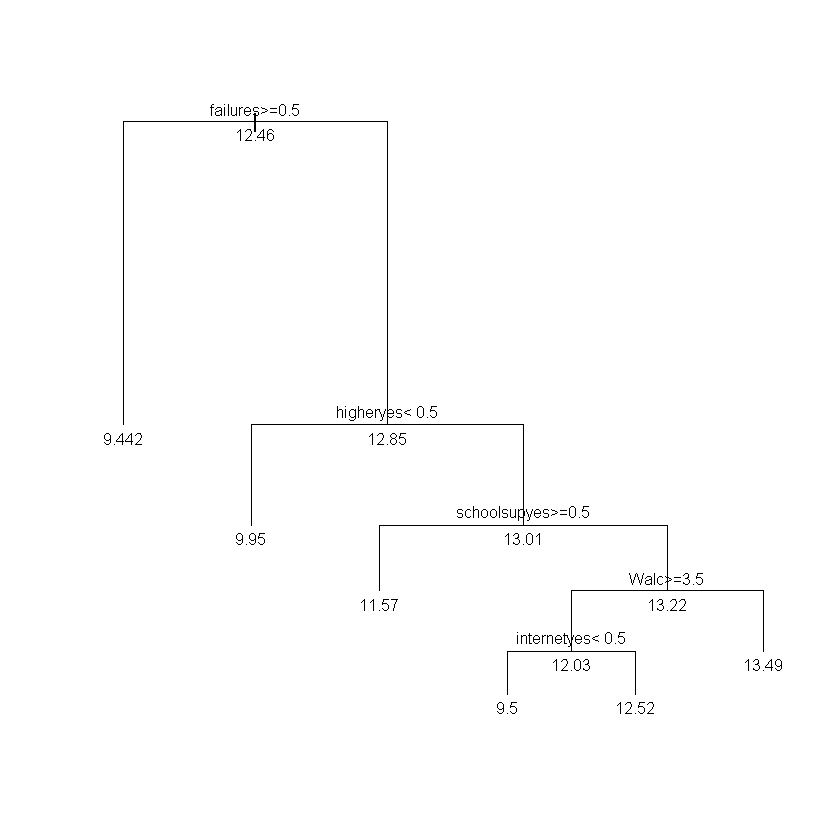

In [98]:
plot(POR_DT_fit1$finalModel)
text(POR_DT_fit1$finalModel, all=TRUE, cex=.8)

Random Forest 

454 samples
 30 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 408, 409, 410, 408, 408, 409, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
   1    2.429052  0.3196940  1.894665
   3    2.264470  0.3352537  1.746246
   5    2.236688  0.3344849  1.722534
   7    2.221124  0.3348259  1.708848
   9    2.217762  0.3331970  1.706630
  11    2.219915  0.3297236  1.711745

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 9.


Call:
 randomForest(x = x, y = y, mtry = param$mtry) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 9

          Mean of squared residuals: 4.921669
                    % Var explained: 32.51

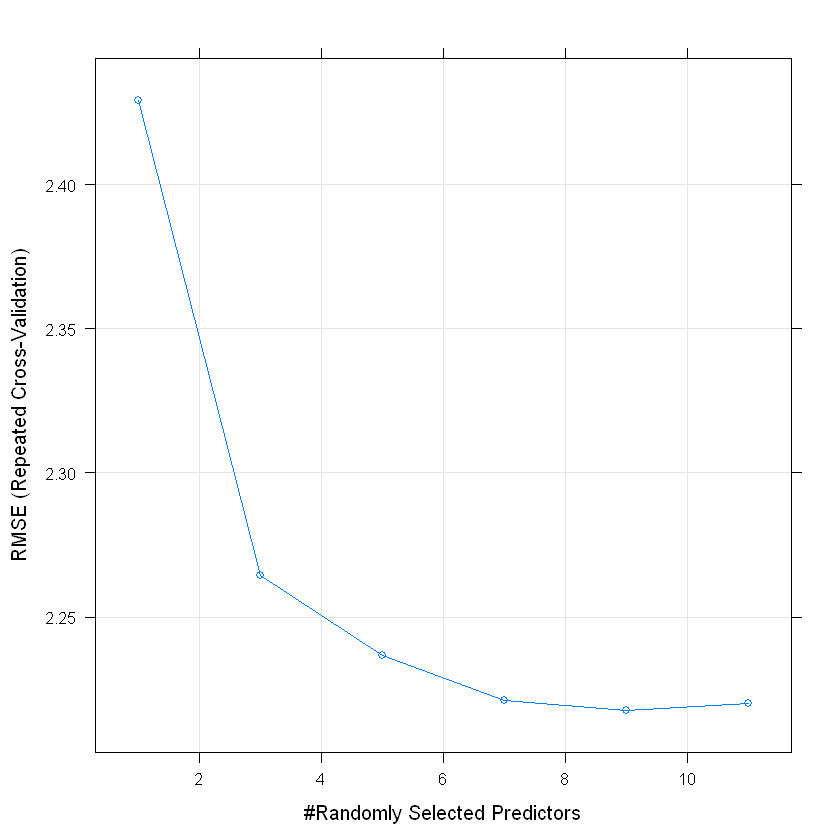

In [100]:
#Model 3 - Random Forest

RF_grid <- expand.grid(mtry = c(1,3,5,7,9,11)) # default value is 5 I change by both increasing and decreasing
RF_control <- trainControl(method = "repeatedcv", number = n_folds, repeats = n_repeats) 
POR_RF_fit <- train(G3~., data=train_Por, method ="rf",tuneGrid = RF_grid, trControl=RF_control)
POR_RF_fit
plot(POR_RF_fit)
POR_RF_fit$finalModel

In [102]:
#Model 4 - Stochastic Gradient Boosting

# interaction.depth default is 1 tried 2,3 and 5, n.trees default is 100 I change by both increasing and decreasing, 
# shrinkage default is 0.1 I change by both increasing and decreasing
SGB_grid <- expand.grid(interaction.depth=c(1,2,3,5), n.trees = c(100,200,50),shrinkage=c(0.05,0.1,0.2),n.minobsinnode =10)
SGB_control <- trainControl(method = "repeatedcv", number = n_folds, repeats = n_repeats) 
POR_SGB_fit <- train(G3~., data=train_Por, method ="gbm",tuneGrid = SGB_grid, trControl=SGB_control)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        7.2023             nan     0.0500    0.1279
     2        7.0743             nan     0.0500    0.0940
     3        6.9749             nan     0.0500    0.0768
     4        6.8988             nan     0.0500    0.0982
     5        6.8136             nan     0.0500    0.0845
     6        6.7319             nan     0.0500    0.0860
     7        6.6435             nan     0.0500    0.0708
     8        6.5489             nan     0.0500    0.0718
     9        6.4731             nan     0.0500    0.0762
    10        6.4052             nan     0.0500    0.0606
    20        5.9134             nan     0.0500    0.0194
    40        5.4022             nan     0.0500   -0.0067
    60        5.0822             nan     0.0500    0.0088
    80        4.8591             nan     0.0500   -0.0034
   100        4.6859             nan     0.0500   -0.0025
   120        4.5658             nan     0.0500   -0.0032
   140        

In [103]:
POR_SGB_fit
POR_SGB_fit$finalModel

Stochastic Gradient Boosting 

454 samples
 30 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 408, 408, 410, 407, 408, 410, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  RMSE      Rsquared   MAE     
  0.05       1                   50      2.361808  0.2641674  1.832330
  0.05       1                  100      2.286546  0.2922513  1.775090
  0.05       1                  200      2.251705  0.3070076  1.742106
  0.05       2                   50      2.299024  0.2967716  1.779744
  0.05       2                  100      2.251095  0.3069657  1.737566
  0.05       2                  200      2.260946  0.3041040  1.738596
  0.05       3                   50      2.280941  0.2985092  1.756481
  0.05       3                  100      2.249625  0.3079126  1.726304
  0.05       3                  200      2.285621  0.2937190  1.752935
  0.05       5                   50      2.262568  

A gradient boosted model with gaussian loss function.
100 iterations were performed.
There were 39 predictors of which 24 had non-zero influence.

###### Training RMSE for Each Model
RMSE is used as selecting parameters for models 

RMSE obtained from Training sets for each model given as;

Lasso RMSE 2.222

Decision Tree RMSE 2.335

Random Forest RMSE 2.218

Stochastic Gradient Boosting RMSE 2.248

Best RMSE obtained with Random Forest model for training set

In [117]:
# Lasso Regression 
POR_Lasso_predict = predict(POR_lasso_fit, test_Por)
RMSE_Lasso <- rmse(test_Por$G3,POR_Lasso_predict)
RMSE_Lasso <- round(RMSE_Lasso, digits=3)
# Decision Tree Regression 
POR_DT_predict = predict(POR_DT_fit1, test_Por)
RMSE_DT <- rmse(test_Por$G3,POR_DT_predict)
RMSE_DT <- round(RMSE_DT, digits=3)
# Random Forest Regression 
POR_RF_predict = predict(POR_RF_fit, test_Por)
RMSE_RF <- rmse(test_Por$G3,POR_RF_predict)
RMSE_RF <- round(RMSE_RF, digits=3)
# Stochastic Gradient Boosting Regression 
POR_SGB_predict = predict(POR_SGB_fit, test_Por)
RMSE_SGB <- rmse(test_Por$G3,POR_SGB_predict)
RMSE_SGB <- round(RMSE_SGB, digits=3)
A <-paste("Lasso Model Test RMSE is", RMSE_Lasso)
B <-paste("Decision Tree Test RMSE is", RMSE_DT)
C <-paste("Random Forest Test RMSE is", RMSE_RF)
D <-paste("Stochastic Gradient Boosting Test RMSE is", RMSE_SGB)
print(A)
print(B)
print(C)
print(D)

[1] "Lasso Model Test RMSE is 3.6636"
[1] "Decision Tree Test RMSE is 3.7674"
[1] "Random Forest Test RMSE is 3.6299"
[1] "Stochastic Gradient Boosting Test RMSE is 3.5999"


###### Comments

We obtained the best RMSE from Random Forest model during the training as 2.218. RMSE for other models are around the same value, highest RMSE is obtained Decision Tree modes as 2.335, which is not that different from the best one.

The predicted value G3 is a final grade and its maximum value is 20. Our RMSE values are around 2.2 which indicates a significant error even in the trainig set.

Our predictions have RMSE around 3.6. The model which obtained the best result obtained from the test data is Stochastic Gradient Boosting. Our RMSE values for predictions are very high. 

The data has some number of categorical or ordinal features, and for regression analysis these type of features may not be good. 

Also, if we add G1 and G2, which are midterm grades, the error values should decrease. Features included in the model may not be enough to predict a final grade note for a language exam.


# Dataset 3 -  Online News Popularity Data Set

##### Data Set Information:

* The articles were published by Mashable (www.mashable.com) and their content as the rights to reproduce it belongs to them. Hence, this dataset does not share the original content but some statistics associated with it. The original content be publicly accessed and retrieved using the provided urls.
* Acquisition date: January 8, 2015
* The estimated relative performance values were estimated by the authors using a Random Forest classifier and a rolling windows as assessment method. See their article for more details on how the relative performance values were set.

Attribute Information:

Number of Attributes: 61 (58 predictive attributes, 2 non-predictive, 1 goal field)

Attribute Information:
0. url: URL of the article (non-predictive)
1. timedelta: Days between the article publication and the dataset acquisition (non-predictive)
2. n_tokens_title: Number of words in the title
3. n_tokens_content: Number of words in the content
4. n_unique_tokens: Rate of unique words in the content
5. n_non_stop_words: Rate of non-stop words in the content
6. n_non_stop_unique_tokens: Rate of unique non-stop words in the content
7. num_hrefs: Number of links
8. num_self_hrefs: Number of links to other articles published by Mashable
9. num_imgs: Number of images
10. num_videos: Number of videos
11. average_token_length: Average length of the words in the content
12. num_keywords: Number of keywords in the metadata
13. data_channel_is_lifestyle: Is data channel 'Lifestyle'?
14. data_channel_is_entertainment: Is data channel 'Entertainment'?
15. data_channel_is_bus: Is data channel 'Business'?
16. data_channel_is_socmed: Is data channel 'Social Media'?
17. data_channel_is_tech: Is data channel 'Tech'?
18. data_channel_is_world: Is data channel 'World'?
19. kw_min_min: Worst keyword (min. shares)
20. kw_max_min: Worst keyword (max. shares)
21. kw_avg_min: Worst keyword (avg. shares)
22. kw_min_max: Best keyword (min. shares)
23. kw_max_max: Best keyword (max. shares)
24. kw_avg_max: Best keyword (avg. shares)
25. kw_min_avg: Avg. keyword (min. shares)
26. kw_max_avg: Avg. keyword (max. shares)
27. kw_avg_avg: Avg. keyword (avg. shares)
28. self_reference_min_shares: Min. shares of referenced articles in Mashable
29. self_reference_max_shares: Max. shares of referenced articles in Mashable
30. self_reference_avg_sharess: Avg. shares of referenced articles in Mashable
31. weekday_is_monday: Was the article published on a Monday?
32. weekday_is_tuesday: Was the article published on a Tuesday?
33. weekday_is_wednesday: Was the article published on a Wednesday?
34. weekday_is_thursday: Was the article published on a Thursday?
35. weekday_is_friday: Was the article published on a Friday?
36. weekday_is_saturday: Was the article published on a Saturday?
37. weekday_is_sunday: Was the article published on a Sunday?
38. is_weekend: Was the article published on the weekend?
39. LDA_00: Closeness to LDA topic 0
40. LDA_01: Closeness to LDA topic 1
41. LDA_02: Closeness to LDA topic 2
42. LDA_03: Closeness to LDA topic 3
43. LDA_04: Closeness to LDA topic 4
44. global_subjectivity: Text subjectivity
45. global_sentiment_polarity: Text sentiment polarity
46. global_rate_positive_words: Rate of positive words in the content
47. global_rate_negative_words: Rate of negative words in the content
48. rate_positive_words: Rate of positive words among non-neutral tokens
49. rate_negative_words: Rate of negative words among non-neutral tokens
50. avg_positive_polarity: Avg. polarity of positive words
51. min_positive_polarity: Min. polarity of positive words
52. max_positive_polarity: Max. polarity of positive words
53. avg_negative_polarity: Avg. polarity of negative words
54. min_negative_polarity: Min. polarity of negative words
55. max_negative_polarity: Max. polarity of negative words
56. title_subjectivity: Title subjectivity
57. title_sentiment_polarity: Title polarity
58. abs_title_subjectivity: Absolute subjectivity level
59. abs_title_sentiment_polarity: Absolute polarity level
60. shares: Number of shares (target)

Relevant Papers:

K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.



##### For the analysis

Shares will be target but I will classfy them as popular or not. So we will have 2 classes. I will create a class imbalance with that selection.
We have more than 50 features.
First two colums are URL and time, so I will remove them.

In [3]:
#read the data
News_data = read.csv(file = "OnlineNewsPopularity.csv")
News_data <- News_data[!names(News_data) %in% c("url", "timedelta")]
News_data = data.table(News_data)
News_data[,is_popular:=as.factor(as.numeric(shares>quantile(shares,0.7)))]  # top %30 selected as popular to create a class imbalance
News_data[,shares:=NULL]

# divide the train and test data (%80 selected as train %20 selected as test)
m = nrow(News_data)
n= m*0.8
News_train = News_data[1:n,]
News_test = News_data[(n+1):m,]

In [4]:
#Model 1 - Lasso Regression
set.seed(636)
lambda_seq = c(seq(0.00001,0.01,length=6)) #tried several times but we are asked to use 6 different lamda (I rerun the code)
n_repeats=5
n_folds=10
lasso_grid = expand.grid(alpha=1,lambda=lambda_seq)
lasso_control=trainControl(method = "repeatedcv", number = n_folds, repeats = n_repeats)                        
News_lasso_fit = train(is_popular~ .,data=News_train, method = "glmnet", tuneGrid = lasso_grid,trControl = lasso_control) 
News_lasso_fit

glmnet 

31715 samples
   58 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 28544, 28543, 28543, 28543, 28543, 28543, ... 
Resampling results across tuning parameters:

  lambda    Accuracy   Kappa     
  0.000010  0.7068832  0.15273557
  0.002008  0.7043860  0.13004443
  0.004006  0.7013401  0.10491154
  0.006004  0.6988870  0.08270075
  0.008002  0.6967114  0.06513976
  0.010000  0.6952546  0.05104745

Tuning parameter 'alpha' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were alpha = 1 and lambda = 1e-05.

In [9]:
#Model 2 - Decision Trees

set.seed(636)

DT_control <- trainControl(method = "repeatedcv", number = n_folds, repeats = n_repeats) 
DT_grid <- expand.grid(cp=c(0.01,0.02,0.05,0.005,0.002,0.001)) # cp by default 0.01, I change by both increasing and decreasing

# minbucket is originaly "20/3 = 7" so I tried original "7", increase to "20", decrease to "2"...
News_DT_fit1 <- train(is_popular~ .,data=News_train, method ="rpart",tuneGrid = DT_grid, trControl=DT_control, control = rpart.control(minbucket=7))

News_DT_fit2 <- train(is_popular~ .,data=News_train, method ="rpart",tuneGrid = DT_grid, trControl=DT_control, control = rpart.control(minbucket=20))

News_DT_fit3 <- train(is_popular~ .,data=News_train, method ="rpart",tuneGrid = DT_grid, trControl=DT_control, control = rpart.control(minbucket=2))

News_DT_fit1
News_DT_fit2
News_DT_fit3

CART 

31715 samples
   58 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 28544, 28543, 28543, 28543, 28543, 28543, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa    
  0.001  0.7009933  0.1488407
  0.002  0.7001105  0.1198968
  0.005  0.6973926  0.1071019
  0.010  0.6920385  0.0000000
  0.020  0.6920385  0.0000000
  0.050  0.6920385  0.0000000

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.001.

CART 

31715 samples
   58 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 28543, 28544, 28544, 28544, 28543, 28543, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa    
  0.001  0.7016490  0.1510433
  0.002  0.7000535  0.1221678
  0.005  0.6972031  0.1018049
  0.010  0.6920385  0.0000000
  0.020  0.6920385  0.0000000
  0.050  0.6920385  0.0000000

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.001.

CART 

31715 samples
   58 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 28543, 28544, 28543, 28543, 28543, 28544, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa    
  0.001  0.7022670  0.1540894
  0.002  0.7003373  0.1249599
  0.005  0.6981050  0.1085825
  0.010  0.6920385  0.0000000
  0.020  0.6920385  0.0000000
  0.050  0.6920385  0.0000000

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.001.

###### 
Best Kappa value is obtained with the minbucket=2 selection so, News_DT_fit3 will be used.

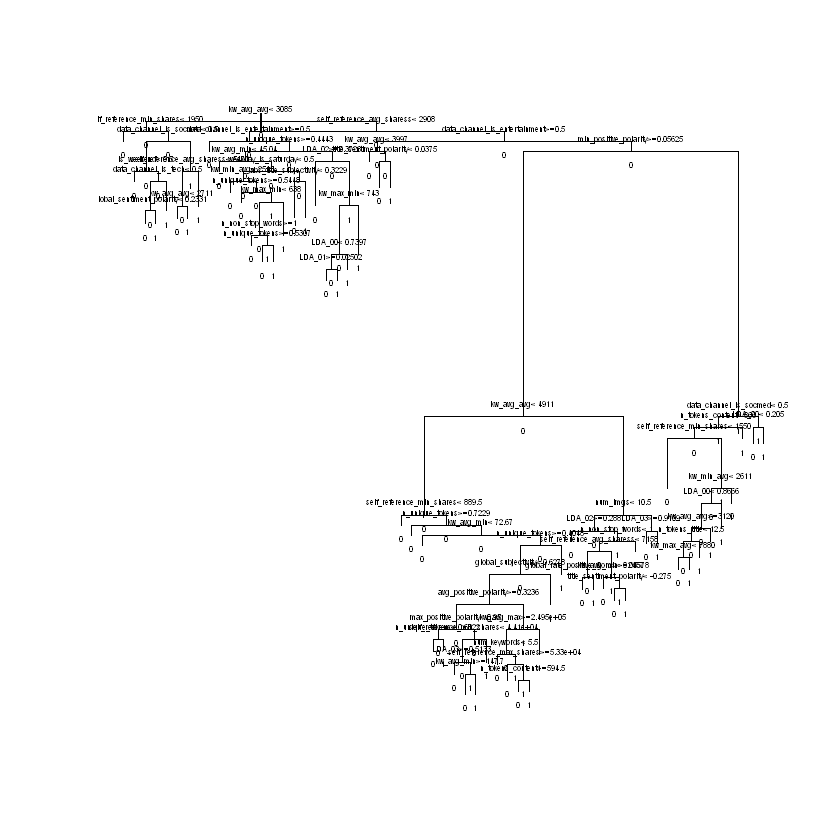

In [6]:
plot(News_DT_fit3$finalModel)
text(News_DT_fit3$finalModel, all=TRUE, cex=.4)

Random Forest 

31715 samples
   58 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 28543, 28544, 28544, 28544, 28543, 28543, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   3    0.7154972  0.1663410
   5    0.7150242  0.1766100
  10    0.7169792  0.1953825
  15    0.7168531  0.1989622

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 10.


Call:
 randomForest(x = x, y = y, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 10

        OOB estimate of  error rate: 28.47%
Confusion matrix:
      0    1 class.error
0 20439 1509  0.06875342
1  7519 2248  0.76983721

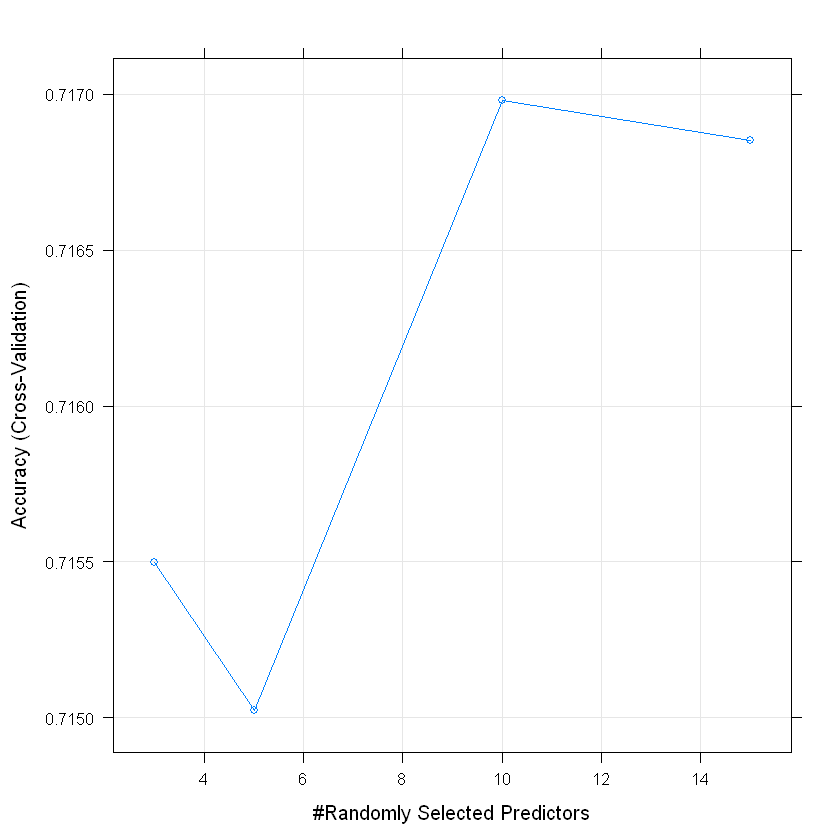

In [5]:
#Model 3 - Random Forest

RF_grid <- expand.grid(mtry = c(3,5,10,15)) # default value is 5 I change by both increasing and decreasing
# RF_control <- trainControl(method = "repeatedcv", number = n_folds, repeats = 2) 
# repeatedcv tooks so long to compute so I used cv this time and reduced the "mtry" options. 
RF_control <- trainControl(method = "cv", number = n_folds)
News_RF_fit <- train(is_popular~ .,data=News_train, method ="rf",tuneGrid = RF_grid, trControl=RF_control)
News_RF_fit
plot(News_RF_fit)
News_RF_fit$finalModel

In [6]:
#Model 4 - Stochastic Gradient Boosting

# interaction.depth default is 1 tried 2,3 and 5, n.trees default is 100 I change by both increasing and decreasing, 
# shrinkage default is 0.1 I change by both increasing and decreasing
SGB_grid <- expand.grid(interaction.depth=c(1,3,5), n.trees = c(100,200,50),shrinkage=c(0.05,0.1,0.2),n.minobsinnode =10)
# repeatedcv tooks so long to compute so I used cv this time and reduced the "interaction.depth" options.
#SGB_control <- trainControl(method = "repeatedcv", number = n_folds, repeats = n_repeats) 
SGB_control <- trainControl(method = "cv", number = n_folds)
News_SGB_fit <- train(is_popular~ .,data=News_train, method ="gbm",tuneGrid = SGB_grid, trControl=SGB_control)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.2313             nan     0.0500    0.0016
     2        1.2281             nan     0.0500    0.0015
     3        1.2252             nan     0.0500    0.0014
     4        1.2226             nan     0.0500    0.0012
     5        1.2203             nan     0.0500    0.0010
     6        1.2179             nan     0.0500    0.0011
     7        1.2157             nan     0.0500    0.0010
     8        1.2136             nan     0.0500    0.0010
     9        1.2117             nan     0.0500    0.0009
    10        1.2100             nan     0.0500    0.0008
    20        1.1958             nan     0.0500    0.0005
    40        1.1799             nan     0.0500    0.0002
    60        1.1697             nan     0.0500    0.0002
    80        1.1620             nan     0.0500    0.0001
   100        1.1561             nan     0.0500    0.0001
   120        1.1513             nan     0.0500    0.0001
   140        

In [7]:
News_SGB_fit
News_SGB_fit$finalModel

Stochastic Gradient Boosting 

31715 samples
   58 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 28543, 28543, 28544, 28543, 28545, 28543, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  Accuracy   Kappa     
  0.05       1                   50      0.6920385  0.00000000
  0.05       1                  100      0.6970201  0.04163981
  0.05       1                  200      0.7040830  0.10859762
  0.05       3                   50      0.6997317  0.05654661
  0.05       3                  100      0.7084974  0.13948121
  0.05       3                  200      0.7136058  0.18085186
  0.05       5                   50      0.7050291  0.09730966
  0.05       5                  100      0.7124388  0.16595735
  0.05       5                  200      0.7158129  0.19615907
  0.10       1                   50      0.6975876  0.04678712
  0.10       1                  100      0.70

A gradient boosted model with bernoulli loss function.
200 iterations were performed.
There were 58 predictors of which 52 had non-zero influence.

###### Accuracy and Kappa values for Each Model on Training Sets

                                     
    Lasso Model --> Accuracy 0.7069  --  Kappa --> 0.1527

    Decision Tree Model  --> Accuracy 0.7023   Kappa -->  0.1541

    Random Forest Model  --> Accuracy 0.7170  Kappa -->  0.1954

    Stochastic Gradient Boosting Model  --> Accuracy 0.7165  Kappa -->  0.2050

In [10]:
# Lasso Prediction
News_Lasso_predict = predict(News_lasso_fit, News_test)
CM_Lasso <- confusionMatrix(News_Lasso_predict, News_test$is_popular)
overall <- CM_Lasso$overall
Accuracy_Lasso <- overall['Accuracy']
Kappa_Lasso <- overall['Kappa']
CM_Lasso
Accuracy_Lasso <- round(Accuracy_Lasso, digits=4)
Kappa_Lasso <- round(Kappa_Lasso, digits=4)
# Decision Tree Prediction
News_DT_predict = predict(News_DT_fit3, News_test)
CM_DT <- confusionMatrix(News_DT_predict, News_test$is_popular)
overall <- CM_DT$overall
Accuracy_DT <- overall['Accuracy']
Kappa_DT <- overall['Kappa']
CM_DT
Accuracy_DT <- round(Accuracy_DT, digits=4)
Kappa_DT <- round(Kappa_DT, digits=4)
# Random Forest Prediction
News_RF_predict = predict(News_RF_fit, News_test)
CM_RF <- confusionMatrix(News_RF_predict, News_test$is_popular)
overall <- CM_RF$overall
Accuracy_RF <- overall['Accuracy']
Kappa_RF <- overall['Kappa']
CM_RF
Accuracy_RF <- round(Accuracy_RF, digits=4)
Kappa_RF <- round(Kappa_RF, digits=4)
# Stochastic Gradient Boosting Prediction
News_SGB_predict = predict(News_SGB_fit, News_test)
CM_SGB <- confusionMatrix(News_SGB_predict, News_test$is_popular)
overall <- CM_SGB$overall
Accuracy_SGB <- overall['Accuracy']
Kappa_SGB <- overall['Kappa']
CM_SGB
Accuracy_SGB <- round(Accuracy_RF, digits=4)
Kappa_SGB <- round(Kappa_RF, digits=4)

A <-paste("Lasso Model Test Accuracy is", Accuracy_Lasso, " and Kappa is", Kappa_Lasso)
B <-paste("Decision Tree Test Accuracy is", Accuracy_DT, " and Kappa is", Kappa_DT)
C <-paste("Random Forest Test Accuracy is", Accuracy_RF, " and Kappa is", Kappa_RF)
D <-paste("Stochastic Gradient Boosting Test Accuracy is", Accuracy_SGB, " and Kappa is", Kappa_SGB)
print(A)
print(B)
print(C)
print(D)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 5546 1647
         1  336  399
                                          
               Accuracy : 0.7499          
                 95% CI : (0.7402, 0.7594)
    No Information Rate : 0.7419          
    P-Value [Acc > NIR] : 0.05397         
                                          
                  Kappa : 0.1743          
                                          
 Mcnemar's Test P-Value : < 2e-16         
                                          
            Sensitivity : 0.9429          
            Specificity : 0.1950          
         Pos Pred Value : 0.7710          
         Neg Pred Value : 0.5429          
             Prevalence : 0.7419          
         Detection Rate : 0.6995          
   Detection Prevalence : 0.9073          
      Balanced Accuracy : 0.5689          
                                          
       'Positive' Class : 0               
                        

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 5344 1497
         1  538  549
                                          
               Accuracy : 0.7433          
                 95% CI : (0.7335, 0.7529)
    No Information Rate : 0.7419          
    P-Value [Acc > NIR] : 0.3945          
                                          
                  Kappa : 0.2088          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.9085          
            Specificity : 0.2683          
         Pos Pred Value : 0.7812          
         Neg Pred Value : 0.5051          
             Prevalence : 0.7419          
         Detection Rate : 0.6741          
   Detection Prevalence : 0.8629          
      Balanced Accuracy : 0.5884          
                                          
       'Positive' Class : 0               
                        

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 5540 1590
         1  342  456
                                          
               Accuracy : 0.7563          
                 95% CI : (0.7467, 0.7657)
    No Information Rate : 0.7419          
    P-Value [Acc > NIR] : 0.0017          
                                          
                  Kappa : 0.2056          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.9419          
            Specificity : 0.2229          
         Pos Pred Value : 0.7770          
         Neg Pred Value : 0.5714          
             Prevalence : 0.7419          
         Detection Rate : 0.6988          
   Detection Prevalence : 0.8993          
      Balanced Accuracy : 0.5824          
                                          
       'Positive' Class : 0               
                        

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 5545 1605
         1  337  441
                                          
               Accuracy : 0.755           
                 95% CI : (0.7454, 0.7645)
    No Information Rate : 0.7419          
    P-Value [Acc > NIR] : 0.003799        
                                          
                  Kappa : 0.1983          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9427          
            Specificity : 0.2155          
         Pos Pred Value : 0.7755          
         Neg Pred Value : 0.5668          
             Prevalence : 0.7419          
         Detection Rate : 0.6994          
   Detection Prevalence : 0.9019          
      Balanced Accuracy : 0.5791          
                                          
       'Positive' Class : 0               
                        

[1] "Lasso Model Test Accuracy is 0.7499  and Kappa is 0.1743"
[1] "Decision Tree Test Accuracy is 0.7433  and Kappa is 0.2088"
[1] "Random Forest Test Accuracy is 0.7563  and Kappa is 0.2056"
[1] "Stochastic Gradient Boosting Test Accuracy is 0.7563  and Kappa is 0.2056"


##### Comments

Our training data accuracy is around %70 and Kappa values are scattered around 0.15 and 0.20. When we made the predictions with the models, we observe that our accuracy is increased to %75 which is more than what obtained for each model on the training set. We also get Kappa values around 0.20 for our predictions. Since it is a class imbalance problem Kappa values have more meaning. Although we improved our accuracy for the test data, since it is a 0.7 to 0.3 class imbalance set, if we made our guesses as class "0" for each data, we would have get a %70 accuracy. So obtaining a %75 accuracy does not mean a lot. I can not tell which Model is best for the dataset but I would not suggest Lasso Model which gave the lowest Kappa value.

# Dataset 4 - Dota2 Games Results Data Set

https://archive.ics.uci.edu/ml/datasets/Dota2+Games+Results

##### Data Set Information:

Dota 2 is a popular computer game with two teams of 5 players. At the start of the game each player chooses a unique hero with different strengths and weaknesses. The dataset is reasonably sparse as only 10 of 113 possible heroes are chosen in a given game. All games were played in a space of 2 hours on the 13th of August, 2016

The data was collected using: [https://gist.github.com/da-steve101/1a7ae319448db431715bd75391a66e1b]

##### Attribute Information:

Each row of the dataset is a single game with the following features (in the order in the vector):

1. Team won the game (1 or -1)

2. Cluster ID (related to location)

3. Game mode (eg All Pick)

4. Game type (eg. Ranked)

5. end: Each element is an indicator for a hero. Value of 1 indicates that a player from team '1' played as that hero and '-1' for the other team. Hero can be selected by only one player each game. This means that each row has five '1' and five '-1' values.



#### For the analysis:

Dataset is one of the I found that has more than 50 features. It is a 2 class problem. Team won the game will be the target.

In [3]:
#read the data
DOTA2_train = read.csv(file = "dota2Train.csv")
DOTA2_test = read.csv(file = "dota2Test.csv")
DOTA2_train = data.frame(DOTA2_train[,])
DOTA2_train <- DOTA2_train[!names(DOTA2_train) %in% c("X223")] #removed the second column about the location considered as "nonpredictive"
DOTA2_test = data.frame(DOTA2_train)
DOTA2_test <- DOTA2_test[!names(DOTA2_test) %in% c("X223")]
DOTA2_train$X.1 <- as.factor(DOTA2_train$X.1) #It will be classification so needs to be factor?
DOTA2_test$X.1 <- as.factor(DOTA2_test$X.1)

#my RAM does not allow me to process the whole data so I took %10 of it still 9k for train and 1k for test

n = nrow(DOTA2_train)
n = n*0.1
m = nrow(DOTA2_test)
m = m*0.1
DOTA2_train = DOTA2_train[1:(n),]
DOTA2_test = DOTA2_test[1:(m),]

In [5]:
#Model 1 - Lasso Regression
set.seed(636)
lambda_seq = c(seq(0.00001,0.02,length=6)) #tried several times but we are asked to use 6 different lamda (I rerun the code)
n_repeats=5
n_folds=10
lasso_grid = expand.grid(alpha=1,lambda=lambda_seq)
lasso_control=trainControl(method = "repeatedcv", number = n_folds, repeats = n_repeats)                        
DOTA2_lasso_fit = train(X.1~ .,data=DOTA2_train, method = "glmnet", tuneGrid = lasso_grid,trControl = lasso_control) 
DOTA2_lasso_fit

glmnet 

9264 samples
 115 predictor
   2 classes: '-1', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 8337, 8338, 8338, 8337, 8337, 8338, ... 
Resampling results across tuning parameters:

  lambda    Accuracy   Kappa     
  0.000010  0.5887522  0.16761065
  0.004008  0.5875002  0.16208394
  0.008006  0.5812395  0.14472722
  0.012004  0.5715671  0.11725222
  0.016002  0.5526765  0.06687411
  0.020000  0.5402620  0.02927013

Tuning parameter 'alpha' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were alpha = 1 and lambda = 1e-05.

In [10]:
#Model 2 - Decision Trees

set.seed(636)

DT_control <- trainControl(method = "repeatedcv", number = n_folds, repeats = n_repeats) 
DT_grid <- expand.grid(cp=c(0.01,0.02,0.05,0.005,0.002,0.001)) # cp by default 0.01, I change by both increasing and decreasing

# minbucket is originaly "20/3 = 7" so I tried original "7", increase to "20", decrease to "2"...
DOTA2_DT_fit1 <- train(X.1~ .,data=DOTA2_train, method ="rpart",tuneGrid = DT_grid, trControl=DT_control, control = rpart.control(minbucket=7))

DOTA2_DT_fit2 <- train(X.1~ .,data=DOTA2_train, method ="rpart",tuneGrid = DT_grid, trControl=DT_control, control = rpart.control(minbucket=20))

DOTA2_DT_fit3 <- train(X.1~ .,data=DOTA2_train, method ="rpart",tuneGrid = DT_grid, trControl=DT_control, control = rpart.control(minbucket=2))

DOTA2_DT_fit1
DOTA2_DT_fit2
DOTA2_DT_fit3

CART 

9264 samples
 115 predictor
   2 classes: '-1', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 8337, 8338, 8338, 8337, 8337, 8338, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa        
  0.001  0.5487684   0.0872293481
  0.002  0.5547058   0.0962851445
  0.005  0.5356218   0.0291722641
  0.010  0.5300959   0.0062334349
  0.020  0.5298799  -0.0002883401
  0.050  0.5309802   0.0000000000

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.002.

CART 

9264 samples
 115 predictor
   2 classes: '-1', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 8338, 8338, 8337, 8337, 8337, 8338, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa       
  0.001  0.5490474   0.086875318
  0.002  0.5518545   0.088752748
  0.005  0.5369167   0.033226245
  0.010  0.5292738   0.002521757
  0.020  0.5293397  -0.001359194
  0.050  0.5309802   0.000000000

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.002.

CART 

9264 samples
 115 predictor
   2 classes: '-1', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 8337, 8338, 8337, 8338, 8338, 8338, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa       
  0.001  0.5481878  0.0865871499
  0.002  0.5534993  0.0954359196
  0.005  0.5360530  0.0313589696
  0.010  0.5312820  0.0065490853
  0.020  0.5305481  0.0003187359
  0.050  0.5309802  0.0000000000

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.002.

###### 
Best Kappa value is obtained with the minbucket=7 selection so, DOTA2_DT_fit1 will be used. All Kappa values are bad though.

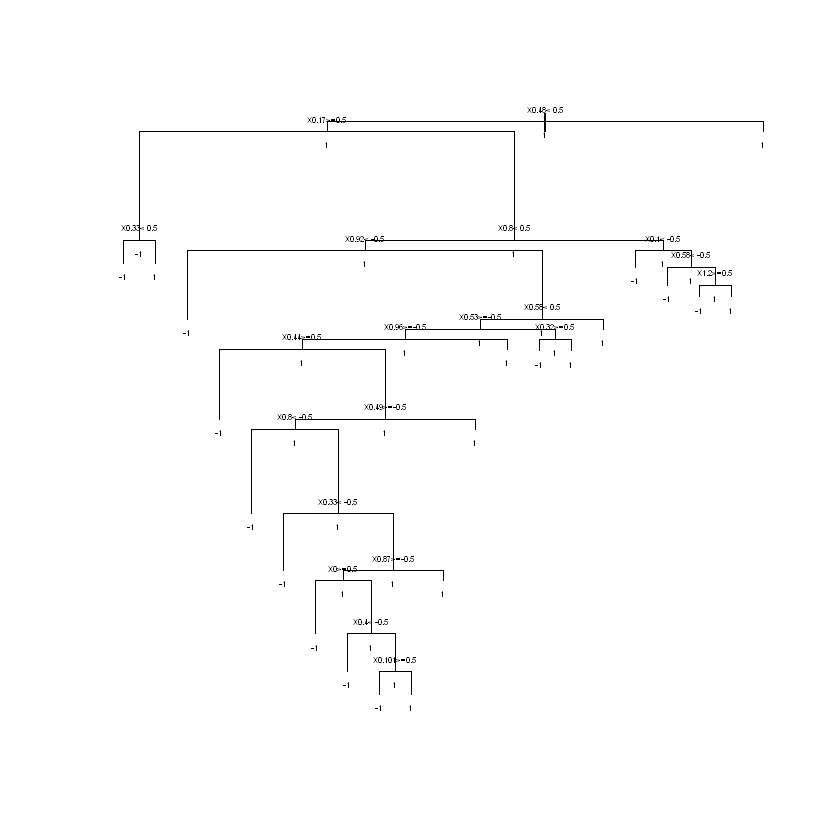

In [11]:
plot(DOTA2_DT_fit1$finalModel)
text(DOTA2_DT_fit1$finalModel, all=TRUE, cex=.4)

In [ ]:
#Model 3 - Random Forest

RF_grid <- expand.grid(mtry = c(3,5,10)) # default value is 5 I change by both increasing and decreasing
# RF_control <- trainControl(method = "repeatedcv", number = n_folds, repeats = 2) 
# repeatedcv tooks so long to compute so I used cv this time and reduced the "mtry" options. 
RF_control <- trainControl(method = "cv", number = n_folds)
DOTA2_RF_fit <- train(X.1~ .,data=DOTA2_train, method ="rf",tuneGrid = RF_grid, trControl=RF_control)
DOTA2_RF_fit
plot(DOTA2_RF_fit)
DOTA2_RF_fit$finalModel

In [ ]:
#Model 4 - Stochastic Gradient Boosting

# interaction.depth default is 1 tried 2,3 and 5, n.trees default is 100 I change by both increasing and decreasing, 
# shrinkage default is 0.1 I change by both increasing and decreasing
SGB_grid <- expand.grid(interaction.depth=c(1,3,5), n.trees = c(100,200,50),shrinkage=c(0.05,0.1,0.2),n.minobsinnode =10)
# repeatedcv tooks so long to compute so I used cv this time and reduced the "interaction.depth" options.
#SGB_control <- trainControl(method = "repeatedcv", number = n_folds, repeats = n_repeats) 
SGB_control <- trainControl(method = "cv", number = n_folds)
DOTA2_SGB_fit <- train(X.1~ .,data=DOTA2_train, method ="gbm",tuneGrid = SGB_grid, trControl=SGB_control)

In [ ]:
DOTA2_SGB_fit
DOTA2_SGB_fit$finalModel

In [ ]:
###### Accuracy and Kappa values for Each Model on Training Sets

                                     
    Lasso Model --> Accuracy 0.5887  --  Kappa --> 0.1676

    Decision Tree Model  --> Accuracy 0.5547   Kappa -->  0.0963

    Random Forest Model  --> Accuracy N/A  Kappa -->  N/A

    Stochastic Gradient Boosting Model  --> Accuracy N/A  Kappa -->  N/A

In [13]:
# Lasso Prediction
DOTA2_Lasso_predict = predict(DOTA2_lasso_fit, DOTA2_test)
CM_Lasso <- confusionMatrix(DOTA2_Lasso_predict, DOTA2_test$X.1)
overall <- CM_Lasso$overall
Accuracy_Lasso <- overall['Accuracy']
Kappa_Lasso <- overall['Kappa']
CM_Lasso
Accuracy_Lasso <- round(Accuracy_Lasso, digits=4)
Kappa_Lasso <- round(Kappa_Lasso, digits=4)
A <-paste("Lasso Model Test Accuracy is", Accuracy_Lasso, " and Kappa is", Kappa_Lasso)

Confusion Matrix and Statistics

          Reference
Prediction   -1    1
        -1 2223 1506
        1  2122 3413
                                          
               Accuracy : 0.6084          
                 95% CI : (0.5984, 0.6183)
    No Information Rate : 0.531           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2072          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.5116          
            Specificity : 0.6938          
         Pos Pred Value : 0.5961          
         Neg Pred Value : 0.6166          
             Prevalence : 0.4690          
         Detection Rate : 0.2400          
   Detection Prevalence : 0.4025          
      Balanced Accuracy : 0.6027          
                                          
       'Positive' Class : -1              
                        

In [14]:
# Decision Tree Prediction
DOTA2_DT_predict = predict(DOTA2_DT_fit1, DOTA2_test)
CM_DT <- confusionMatrix(DOTA2_DT_predict, DOTA2_test$X.1)
overall <- CM_DT$overall
Accuracy_DT <- overall['Accuracy']
Kappa_DT <- overall['Kappa']
CM_DT
Accuracy_DT <- round(Accuracy_DT, digits=4)
Kappa_DT <- round(Kappa_DT, digits=4)
B <-paste("Decision Tree Test Accuracy is", Accuracy_DT, " and Kappa is", Kappa_DT)

Confusion Matrix and Statistics

          Reference
Prediction   -1    1
        -1 1961 1510
        1  2384 3409
                                          
               Accuracy : 0.5797          
                 95% CI : (0.5695, 0.5897)
    No Information Rate : 0.531           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.1461          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.4513          
            Specificity : 0.6930          
         Pos Pred Value : 0.5650          
         Neg Pred Value : 0.5885          
             Prevalence : 0.4690          
         Detection Rate : 0.2117          
   Detection Prevalence : 0.3747          
      Balanced Accuracy : 0.5722          
                                          
       'Positive' Class : -1              
                        

In [ ]:
# Random Forest Prediction
DOTA2_RF_predict = predict(DOTA2_RF_fit, DOTA2_test)
CM_RF <- confusionMatrix(News_RF_predict, DOTA2_test$X.1)
overall <- CM_RF$overall
Accuracy_RF <- overall['Accuracy']
Kappa_RF <- overall['Kappa']
CM_RF
Accuracy_RF <- round(Accuracy_RF, digits=4)
Kappa_RF <- round(Kappa_RF, digits=4)
C <-paste("Random Forest Test Accuracy is", Accuracy_RF, " and Kappa is", Kappa_RF)

In [ ]:
# Stochastic Gradient Boosting Prediction
DOTA2_SGB_predict = predict(DOTA2_SGB_fit, DOTA2_test)
DOTA2_SGB <- confusionMatrix(DOTA2_SGB_predict, DOTA2_test$X.1)
overall <- CM_SGB$overall
Accuracy_SGB <- overall['Accuracy']
Kappa_SGB <- overall['Kappa']
CM_SGB
Accuracy_SGB <- round(Accuracy_RF, digits=4)
Kappa_SGB <- round(Kappa_RF, digits=4)
D <-paste("Stochastic Gradient Boosting Test Accuracy is", Accuracy_SGB, " and Kappa is", Kappa_SGB)

In [15]:
print(A)

[1] "Lasso Model Test Accuracy is 0.6084  and Kappa is 0.2072"


In [16]:
print(B)

[1] "Decision Tree Test Accuracy is 0.5797  and Kappa is 0.1461"


In [ ]:
print(C)

In [ ]:
print(D)

##### Comments

Overall our accuracy and Kappa values are low no matter what model is chosen. Our accuracy is around %50 which is almost equal to random. Pre-processing the data might be helpful. Also the data may not be suitable for selected models or parameters.

Our prediction accuracies are around %60 and Kappa values are between 0.15 and 0.20. Lasso Model gave better results. 

Working on Random Forest and Stochastic Gradient Boosting but could not able to finish them on time.